In [1]:
import numpy as np
import pandas as pd

import itertools
from operator import itemgetter

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

### Функции

In [3]:
# разбиение выборки на тренировочную и валидационную
def train_test_split(x, y, test_size=0.3):
    indexes = range(x.shape[0])
    train_len = int(x.shape[0]*(1-test_size))

    train_indexes = np.random.choice(indexes, size=train_len, replace=False)
    test_indexes = [i for i in indexes if i not in train_indexes]

    return x[train_indexes], y[train_indexes], x[test_indexes], y[test_indexes]

In [4]:
# вычисляет ROC
def roc(y, probas):
    # combined (real value, score)
    data = sorted(np.array([(y[i], probas[i]) for i in range(len(y))]), reverse=True, key=lambda e: e[1])
    
    tt = float(len(y[y == 1]))
    tf = float(len(y) - tt)
    ft, ff = 0.0, 0.0
    
    tprs, fprs  = [0.0], [0.0]
    
    for d in data:
        if d[0] == 1:
            ft += 1
        else:
            ff += 1
            
        tprs.append(ft / tt)
        fprs.append(ff / tf)
        
    return fprs, tprs

In [5]:
# вычисляем ROC_AUC
def roc_auc(y, y_proba):
    fprs, tprs = roc(y, y_proba)
    
    return np.trapz(tprs, x = fprs, dx=0.1)

In [21]:
# стандартизация
def normalize(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = (X[i][j] - means[j])/stds[j]
            
    return X

In [22]:
# нормализация
def minimax(X):
    minis = np.min(X, axis=0)
    maxis = np.std(X, axis=0)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = (X[i][j] - minis[j])/(maxis[j] - minis[j])
            
    return X

In [8]:
# Евклидова метрика
def e_metrics(x1, x2):
    distance = np.sum([(x1[i] - x2[i])**2 for i in range(len(x1))])

    return np.sqrt(distance)

In [33]:
# KNN
def knn(x_train, y_train, x_test, k, wq=None):
    answers, proba = [], []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            distance = e_metrics(x, x_train[i])   
                
            w = 0
            if wq:
                w = wq**i
                
            #print(f'i:{i}, y:{y_train[i]}')
            test_distances.append((distance + w, y_train[i]))
        
        classes = {class_item: 0 for class_item in set(y_train)}
        
        #print('X', x)
        for d in sorted(test_distances)[0:k]:
            #print('d', d)
            classes[d[1]] += 1
            
        proba.append((classes.get(1) or 0)/k)
        answers.append(sorted(classes, key=classes.get)[-1])
    return proba, answers

In [10]:
# кросс-валидация
def cv(x_train, y_train, x_test, y_test, model, params, score_func):
    keys = params.keys()
    vals = params.values()
    
    perms = list(itertools.product(*vals))
    settings = [dict(zip(keys, p)) for p in perms]
    print('Total: ', len(settings))
    
    scores = []
    for s in settings:
        print('Processing: ', s)
        proba, pred = model(x_train, y_train, x_test, **s)
        
        score = score_func(y_test, proba)
        print('Score: ', score)
        scores.append((s, score))
        
    print('Done')
    return max(scores, key=itemgetter(1))[0]

### Загрузка и анализ данных

In [11]:
train_df = pd.read_csv('classification_train.csv')

In [12]:
train_df.shape

(10000, 13)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
choose                 10000 non-null int64
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [14]:
train_df.describe()

Id           age  years_of_experience  lesson_price  \
count  10000.00000  10000.000000         10000.000000  10000.000000   
mean    4999.50000     45.800900             1.974800   1702.440000   
std     2886.89568      8.030274             1.766883    523.789062   
min        0.00000     23.000000             0.000000    200.000000   
25%     2499.75000     40.000000             0.000000   1300.000000   
50%     4999.50000     46.000000             2.000000   1550.000000   
75%     7499.25000     51.000000             3.000000   2150.000000   
max     9999.00000     68.000000             9.000000   3950.000000   

       qualification      physics     chemistry       biology       english  \
count   10000.000000  10000.00000  10000.000000  10000.000000  10000.000000   
mean        1.724300      0.37060      0.121500      0.117200      0.059100   
std         0.798845      0.48299      0.326724      0.321675      0.235824   
min         1.000000      0.00000      0.000000      0.000000      0.000000   
25%         1.000000      0.00000      0.000000      0.000000      0.000000   
50%         2.000000      0.00000      0.000000      0.000000      0.000000   
75%         2.000000      1.00000      0.000000      0.000000      0.000000   
max         4.000000      1.00000      1.000000      1.000000      1.000000   

         geography       history  mean_exam_points        choose  
count  10000.00000  10000.000000      10000.000000  10000.000000  
mean       0.02770      0.018000         64.435200      0.110900  
std        0.16412      0.132958         13.595024      0.314024  
min        0.00000      0.000000         33.000000      0.000000  
25%        0.00000      0.000000         55.000000      0.000000  
50%        0.00000      0.000000         63.000000      0.000000  
75%        0.00000      0.000000         74.000000      0.000000  
max        1.00000      1.000000        100.000000      1.000000

In [15]:
train_df.head()

Id   age  years_of_experience  lesson_price  qualification  physics  \
0   0  35.0                  0.0        2150.0            2.0      0.0   
1   1  52.0                  2.0        1250.0            2.0      1.0   
2   2  29.0                  3.0        1750.0            1.0      1.0   
3   3  33.0                  3.0        1050.0            1.0      0.0   
4   4  46.0                  3.0        2250.0            2.0      1.0   

   chemistry  biology  english  geography  history  mean_exam_points  choose  
0        0.0      0.0      0.0        0.0      0.0              74.0       0  
1        0.0      1.0      0.0        0.0      1.0              57.0       1  
2        0.0      0.0      0.0        0.0      0.0              66.0       0  
3        0.0      0.0      0.0        0.0      0.0              66.0       1  
4        0.0      0.0      0.0        0.0      0.0              73.0       0

physics                0.195183
mean_exam_points       0.109409
chemistry              0.091878
biology                0.071310
qualification          0.042160
years_of_experience    0.029010
english                0.022227
age                    0.017165
Id                     0.012043
geography              0.006366
history               -0.004700
lesson_price          -0.134013
Name: choose, dtype: float64

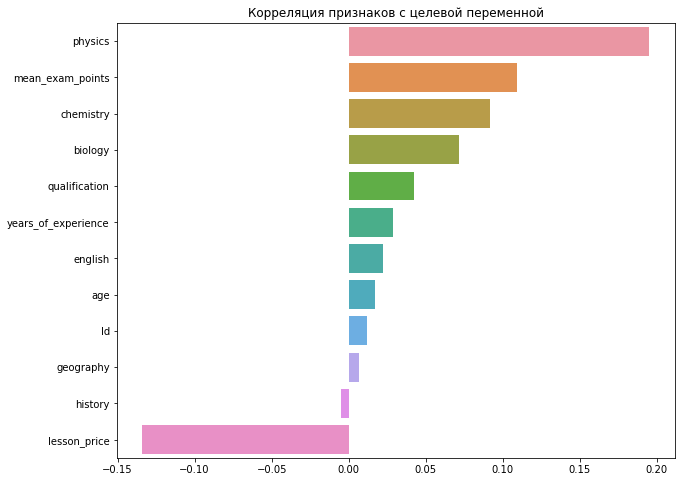

In [16]:
target_corr = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)

plt.title('Корреляция признаков с целевой переменной')
target_corr

### Подготовка данных

In [17]:
train_target = train_df['choose']
train_data = train_df.drop(['Id', 'choose'], axis=1)

In [18]:
x_train, y_train, x_test, y_test = train_test_split(train_data.values, train_target.values, test_size=0.3)

### Подбор парметров

In [19]:
 p = {'k': [1,3,5]}

In [30]:
%%time
# пока отключим, здесь было много прогонов с целью найти лучшие данные
#cv(x_train, y_train, x_test, y_test, knn, p, roc_auc)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 22.6 µs


### Загрузка тестовых данных и сохранение предсказаний

In [25]:
test_df = pd.read_csv('classification_test.csv')

In [26]:
test_df.shape

(10000, 12)

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [28]:
test_df = test_df.drop(['Id'], axis=1)

In [29]:
test_df.head()

age  years_of_experience  lesson_price  qualification  physics  chemistry  \
0  32.0                  2.0        2700.0            3.0      0.0        0.0   
1  35.0                  6.0        1800.0            2.0      1.0        1.0   
2  44.0                  2.0        1200.0            1.0      0.0        0.0   
3  44.0                  4.0        2950.0            3.0      1.0        0.0   
4  38.0                  3.0        1400.0            2.0      1.0        0.0   

   biology  english  geography  history  mean_exam_points  
0      0.0      0.0        0.0      0.0              90.0  
1      0.0      0.0        0.0      0.0              71.0  
2      0.0      0.0        0.0      0.0              45.0  
3      0.0      0.0        0.0      0.0              92.0  
4      0.0      0.0        0.0      0.0              58.0

In [37]:
train_X = normalize(train_data.values)
train_y = train_target.values

In [38]:
test_X = normalize(test_df.values)

In [39]:
proba, predictions = knn(train_X, train_y, test_X, k=15)

X [-1.73371969  0.00807395  1.90046712  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.90506341]
d (0.1174767978159494, 0)
d (0.3364914719752435, 0)
d (0.3590406132583706, 0)
d (0.4134859548679257, 0)
d (0.4229406598505204, 0)
d (0.43169821612615816, 0)
d (0.448304123968396, 0)
d (0.4597111702516544, 0)
d (0.4715799561210684, 0)
d (0.54687049102904, 0)
d (0.5687204154993073, 0)
d (0.6219904102361148, 0)
d (0.637218255680814, 0)
d (0.6605641655930216, 0)
d (0.694766512941417, 0)
X [-1.36019396  2.26652127  0.19020064  0.37702436  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.43004699857364115, 1)
d (0.8595514222651004, 0)
d (1.2562192734440965, 0)
d (1.2576757532944431, 0)
d (1.2676107616212875, 0)
d (1.292225729028737, 0)
d (1.293790021829241, 0)
d (1.3302667366804306, 0)
d (1.342695849959491, 0)
d (1.3507389354649397, 1)
d (1.3937611509206937, 1)
d (1.4140606025765448, 0)
d (1.500755925042239, 1)
d (1.

X [-0.11510818 -1.12114971 -0.28487339 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.70599812]
d (0.26995720428787323, 0)
d (0.6395157489560425, 0)
d (0.6395157489560425, 0)
d (0.7988777350876891, 0)
d (0.8669725333894783, 0)
d (0.9504922500625761, 0)
d (1.047126723399947, 0)
d (1.0723175060817216, 0)
d (1.1225216791463017, 0)
d (1.1469647958609535, 0)
d (1.1686720151681882, 0)
d (1.174867855555139, 1)
d (1.2271478176594333, 0)
d (1.2653215294103175, 0)
d (1.2697750374146983, 0)
X [-0.73765107  0.57268578  1.90046712  1.64348174  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.97875855]
d (0.13335898395387444, 0)
d (0.2640701849098176, 0)
d (0.3983130949249995, 0)
d (0.44883971224422453, 0)
d (0.518112216990582, 0)
d (0.6222572145357259, 1)
d (0.6712373759577023, 0)
d (0.6766727653578455, 0)
d (0.6826843958553904, 0)
d (0.7017840776365984, 0)
d (0.7270540225635564, 0)
d (0.8235714446267871, 0)
d (0.8306382865280453, 0

X [ 0.38292613 -1.12114971 -0.37988819  0.37702436 -0.76981185  2.60890806
  2.76325507  4.4054697  -0.17343093 -0.12382046 -0.82165652]
d (1.4533807332948434, 1)
d (2.1578056746189986, 0)
d (2.6737290928547717, 0)
d (3.169904199834573, 0)
d (3.1720307132537564, 0)
d (3.2099952829941736, 0)
d (3.283888693079415, 0)
d (3.300112180433022, 0)
d (3.3166322734838585, 0)
d (3.3507995370437444, 0)
d (3.364047305469617, 0)
d (3.3731462614882965, 0)
d (3.3821305025890873, 0)
d (3.3871813386488214, 0)
d (3.3967473475051797, 0)
X [ 0.75645186  0.00807395 -0.18985858 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.6947383156984844, 0)
d (0.7207129079702129, 0)
d (0.8528487437229855, 0)
d (0.857551680976786, 1)
d (0.8597901912126831, 0)
d (0.8656842368131734, 1)
d (0.8850696115379237, 0)
d (0.939226811860048, 1)
d (0.9487727153979999, 0)
d (0.9605350185668272, 0)
d (1.0189622172768065, 0)
d (1.023667834519713, 1)
d (1.0710458582237237, 0)
d (1.

X [-0.86215965 -0.55653788  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.06941930203898691, 0)
d (0.15529420883914838, 0)
d (0.2269815357625847, 0)
d (0.29687978431008943, 0)
d (0.39780321486910825, 0)
d (0.4871344914936449, 0)
d (0.5049142035960615, 0)
d (0.5119151813858729, 0)
d (0.5309610317348078, 0)
d (0.5505419776422191, 0)
d (0.5560511745348952, 0)
d (0.5603090397473393, 0)
d (0.5634810953281123, 0)
d (0.5710616614159153, 0)
d (0.5748397774334703, 0)
X [-1.73371969  1.70190944  0.57025986 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.43116075]
d (1.046350549402901, 0)
d (1.3441293397519987, 0)
d (1.8191052532000906, 0)
d (1.8675826824498094, 0)
d (2.0067384953679177, 0)
d (2.0749474119046267, 0)
d (2.0985570265063886, 0)
d (2.1015391020142293, 0)
d (2.13173347741637, 1)
d (2.1623046576024834, 0)
d (2.1854644393162954, 0)
d (2.2001930979256574, 0)
d (2.212723585201486, 0

X [ 0.25841755 -1.12114971 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -0.08470519]
d (0.43925730883166264, 0)
d (0.47697640866079055, 0)
d (0.5927100002038691, 0)
d (0.7737461448146001, 0)
d (0.8688565147518975, 0)
d (0.8880810673638723, 0)
d (0.9912920175594852, 0)
d (1.0895726096723872, 0)
d (1.1244985656182827, 1)
d (1.1415014446341545, 0)
d (1.1593175182675366, 0)
d (1.1659577979392244, 1)
d (1.2306689516843354, 0)
d (1.2457510073223987, 0)
d (1.2466346223868383, 0)
X [ 0.13390898  0.57268578 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.19235413091334597, 0)
d (0.21856860067434103, 0)
d (0.22815093711014134, 0)
d (0.27479997161190917, 0)
d (0.2805604245111724, 0)
d (0.2979371291275129, 0)
d (0.36057140662645826, 1)
d (0.36095907569341157, 0)
d (0.3686097400567109, 0)
d (0.370719031845996, 0)
d (0.37460748554021356, 1)
d (0.3996005663448306, 0)
d (0.40867322777

X [ 0.63194329 -1.12114971 -0.37988819  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.11391749932267789, 0)
d (0.11391749932267789, 0)
d (0.17396789150795733, 0)
d (0.20559136568591918, 0)
d (0.22944591765816386, 0)
d (0.2456230320199786, 0)
d (0.2593813231239534, 0)
d (0.2659103107141259, 1)
d (0.32702737387502795, 0)
d (0.32702737387502795, 0)
d (0.35356720362285216, 0)
d (0.3748046067648397, 0)
d (0.38058301812902307, 0)
d (0.4552255311545612, 0)
d (0.512619220513964, 0)
X [-0.11510818  1.70190944  0.57025986  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.3507864035632051, 0)
d (0.4799139400316434, 0)
d (0.5242289044646234, 0)
d (0.5767567782356343, 0)
d (0.5780440452759711, 0)
d (0.5923410487565226, 0)
d (0.6008199135814442, 0)
d (0.629147930298403, 0)
d (0.6835956323964198, 0)
d (0.7113386445311238, 0)
d (0.7557985604562091, 0)
d (0.7640943064776853, 0)
d (0.766963819536

X [-0.98666822  1.13729761  0.57025986 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.6440867221737652, 0)
d (0.7155333436389762, 0)
d (0.7503175206576229, 0)
d (0.8112347391385772, 0)
d (0.8411718581675711, 0)
d (0.8879195527855578, 0)
d (0.8997802710045948, 0)
d (0.910864904847012, 0)
d (0.9161468931033726, 0)
d (0.9638996979173817, 0)
d (0.9982163233173623, 0)
d (1.0485579416782396, 0)
d (1.066444300923895, 1)
d (1.066782050333053, 0)
d (1.0872834407703953, 0)
X [ 2.00153764e+00 -1.12114971e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  3.57465614e-01]
d (0.40535262214745316, 0)
d (0.41629356718114, 0)
d (0.44367682933612557, 0)
d (0.5306731791417086, 0)
d (0.5385034222662802, 0)
d (0.5492412209428553, 0)
d (0.6088140274536811, 0)
d (0.6277826874879202, 1)
d (0.6401452781182092, 1)
d (0.6567321269431335, 0)
d (0.6872874260183485, 0)
d (0.698

X [ 0.25841755 -1.12114971 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -1.33752245]
d (0.5518520407540707, 0)
d (0.5782928218432472, 0)
d (0.7358205197218548, 0)
d (0.7473220033396447, 0)
d (0.7864335911762652, 0)
d (1.1325869938546145, 1)
d (1.2022552823008088, 0)
d (1.2138788147542388, 0)
d (1.2414236120564377, 0)
d (1.2965893860211972, 0)
d (1.3135340110955729, 0)
d (1.3383316606747087, 1)
d (1.3424922988200698, 0)
d (1.3681973493429125, 0)
d (1.4935991727819475, 0)
X [ 7.56451863e-01  5.72685780e-01  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -8.21656519e-01]
d (0.340536701149462, 0)
d (0.4322248549827561, 0)
d (0.44924115704187334, 0)
d (0.46222055335952955, 0)
d (0.475805521350138, 0)
d (0.5016952723702424, 0)
d (0.5122534576616647, 0)
d (0.5125249113520061, 0)
d (0.5247002870578219, 0)
d (0.5517486760476534, 0)
d (0.5679312830190987, 0)
d (0.

X [ 0.75645186  0.57268578 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.11219707685379886, 0)
d (0.2831582609309868, 0)
d (0.28598910601309685, 0)
d (0.3487476294234801, 0)
d (0.367893803798385, 0)
d (0.3980049956647661, 0)
d (0.4037224551892742, 0)
d (0.48600804995947844, 0)
d (0.5074112151788561, 0)
d (0.5178353990517793, 0)
d (0.521875244488387, 1)
d (0.5542317690526561, 1)
d (0.5622393137608395, 0)
d (0.5667313270926065, 0)
d (0.5772870152625023, 0)
X [-0.61314249 -1.12114971 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.11268470604884562, 0)
d (0.2424572357711559, 0)
d (0.2424572357711559, 0)
d (0.25909611846435077, 0)
d (0.26302071802402954, 1)
d (0.2747593639958177, 0)
d (0.2826534013276759, 0)
d (0.2856167241404816, 0)
d (0.28787744381914443, 1)
d (0.28960531707492854, 0)
d (0.2911989003730718, 0)
d (0.2992664606783859, 0)
d (0.3149272938163

X [-0.98666822  1.13729761 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -0.30579059]
d (0.7916154821443178, 0)
d (0.7978926444276225, 0)
d (0.9735912966388924, 1)
d (1.016043946268121, 0)
d (1.194877589615176, 0)
d (1.2028030302901602, 0)
d (1.2521832213001631, 1)
d (1.296164147847611, 0)
d (1.3293944688636354, 0)
d (1.3706641284096621, 0)
d (1.3824347619119493, 0)
d (1.4147522539069342, 0)
d (1.4167936128527963, 1)
d (1.4698656854298922, 0)
d (1.4710849905343386, 0)
X [-0.36412533  0.57268578 -0.18985858 -0.88943302 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -2.14816892]
d (0.7007160982085634, 0)
d (0.7490045552826499, 0)
d (0.7567615611823373, 0)
d (0.8377330651064504, 0)
d (0.8439642449784358, 0)
d (0.9047596899429264, 0)
d (1.1260480695218134, 0)
d (1.1628821754676808, 0)
d (1.1734849942657142, 0)
d (1.281363173491968, 0)
d (1.3252946209688623, 0)
d (1.343526340405489, 0)
d (1.369660764878513, 0)
d (1

X [ 0.63194329 -0.55653788  0.85530427  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.4124449205940092, 0)
d (0.5456978662954053, 0)
d (0.5843732883958376, 0)
d (0.6005259791800555, 0)
d (0.6105277852540032, 0)
d (0.6258269702796112, 1)
d (0.6978166514235704, 0)
d (0.7022302073163613, 0)
d (0.7042708828594894, 0)
d (0.7399804238744369, 0)
d (0.7518336981603948, 0)
d (0.7821177497828192, 0)
d (0.8603844023396946, 0)
d (0.8833151476264037, 0)
d (0.888585898896411, 0)
X [-0.23961676 -1.12114971 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.14586792899724477, 0)
d (0.15578668116411645, 0)
d (0.15578668116411645, 0)
d (0.16991020115470604, 0)
d (0.17000181537337783, 0)
d (0.1786387860199934, 0)
d (0.20410347191272993, 1)
d (0.2096622075639866, 0)
d (0.22061462180147776, 0)
d (0.23736225839783104, 0)
d (0.24578224057611045, 0)
d (0.25157178589240803, 0)
d (0.2517555665

X [-1.48470253e+00  8.07394917e-03  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -1.04274192e+00]
d (0.31678553789398073, 0)
d (0.3392441650454016, 0)
d (0.4949908943933681, 0)
d (0.49660995354607235, 0)
d (0.522759664687805, 0)
d (0.619599693395385, 0)
d (0.6211395267855473, 0)
d (0.7264699271999713, 0)
d (0.7516149556384657, 0)
d (0.7639436829805684, 0)
d (0.7742112684524889, 0)
d (0.7842395644199281, 0)
d (0.7844237565643809, 0)
d (0.7856218374361965, 0)
d (0.8018156465567131, 1)
X [-0.36412533 -1.12114971  0.85530427  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.11693195319103832, 1)
d (0.11976436015420631, 0)
d (0.1758806498875376, 0)
d (0.19923233652286712, 0)
d (0.19987907447145717, 0)
d (0.2032325144596325, 0)
d (0.2864434169304072, 0)
d (0.28868338433521257, 0)
d (0.35321681729743043, 0)
d (0.3735579195024237, 0)
d (0.37382793055076546, 0

X [ 0.63194329 -1.12114971 -0.37988819 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.14816892]
d (0.21006761386314812, 0)
d (0.3830743467330822, 0)
d (0.45630111584289773, 0)
d (0.5881014257006602, 0)
d (0.625617072137851, 0)
d (0.6913738319142726, 0)
d (0.7136040776302592, 0)
d (0.7209787064023163, 0)
d (0.7757650558076268, 0)
d (0.924867836053781, 0)
d (0.9581161730663397, 0)
d (1.0204171917118496, 0)
d (1.0225003690643215, 0)
d (1.0360276661713386, 0)
d (1.0409519594082803, 0)
X [ 0.38292613 -1.12114971 -0.66493261 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.1592051603754639, 0)
d (0.1733053249804812, 0)
d (0.19493996844223516, 0)
d (0.26557049213624917, 0)
d (0.2726445680838575, 0)
d (0.34939951078933607, 0)
d (0.3578587378248441, 0)
d (0.3975591390979812, 0)
d (0.403766831376824, 1)
d (0.41166266770741844, 0)
d (0.4201240569548177, 0)
d (0.4237114061297461, 0)
d (0.4344761127991765

X [-0.86215965  0.00807395 -0.85496222  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.3947695091522841, 1)
d (0.4356175296284381, 0)
d (0.462860154554321, 0)
d (0.4875563689205775, 0)
d (0.6175238059959383, 0)
d (0.6199211585187553, 0)
d (0.6236404779658207, 0)
d (0.6402729816123158, 0)
d (0.6426744266596938, 0)
d (0.666907771143784, 0)
d (0.6760607071328423, 0)
d (0.6801032157120662, 1)
d (0.6818122061700003, 1)
d (0.6836122418141604, 0)
d (0.686366142518376, 1)
X [ 0.75645186 -0.55653788 -0.474903    0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.3424498686467697, 0)
d (0.5429638469493469, 0)
d (0.5763397209182404, 0)
d (0.5925569597007838, 1)
d (0.5984119705962259, 0)
d (0.6275164322447864, 0)
d (0.648964374770803, 0)
d (0.6622430053377996, 0)
d (0.7289741663614071, 0)
d (0.7532716351970477, 0)
d (0.7716506911460868, 1)
d (0.7808478185467805, 0)
d (0.8053708580192258, 0)
d 

X [-0.36412533  0.00807395 -0.85496222  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.2972281553682091, 0)
d (0.4041307167200301, 0)
d (0.6322121192750847, 0)
d (0.6682490321778625, 0)
d (0.6906096476920669, 0)
d (0.7074003470022266, 0)
d (0.7554583563461269, 0)
d (0.7569032624182747, 1)
d (0.8286828808372796, 0)
d (0.8527297354797416, 0)
d (0.9098416205816934, 0)
d (0.9113350516658774, 0)
d (0.9432640996407788, 0)
d (0.9516781902279746, 0)
d (0.960455929115807, 0)
X [-0.86215965 -0.55653788 -0.18985858  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.1572258787325861, 0)
d (0.2048528757585919, 0)
d (0.2048528757585919, 0)
d (0.271071055073568, 0)
d (0.3171986538932913, 0)
d (0.3171986538932913, 0)
d (0.33020680980791434, 0)
d (0.33991552748695947, 0)
d (0.34940062005110945, 0)
d (0.36428921671304326, 0)
d (0.37394809242541555, 0)
d (0.3929857631618152, 0)
d (0.396647298133644,

X [-2.85429689 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.5151735220462836, 0)
d (0.5941636377096475, 0)
d (0.7312282135829821, 0)
d (0.7920804626910865, 0)
d (0.7958721640915332, 0)
d (0.8252342652938202, 0)
d (0.8878337317889511, 1)
d (0.9099409773726227, 0)
d (0.94183857023759, 0)
d (0.9842489387510932, 0)
d (1.0080615890502573, 0)
d (1.1303701090976601, 0)
d (1.1422867530224996, 0)
d (1.1932649829027917, 0)
d (1.1945977598949926, 0)
X [ 1.50350333  0.00807395 -0.09484378  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.28340890271832675, 1)
d (0.32143548959627266, 0)
d (0.3675712930026129, 0)
d (0.3933760864886367, 0)
d (0.40478369429718136, 0)
d (0.4577096200001198, 0)
d (0.5168072578416991, 1)
d (0.5416273141503128, 0)
d (0.5567294194570173, 1)
d (0.5818936260618363, 0)
d (0.6173867615888615, 1)
d (0.6252934226313829, 1)
d (0.6334285112716646, 

X [ 1.1299776  -0.55653788 -0.474903    0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.6231379383667263, 0)
d (0.6556273709322664, 0)
d (0.657744856864075, 0)
d (0.6778141694346943, 0)
d (0.704385304518409, 0)
d (0.7489271526487413, 0)
d (0.855519586715151, 1)
d (0.8624702665301852, 0)
d (0.8915570819566017, 0)
d (0.9133769456926134, 0)
d (0.9205054122251624, 0)
d (0.9466475655304502, 0)
d (0.9537317549952342, 0)
d (0.9656599125569356, 0)
d (0.987426852893701, 0)
X [ 0.13390898 -1.12114971 -0.37988819 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.77969325]
d (0.8748555754856275, 0)
d (0.8939807885604271, 0)
d (0.9329311115646244, 0)
d (0.9536772952167941, 0)
d (0.965424623100204, 0)
d (1.0287410201847802, 0)
d (1.0430161068610306, 0)
d (1.0546314407291049, 0)
d (1.055653862993987, 0)
d (1.1338184600152144, 0)
d (1.1807846686557102, 0)
d (1.2346787988048797, 0)
d (1.2592192638786501, 1)
d (1

X [ 0.25841755 -1.12114971 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.11612792865123103, 0)
d (0.12380842629116494, 0)
d (0.14553561162939957, 0)
d (0.19339175784552262, 0)
d (0.19924496074040557, 0)
d (0.20127339410377224, 0)
d (0.2013815503091222, 0)
d (0.25466464139636774, 0)
d (0.25466464139636774, 0)
d (0.2639497016516756, 0)
d (0.2869851509202443, 0)
d (0.2986867959177622, 0)
d (0.31101120962501694, 0)
d (0.3162583242645292, 0)
d (0.3162583242645292, 0)
X [-2.35626258 -1.12114971 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.17594927840788685, 1)
d (0.2853626314511777, 0)
d (0.47939503699183694, 1)
d (0.5049003893388064, 0)
d (0.5053048877202514, 0)
d (0.5604176138547681, 0)
d (0.5775663075099371, 1)
d (0.5895502721516951, 0)
d (0.6268617407418956, 1)
d (0.6282851594574604, 0)
d (0.7099128827011812, 0)
d (0.7508004176275647, 0)
d (0.78738090

X [ 0.88096044  0.00807395 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.14583038026375836, 0)
d (0.1847274696663285, 0)
d (0.19916286125995802, 0)
d (0.23111174774786566, 0)
d (0.27700283770660794, 0)
d (0.28064039205570546, 0)
d (0.3098891076937655, 0)
d (0.3309947615844861, 0)
d (0.3455854075523167, 0)
d (0.3572058642612446, 0)
d (0.39493905879415114, 0)
d (0.39717350512154287, 0)
d (0.4119753084870861, 0)
d (0.4208806366247745, 0)
d (0.4208806366247745, 0)
X [-1.23568538 -0.55653788  0.85530427  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.1605126985826337, 0)
d (0.3507605803275965, 0)
d (0.392128954843899, 0)
d (0.39318299366235004, 0)
d (0.3935690621933496, 0)
d (0.4352902576565842, 0)
d (0.49374685788093325, 0)
d (0.5346899855462055, 0)
d (0.5630896492323337, 0)
d (0.5653958352798364, 0)
d (0.5767294571314657, 0)
d (0.578974424835991, 0)
d (0.580368599810

X [ 0.50743471 -1.12114971  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.0697406593012572, 0)
d (0.145302290572407, 0)
d (0.1510344138665007, 0)
d (0.16267090952529623, 0)
d (0.20541240727709892, 0)
d (0.2174088767947247, 0)
d (0.2283505428571929, 0)
d (0.2283505428571929, 0)
d (0.25858589041676366, 0)
d (0.268996986672371, 0)
d (0.269071120041389, 0)
d (0.28305561711141003, 0)
d (0.29081011790926614, 0)
d (0.2913083031085791, 0)
d (0.31902676065911884, 0)
X [-0.61314249 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.07087937752657004, 0)
d (0.12934993125755886, 0)
d (0.13530067268724005, 0)
d (0.15599450666991058, 0)
d (0.15599450666991058, 0)
d (0.16936319409781814, 0)
d (0.17958749235706306, 0)
d (0.19395017912405854, 0)
d (0.2044923793607361, 0)
d (0.2223061281464566, 0)
d (0.22846170948763114, 0)
d (0.23873961464123641, 0)
d (0.255653

X [ 0.50743471 -1.12114971 -0.474903    0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.12927311291248766, 0)
d (0.15630979643028894, 1)
d (0.17417414874853365, 0)
d (0.17943226760202088, 0)
d (0.21330308272136878, 0)
d (0.22248777653475454, 0)
d (0.29847073575767996, 0)
d (0.3035903178693383, 0)
d (0.3111366176484606, 0)
d (0.3111366176484606, 0)
d (0.361361146596723, 0)
d (0.39259068973183187, 0)
d (0.3952538946547339, 0)
d (0.40724841314736737, 0)
d (0.4929981459233716, 0)
X [-0.86215965 -0.55653788  0.85530427  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.1527922007043839, 0)
d (0.15378295356298052, 0)
d (0.2940930169143933, 0)
d (0.33108633716297675, 0)
d (0.42613547641389365, 0)
d (0.4703421674078717, 0)
d (0.48615335191038145, 0)
d (0.5511110192085169, 0)
d (0.5776901900396936, 0)
d (0.5881819393908926, 0)
d (0.5954956085562408, 0)
d (0.5973567701885821, 0)
d (0.6043635

X [ 1.50350333  0.00807395 -1.52006585 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.6214527149228448, 1)
d (0.6340334936272742, 0)
d (0.6683226170610275, 0)
d (0.6846495485924683, 0)
d (0.7204324011472163, 0)
d (0.7390229638904741, 0)
d (0.7400453560983905, 0)
d (0.749820019027231, 0)
d (0.7750641683809946, 0)
d (0.7792715899910938, 0)
d (0.8072064724627023, 1)
d (0.8218087266019646, 0)
d (0.8222284479786639, 0)
d (0.8273267862528336, 0)
d (0.834291929418901, 0)
X [-2.60527973  0.00807395 -1.14000663 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.8041871550099191, 0)
d (1.1477380330542835, 1)
d (1.1519031067824148, 0)
d (1.2429683959001347, 1)
d (1.2663954611465036, 1)
d (1.3012581209503675, 0)
d (1.3283690679260467, 1)
d (1.3469187756758834, 0)
d (1.362904821815933, 0)
d (1.3895212941690256, 1)
d (1.6232496267784011, 0)
d (1.6909947097649738, 0)
d (1.748000436779431, 0)
d 

X [-0.11510818  0.57268578  1.71043751  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.4865263311814298, 0)
d (0.4979459798216714, 0)
d (0.5299082252999934, 0)
d (0.5336065014746681, 0)
d (0.5353809459558374, 0)
d (0.5376859687363167, 0)
d (0.5461728788415721, 0)
d (0.5475660881921999, 0)
d (0.5527587913084838, 0)
d (0.558187801688554, 0)
d (0.5661993419087896, 0)
d (0.573986497326258, 0)
d (0.5894998442864435, 0)
d (0.5894998442864435, 0)
d (0.5908988501709627, 0)
X [ 0.25841755  0.57268578  1.52040791  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.3452189969663212, 0)
d (0.664205085817066, 0)
d (0.7420810205265278, 0)
d (0.8172920637618863, 0)
d (0.8497523787430421, 0)
d (0.851400224542293, 0)
d (0.8555691310688203, 0)
d (0.9552022192422722, 0)
d (0.9624861224976647, 0)
d (0.9689203137162766, 0)
d (0.9787476828779181, 0)
d (0.994205893886877, 0)
d (1.0174388129729255, 0)
d (

X [-0.36412533  0.00807395 -1.04499183 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.2594808075881826, 1)
d (0.5447079672079843, 0)
d (0.5909912068415598, 0)
d (0.5952235319531407, 0)
d (0.6131654978217627, 0)
d (0.614782370137134, 1)
d (0.6359685451946813, 0)
d (0.6551456622596761, 0)
d (0.6821536660203925, 1)
d (0.7343585896499192, 0)
d (0.7378206642777815, 0)
d (0.7502847899940167, 0)
d (0.7671922389876331, 0)
d (0.7863166671670897, 0)
d (0.8266964486784879, 0)
X [-1.48470253 -1.12114971 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.11246774696220936, 0)
d (0.15621309543975156, 0)
d (0.22739817727016212, 0)
d (0.2634684698564367, 1)
d (0.2641088949397689, 0)
d (0.27197365952550406, 0)
d (0.27197365952550406, 0)
d (0.2746208529119194, 0)
d (0.2856516278154612, 0)
d (0.2883663948534798, 0)
d (0.3107627214610377, 0)
d (0.3133318789736708, 0)
d (0.330912488910133

X [-1.1111768  -0.55653788 -0.28487339  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.22538340378962038, 0)
d (0.23657398757786613, 0)
d (0.25374822008176007, 0)
d (0.2959683335226124, 0)
d (0.2959683335226124, 0)
d (0.31494327358244006, 0)
d (0.31494327358244006, 0)
d (0.32672966755293625, 0)
d (0.39922580586442, 0)
d (0.4047950424759234, 0)
d (0.4108228223864369, 0)
d (0.4225535030272527, 0)
d (0.42812658238050044, 0)
d (0.43432016099537524, 0)
d (0.4460112560320933, 0)
X [ 1.50350333 -0.55653788 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.10783234733345765, 0)
d (0.2687304545984185, 1)
d (0.3435963972158112, 0)
d (0.3491181074926991, 1)
d (0.35548879969364117, 0)
d (0.3633840767483094, 1)
d (0.38573392188635064, 0)
d (0.4863969250448139, 0)
d (0.49408335668283626, 0)
d (0.49549243249983005, 0)
d (0.5237492423338704, 0)
d (0.5504689758892374, 0)
d (0.56097624

X [ 0.75645186 -1.12114971  0.95031908  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.2747034482823095, 0)
d (0.41882166609488075, 0)
d (0.5588889162449807, 1)
d (0.5669247968425749, 0)
d (0.626833715679832, 0)
d (0.6536282861706184, 0)
d (0.7665676615092145, 0)
d (0.7874787741717262, 0)
d (0.8497385335679972, 0)
d (0.8578215909988962, 0)
d (0.9329002157298895, 1)
d (0.9372375322033255, 0)
d (0.9998950700502159, 1)
d (1.0307317747273843, 0)
d (1.0442989654998551, 0)
X [ 0.75645186 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.04332025692361199, 0)
d (0.14508665932417078, 0)
d (0.14508665932417078, 0)
d (0.164142364125707, 0)
d (0.16932046573627613, 0)
d (0.1807908804415238, 0)
d (0.18625312544289113, 0)
d (0.2022344444403704, 0)
d (0.22757389427219718, 0)
d (0.23151149616582972, 0)
d (0.2369914990970992, 0)
d (0.2432904629657792, 0)
d (0.2476793973939

X [ 0.0094004   1.13729761  1.52040791  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.97875855]
d (0.21099478182036968, 0)
d (0.24849107030371526, 0)
d (0.26153876700026707, 0)
d (0.286908972378158, 0)
d (0.3202321172721639, 1)
d (0.35266677802612634, 0)
d (0.3647462834716073, 0)
d (0.3650078810152648, 0)
d (0.3948139915160643, 0)
d (0.4097420045849689, 0)
d (0.43054185737062783, 0)
d (0.4442773681531249, 0)
d (0.4864379474562938, 0)
d (0.4916712855919936, 0)
d (0.49655907031100754, 0)
X [-0.73765107  0.00807395 -0.75994741 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.4582945210319559, 0)
d (0.4612627189680578, 0)
d (0.5563217067242974, 0)
d (0.5620366667999257, 0)
d (0.5712673966341253, 0)
d (0.6383264387415826, 0)
d (0.6441278915023241, 0)
d (0.6641474509370618, 0)
d (0.6992439615498726, 0)
d (0.7058010923908636, 0)
d (0.7180339227545292, 0)
d (0.7275457653388946, 0)
d (0.73773466434826

X [ 1.25448617  2.26652127  1.4253931   1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (0.1972151360473553, 0)
d (0.24844874477110815, 0)
d (0.29053171507279707, 0)
d (0.45960023906261555, 0)
d (0.49816789218839425, 0)
d (0.5030213415522338, 0)
d (0.5180345028757669, 0)
d (0.5259759792818073, 0)
d (0.5308194334959774, 0)
d (0.5368339537758772, 0)
d (0.6279329777554551, 0)
d (0.63425307855904, 1)
d (0.6372154894529858, 0)
d (0.642279567161764, 0)
d (0.6846347127685168, 0)
X [-0.23961676  0.57268578  0.19020064 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.07447379]
d (0.19722785354085334, 0)
d (0.35655482757625034, 0)
d (0.4028956853240642, 0)
d (0.4785387564157072, 0)
d (0.5598455235735899, 0)
d (0.5746073447613322, 0)
d (0.5928687162440892, 0)
d (0.5939453226137044, 0)
d (0.622196255768848, 0)
d (0.6234855747954328, 0)
d (0.6249474736618995, 0)
d (0.6323342489872857, 0)
d (0.6434306521558235,

X [ 0.0094004   1.13729761 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.3696533412262251, 0)
d (0.4787174048648773, 0)
d (0.5590544163251884, 0)
d (0.5779399740141969, 0)
d (0.5796154368860605, 0)
d (0.5879458129093648, 0)
d (0.592927850554505, 0)
d (0.6011810094507561, 0)
d (0.6861906619708232, 0)
d (0.6934573891842659, 0)
d (0.7081844954448175, 0)
d (0.7148441592059147, 0)
d (0.7229885240546087, 0)
d (0.7243412713472469, 0)
d (0.7399751784677233, 0)
X [-1.73371969 -1.12114971 -0.474903    0.37702436  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.5295049985226635, 0)
d (1.0629734624397131, 0)
d (1.3705439091250693, 0)
d (1.4012700254792207, 1)
d (1.443470395300107, 1)
d (1.4487675018430466, 0)
d (1.4510522349040744, 0)
d (1.4784717803146223, 1)
d (1.496350609250275, 0)
d (1.4968586725274573, 0)
d (1.4971188620662164, 0)
d (1.5150777274892389, 0)
d (1.5157491407884247, 1)
d

X [-0.11510818 -1.12114971 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.04209826826674633, 0)
d (0.04209826826674633, 0)
d (0.1611212983641885, 0)
d (0.169475112508349, 0)
d (0.17809035517975905, 0)
d (0.19123436192682827, 0)
d (0.2010050646601303, 0)
d (0.2010050646601303, 0)
d (0.2244166101289313, 0)
d (0.25837925881534984, 0)
d (0.2684494283537761, 0)
d (0.2684494283537761, 0)
d (0.28344388477366894, 0)
d (0.30927557905401826, 0)
d (0.31370866225266075, 0)
X [ 0.63194329  1.13729761 -1.33003624  0.37702436 -0.76981185  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (1.064287600517807, 0)
d (1.2034427422959555, 0)
d (1.466678623831373, 0)
d (1.5757956582964214, 0)
d (1.6238386970281005, 0)
d (1.6250714545276626, 1)
d (1.6282085939946813, 0)
d (1.713438226944924, 0)
d (1.7516498333642412, 0)
d (1.7661182929186778, 0)
d (1.9163637213218623, 1)
d (1.9556802471584187, 0)
d (1.969328350971147

X [-0.36412533 -0.55653788 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.1939152194056431, 1)
d (0.26681099131378416, 0)
d (0.28255996899795144, 1)
d (0.29088868434789367, 0)
d (0.3008515467597212, 1)
d (0.34550311613024215, 0)
d (0.3628746001640826, 0)
d (0.3676010045985083, 1)
d (0.43802777349360256, 0)
d (0.4395493685042292, 1)
d (0.4644429105904343, 0)
d (0.46981813547345497, 0)
d (0.47771698960781417, 0)
d (0.4976045685883213, 1)
d (0.5231910962655676, 1)
X [ 0.50743471  1.70190944  0.76028947  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.11387961682761369, 0)
d (0.2066935310378185, 1)
d (0.35251281273382096, 1)
d (0.36917279039598305, 1)
d (0.38814408308540377, 0)
d (0.4711562475211115, 1)
d (0.49998262538152305, 0)
d (0.5001371151951213, 0)
d (0.5480603167699893, 0)
d (0.6259915302245842, 0)
d (0.6771869407919408, 1)
d (0.6838341381471037, 0)
d (0.6839809

X [ 0.88096044  2.26652127  2.18551154  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.2021374004823927, 0)
d (0.4583986496293725, 0)
d (0.46547799256255784, 0)
d (0.47191487930361026, 0)
d (0.48575667028049635, 0)
d (0.5097193281585785, 0)
d (0.5759312328359332, 0)
d (0.5826297659248323, 0)
d (0.5962691118876333, 0)
d (0.6032603816956433, 0)
d (0.6371496772529573, 0)
d (0.6407626119704593, 0)
d (0.6453525254539706, 0)
d (0.6514495072719414, 0)
d (0.6616068547201575, 0)
X [-0.98666822  1.13729761  0.57025986  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.15918482711232743, 0)
d (0.32206740284693974, 0)
d (0.3729508071591283, 0)
d (0.4824859483293618, 0)
d (0.579972423601542, 0)
d (0.5853779077350448, 0)
d (0.5891761404286754, 0)
d (0.5895426325753547, 0)
d (0.5917157535660789, 0)
d (0.596758938625703, 0)
d (0.609694678617159, 0)
d (0.6302446704181696, 0)
d (0.6313187692892283,

X [ 0.13390898  1.13729761 -1.99513988 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.44309075053228897, 1)
d (0.49668619481321513, 0)
d (0.5220996912719769, 1)
d (0.6617497559669488, 0)
d (0.6763242697521671, 0)
d (0.6846350193182617, 0)
d (0.6897056930588131, 0)
d (0.7041555965805966, 1)
d (0.7124818221073632, 1)
d (0.7299067452863638, 0)
d (0.7468610118219056, 1)
d (0.7926670720546999, 1)
d (0.837399189043104, 0)
d (0.8421230228756865, 1)
d (0.8468603628507956, 0)
X [ 1.87702906 -1.12114971 -0.28487339 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.5833008669559381, 0)
d (0.5900952017282439, 0)
d (1.0444653702369195, 0)
d (1.0958971245469944, 0)
d (1.1114299239069516, 0)
d (1.1597089515354002, 0)
d (1.1734742903896622, 1)
d (1.1930407581071836, 1)
d (1.2422955776265345, 0)
d (1.265056356878986, 0)
d (1.2878392773786425, 0)
d (1.3207017806267423, 1)
d (1.3260563482518635, 1

X [ 1.50350333 -0.55653788 -1.23502144  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.5643813179476783, 0)
d (0.5813333220016845, 1)
d (0.6798451675096461, 0)
d (0.7557289935192038, 0)
d (0.8635627974139125, 1)
d (0.9027531560045852, 1)
d (0.9411823909826588, 1)
d (0.944799716576617, 1)
d (0.9688908031136354, 0)
d (0.991197759738553, 0)
d (0.9992193019606636, 0)
d (1.0074130155973289, 1)
d (1.010191832199352, 0)
d (1.0348740194304256, 0)
d (1.053902400429673, 1)
X [-1.73371969  0.00807395  2.18551154  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.97875855]
d (0.0626819845454449, 0)
d (0.2454885311817461, 0)
d (0.2538635487723677, 0)
d (0.29400399601669125, 0)
d (0.33937114402672647, 0)
d (0.44233464489071894, 0)
d (0.4637622702757261, 0)
d (0.505396258177126, 1)
d (0.6017593928966408, 0)
d (0.6067336788779027, 0)
d (0.6224976014460377, 0)
d (0.6613728866806993, 0)
d (0.6744084578843983, 1)


X [ 1.37899475 -1.12114971  0.85530427  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.9008604535701, 0)
d (0.9502134474151277, 0)
d (0.980599371717824, 0)
d (1.057739465765061, 0)
d (1.2012561786579383, 0)
d (1.2030339596636321, 0)
d (1.3193845164607636, 1)
d (1.364485237810458, 0)
d (1.3880609938146322, 0)
d (1.3898449744508026, 1)
d (1.3933381611291873, 0)
d (1.3942965730350874, 1)
d (1.3969409036994156, 1)
d (1.397629189452134, 1)
d (1.3994961006238893, 0)
X [ 0.13390898  0.57268578 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.2624284863355285, 0)
d (0.29687385030088853, 0)
d (0.35072730078160363, 0)
d (0.4382232969044609, 0)
d (0.44068361350508384, 0)
d (0.445398984600681, 0)
d (0.4680468745124187, 0)
d (0.5049902941377173, 0)
d (0.5058401541181202, 0)
d (0.5124694301692265, 0)
d (0.5586697506141121, 0)
d (0.5592847925038552, 0)
d (0.5981199575722173, 0)
d (

X [ 1.37899475  0.00807395 -0.5699178   0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.2830294157166811, 0)
d (0.314205179113882, 0)
d (0.3625948829073851, 0)
d (0.36353530087381725, 0)
d (0.37164138222259424, 0)
d (0.43102739452586386, 0)
d (0.4626977216248648, 0)
d (0.4655805177811146, 0)
d (0.5141454423660725, 1)
d (0.534459294095917, 0)
d (0.5795205390044165, 0)
d (0.6216505534445068, 0)
d (0.6335405110042948, 0)
d (0.6403618350488419, 0)
d (0.644604811878523, 0)
X [ 0.63194329  1.70190944  0.85530427  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.148843172209564, 1)
d (0.1986131230353238, 0)
d (0.3508565630344936, 0)
d (0.4118535923792167, 0)
d (0.41295835405893094, 1)
d (0.43274928436508237, 0)
d (0.4545856176973866, 0)
d (0.5125794089457135, 1)
d (0.5342870235750917, 0)
d (0.5920225204379105, 0)
d (0.5984894002568067, 1)
d (0.6150652446999033, 1)
d (0.6790257333932542, 

X [ 0.25841755  0.57268578 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.11613790300794612, 0)
d (0.25343861584708727, 0)
d (0.32451506473609637, 0)
d (0.34043474637880716, 0)
d (0.4270239218812726, 0)
d (0.4453850178015674, 0)
d (0.44597659646143495, 0)
d (0.4518346018568689, 0)
d (0.48885779495597115, 0)
d (0.5057299710117683, 0)
d (0.5154125640573963, 0)
d (0.5225268233225955, 0)
d (0.5286075463960319, 0)
d (0.5354557380181574, 0)
d (0.5389894736675809, 0)
X [-0.11510818  0.00807395 -0.66493261  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.07194070267500209, 0)
d (0.11940387255529349, 0)
d (0.11940387255529349, 0)
d (0.18197360645998667, 0)
d (0.37421439880144447, 0)
d (0.3827378398899809, 0)
d (0.41796947922733974, 0)
d (0.4749698385602756, 1)
d (0.49547865028797233, 1)
d (0.5093957168358715, 0)
d (0.5184774797634193, 0)
d (0.5243717185098823, 0)
d (0.556784

X [-0.11510818 -1.12114971 -0.37988819  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.18726146932755927, 0)
d (0.19632026555058812, 1)
d (0.3370628964927753, 1)
d (0.4449270140770582, 0)
d (0.5180837306520335, 0)
d (0.653033289194781, 0)
d (0.7279001867015044, 0)
d (0.7517948082715543, 0)
d (0.7552635097148466, 0)
d (0.7702037342217961, 0)
d (0.7729713715531757, 0)
d (0.7768649248365683, 0)
d (0.8466551073757173, 0)
d (0.8721536921535094, 0)
d (0.8789297603541445, 0)
X [ 1.00546902 -1.12114971 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.70599812]
d (0.13471389505491954, 0)
d (0.14179171286543574, 0)
d (0.16266976476496997, 0)
d (0.17090557188025682, 0)
d (0.17812059236665975, 0)
d (0.17812059236665975, 0)
d (0.19874796290778549, 0)
d (0.19874796290778549, 0)
d (0.20015475854668133, 0)
d (0.272702987741611, 0)
d (0.2788598183647021, 0)
d (0.28799453001658404, 0)
d (0.305340609

X [-1.73371969  1.70190944  1.4253931   0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.313686729089309, 0)
d (0.44542740032803985, 0)
d (0.7538634120762727, 0)
d (0.8203125267460176, 0)
d (0.8246648082776898, 0)
d (0.8527692208729948, 0)
d (0.9953772678733462, 0)
d (1.021589836591311, 0)
d (1.0767525156887652, 0)
d (1.0834788849161654, 0)
d (1.0855293606771197, 0)
d (1.0865796362634588, 0)
d (1.1435943092194545, 0)
d (1.1460701332044811, 0)
d (1.1853343495056659, 0)
X [ 1.00546902 -0.55653788 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.20474293459541848, 0)
d (0.2248346943719812, 0)
d (0.24214321497548102, 0)
d (0.24385085655848585, 0)
d (0.268171069337704, 0)
d (0.2859489934934912, 0)
d (0.289342470195687, 0)
d (0.3270655550520391, 0)
d (0.33103150090620054, 0)
d (0.3453243815023866, 0)
d (0.37661391910643083, 0)
d (0.37839441856789763, 0)
d (0.3854876435955358

X [ 1.50350333  1.70190944  3.04064478  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.591453860205551, 0)
d (0.6145520485424077, 0)
d (0.626271429906281, 0)
d (0.7056397922759537, 0)
d (0.7220638067439378, 0)
d (0.7262209877115537, 0)
d (0.7418248027001628, 0)
d (0.7595807472450969, 0)
d (0.7608884798125444, 0)
d (0.7659317887222277, 0)
d (0.7941374700698708, 0)
d (0.8302747333298458, 0)
d (0.8598613751763847, 0)
d (0.8837986271443151, 0)
d (0.9022880942009958, 0)
X [ 1.25448617  0.00807395 -0.09484378  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.560795851014361, 0)
d (0.5673500303802774, 0)
d (0.7169740445278645, 0)
d (0.8711938168951349, 0)
d (0.9120973118114937, 0)
d (0.949051107493097, 0)
d (0.9733859942447154, 0)
d (1.0040249638205, 0)
d (1.0099177544941502, 0)
d (1.019693828704976, 0)
d (1.0660088935638754, 0)
d (1.0814309843944743, 0)
d (1.1033493497501867, 0)
d (1.1

X [ 0.63194329 -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046  0.94702668]
d (0.3195509614274667, 0)
d (0.5863738942275556, 0)
d (0.6319652875559055, 0)
d (0.8845102860848347, 0)
d (1.053138155822872, 0)
d (1.1012274471748957, 0)
d (1.2604978233922268, 0)
d (1.3343103940735876, 0)
d (1.3907728142760036, 0)
d (1.4767845965110118, 0)
d (1.6627014008378662, 0)
d (1.7299207531208998, 0)
d (1.7325888068198954, 0)
d (1.8145545841383361, 0)
d (1.896781524894392, 0)
X [ 1.1299776  -0.55653788 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.20117979884180548, 0)
d (0.23792371506380394, 0)
d (0.31582129932565034, 0)
d (0.3337945819176399, 0)
d (0.3766752132059574, 0)
d (0.3854325890270441, 1)
d (0.3882402894574031, 0)
d (0.4210164578545154, 0)
d (0.42392133223208917, 0)
d (0.493032578430122, 0)
d (0.5268783813199585, 0)
d (0.570929370138022, 0)
d (0.5952669825610503, 0

X [ 1.50350333  1.13729761 -1.42505105 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.4556820633251679, 0)
d (0.5260927986051722, 0)
d (0.5532484636017002, 1)
d (0.6411166390797487, 0)
d (0.674995509703497, 1)
d (0.6783597941306044, 1)
d (0.711204651691574, 0)
d (0.7188357480937468, 0)
d (0.743243071086685, 1)
d (0.755654467012553, 0)
d (0.783664098924246, 1)
d (0.8013141650877474, 0)
d (0.8049535463749581, 1)
d (0.8084263488623141, 0)
d (0.8181196234563292, 1)
X [-8.62159645e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01  2.60890806e+00 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -1.58400320e-01]
d (0.261354780461238, 1)
d (0.2827671653245444, 0)
d (0.3081274206184784, 0)
d (0.3954233311662907, 0)
d (0.6262330117304691, 0)
d (0.6509240736287324, 0)
d (0.6740816305050271, 0)
d (0.722353342247783, 0)
d (0.7630461945224492, 0)
d (0.7699060523737238, 0)
d (0.7933768655041715, 0)
d (0.8093889

X [ 0.38292613 -1.12114971 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.14453981538331878, 0)
d (0.1528786348287434, 0)
d (0.16409662931357535, 0)
d (0.191504943614352, 0)
d (0.1916847354768748, 0)
d (0.1916847354768748, 0)
d (0.19247579054613778, 0)
d (0.23122127385865743, 0)
d (0.23686711541373845, 0)
d (0.254108936404609, 0)
d (0.254108936404609, 0)
d (0.2569916758541922, 0)
d (0.2684445024761803, 0)
d (0.2810351150297795, 0)
d (0.3014607629100364, 0)
X [ 0.75645186 -0.55653788  0.66527466  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.20145285242241695, 0)
d (0.23858482762654953, 0)
d (0.2578833381500749, 0)
d (0.2849700035875324, 0)
d (0.29326773162116343, 0)
d (0.321040109922166, 0)
d (0.33328281611526817, 0)
d (0.3922061703833301, 0)
d (0.41794883493824014, 0)
d (0.41872102137004336, 0)
d (0.4385889598342844, 0)
d (0.4454402290621797, 0)
d (0.485059501504

X [-0.73765107 -0.55653788  0.76028947  0.37702436  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.605952800350692, 0)
d (0.6258333877982315, 0)
d (0.6954917192331918, 0)
d (0.7583487445826625, 0)
d (0.8107633793056788, 0)
d (0.8127477836199778, 0)
d (0.832112264115152, 0)
d (0.8429316318327886, 0)
d (0.8485434843670749, 0)
d (0.8639533906666775, 1)
d (0.8650207948217735, 1)
d (0.8821174468925023, 0)
d (0.8943210275466419, 0)
d (0.930995960510949, 0)
d (0.9614539431221009, 0)
X [ 0.38292613  0.00807395 -0.28487339  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.1512041287673487, 1)
d (0.15651758520128992, 1)
d (0.1998475025010837, 0)
d (0.20553722642788658, 0)
d (0.3288300361254249, 0)
d (0.366646441817713, 0)
d (0.3821049540384616, 0)
d (0.39026078284494214, 1)
d (0.39132414970410745, 1)
d (0.41321023949912955, 0)
d (0.42818368427457915, 0)
d (0.44797174241063137, 1)
d (0.4843890702947453

X [-0.11510818 -1.12114971  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.1196409315727423, 0)
d (0.22421162964225128, 0)
d (0.2275848483725636, 0)
d (0.28666844772463157, 0)
d (0.29972366091560826, 0)
d (0.3172151787483698, 0)
d (0.3172151787483698, 0)
d (0.33136830259108, 0)
d (0.3401447594140441, 0)
d (0.3401447594140441, 0)
d (0.3533807290877239, 0)
d (0.39204154694734394, 0)
d (0.39313154135571904, 0)
d (0.3961117781062619, 0)
d (0.39878763888175905, 0)
X [ 1.1299776   1.13729761  0.19020064 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.92708352]
d (0.2432252243351778, 0)
d (0.37106037286248883, 0)
d (0.3715694772477237, 0)
d (0.4034650369001462, 0)
d (0.5707370096470179, 0)
d (0.5939739196094445, 0)
d (0.717688043994114, 0)
d (0.7196624886142242, 0)
d (0.7378525084670615, 0)
d (0.7662042929238757, 0)
d (0.76709305640579, 0)
d (0.8089499795165356, 0)
d (0.8243168186894314,

X [-0.86215965 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.10011571611536738, 0)
d (0.1474578696452372, 0)
d (0.15898404525699825, 0)
d (0.17052596104829024, 0)
d (0.1722246012687124, 0)
d (0.1722246012687124, 0)
d (0.1722246012687124, 0)
d (0.19145675357067193, 0)
d (0.192344985256435, 0)
d (0.20548504876736254, 0)
d (0.20548504876736254, 0)
d (0.2372749969398071, 0)
d (0.24260166611124784, 0)
d (0.2546289041135201, 0)
d (0.26730618093403963, 0)
X [-0.73765107 -1.12114971 -0.66493261 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.36677692661036404, 1)
d (0.4837185130908984, 0)
d (0.49458868069095696, 0)
d (0.590072342690135, 0)
d (0.6045232175623204, 0)
d (0.6132558061140981, 1)
d (0.6325300919858664, 0)
d (0.7031329426520783, 0)
d (0.7288095596157553, 1)
d (0.7454231099525677, 0)
d (0.7513812671257682, 0)
d (0.7524870274119705, 0)
d (0.79246710221

X [-1.23568538  2.26652127 -2.18516949 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.9818200638241276, 1)
d (1.2555789242068707, 0)
d (1.4415020768598366, 0)
d (1.4777953207530699, 1)
d (1.721578937688365, 0)
d (1.7677725443689265, 0)
d (1.804406131806123, 1)
d (1.822108864640204, 0)
d (1.837058100521762, 0)
d (1.879426973804849, 1)
d (1.9673253334258345, 0)
d (2.013946988747721, 1)
d (2.019184380936538, 0)
d (2.0604490148555312, 0)
d (2.0641190727977423, 0)
X [-0.61314249  0.57268578 -0.28487339  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.2902554841008887, 1)
d (0.3086134467708959, 0)
d (0.4706944776716291, 0)
d (0.591932220692101, 0)
d (0.6029528803687607, 0)
d (0.6081661118787439, 0)
d (0.6162362763359723, 0)
d (0.6232005395672464, 0)
d (0.6275731568231092, 0)
d (0.6334908403533357, 1)
d (0.6361356871419993, 0)
d (0.6410478581454548, 0)
d (0.64527701365201, 0)
d (0.646

X [-1.85822827  0.00807395 -0.18985858 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.413139799680358, 0)
d (0.47682799879910054, 0)
d (0.5397039426642051, 0)
d (0.5580573781501827, 0)
d (0.6684351668261195, 0)
d (0.6749616768358264, 0)
d (0.6997343068128509, 0)
d (0.7025257976042628, 0)
d (0.7382980682984072, 0)
d (0.7723921382499056, 0)
d (0.836573986050171, 0)
d (0.8966938164471245, 0)
d (0.9323703782072483, 0)
d (0.9972793590721947, 0)
d (1.0096250511892422, 0)
X [ 0.25841755  0.00807395 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.85338839]
d (0.19576812161565696, 0)
d (0.4281723254796575, 0)
d (0.6483891267874631, 0)
d (0.6525377537735384, 0)
d (0.7604880360353059, 0)
d (0.786016341426859, 0)
d (0.8866438217488389, 0)
d (0.9146093257970911, 0)
d (0.9241605584784319, 0)
d (0.9403185420656355, 1)
d (0.9409436254351387, 0)
d (0.949017286260668, 0)
d (0.949017286260668, 0)
d

X [-0.11510818  2.26652127 -1.52006585 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.30579059]
d (0.7659227934478023, 0)
d (1.2543876624048496, 1)
d (1.2621881885779866, 0)
d (1.2736080033400552, 0)
d (1.3185995362342597, 0)
d (1.3448548113278365, 1)
d (1.3605451225038432, 0)
d (1.7245631790892206, 0)
d (1.776174486890855, 1)
d (1.7921601651818357, 0)
d (1.8392770116356731, 0)
d (1.8408066134391265, 0)
d (1.9448589371800908, 1)
d (1.9917370566221315, 0)
d (1.9999543028747846, 1)
X [ 6.31943285e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01  2.60890806e+00 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -1.58400320e-01]
d (0.19274213572178564, 0)
d (0.3068702765903733, 0)
d (0.3554793801063073, 0)
d (0.5186911053644581, 1)
d (0.5297945267703279, 0)
d (0.6412486800860304, 0)
d (0.6496064608930318, 0)
d (0.7180506446786198, 0)
d (0.7560607653384925, 0)
d (0.763887257372562, 0)
d (0.7781888957199357, 0)
d (0.7

X [-1.48470253 -0.55653788 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.15879645712506446, 0)
d (0.17114977915258808, 0)
d (0.1929229511819109, 0)
d (0.2812470344594276, 0)
d (0.2901172302915859, 0)
d (0.2950240401663701, 0)
d (0.2951023402057108, 0)
d (0.30939384528258385, 0)
d (0.3403150791824543, 0)
d (0.38214798666416616, 0)
d (0.391485829895236, 0)
d (0.4720741989307568, 0)
d (0.5124673222758613, 0)
d (0.5180601970552557, 0)
d (0.5516924828306128, 0)
X [-0.86215965  0.57268578 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.77969325]
d (0.19028098128609344, 0)
d (0.32611357212031494, 0)
d (0.36109551730554934, 0)
d (0.38218734720529157, 0)
d (0.4389447702538965, 0)
d (0.48789858287007526, 0)
d (0.5454007498821576, 0)
d (0.6002982970449744, 0)
d (0.6083972005447239, 0)
d (0.6115377347358512, 0)
d (0.6208372227211368, 0)
d (0.6214496824293164, 0)
d (0.62384984556

X [ 1.00546902  1.13729761  0.76028947  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.5766531442373, 0)
d (0.5997567302870173, 0)
d (0.6761968408636277, 0)
d (0.6801674948250467, 0)
d (0.731555882509722, 1)
d (0.7756777889131521, 1)
d (0.8135350085491978, 1)
d (0.8545663717611146, 0)
d (0.864027364831869, 0)
d (0.8895162177219391, 0)
d (0.8989612611857387, 0)
d (0.9068629386660061, 0)
d (0.9110072003154513, 0)
d (0.9151287352858434, 1)
d (0.926160362657255, 1)
X [ 0.38292613 -0.55653788 -0.28487339  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.2530940927115355, 0)
d (0.27605205984656633, 1)
d (0.35591961515000164, 1)
d (0.37410540594404496, 0)
d (0.38594458755365235, 0)
d (0.46137829968895544, 0)
d (0.4755331316391048, 0)
d (0.517983593225213, 0)
d (0.5398436835017802, 0)
d (0.539961444316925, 0)
d (0.5415326259188218, 0)
d (0.546674186028913, 0)
d (0.5485514798303247, 0)
d 

X [-0.36412533 -1.12114971 -0.474903   -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.3910042197297613, 0)
d (0.4063037860191529, 0)
d (0.4473241177804198, 0)
d (0.5705396487342704, 0)
d (0.6044956035535084, 1)
d (0.6077596515626872, 1)
d (0.6211358179610382, 0)
d (0.6369016456270936, 0)
d (0.6473599759280729, 0)
d (0.6735079465828573, 1)
d (0.6918064086199537, 0)
d (0.6918064086199537, 0)
d (0.6937213189352378, 0)
d (0.6956960092374262, 0)
d (0.7181174548379656, 0)
X [ 0.13390898  1.13729761 -1.90012507 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.24430173413927156, 1)
d (0.2803710425501053, 1)
d (0.30729757505265953, 1)
d (0.32855922320792297, 0)
d (0.41906675415881156, 0)
d (0.4332912590451214, 0)
d (0.4767519029312494, 1)
d (0.5238496388805508, 0)
d (0.5252333695688725, 0)
d (0.5495331596197884, 1)
d (0.5668267523661249, 0)
d (0.6085033923932104, 0)
d (0.626716371594503

X [ 0.25841755 -1.12114971 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.06605717091609876, 1)
d (0.09567136713753532, 0)
d (0.11646807150202786, 0)
d (0.19156977103846845, 0)
d (0.20275793046183824, 0)
d (0.2103617194773892, 0)
d (0.22135981591779913, 0)
d (0.23676020706761128, 0)
d (0.2438349507371143, 0)
d (0.25198001720628327, 0)
d (0.256815434226148, 0)
d (0.2614509257549662, 0)
d (0.2676454130081483, 0)
d (0.27172884087713584, 0)
d (0.279940497396201, 0)
X [ 0.63194329 -0.55653788 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.04346654322464017, 0)
d (0.14563215016986436, 0)
d (0.1588396900203989, 0)
d (0.17836553202442482, 0)
d (0.20287091255164927, 0)
d (0.2870587017029857, 0)
d (0.2895104548743397, 0)
d (0.29550404745490944, 0)
d (0.29620738664118856, 0)
d (0.30822110088999344, 0)
d (0.3090546315653676, 0)
d (0.3097074243593061, 0)
d (0.31284

X [ 1.37899475e+00 -1.12114971e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01  4.40546970e+00
 -1.73430926e-01 -1.23820458e-01  2.10075347e-01]
d (0.4315462682058686, 0)
d (0.742550614684199, 0)
d (0.9353471402741743, 0)
d (0.9355399256243199, 0)
d (0.9898234643943224, 0)
d (1.023574802380383, 0)
d (1.0732609201296794, 0)
d (1.1017264907170112, 0)
d (1.134916504580275, 0)
d (1.146934846046062, 1)
d (1.3249734312634427, 0)
d (1.3309248089008634, 1)
d (1.3555384788823999, 0)
d (1.4298166678751385, 0)
d (1.468767742156684, 0)
X [ 0.0094004   1.13729761  1.61542271  1.64348174 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.46289261]
d (0.6043516285491338, 1)
d (0.6602977390602457, 0)
d (0.6722651315891959, 0)
d (0.6827839361474752, 0)
d (0.7798516186746596, 1)
d (0.8983842783492497, 0)
d (1.0222737103138768, 0)
d (1.0337632459418293, 0)
d (1.0599124778313116, 0)
d (1.0699282661672198, 0)
d (1.0822606751941377, 0)
d (1.09752

X [-0.23961676  0.00807395 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.20655061029125235, 1)
d (0.25282336602334854, 0)
d (0.28733001875811653, 0)
d (0.28867942542124797, 0)
d (0.2974008452873196, 0)
d (0.3147122863665988, 0)
d (0.3147122863665988, 0)
d (0.3159435949352878, 0)
d (0.3928860260972751, 0)
d (0.3972539763301399, 0)
d (0.40681270509308615, 0)
d (0.4244386978610033, 0)
d (0.4320979379604067, 0)
d (0.43359909985474543, 0)
d (0.4395177723479201, 0)
X [ 1.75252048 -1.12114971 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.2082055743610572, 0)
d (0.23689339623009076, 0)
d (0.30866044370099405, 0)
d (0.35040608336010237, 0)
d (0.3571138368607693, 1)
d (0.3727200558912927, 0)
d (0.377440806655267, 1)
d (0.377440806655267, 1)
d (0.3943921179409418, 0)
d (0.46346511061827234, 0)
d (0.5121687945460188, 1)
d (0.5196922746235958, 0)
d (0.53704595419

X [ 0.38292613  0.57268578 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.82165652]
d (0.6310514310777163, 0)
d (0.7704830965105591, 0)
d (0.7910144860357673, 0)
d (0.8527791613639714, 0)
d (0.866892827904507, 0)
d (0.9109979379411458, 1)
d (0.9196509058817467, 0)
d (0.9243144797605182, 1)
d (0.9280485902699417, 0)
d (0.9282823378875954, 0)
d (0.9336601536287099, 0)
d (0.9348938838115409, 1)
d (0.9482048744809625, 0)
d (1.0050075556727234, 0)
d (1.01300619197082, 0)
X [ 0.88096044  0.00807395 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.14468556770185675, 1)
d (0.15243066332642097, 1)
d (0.2750586164867608, 0)
d (0.3782881821350834, 0)
d (0.46414215865330216, 0)
d (0.4699318041867778, 0)
d (0.4822228767469717, 0)
d (0.4840605822108617, 0)
d (0.4882597473096888, 0)
d (0.49419480690481915, 1)
d (0.49777940288512157, 0)
d (0.5194132980104205, 0)
d (0.5235987244895839,

X [-0.11510818 -1.12114971 -0.474903    0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.15635161461129876, 0)
d (0.17454736357100553, 0)
d (0.1940839291412737, 0)
d (0.19524921541812523, 1)
d (0.21289444695134638, 0)
d (0.23870732182063736, 0)
d (0.2436837745204976, 0)
d (0.24842194628464148, 0)
d (0.25912346123282926, 0)
d (0.2633798348159061, 0)
d (0.3282081196136122, 0)
d (0.3582175259116765, 0)
d (0.37704373478090875, 1)
d (0.4127547422489332, 0)
d (0.4134141076875388, 0)
X [ 0.88096044 -1.12114971 -0.37988819 -0.88943302  1.29901871  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.7404347556510146, 0)
d (0.864498614564984, 0)
d (0.9113555360309721, 0)
d (1.0978153431729014, 0)
d (1.2064642240194632, 1)
d (1.5163935206237054, 1)
d (1.6349776322902867, 1)
d (1.6535586874604047, 0)
d (1.664281872243102, 1)
d (1.77039032315611, 1)
d (1.8262970335095854, 0)
d (1.8269694528736904, 0)
d (1.835674328757173

X [ 0.25841755 -1.12114971 -1.04499183 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.27914427926963703, 0)
d (0.34588806093533797, 0)
d (0.3932213763313928, 0)
d (0.4960439042726323, 0)
d (0.5044414986965983, 0)
d (0.5393453807786894, 0)
d (0.5521191561544058, 0)
d (0.5531085509281791, 0)
d (0.5681626329932111, 0)
d (0.5686735024417126, 0)
d (0.6101521902469156, 0)
d (0.6146087260584412, 0)
d (0.6178163582785496, 0)
d (0.6303452125366078, 0)
d (0.6404004600237696, 1)
X [-0.36412533 -1.12114971 -0.94997702  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.3353300956892367, 0)
d (0.4334829160658607, 0)
d (0.4733878341426675, 0)
d (0.49337570837664696, 0)
d (0.499081851086495, 0)
d (0.5067753534956543, 0)
d (0.5396123929447312, 0)
d (0.5447637033196003, 0)
d (0.5506637622649632, 0)
d (0.5853508390749185, 0)
d (0.5853508390749185, 0)
d (0.5853508390749185, 0)
d (0.5934921299151014,

X [ 0.13390898  1.13729761 -0.09484378  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.46039272661690167, 0)
d (0.5183111326714648, 0)
d (0.5314169515397343, 0)
d (0.5647329516938102, 0)
d (0.5697236607191768, 1)
d (0.5759461563509053, 0)
d (0.5946356368009024, 0)
d (0.6488114119540286, 0)
d (0.682387513567091, 0)
d (0.6885108464692288, 0)
d (0.6898219319016685, 0)
d (0.7001102825019834, 0)
d (0.7073394434371606, 0)
d (0.7490290986210909, 0)
d (0.7572989657441483, 0)
X [ 0.63194329 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.100663173828352, 0)
d (0.1129675827574568, 0)
d (0.12677533974667396, 0)
d (0.14438706936799584, 0)
d (0.1449971772184029, 0)
d (0.14756304543072188, 0)
d (0.15429306418344257, 0)
d (0.16941990590340072, 0)
d (0.17061691723835748, 0)
d (0.17927023024720656, 0)
d (0.17927023024720656, 0)
d (0.20027190450516638, 0)
d (0.22044017237

X [ 0.13390898 -0.55653788 -0.75994741 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.3675391054980795, 0)
d (0.386416937475125, 1)
d (0.48585045421828943, 0)
d (0.5948518676942769, 0)
d (0.598156604105184, 0)
d (0.6007047137984852, 0)
d (0.6021340023916417, 0)
d (0.6137741671109712, 0)
d (0.6231724745113145, 0)
d (0.6235737843378757, 0)
d (0.6275391692719795, 1)
d (0.6328327706867981, 0)
d (0.6485482942982903, 0)
d (0.651356846342274, 0)
d (0.6556916006513235, 0)
X [-1.1111768   0.00807395 -0.85496222  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.32368032530416085, 0)
d (0.3971356060565444, 0)
d (0.41748034241533427, 0)
d (0.5502719704901159, 0)
d (0.6445024824393963, 0)
d (0.6488147773263421, 0)
d (0.6663224216017216, 0)
d (0.6727037035828763, 0)
d (0.6742368779788163, 0)
d (0.6912529527808572, 0)
d (0.6991101915640253, 0)
d (0.7002476962763309, 0)
d (0.7443145872994323, 0

X [-0.11510818 -1.12114971  0.09518583  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.17532246934079918, 0)
d (0.25647930722316037, 0)
d (0.3107305593178373, 1)
d (0.36276321102324144, 0)
d (0.4398559203973968, 0)
d (0.45311610714256245, 0)
d (0.5012549614622849, 0)
d (0.5041660296610282, 0)
d (0.5081860742602627, 0)
d (0.5238303835636553, 0)
d (0.5623728076866699, 0)
d (0.6136437958503292, 0)
d (0.6628978985410905, 0)
d (0.6689671085585985, 0)
d (0.6829393720903137, 0)
X [ 0.0094004   0.00807395 -0.5699178  -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.33432983445111747, 1)
d (0.48576458904447123, 0)
d (0.5133845510843353, 0)
d (0.5952303508131963, 1)
d (0.673494186745763, 0)
d (0.6963870349212642, 0)
d (0.6965922518857325, 0)
d (0.7050469518456789, 1)
d (0.7439923780349751, 1)
d (0.7557482989162765, 0)
d (0.7632640584340946, 0)
d (0.7902533406762116, 0)
d (0.83231197286139

X [ 1.37899475  0.00807395 -0.94997702 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.5561165090758189, 0)
d (0.5951185570370375, 0)
d (0.6512993821724966, 0)
d (0.7310967291587204, 1)
d (0.7524173239086982, 0)
d (0.7601102182500807, 0)
d (0.7849562001028104, 0)
d (0.7987467858962886, 0)
d (0.8088792566925623, 0)
d (0.8118628020243026, 0)
d (0.8219616282839792, 0)
d (0.8302309664697922, 0)
d (0.9033501542907627, 0)
d (0.9232754127311981, 0)
d (0.947574804806848, 0)
X [ 1.1299776   2.26652127  2.47055595  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.2678473252802921, 0)
d (0.40779470465657713, 0)
d (0.4307992653622994, 0)
d (0.6359305783331074, 0)
d (0.6761677737602116, 0)
d (0.6803469416461021, 0)
d (0.6936565321039313, 0)
d (0.7062793721729812, 0)
d (0.7237567916092513, 0)
d (0.7302109723319191, 0)
d (0.7316559634062587, 0)
d (0.7363275793085965, 0)
d (0.7427256034315558, 0

X [-0.36412533 -0.55653788 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.55860785]
d (0.1419746723924076, 0)
d (0.19869664240445523, 0)
d (0.20016712150071983, 0)
d (0.23494641970368718, 0)
d (0.2607657586231749, 0)
d (0.27896581067128134, 0)
d (0.3190131657363155, 0)
d (0.34988624205608604, 0)
d (0.3586976252397138, 0)
d (0.36044147178900304, 0)
d (0.36891427023461143, 0)
d (0.3917334033727064, 0)
d (0.4140858415675247, 0)
d (0.4368487591985719, 0)
d (0.46110182409625705, 0)
X [ 0.13390898 -1.12114971 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.2009402501476822, 0)
d (0.20268999114128664, 0)
d (0.23724356874557978, 0)
d (0.2374625949762637, 1)
d (0.2503490140152668, 0)
d (0.26265807341649766, 0)
d (0.2627045349543266, 0)
d (0.2628051973366709, 0)
d (0.2833272512365046, 1)
d (0.312536159745748, 0)
d (0.3359371779211051, 0)
d (0.3390759983365403, 0)
d (0.345516187

X [-0.86215965 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.10086451235828452, 0)
d (0.1269327722422692, 0)
d (0.14549444617678328, 0)
d (0.14549444617678328, 0)
d (0.14549444617678328, 0)
d (0.17613572561129393, 0)
d (0.17905234068393747, 0)
d (0.20468870221197136, 0)
d (0.2434021949095327, 0)
d (0.2434021949095327, 0)
d (0.24389838861038307, 0)
d (0.25398668932908264, 0)
d (0.2861055784669446, 0)
d (0.2894085645790226, 1)
d (0.3134275330888831, 1)
X [-0.98666822  0.00807395 -0.474903   -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.21761473584478053, 0)
d (0.35909274470093583, 0)
d (0.46114970472173517, 0)
d (0.5037248962822799, 1)
d (0.5365484553338308, 0)
d (0.5397961485519729, 0)
d (0.5566332945240325, 0)
d (0.6338301339465552, 0)
d (0.6521496449336527, 0)
d (0.6969636283718357, 0)
d (0.6980513933369211, 0)
d (0.8039889504905887, 0)
d (0.8153200

X [ 1.87702906  0.00807395 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.2743349264774047, 1)
d (0.41454321159865604, 0)
d (0.5707849548160095, 0)
d (0.6155110061923242, 1)
d (0.6750994308761299, 0)
d (0.679842265748742, 0)
d (0.6810207515030134, 0)
d (0.6924299916607607, 0)
d (0.7333642553346833, 0)
d (0.7694039367494836, 0)
d (0.7751831371647878, 0)
d (0.7807588812261985, 0)
d (0.7837749049741406, 0)
d (0.8253285039718652, 1)
d (0.8326684398721997, 0)
X [ 0.50743471  0.00807395  1.04533388  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.19757425600820172, 0)
d (0.23861269831164508, 0)
d (0.24167158141039083, 0)
d (0.27156548566466343, 0)
d (0.2914774779893231, 0)
d (0.31180411585739354, 0)
d (0.3426267863768916, 0)
d (0.34849745864138587, 0)
d (0.3759265855003355, 0)
d (0.38511632808562934, 0)
d (0.3979972776644794, 0)
d (0.4188358919669321, 0)
d (0.427174633807

X [ 2.25055479  0.00807395 -1.14000663  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.3759922625184704, 1)
d (0.9370986344449994, 1)
d (0.9425055975380274, 0)
d (0.9652940673577494, 0)
d (0.9796373830509527, 1)
d (1.0380015439727566, 1)
d (1.0612894561167303, 0)
d (1.1228721474070316, 0)
d (1.1565599375959226, 1)
d (1.184890396850109, 1)
d (1.192881964887673, 1)
d (1.195412726225939, 0)
d (1.2618470593538385, 0)
d (1.2671019338888214, 0)
d (1.2692728400029267, 0)
X [ 0.13390898  1.13729761  2.28052634  2.90993912 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.5483942996095537, 0)
d (0.715860782209737, 0)
d (0.8038381063929496, 0)
d (0.8231064570333699, 0)
d (0.8586718988582006, 0)
d (0.8660075413590765, 0)
d (0.9998255216366726, 0)
d (1.299982629052629, 0)
d (1.3209334787516704, 0)
d (1.3554835860945484, 0)
d (1.365136432791124, 0)
d (1.3653970709697678, 0)
d (1.3670559093401675, 0)
d (1

X [ 0.13390898 -1.12114971 -0.28487339 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.85338839]
d (0.2637471702455268, 0)
d (0.3166444830922657, 0)
d (0.37169935896800216, 0)
d (0.38290296267393364, 0)
d (0.43201270232901695, 0)
d (0.5536478785779116, 0)
d (0.5846456234047348, 0)
d (0.5933822909613902, 0)
d (0.6495203004183356, 0)
d (0.6522921953150473, 0)
d (0.7156741156722021, 0)
d (0.744696552224478, 0)
d (0.7949387199108982, 0)
d (0.8028802899409463, 0)
d (0.8650209885148334, 0)
X [ 0.63194329  1.70190944  3.51571881  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.31550235]
d (0.2059306861826225, 0)
d (0.3368406112783631, 0)
d (0.45433920930458466, 0)
d (0.4840084191148646, 0)
d (0.5142259533066997, 0)
d (0.5192558429813163, 0)
d (0.5327471688701859, 0)
d (0.5567963922020479, 0)
d (0.6071719397872337, 0)
d (0.8301115599772331, 0)
d (0.856540800232639, 0)
d (0.8576860535093243, 0)
d (0.868556601156352, 

X [ 0.38292613  1.70190944  1.23536349  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.1526470529790571, 0)
d (0.26212408175602575, 0)
d (0.2659366823242665, 0)
d (0.28947810979319827, 0)
d (0.3341926418563035, 0)
d (0.35370223099612036, 0)
d (0.40499297458133887, 0)
d (0.4054435986206618, 0)
d (0.4210568190954346, 0)
d (0.4408964586896575, 0)
d (0.4693132730725559, 0)
d (0.4722062444967876, 0)
d (0.48634169069745553, 0)
d (0.5094258850674194, 0)
d (0.5172017125788002, 0)
X [ 0.63194329  0.57268578 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.27222577470378995, 0)
d (0.3017168967824177, 0)
d (0.32272932095703244, 0)
d (0.32951730646296723, 0)
d (0.3644103434545507, 0)
d (0.36578998491963133, 0)
d (0.3824257090303467, 0)
d (0.3824257090303467, 0)
d (0.3944248593282703, 0)
d (0.39928238243065467, 0)
d (0.43318155742069087, 0)
d (0.43402249655361613, 0)
d (0.4344006

X [-0.98666822  0.57268578  2.75560037  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.1615188572986975, 0)
d (0.16801559902125326, 0)
d (0.27933697430559773, 0)
d (0.3173160291943016, 0)
d (0.35954769731134606, 0)
d (0.40582238513935426, 0)
d (0.4076268777054808, 0)
d (0.5022006963090657, 0)
d (0.5193742825361357, 0)
d (0.5304570117363561, 0)
d (0.5374858837968658, 0)
d (0.5511785647058425, 0)
d (0.5923604586448895, 0)
d (0.5947478447431986, 0)
d (0.6263698990836307, 0)
X [ 1.62801191  1.70190944 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.6324726547726732, 0)
d (0.7892397730548011, 0)
d (0.8249781790545351, 0)
d (0.8384246164958229, 0)
d (0.9502019842957538, 0)
d (0.981069940877981, 0)
d (0.9842149938273058, 0)
d (1.016862138305591, 0)
d (1.037096369294446, 0)
d (1.0946111178029883, 0)
d (1.0951361884821724, 0)
d (1.1123844343900737, 0)
d (1.1250322207870944, 

X [ 0.63194329 -1.12114971  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.05106374570505359, 0)
d (0.11937036456768763, 0)
d (0.18260624128295833, 0)
d (0.24308617907345825, 0)
d (0.24697097328714443, 0)
d (0.2560258146107686, 0)
d (0.2915674929081842, 0)
d (0.3195330064190783, 0)
d (0.3472309923040757, 0)
d (0.3613676730027949, 0)
d (0.361465026280236, 0)
d (0.3643741281827752, 0)
d (0.3652126938926555, 0)
d (0.3924667762010047, 0)
d (0.3949323916199474, 0)
X [ 3.82926130e-01  1.70190944e+00  1.71026649e-04 -8.89433018e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -3.79485719e-01]
d (0.44540864158986326, 0)
d (0.44949021914850784, 0)
d (0.5102118059338924, 0)
d (0.521595093819522, 0)
d (0.565080260334528, 0)
d (0.5725839037745221, 1)
d (0.6087576249229566, 0)
d (0.6387250435843971, 0)
d (0.6507638656635664, 0)
d (0.656198757187553, 0)
d (0.6855520966730297, 0)
d 

X [ 1.00546902  0.00807395 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.15324716734506602, 0)
d (0.23589092279462143, 0)
d (0.2370187086732893, 0)
d (0.2629977986241581, 0)
d (0.2804570376244817, 0)
d (0.2957974254988599, 0)
d (0.34108732061086944, 0)
d (0.3652072788800589, 0)
d (0.3705970903705122, 0)
d (0.37387506069007265, 0)
d (0.41063956045091776, 0)
d (0.41095700253321243, 0)
d (0.4140557072509199, 0)
d (0.44381328977386586, 0)
d (0.4449745132083175, 0)
X [ 1.1299776   0.57268578 -1.23502144 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.28289870909317366, 0)
d (0.33086482089780506, 0)
d (0.3339831951908502, 0)
d (0.37549225163295935, 0)
d (0.4331664164652098, 1)
d (0.4373099252282899, 0)
d (0.45270068021469695, 0)
d (0.45360924862040475, 0)
d (0.4566051817406852, 0)
d (0.46145212932256124, 0)
d (0.4839346389183031, 0)
d (0.4914926342695595, 0)
d (0.531827

X [ 0.38292613 -1.12114971  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.06182699697974058, 0)
d (0.11365068703772761, 0)
d (0.1628334977074347, 0)
d (0.20370624688400393, 0)
d (0.20370624688400393, 0)
d (0.22751994739041662, 0)
d (0.24114383257219912, 0)
d (0.2451401463209737, 0)
d (0.24669663064004865, 0)
d (0.2588998886104988, 0)
d (0.26836418301562825, 0)
d (0.2747905102360342, 0)
d (0.2892650353680439, 0)
d (0.2892650353680439, 0)
d (0.29449975270452783, 0)
X [ 0.0094004  -1.12114971 -0.66493261 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.26667608977134377, 0)
d (0.4019613997630966, 0)
d (0.42237472616601457, 0)
d (0.430210408535786, 0)
d (0.4305590775000563, 0)
d (0.43879855488920616, 0)
d (0.45717240077900667, 0)
d (0.5401835918497963, 0)
d (0.5657227314015445, 0)
d (0.5707071864078856, 1)
d (0.5747806379696628, 0)
d (0.646656039787035, 0)
d (0.66459758

X [-1.36019396 -1.12114971 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.85338839]
d (0.17804200073178905, 0)
d (0.21293001236535106, 0)
d (0.29952186161286587, 0)
d (0.379036663403356, 0)
d (0.40409729096551594, 0)
d (0.6041665269467746, 0)
d (0.6415573639182115, 0)
d (0.6917991320907187, 0)
d (0.7162917115497403, 0)
d (0.7533842827340455, 0)
d (0.7661386857237344, 0)
d (0.7709392129038114, 0)
d (0.8165229088556871, 0)
d (0.8171935481247131, 0)
d (0.8186233428317146, 0)
X [ 0.63194329 -1.12114971 -0.75994741 -0.88943302 -0.76981185  2.60890806
  2.76325507  4.4054697  -0.17343093 -0.12382046  0.21007535]
d (1.8417530185278943, 1)
d (2.562617269153706, 0)
d (2.9433752800982442, 0)
d (3.0668506857570006, 0)
d (3.114665670420577, 0)
d (3.1894010671358557, 0)
d (3.2281973763558707, 0)
d (3.299842894735404, 0)
d (3.351282943811865, 0)
d (3.360574446941614, 1)
d (3.4110119147693756, 0)
d (3.433054644717861, 0)
d (3.4544071571192734, 0)
d

X [ 1.00546902  0.57268578 -1.42505105 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.370387573619012, 1)
d (0.6611422112698471, 0)
d (0.7412758477273619, 0)
d (0.7475432143975028, 0)
d (0.7475583507873506, 0)
d (0.7624686106993109, 0)
d (0.7731148321389548, 0)
d (0.8249378674122452, 0)
d (0.8367215668454077, 0)
d (0.8441953470854388, 0)
d (0.8555013396326007, 0)
d (0.8580427567964091, 0)
d (0.8623087755326422, 0)
d (0.9106705697368438, 0)
d (0.9153577582002248, 0)
X [ 1.37899475  0.00807395  0.85530427  0.37702436  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.46933311857457666, 0)
d (0.4939081126678918, 0)
d (0.5913209089187087, 0)
d (0.8217036886337605, 0)
d (0.9707039095419404, 0)
d (0.9996429811277606, 0)
d (1.040854798108981, 1)
d (1.0976284334713533, 1)
d (1.1414980594336623, 0)
d (1.2025717318936355, 0)
d (1.211462078145909, 1)
d (1.2567345202234548, 0)
d (1.2721609435653298, 0)


X [ 0.50743471  0.57268578 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.15930108949037178, 0)
d (0.27398978277428404, 0)
d (0.2895015338654152, 0)
d (0.302535715575511, 0)
d (0.3221179732372175, 0)
d (0.32468538473451114, 0)
d (0.38217087206896455, 0)
d (0.3841744172286066, 0)
d (0.3868288498437012, 0)
d (0.4089139540139251, 0)
d (0.4147820494692567, 0)
d (0.44755197714114675, 0)
d (0.4695324228000731, 0)
d (0.48167784631878086, 0)
d (0.48880570602291673, 0)
X [ 1.1299776   0.00807395 -0.75994741  0.37702436 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.45318085]
d (0.7932752393847663, 0)
d (0.8394366931612433, 0)
d (0.9574339105084673, 0)
d (0.9699833295990298, 1)
d (0.9836505255586221, 0)
d (0.9874465782083196, 0)
d (1.0613707554167862, 0)
d (1.0832530160654907, 0)
d (1.0876883376488076, 1)
d (1.182773203293531, 0)
d (1.2831286867140792, 0)
d (1.3055615155780327, 1)
d (1.32331643914560

X [-0.73765107  1.13729761 -0.66493261  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046  0.13638021]
d (1.0044766420503508, 0)
d (1.2138029649152522, 0)
d (1.437610354832367, 0)
d (1.475468688425444, 0)
d (1.5301098622588805, 0)
d (1.5874222977857084, 1)
d (1.6147027185949943, 0)
d (1.783139607754246, 0)
d (1.923423856167002, 0)
d (1.9746041437088686, 0)
d (1.9828427045912673, 0)
d (2.0000364978540257, 0)
d (2.0218928688810123, 0)
d (2.0317919740770782, 0)
d (2.0485186944572376, 0)
X [ 0.50743471 -0.55653788 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.20909075567377072, 0)
d (0.2211377278056201, 0)
d (0.2308312481939288, 0)
d (0.26523563460717364, 0)
d (0.2900235457753861, 0)
d (0.29551140857820823, 0)
d (0.33373593805976637, 0)
d (0.340612311266611, 0)
d (0.3781011643221416, 0)
d (0.3781011643221416, 0)
d (0.3841699234515025, 0)
d (0.39522539795879036, 0)
d (0.4041238481664695, 0

X [-0.11510818 -1.12114971  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.05102083514185091, 0)
d (0.10603472594696889, 0)
d (0.10753812796845107, 0)
d (0.15246531155074114, 0)
d (0.15246531155074114, 0)
d (0.17166920503824273, 0)
d (0.1757872157412741, 0)
d (0.19268053858723488, 0)
d (0.2308603940201172, 0)
d (0.26101096182629696, 0)
d (0.2644112684197016, 0)
d (0.2686437356950348, 0)
d (0.28483465392499335, 0)
d (0.28483465392499335, 0)
d (0.3168549499265264, 0)
X [ 0.75645186 -1.12114971 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.12176464516339298, 0)
d (0.17284172861456235, 0)
d (0.17284215709254164, 0)
d (0.2384305974247701, 0)
d (0.3321025782592714, 0)
d (0.35124940854842307, 1)
d (0.37486606017903407, 0)
d (0.37787034225238525, 0)
d (0.39420160589760994, 0)
d (0.4074659846703062, 0)
d (0.41046040694317104, 1)
d (0.42247124388729734, 0)
d (0.

X [-0.23961676  0.57268578  0.19020064 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.3653614191025703, 0)
d (0.45578172004480505, 0)
d (0.4647289498071227, 0)
d (0.47584914423681723, 0)
d (0.5916635977765223, 0)
d (0.6220603000670282, 0)
d (0.6392615166445639, 0)
d (0.6491240747404636, 0)
d (0.6580012712075473, 0)
d (0.6698266714092723, 0)
d (0.6839804341236821, 0)
d (0.68831592283458, 0)
d (0.6896677611551695, 0)
d (0.7376964561123149, 0)
d (0.7438255376991473, 0)
X [-2.10724542 -0.55653788  0.85530427  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.7361197815738643, 0)
d (0.7879129329871769, 0)
d (1.0250262014043776, 0)
d (1.0728119136584795, 0)
d (1.1359532320271843, 0)
d (1.159034888591575, 0)
d (1.1746196893278458, 0)
d (1.22162787964065, 0)
d (1.3040037606563988, 0)
d (1.3238178877891085, 0)
d (1.338175649933909, 0)
d (1.4264867406211381, 0)
d (1.4452462799179073, 0)
d 

X [ 0.13390898  1.13729761  1.99548193  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046  2.19984395]
d (0.5488443705751523, 0)
d (1.002423535470251, 0)
d (1.0094691668275233, 0)
d (1.0436591653010996, 0)
d (1.0588209717274155, 1)
d (1.3459717315990896, 0)
d (1.5367213787655818, 0)
d (1.6793572737211537, 1)
d (1.718008329399301, 0)
d (1.7347902021640191, 0)
d (1.9414095544216565, 1)
d (2.212881910584928, 0)
d (2.224864363010771, 1)
d (2.2450366563796935, 0)
d (2.2757179874831404, 0)
X [-0.23961676 -1.12114971  0.09518583  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.16792362607600766, 0)
d (0.18107193256301135, 0)
d (0.20876570115994164, 0)
d (0.2160761259129346, 0)
d (0.32857943738524287, 0)
d (0.4837049538650991, 0)
d (0.4939718933973578, 0)
d (0.657409770710138, 0)
d (0.6741349130437247, 0)
d (0.743508313546684, 1)
d (0.744455163886725, 0)
d (0.795722443371646, 0)
d (0.7994922950666445, 0)
d 

X [ 0.25841755 -1.12114971  1.04533388  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.12614881]
d (0.3379880085554915, 0)
d (0.35641655322285437, 0)
d (0.3651420205641651, 1)
d (0.40816919862998874, 1)
d (0.4222127363612994, 1)
d (0.42891333552089134, 1)
d (0.4700457565935054, 1)
d (0.5244401401985418, 0)
d (0.547285299125709, 0)
d (0.5719537784504046, 0)
d (0.61117239367728, 1)
d (0.6171818647164834, 0)
d (0.624709296237797, 1)
d (0.653322240339829, 0)
d (0.6621915422066869, 1)
X [-0.61314249  1.13729761 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.4245408059954294, 0)
d (0.4543078598367524, 0)
d (0.4713069990686594, 1)
d (0.48261879784319833, 0)
d (0.48473910605807297, 0)
d (0.4884111207355948, 0)
d (0.499657988910633, 0)
d (0.5159259471812975, 0)
d (0.5172771383153286, 0)
d (0.5208043026960828, 0)
d (0.5436840605216481, 0)
d (0.6022408586693029, 0)
d (0.6216252861402494, 0)

X [ 0.0094004  -1.12114971 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.10119850234130458, 1)
d (0.13257607984570316, 0)
d (0.13257607984570316, 1)
d (0.1720011837222413, 0)
d (0.1720011837222413, 0)
d (0.17623216817458937, 0)
d (0.19155004933465863, 0)
d (0.20061716817133782, 0)
d (0.2200346376074538, 0)
d (0.24237665230472522, 0)
d (0.25418172978385434, 0)
d (0.25418172978385434, 0)
d (0.25831553933714263, 0)
d (0.26841890399910645, 0)
d (0.2809605794050215, 0)
X [-0.98666822 -0.55653788  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.15860221596760643, 1)
d (0.29611460555550423, 0)
d (0.29794568986667, 0)
d (0.3009034392674614, 0)
d (0.3246259010473007, 0)
d (0.33434032841295075, 0)
d (0.3441519841575181, 0)
d (0.34805404963680003, 0)
d (0.3642187078000205, 0)
d (0.43135527564048914, 0)
d (0.43819489429183145, 0)
d (0.4619444021021475, 0)
d (0.4647

X [-0.11510818  0.00807395  0.47524505  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.09441695]
d (0.219296829659281, 0)
d (0.2880832233310059, 1)
d (0.2918030136030358, 1)
d (0.30522593559689865, 0)
d (0.42645788078140123, 0)
d (0.4957557580921139, 0)
d (0.5132162021579527, 0)
d (0.5462916226113571, 0)
d (0.5466969964866261, 0)
d (0.5635725263569631, 0)
d (0.5754709595659597, 0)
d (0.576402869367797, 1)
d (0.5846601792242042, 0)
d (0.586348963408677, 0)
d (0.5977942285852438, 0)
X [-1.48470253 -1.12114971 -0.85496222 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.232548866259431, 0)
d (0.36751474592210415, 0)
d (0.6522681799259736, 0)
d (0.6800086725646518, 0)
d (0.6822608454925956, 0)
d (0.7128335229534328, 0)
d (0.7666847192662022, 0)
d (0.7777301166827142, 1)
d (0.9026456513589488, 0)
d (0.9495629838685131, 1)
d (0.9560099972088059, 0)
d (0.981864041111297, 1)
d (1.0283148173114636, 0)


X [ 0.13390898 -1.12114971 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.06268508]
d (0.5794778963659856, 1)
d (0.5816011995543698, 1)
d (0.6002240570035615, 0)
d (0.6117944409959613, 1)
d (0.7508285784338248, 1)
d (0.8064189235081961, 0)
d (0.8595926306996364, 0)
d (0.9107133603430617, 1)
d (0.980077645785594, 1)
d (0.991360961887307, 0)
d (1.011471858999017, 0)
d (1.0400910313282319, 0)
d (1.053324975704657, 0)
d (1.0613779256112743, 0)
d (1.1077632872794694, 0)
X [-0.11510818  0.00807395 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.11350233688646319, 0)
d (0.11350233688646319, 0)
d (0.13205369544729292, 0)
d (0.14435031528465628, 0)
d (0.1478840826275075, 0)
d (0.15829548283064762, 0)
d (0.16463220585827348, 0)
d (0.20715758309687346, 0)
d (0.2210268303708816, 0)
d (0.23724766689366755, 0)
d (0.252063790125637, 0)
d (0.26394837814916267, 0)
d (0.264329797580503

X [-1.1111768   1.13729761 -0.5699178  -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.46952937395031424, 0)
d (0.5529483169633477, 0)
d (0.5755221705497685, 0)
d (0.6609271200494728, 0)
d (0.8018978643036277, 0)
d (0.8231076367591305, 1)
d (0.8922958896771558, 0)
d (0.8955100897510624, 1)
d (0.9051274366906457, 1)
d (1.007187691844499, 0)
d (1.0975069540836968, 0)
d (1.140833189900135, 0)
d (1.172028759463452, 0)
d (1.2430947000446197, 1)
d (1.2885573341785657, 0)
X [ 0.0094004   1.13729761 -1.52006585 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.37740398685064425, 1)
d (0.39155984338082217, 0)
d (0.4129727418027327, 0)
d (0.4136813938006965, 0)
d (0.4276921014006849, 0)
d (0.451536217166365, 1)
d (0.4887830806881217, 0)
d (0.5082370544867855, 0)
d (0.5082370544867855, 0)
d (0.5118323380320099, 0)
d (0.5126338173940534, 0)
d (0.528549377966163, 1)
d (0.5367159671121049, 0)


X [-1.1111768   0.00807395 -0.66493261 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.3604033069779567, 0)
d (0.3980467842325793, 0)
d (0.4811077132504376, 1)
d (0.5920535302648662, 0)
d (0.6341473792249019, 0)
d (0.6613756540016706, 0)
d (0.672756557278456, 1)
d (0.6933893654209596, 0)
d (0.7501159006109851, 0)
d (0.763718402105057, 0)
d (0.7724749626937819, 1)
d (0.8138835409614834, 0)
d (0.831872150864347, 0)
d (0.831872150864347, 0)
d (0.8512223258415105, 1)
X [ 0.0094004  -0.55653788 -0.5699178  -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.2983010962014511, 0)
d (0.4718653214045311, 0)
d (0.6572403388579457, 1)
d (0.6677284791274767, 0)
d (0.67753653380713, 0)
d (0.7473790452325845, 0)
d (0.7532841190872046, 0)
d (0.7729420775204431, 1)
d (0.779181491562295, 0)
d (0.7813731673306326, 0)
d (0.808581316312495, 1)
d (0.824651721508438, 0)
d (0.8361888584934469, 0)
d (0.86

X [ 2.00153764 -1.12114971 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.28409963250676923, 0)
d (0.3113149497527818, 0)
d (0.3516734713686318, 0)
d (0.43302610932192737, 0)
d (0.5887341264102518, 0)
d (0.590598241315891, 0)
d (0.5967072929754563, 0)
d (0.6409264025655936, 0)
d (0.6795121664340849, 0)
d (0.6827081426526369, 0)
d (0.689964442039075, 0)
d (0.6966225565360625, 0)
d (0.702172466329722, 0)
d (0.7120685501228494, 0)
d (0.7164132980638162, 0)
X [ 0.88096044 -0.55653788 -0.09484378  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.3110709995456153, 0)
d (0.5178097705136747, 0)
d (0.5850671209230945, 0)
d (0.654077495100459, 0)
d (0.6672703585809527, 1)
d (0.6787833120894916, 0)
d (0.6799713850392735, 0)
d (0.7862725226077041, 0)
d (0.8049490407689227, 0)
d (0.8103881152899662, 0)
d (0.8191125850284839, 0)
d (0.8568577988029424, 0)
d (0.8638079209674994, 0)


X [ 1.25448617 -0.55653788  1.3303783   1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.20413806865472814, 0)
d (0.27535388547539547, 0)
d (0.2872651816836623, 0)
d (0.3090964167334633, 0)
d (0.38972480222322076, 1)
d (0.4044877357681651, 0)
d (0.4046893192332511, 0)
d (0.47657805923251745, 0)
d (0.5399604640864296, 0)
d (0.5420634605138076, 0)
d (0.5484187672375582, 0)
d (0.5488807148005397, 0)
d (0.5559068881734271, 0)
d (0.5851789264258039, 0)
d (0.6139733229374746, 0)
X [ 1.50350333  0.00807395 -0.09484378  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.23789395253194345, 0)
d (0.36211528435695073, 0)
d (0.480633140425019, 1)
d (0.4879553741668865, 0)
d (0.5764724790681902, 0)
d (0.6102767253210902, 0)
d (0.6212023311426902, 0)
d (0.6296064258601964, 0)
d (0.6308417792315595, 0)
d (0.6379303886437248, 0)
d (0.6518787566872156, 0)
d (0.6547698307725307, 0)
d (0.66012959566025

X [ 1.75252048 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.1625511819592994, 0)
d (0.1851366602991871, 0)
d (0.192960494111433, 0)
d (0.22827157427203282, 0)
d (0.24742475692069726, 0)
d (0.2539598180996338, 0)
d (0.3093321601889164, 0)
d (0.3222103970819444, 0)
d (0.3911437482089998, 0)
d (0.3911437482089998, 0)
d (0.4023256114202842, 0)
d (0.42018034277450367, 0)
d (0.4519156538191916, 0)
d (0.45953829338266483, 0)
d (0.4643516426164248, 0)
X [-1.60921111 -0.55653788 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.24594381035318685, 0)
d (0.26707297474108455, 0)
d (0.3272191810912418, 0)
d (0.333137822074407, 0)
d (0.5077276513660463, 0)
d (0.5865911414771237, 0)
d (0.5972084211681329, 0)
d (0.6110046610775908, 0)
d (0.6159297855467227, 0)
d (0.6615750340592614, 0)
d (0.677582141818871, 0)
d (0.69492489151903, 0)
d (0.7078511528394126, 

X [ 0.25841755  1.70190944  1.90046712  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.15265443331152742, 0)
d (0.15265443331152742, 0)
d (0.15876699348158813, 0)
d (0.18057196950910437, 0)
d (0.20135940893901658, 0)
d (0.2514732168160415, 0)
d (0.2977572405967195, 0)
d (0.3227603771279289, 0)
d (0.3384168923722262, 0)
d (0.3704196521583029, 0)
d (0.40568170566634204, 0)
d (0.4256655144922254, 0)
d (0.4486867701672622, 0)
d (0.45117701071390803, 0)
d (0.4522974769637724, 0)
X [ 1.25448617 -1.12114971  1.04533388  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.3949982671629279, 0)
d (0.41170006268985604, 0)
d (0.5105744745200854, 0)
d (0.5697681796997534, 0)
d (0.6102174483824654, 0)
d (0.6201961395860464, 0)
d (0.6481156664410238, 0)
d (0.7070321373829979, 0)
d (0.7728661604103698, 0)
d (0.7872182418401795, 0)
d (0.8156054182288149, 0)
d (0.8242227372842537, 1)
d (0.85457813372

X [-0.23961676  0.57268578 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.12682193122077767, 0)
d (0.24246549668542125, 0)
d (0.2542664493329285, 0)
d (0.25890025630099733, 0)
d (0.26277812762706027, 0)
d (0.26508049055475, 0)
d (0.26663873185983117, 0)
d (0.29119428763956257, 0)
d (0.30746633678721275, 0)
d (0.33725427268905267, 0)
d (0.3441000070464485, 0)
d (0.3449743350718452, 0)
d (0.3783495635073213, 0)
d (0.3864900030822577, 0)
d (0.42362995502309725, 0)
X [ 1.1299776  -0.55653788 -0.5699178   0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.535060394641832, 0)
d (0.5828488848474693, 0)
d (0.6653180743075134, 0)
d (0.6776407995526217, 0)
d (0.790700788582829, 0)
d (0.8428722831367871, 1)
d (0.8790282579114466, 0)
d (0.9047887867270464, 0)
d (0.9087629703958967, 0)
d (0.959790419785081, 0)
d (0.9691312853265035, 0)
d (1.1033906150091202, 0)
d (1.110814914523727

X [-0.23961676 -1.12114971 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.14600628859773948, 0)
d (0.17017685551406014, 0)
d (0.17152637812525065, 0)
d (0.17798552681483043, 0)
d (0.20592176286093458, 0)
d (0.21940935846437654, 0)
d (0.21940935846437654, 0)
d (0.27945422812128823, 0)
d (0.27945422812128823, 0)
d (0.2956546379176904, 0)
d (0.3091402945766515, 0)
d (0.3148460052128905, 0)
d (0.3148460052128905, 0)
d (0.3441774675585357, 0)
d (0.3553968156819226, 0)
X [-1.23568538e+00  5.72685780e-01  1.71026649e-04 -8.89433018e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -6.00571119e-01]
d (0.22022933791689026, 0)
d (0.26312996313509174, 0)
d (0.34693081217568794, 0)
d (0.3983718077057419, 0)
d (0.43708726430732037, 0)
d (0.43708726430732037, 0)
d (0.4588526832876471, 0)
d (0.5431628437810929, 0)
d (0.5840918074605611, 0)
d (0.6024746741029412, 0)
d (0.619078750541

X [-1.73371969  0.00807395 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.3844520125258515, 0)
d (0.6514482991052452, 0)
d (0.7055137024578376, 1)
d (0.713960787014601, 1)
d (0.7151781737029955, 0)
d (0.7157020581796105, 0)
d (0.7315563785702787, 0)
d (0.7873271922942143, 1)
d (0.7913217798025165, 0)
d (0.8364165766948732, 0)
d (0.8449974337824216, 0)
d (0.8468200966916372, 1)
d (0.8686304927101037, 0)
d (0.9086343137674637, 0)
d (0.9173732998698784, 1)
X [-1.60921111e+00 -1.12114971e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  6.26850804e-02]
d (0.1618544888015282, 0)
d (0.19634434557204658, 0)
d (0.19634434557204658, 0)
d (0.23899662992464604, 0)
d (0.2839643209663781, 0)
d (0.2839643209663781, 0)
d (0.3109181763256724, 0)
d (0.3338934043025583, 0)
d (0.3338934043025583, 0)
d (0.37193437470911966, 0)
d (0.39460058225334677, 0)
d

X [-0.36412533  1.70190944 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046  0.13638021]
d (1.1542916861262855, 0)
d (1.166363505530772, 0)
d (1.4422419455672055, 0)
d (1.5119285551008592, 0)
d (1.6042051158658068, 1)
d (1.7277779711158943, 0)
d (1.7451255290246013, 0)
d (1.7469412308267567, 0)
d (1.763721426032394, 0)
d (1.7674297182064849, 1)
d (1.7726794823951995, 1)
d (1.7747416292945948, 0)
d (1.7944747256377325, 0)
d (1.851643333379823, 0)
d (1.857766952023625, 0)
X [-0.73765107  1.13729761  0.38023025  0.37702436  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.13326639728324907, 1)
d (0.24574266502984415, 0)
d (0.4941024816181703, 0)
d (0.6126906395049881, 0)
d (0.688206699082719, 0)
d (0.8574518661921363, 0)
d (0.8985906503456191, 0)
d (0.9244979221991467, 0)
d (0.9582751023879248, 0)
d (0.9864603724293807, 0)
d (1.019065140269654, 0)
d (1.0214411005256878, 0)
d (1.0531911327495005, 1)
d 

X [-0.98666822 -0.55653788 -0.18985858 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.19262926596296945, 0)
d (0.2602410521245769, 0)
d (0.36421606992444444, 0)
d (0.40440370258762687, 0)
d (0.42102439063966945, 0)
d (0.42427808445750903, 0)
d (0.4968318232212875, 0)
d (0.5307513412213599, 0)
d (0.5381408782402529, 0)
d (0.5531125230947379, 0)
d (0.5534685091947052, 0)
d (0.5672087171415807, 0)
d (0.5873487408234523, 0)
d (0.5889723979047732, 0)
d (0.6029876355734485, 0)
X [ 0.25841755 -0.55653788  1.14034869  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.17119222579272905, 0)
d (0.17613305799877696, 0)
d (0.28459535590242774, 0)
d (0.3518885590116561, 0)
d (0.38977868732988113, 0)
d (0.41081417830032146, 0)
d (0.4442842770058147, 0)
d (0.48608838156674583, 0)
d (0.5321032906682847, 0)
d (0.5328595133319146, 0)
d (0.5571073673276563, 0)
d (0.558364145933591, 1)
d (0.568684407

X [ 1.25448617 -1.12114971 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.14649068442972485, 0)
d (0.25751637596925786, 0)
d (0.2628176756543975, 0)
d (0.26467596332970383, 0)
d (0.27902234533801584, 0)
d (0.3679803395008272, 0)
d (0.3784304875304899, 0)
d (0.3817087482877762, 0)
d (0.45158454550081206, 0)
d (0.47857535883211755, 0)
d (0.4840764950512868, 0)
d (0.4846705493219029, 0)
d (0.48920998798222315, 0)
d (0.49737364030018244, 0)
d (0.49737364030018244, 0)
X [-0.11510818 -0.55653788 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.17173096029071785, 0)
d (0.25212530310082476, 0)
d (0.31360477063105685, 0)
d (0.33221650801059577, 0)
d (0.3327460923668611, 0)
d (0.36507248312653245, 0)
d (0.36691686759276615, 0)
d (0.3671304051708606, 0)
d (0.38742184035561233, 0)
d (0.39818684321765363, 0)
d (0.4069918836334773, 0)
d (0.4099458622954231, 0)
d (0.41

X [-0.61314249 -0.55653788 -0.28487339  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.14533524950255872, 0)
d (0.24768584633213933, 1)
d (0.2687676914043674, 0)
d (0.27520434980216235, 0)
d (0.276713644895627, 0)
d (0.3276562644238268, 0)
d (0.33145978348368016, 0)
d (0.3509675917301439, 0)
d (0.4117458972500707, 0)
d (0.433919868556595, 0)
d (0.4655229398410817, 0)
d (0.4762859315709852, 0)
d (0.478147249959235, 0)
d (0.49362578751340075, 0)
d (0.4945974240600241, 0)
X [-0.86215965 -0.55653788 -0.28487339  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.3293115702779528, 1)
d (0.3517644994819881, 1)
d (0.48172300243831145, 0)
d (0.49013605462269266, 0)
d (0.532139624339833, 0)
d (0.5476972846182128, 1)
d (0.5498201969751014, 0)
d (0.5654601162692539, 0)
d (0.5898460296654343, 0)
d (0.5930304319221279, 0)
d (0.6035380624093782, 0)
d (0.6146476793848115, 0)
d (0.6212277322625438

X [ 1.00546902 -0.55653788 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.06635725175511203, 0)
d (0.24896584865817906, 0)
d (0.27708577596502015, 0)
d (0.3115795995710756, 0)
d (0.32329893772952767, 0)
d (0.35867341309923767, 0)
d (0.3643882408709574, 0)
d (0.38367859612164584, 0)
d (0.3861414472496908, 0)
d (0.3908830914960065, 0)
d (0.3966727794335212, 0)
d (0.4020576018965255, 0)
d (0.4206114660166681, 0)
d (0.4240810740369731, 0)
d (0.4289188548516986, 0)
X [ 1.00546902  2.26652127 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.35415662388195224, 0)
d (0.5602135885432393, 0)
d (0.5610245890923595, 0)
d (0.5749711070994235, 0)
d (0.6035127520479147, 0)
d (0.6730053115382085, 0)
d (0.681048644514288, 0)
d (0.6883848248663779, 0)
d (0.6979626387565859, 1)
d (0.6983289358040984, 0)
d (0.7350432848402074, 0)
d (0.7908710060737794, 0)
d (0.8325073063331

X [-0.36412533  0.00807395  0.38023025  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.05106370878528996, 0)
d (0.1628671033818356, 0)
d (0.2694606568608756, 0)
d (0.2862961521807716, 0)
d (0.30755275333768567, 0)
d (0.3281648317865958, 0)
d (0.34956729960453475, 0)
d (0.37119894975771567, 0)
d (0.3911764507054083, 0)
d (0.4140233817436061, 0)
d (0.43627501636089694, 0)
d (0.4656004208945642, 0)
d (0.47189408801196225, 0)
d (0.47773999806631223, 0)
d (0.48762055750545585, 0)
X [-1.36019396  1.70190944 -0.18985858  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.5141557013535897, 0)
d (0.5936185443607546, 0)
d (0.5965173817032852, 0)
d (0.7033637654858673, 0)
d (0.7104268607870644, 0)
d (0.7586195075353767, 0)
d (0.8568774709303659, 0)
d (0.8866983789842019, 0)
d (0.9495240167939926, 0)
d (0.9774895070358922, 0)
d (1.0035319896300618, 0)
d (1.020256749688438, 0)
d (1.046277104550

X [-2.231754   -0.55653788  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.5610730323028809, 0)
d (0.6414583180360007, 0)
d (0.7036632471109014, 0)
d (0.7670873637619455, 0)
d (0.7682862158486069, 0)
d (0.8168955763428396, 0)
d (0.854087914344711, 0)
d (0.9441322406973267, 0)
d (0.9602974290598695, 0)
d (0.9808507680111144, 0)
d (0.9999097837297615, 0)
d (1.0148090596452328, 0)
d (1.0177453648882402, 0)
d (1.026828600843969, 0)
d (1.0578983699513453, 0)
X [ 1.37899475  1.70190944  0.47524505  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046  0.79963641]
d (0.7483354866721263, 0)
d (1.201891281330709, 1)
d (1.2361818811669578, 0)
d (1.3495239024594559, 0)
d (1.3977378730105046, 0)
d (1.4517849191657721, 1)
d (1.5315015647642025, 0)
d (1.783213910594881, 0)
d (1.8031596427249097, 0)
d (1.8699364911223928, 0)
d (1.8716197964416887, 0)
d (1.9270755193479028, 0)
d (2.051596761584824, 0)
d (

X [ 1.25448617 -0.55653788 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.16902428689887292, 0)
d (0.16902428689887292, 0)
d (0.2580563632684754, 0)
d (0.26780231559140555, 0)
d (0.2880018531732267, 0)
d (0.3476044015986605, 0)
d (0.40496523788663846, 0)
d (0.4155486149602696, 0)
d (0.4334101920597946, 0)
d (0.4358706304549922, 0)
d (0.4368656753805359, 0)
d (0.4538484897867485, 0)
d (0.45552977258450617, 0)
d (0.4689878998687963, 0)
d (0.4842848022716803, 0)
X [-0.11510818 -0.55653788  1.3303783   1.64348174  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.3754564793111621, 0)
d (0.5551716924044268, 0)
d (0.6426868743310786, 0)
d (0.7298849708963321, 0)
d (0.7898631087109119, 1)
d (0.8362893241525601, 0)
d (0.8535751150302439, 0)
d (0.879369619098132, 0)
d (0.8796054086490032, 1)
d (0.9047164203717409, 0)
d (0.9143269115791329, 1)
d (0.9719360469058566, 0)
d (0.981676209774752

X [-0.23961676 -1.12114971 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.13418641717137494, 0)
d (0.17019144044689036, 0)
d (0.17159878557865968, 0)
d (0.19258366767365745, 0)
d (0.21998098452116405, 0)
d (0.27920034025056834, 0)
d (0.27920034025056834, 0)
d (0.2863773247319415, 0)
d (0.32616253629191505, 0)
d (0.34459985096528783, 0)
d (0.34459985096528783, 0)
d (0.3881036291058082, 0)
d (0.3881036291058082, 0)
d (0.39093523615015097, 0)
d (0.410855776324087, 0)
X [-0.86215965 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.10821094678712745, 1)
d (0.14542682923460717, 0)
d (0.15329846146192985, 0)
d (0.15752164848204162, 0)
d (0.2379692516138173, 0)
d (0.2511273428737922, 0)
d (0.2547978414204549, 0)
d (0.2598408030249058, 0)
d (0.26745892310793024, 0)
d (0.26745892310793024, 0)
d (0.2756446838735265, 0)
d (0.2814922905225769, 0)
d (0.294

X [-0.61314249 -1.12114971  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.10528965185603398, 0)
d (0.10736051449064744, 0)
d (0.11759027890357536, 0)
d (0.16416703383786968, 0)
d (0.20478032288972567, 0)
d (0.21508420432881392, 0)
d (0.2691141900322526, 0)
d (0.2960206243936772, 0)
d (0.2960206243936772, 0)
d (0.3120440020680593, 0)
d (0.3245446958697453, 0)
d (0.3340264945457255, 0)
d (0.3742951994012854, 0)
d (0.433203943981277, 0)
d (0.45263553608292173, 0)
X [ 0.50743471  1.13729761 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.3283002904502203, 0)
d (0.3347346977193468, 0)
d (0.48187374600074456, 0)
d (0.48543223932261237, 0)
d (0.5136557629085434, 0)
d (0.5136557629085434, 1)
d (0.5170874230137131, 0)
d (0.524714175325393, 0)
d (0.5797885134043063, 0)
d (0.5860695385905897, 0)
d (0.5895628806310298, 0)
d (0.592563516297821, 0)
d (0.6092303856539

X [-2.10724542  0.00807395 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.38985731597263684, 0)
d (0.3907179336879244, 0)
d (0.4006592287575654, 0)
d (0.5303290848899586, 0)
d (0.5507910002260529, 0)
d (0.6095834442631889, 0)
d (0.6116043577198456, 0)
d (0.6272631170802153, 0)
d (0.627493692630142, 0)
d (0.6690428631769285, 0)
d (0.6805025945593622, 0)
d (0.6829550894025892, 0)
d (0.6837913269153467, 0)
d (0.6846966282785847, 0)
d (0.6924856635516254, 0)
X [-0.23961676  0.57268578 -0.28487339 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.17322124794030708, 0)
d (0.2441879627966243, 0)
d (0.2955937740980933, 0)
d (0.4148722564158006, 0)
d (0.4232502888579954, 0)
d (0.60139987114013, 0)
d (0.6103796733233096, 0)
d (0.6274077732171871, 0)
d (0.7115158173287136, 0)
d (0.7159376769315363, 0)
d (0.7465006822530958, 1)
d (0.7759432872107235, 0)
d (0.7809162621931944, 0)

X [-0.11510818 -0.55653788 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.14893918298746178, 0)
d (0.22185855203744714, 0)
d (0.2611627547769338, 0)
d (0.28318363120474227, 0)
d (0.29756540103086215, 0)
d (0.30363935235369477, 0)
d (0.32132483760299896, 1)
d (0.3472158741649145, 0)
d (0.3562649741895676, 1)
d (0.3779531445674877, 0)
d (0.38662996435071956, 0)
d (0.3911582634285637, 0)
d (0.39433114603028574, 0)
d (0.3946591243460889, 0)
d (0.3974390019929148, 1)
X [ 2.62408053  0.57268578 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.19815094906237893, 1)
d (0.6077893599258924, 0)
d (0.6429997982952884, 0)
d (0.7048796843865782, 0)
d (0.7438125091052609, 0)
d (0.8095286058170149, 0)
d (1.0967821042273989, 1)
d (1.1074659881258702, 0)
d (1.1345732040493655, 1)
d (1.152336344216836, 0)
d (1.1706039748256392, 0)
d (1.171522784822661, 0)
d (1.187484376800

X [ 0.0094004  -0.55653788 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.26382732]
d (0.1786990201918778, 0)
d (0.3383890960936712, 0)
d (0.39536505079701245, 0)
d (0.4334179852638513, 0)
d (0.46421955855607555, 0)
d (0.46666606816169, 0)
d (0.4712053514388385, 0)
d (0.491020809620483, 0)
d (0.4939820074795373, 0)
d (0.5215841704979771, 0)
d (0.5320401940072024, 0)
d (0.5377827477258044, 0)
d (0.5407702813745925, 0)
d (0.553009379999776, 0)
d (0.5664373741891837, 0)
X [ 2.62408053  0.00807395  1.04533388  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.9044103434668187, 0)
d (1.0972194903737145, 0)
d (1.161864116955178, 0)
d (1.1768696109098478, 0)
d (1.19646181474238, 0)
d (1.2299468176823078, 0)
d (1.230623738795289, 0)
d (1.2365346313870755, 0)
d (1.249613507210632, 0)
d (1.2597332490097075, 0)
d (1.3459555440529465, 0)
d (1.359003207594435, 0)
d (1.368729053765924, 0)
d (1.37

X [ 0.50743471 -1.12114971 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.10221392195262165, 0)
d (0.2081937388358215, 0)
d (0.2081937388358215, 1)
d (0.22093660962832457, 0)
d (0.22429412712980556, 0)
d (0.2660965665354462, 0)
d (0.26765080130346286, 0)
d (0.28997504944984387, 0)
d (0.30182088137812774, 0)
d (0.30818279663139425, 0)
d (0.3176220905992982, 0)
d (0.32342017740886, 1)
d (0.3436004640759151, 0)
d (0.358371746793762, 1)
d (0.36015223281189773, 0)
X [ 0.75645186 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.09712425184093922, 0)
d (0.17640019469952076, 0)
d (0.2032158992151065, 0)
d (0.20353362701567781, 1)
d (0.23355655524457566, 0)
d (0.26778727720262296, 0)
d (0.30263096684727253, 0)
d (0.3355264069315812, 0)
d (0.3380004571141297, 0)
d (0.3468805196603498, 0)
d (0.3468805196603498, 1)
d (0.35753676376171856, 0)
d (0.3644356

X [ 2.37506337  1.70190944 -0.09484378 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.46422864694853555, 0)
d (0.47538859628988334, 0)
d (0.7115409309466977, 0)
d (0.8506846113622222, 0)
d (0.8864744004030551, 0)
d (0.9022453302184584, 0)
d (0.9526350747950899, 0)
d (0.9962435115574316, 0)
d (1.0232985894496958, 0)
d (1.1294728792072286, 0)
d (1.18500370291375, 0)
d (1.237791956508029, 0)
d (1.2443134118459511, 0)
d (1.2461241955359748, 0)
d (1.256398905142536, 0)
X [ 0.50743471 -0.55653788 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.13235017216751369, 0)
d (0.18571159554314273, 0)
d (0.22142756348281512, 0)
d (0.2371657877174087, 0)
d (0.3073407110736191, 0)
d (0.3089627024246443, 0)
d (0.3099758845343239, 0)
d (0.32366363688147787, 0)
d (0.3706111993274243, 0)
d (0.3745481335615714, 0)
d (0.3760686261532673, 0)
d (0.38182992660252046, 0)
d (0.3818299266025204

X [ 2.7485891   3.39574493  2.94562998  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.31550235]
d (0.9786135607037038, 0)
d (0.9960126833805203, 0)
d (1.0065124282732738, 0)
d (1.0387429019780126, 0)
d (1.0876240550705594, 0)
d (1.1569643117791597, 0)
d (1.2925775265243797, 0)
d (1.2969598157139246, 0)
d (1.3035785783527445, 0)
d (1.3317767229284736, 0)
d (1.3874208976497335, 0)
d (1.4425170541689534, 0)
d (1.4874296071517938, 0)
d (1.4932118686461686, 0)
d (1.5411879448086905, 0)
X [-0.86215965  0.00807395 -1.52006585 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.28760028998143783, 0)
d (0.2971633841969252, 0)
d (0.3118073897384334, 0)
d (0.4619397411879866, 0)
d (0.4852570941302078, 0)
d (0.5698500426304323, 1)
d (0.5931776594894529, 0)
d (0.6121156233448823, 0)
d (0.6249750137595986, 0)
d (0.6427020599578783, 0)
d (0.6472724615158305, 0)
d (0.6533812130138823, 0)
d (0.6551521473056846, 

X [-0.23961676  1.13729761  0.57025986  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.2480464861713536, 0)
d (0.3708066934327637, 0)
d (0.4218555794243328, 0)
d (0.4689007532261623, 0)
d (0.4976677133380786, 0)
d (0.5745437387721816, 0)
d (0.5772772073282448, 0)
d (0.5811739663080561, 0)
d (0.5866194260218761, 0)
d (0.5926159165646837, 0)
d (0.5961630098302898, 0)
d (0.600203998515091, 0)
d (0.6020475510549986, 0)
d (0.6098561496046646, 0)
d (0.6138174944608659, 0)
X [ 1.00546902 -1.12114971  0.95031908  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.29789151793119945, 1)
d (0.31270794845807776, 0)
d (0.5574198413501428, 0)
d (0.5697355623211693, 0)
d (0.6260340493725641, 1)
d (0.6459482708571628, 1)
d (0.700081761442216, 0)
d (0.7075659034218261, 0)
d (0.7587809996736665, 0)
d (0.7763977788276506, 0)
d (0.782811055287895, 0)
d (0.8838761809613491, 0)
d (0.95282915368271, 0)
d

X [ 2.00153764  1.13729761 -0.18985858  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.7860890783132614, 0)
d (0.8914670908697068, 0)
d (1.0581603757916642, 1)
d (1.0919591090895342, 0)
d (1.1751531733271454, 0)
d (1.2803874463190372, 1)
d (1.2954440562493719, 0)
d (1.3169993208327049, 1)
d (1.317085965672349, 0)
d (1.3561090585379851, 0)
d (1.3709048100267884, 0)
d (1.4404293811128628, 0)
d (1.443841964621542, 0)
d (1.4973677929357885, 0)
d (1.5186735523291877, 0)
X [ 0.0094004  -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.10101739638720399, 0)
d (0.13305830433584162, 0)
d (0.14791606592096818, 0)
d (0.16899975269436662, 0)
d (0.17140350211537733, 0)
d (0.1718946907224847, 0)
d (0.1718946907224847, 0)
d (0.17921144822732102, 0)
d (0.2045698097240036, 0)
d (0.21894951362030138, 0)
d (0.21990620426263502, 0)
d (0.22066282138845, 0)
d (0.237169940957293

X [ 0.50743471  1.13729761 -0.75994741 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.27853085685722556, 0)
d (0.35626347591398216, 0)
d (0.698805039147313, 1)
d (0.7493101951682738, 0)
d (0.7546205343031538, 0)
d (0.7664316962454107, 0)
d (0.8300130356816675, 1)
d (0.9530230746524063, 0)
d (0.9652648784117958, 1)
d (1.0159940369452212, 0)
d (1.112781003369372, 0)
d (1.1399625259458241, 0)
d (1.171172847848942, 0)
d (1.1857505878206243, 0)
d (1.2212779089174066, 1)
X [-0.86215965 -0.55653788 -0.474903    0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.1367141332987357, 0)
d (0.1650743023337253, 0)
d (0.22417744007595636, 1)
d (0.3013263187020329, 0)
d (0.3137571467597079, 1)
d (0.32928838317093967, 0)
d (0.40801270755380364, 0)
d (0.4114771381942225, 0)
d (0.4464104835699435, 1)
d (0.5401142645409801, 0)
d (0.5619407520250124, 0)
d (0.5759339382391735, 0)
d (0.5824744512097179,

X [-0.11510818  0.57268578  1.61542271  0.37702436 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.21007535]
d (0.9012410589102935, 0)
d (1.0314822494559632, 0)
d (1.225368718775316, 0)
d (1.4046723725766603, 0)
d (1.4239373391953019, 0)
d (1.4321354806247673, 0)
d (1.45393880182079, 0)
d (1.523351112919007, 0)
d (1.5705156423527464, 0)
d (1.5962840987527198, 0)
d (1.6066289060002563, 0)
d (1.6352823395572706, 0)
d (1.6442401591792841, 0)
d (1.671559750338312, 0)
d (1.702313123341031, 0)
X [ 0.75645186 -1.12114971 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.23064226082569061, 0)
d (0.25869155438363756, 0)
d (0.2784880158226997, 0)
d (0.28708246617019445, 0)
d (0.29864825245401594, 0)
d (0.3113491444187807, 0)
d (0.3140638472231381, 0)
d (0.35148680022372303, 0)
d (0.3602594002329967, 0)
d (0.3665358049938649, 0)
d (0.38210809099844556, 0)
d (0.418348673474295, 0)
d (0.42432847173725324, 0

d (0.1597902705945734, 0)
d (0.18196020354205197, 0)
d (0.229635463061919, 0)
d (0.24099901643098756, 0)
d (0.24877314512259324, 0)
d (0.27607642990607706, 0)
d (0.277938343849662, 0)
d (0.2874158371913835, 0)
d (0.2892915134298607, 0)
d (0.3015485591923298, 0)
d (0.303978441957072, 0)
d (0.313343802774777, 0)
d (0.33260216671851794, 0)
d (0.3351690320949308, 0)
d (0.3538067008794149, 0)
X [ 2.49957195  0.00807395 -1.61508066 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.5860889689011232, 0)
d (0.7102728187745608, 0)
d (0.7628520105210856, 0)
d (0.7836466428362168, 0)
d (0.8203602682263819, 0)
d (0.8283555332176249, 0)
d (0.8287072783733715, 0)
d (0.8607090675724107, 0)
d (0.8790928137425638, 0)
d (0.8899445004992386, 1)
d (0.9127498826528793, 0)
d (0.9200345905492702, 0)
d (0.9387775953847214, 0)
d (0.9518667240677899, 1)
d (0.959338236467582, 0)
X [ 0.50743471 -1.12114971 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.3618

X [ 0.75645186  0.00807395 -0.474903   -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.27555628679300986, 0)
d (0.3080285595395022, 0)
d (0.35926973288198427, 0)
d (0.43748542238825194, 0)
d (0.612232192220991, 0)
d (0.7309889025099638, 0)
d (0.7425835325909498, 0)
d (0.7995996479333125, 0)
d (0.8344958785109416, 0)
d (0.8378219125651982, 0)
d (0.8396082685299037, 0)
d (0.9089995787398494, 0)
d (0.9245256897152095, 1)
d (0.9698654683174214, 0)
d (1.0019664633177672, 0)
X [ 0.0094004   0.00807395 -0.94997702 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.26439074200683743, 0)
d (0.3336237715622003, 0)
d (0.36967730714807334, 0)
d (0.37943118200167714, 0)
d (0.45506706603327923, 0)
d (0.5244811839474611, 1)
d (0.610946338951132, 0)
d (0.6393093814723526, 0)
d (0.6521415688873882, 0)
d (0.6698375135694347, 0)
d (0.6946225759518037, 0)
d (0.7059385931266271, 0)
d (0.71407197094235

X [-3.64125335e-01  5.72685780e-01  1.71026649e-04 -8.89433018e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -1.77969325e+00]
d (0.15462168129164375, 0)
d (0.19791132060999925, 0)
d (0.2500652670435126, 0)
d (0.27536375210491126, 0)
d (0.33302898852641216, 0)
d (0.34978205264101664, 0)
d (0.35697649716355395, 0)
d (0.3991360017862562, 0)
d (0.4774760635180272, 0)
d (0.5099104076650484, 0)
d (0.5208130970220454, 0)
d (0.5392260312645635, 0)
d (0.5456476947565675, 0)
d (0.5747539492510546, 0)
d (0.5795469859877543, 0)
X [ 2.37506337 -0.55653788 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.1464435520426511, 0)
d (0.5538180035498502, 0)
d (0.5989248538447501, 0)
d (0.6063266053686899, 1)
d (0.7143589878806377, 0)
d (0.7332438646494964, 0)
d (0.742589482059928, 0)
d (0.7605028771645299, 0)
d (0.7866272993729799, 0)
d (0.7997608919147398, 0)
d (0.8320609618812667, 0)


X [ 1.37899475  0.00807395 -0.75994741  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.4456421021405426, 1)
d (0.49416785939489266, 0)
d (0.6416782566747946, 0)
d (0.6517736925050609, 0)
d (0.6786286534400822, 0)
d (0.681006246229704, 0)
d (0.6950168522161977, 0)
d (0.6992856025533256, 0)
d (0.7078508415407894, 0)
d (0.7101398518948054, 0)
d (0.7162973872069337, 0)
d (0.7305604971481384, 1)
d (0.7389009396767029, 0)
d (0.744537740311827, 0)
d (0.7456148534518131, 0)
X [-0.23961676 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.13234570896663786, 0)
d (0.13234570896663786, 0)
d (0.15325430296673667, 0)
d (0.2086932418899384, 0)
d (0.22185515726804309, 0)
d (0.22528794604207858, 0)
d (0.2350333285822605, 0)
d (0.25257078166008295, 0)
d (0.2615279014267434, 0)
d (0.26473530329056966, 0)
d (0.2681583447520268, 0)
d (0.2734950648124987, 0)
d (0.2828281459189

X [ 0.0094004   2.8311331  -1.42505105 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.5684091599813104, 0)
d (0.6266594588484375, 0)
d (0.9588631884913184, 1)
d (1.0197830497045153, 1)
d (1.0386052979780966, 1)
d (1.1025918161001615, 0)
d (1.1357916671343602, 1)
d (1.175473149278278, 1)
d (1.1863826442157692, 0)
d (1.2209679971999043, 0)
d (1.2556885069800559, 0)
d (1.2817389713161282, 0)
d (1.2904028171588655, 0)
d (1.3019658013417956, 1)
d (1.304019222628002, 1)
X [-1.23568538  1.70190944 -1.23502144 -0.88943302 -0.76981185  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.23209545]
d (0.9477934090312354, 0)
d (0.9514950563807646, 0)
d (1.7116373409945695, 1)
d (1.8049019249777523, 0)
d (1.9298974019267652, 0)
d (2.128968064440794, 0)
d (2.1875860642123013, 0)
d (2.240454074041027, 0)
d (2.319655748256991, 0)
d (2.330703801811485, 0)
d (2.349566168944503, 0)
d (2.5352271366097012, 0)
d (2.5786382741222296, 0)
d (2.

X [ 0.38292613  0.57268578  1.23536349  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.17438973481173448, 0)
d (0.3752205826262612, 0)
d (0.4482756559256699, 1)
d (0.4628987644662662, 1)
d (0.5014818726062712, 0)
d (0.5072369682623543, 0)
d (0.5210952012029205, 0)
d (0.5717175133515414, 0)
d (0.6669262214705916, 0)
d (0.6745314303734522, 0)
d (0.7097935151707724, 0)
d (0.7364588491276086, 0)
d (0.738549398517429, 0)
d (0.7598680824790442, 0)
d (0.7650190918371453, 0)
X [ 0.50743471  1.13729761  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.30773030354385483, 0)
d (0.31243707996278036, 0)
d (0.4090562673463012, 0)
d (0.40915058259192083, 0)
d (0.4625660906717426, 0)
d (0.4912548650150745, 0)
d (0.495450988367292, 0)
d (0.4956680125324019, 0)
d (0.5333912903789694, 0)
d (0.5349138989409594, 0)
d (0.562205930125606, 0)
d (0.5740404474678424, 0)
d (0.5875676432052033, 

X [ 0.13390898 -1.12114971 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.06681952184905253, 0)
d (0.10823376250573818, 0)
d (0.10823376250573818, 0)
d (0.12701544240840887, 0)
d (0.13167342432234475, 0)
d (0.13167342432234475, 0)
d (0.13374004024671665, 0)
d (0.1543200988221692, 0)
d (0.15854367603662378, 0)
d (0.15854367603662378, 0)
d (0.17191414274358352, 0)
d (0.17191414274358352, 0)
d (0.17625093403013956, 0)
d (0.19074271641258878, 0)
d (0.19074271641258878, 0)
X [-0.48863391  0.57268578  1.4253931  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.8747005663912688, 0)
d (0.8917422551458287, 0)
d (1.0616270082745731, 0)
d (1.0847234850829977, 0)
d (1.120715738169086, 0)
d (1.1311831619331534, 0)
d (1.2003225391034227, 0)
d (1.3039771124352253, 0)
d (1.304105729298251, 0)
d (1.32349552860482, 0)
d (1.3266428142451725, 0)
d (1.333809727992126, 0)
d (1.3587363770

X [ 0.50743471 -1.12114971 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.12303065580193598, 0)
d (0.14531942700115025, 0)
d (0.1791246265785739, 0)
d (0.20432321880035365, 0)
d (0.23960609240002215, 0)
d (0.25206749375809556, 0)
d (0.2542180806626304, 0)
d (0.25890285341329666, 0)
d (0.2809832045093876, 0)
d (0.2850837793816628, 0)
d (0.2895697685577777, 0)
d (0.28973469795457535, 0)
d (0.28973469795457535, 1)
d (0.2955179512543497, 0)
d (0.3134036548070103, 0)
X [-0.98666822 -0.55653788  0.95031908  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.19597466732385901, 0)
d (0.36178266987926266, 1)
d (0.41608409490306186, 0)
d (0.4600172384963767, 0)
d (0.5811381921580806, 0)
d (0.616125179546585, 0)
d (0.6344850850388501, 0)
d (0.6721007027315785, 0)
d (0.674016844218783, 0)
d (0.6932333108461594, 0)
d (0.7076872203444551, 0)
d (0.7539114181231175, 0)
d (0.8265995346

X [ 1.50350333  2.26652127  2.75560037  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.15626434758693378, 0)
d (0.29417986722439127, 0)
d (0.32650345593149294, 0)
d (0.473393973092063, 0)
d (0.5129790131622205, 0)
d (0.5311581328262206, 0)
d (0.6268615883890047, 0)
d (0.6350174233956861, 0)
d (0.6565498439252961, 0)
d (0.6727288315682268, 0)
d (0.6762561962189817, 0)
d (0.680685123572751, 0)
d (0.6850153727736885, 0)
d (0.7155292534249436, 0)
d (0.7823539238210854, 0)
X [-0.73765107 -1.12114971 -1.04499183 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.39578305959346616, 0)
d (0.413361135282359, 0)
d (0.4403542508770119, 1)
d (0.4824896762933386, 0)
d (0.4851745132305102, 0)
d (0.5044081151740734, 0)
d (0.5058070045315548, 0)
d (0.5391445994185154, 1)
d (0.544194229010371, 0)
d (0.5595851113879797, 1)
d (0.5627912323298135, 0)
d (0.5642965108520723, 0)
d (0.5939268078265514, 0

X [ 0.13390898 -1.12114971 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.10445703243596091, 0)
d (0.11932022798281997, 0)
d (0.15026425301912366, 0)
d (0.16160078616832727, 0)
d (0.17228544132594964, 0)
d (0.1734227442996735, 0)
d (0.20609716645483492, 0)
d (0.2132244322083412, 0)
d (0.24372818503901478, 0)
d (0.26043225364350875, 0)
d (0.2872806205780291, 0)
d (0.2967646124533863, 0)
d (0.30363251006390324, 0)
d (0.32959585968895055, 0)
d (0.3354673138137922, 0)
X [ 2.7485891   0.00807395 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.70599812]
d (0.3128238268462353, 0)
d (0.36647480382491643, 0)
d (0.6947506085086068, 0)
d (0.7800155818025468, 0)
d (0.7891043991109463, 0)
d (1.008628895188598, 0)
d (1.0321932352257661, 0)
d (1.0934743202487165, 0)
d (1.0995925267491469, 0)
d (1.117579842332116, 0)
d (1.1456889663055458, 0)
d (1.1572294277389894, 0)
d (1.1687716339

X [-1.1111768   0.57268578  2.37554115  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.22731226317697248, 0)
d (0.300083267631716, 0)
d (0.34959838753132055, 0)
d (0.3568939324338342, 0)
d (0.3638716136830549, 0)
d (0.3927260127871642, 0)
d (0.39817687512290534, 0)
d (0.40334644874353054, 0)
d (0.40635356120914157, 0)
d (0.4075476814810068, 0)
d (0.41394453258863234, 0)
d (0.42468326077665874, 0)
d (0.4361821433836876, 0)
d (0.4372511769991657, 0)
d (0.43887611265809656, 0)
X [-1.1111768  -0.55653788 -0.09484378  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.44208825656969786, 0)
d (0.44552137026523864, 0)
d (0.45391582937910224, 1)
d (0.5131380419658218, 1)
d (0.5213728094323544, 0)
d (0.5316588118396351, 0)
d (0.5837896421320546, 0)
d (0.5837896421320546, 1)
d (0.6060967111144081, 0)
d (0.6093049754364183, 0)
d (0.6111741700545992, 1)
d (0.6198637247774186, 0)
d (0.646005168

X [ 1.1299776   1.13729761  2.18551154  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.5533149793644885, 0)
d (0.5950486060160116, 0)
d (0.5969568874296678, 0)
d (0.6282123652542245, 0)
d (0.6339014878505081, 0)
d (0.6391611362671735, 0)
d (0.6702122346552186, 0)
d (0.7228136898772413, 0)
d (0.7394265925179893, 0)
d (0.7652758732356733, 0)
d (0.76635625785151, 0)
d (0.7680266381667789, 0)
d (0.7841538608979461, 0)
d (0.7859699404804478, 0)
d (0.7963826963492768, 0)
X [ 1.1299776  -0.55653788  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.11401551681286505, 0)
d (0.1790018306076214, 0)
d (0.20035032267161917, 1)
d (0.24097497230422207, 0)
d (0.24643431222776982, 0)
d (0.24670315766808018, 0)
d (0.27503787613300806, 0)
d (0.2910201674820177, 0)
d (0.3093685383854534, 0)
d (0.3195361030891241, 0)
d (0.3347887834232844, 0)
d (0.336465562398915, 0)
d (0.368416625492895,

d (0.6015128899530747, 0)
d (0.699267464405517, 0)
d (0.7640156482031373, 0)
d (0.7845565880131672, 0)
d (0.7897165520363586, 0)
d (0.7961413335332834, 0)
d (0.8472571841568449, 0)
d (0.8972506342557712, 0)
d (0.9452806883197291, 0)
d (0.992739462567674, 0)
d (0.9972550111175205, 0)
d (0.9991482030086393, 0)
d (1.0278968825510804, 0)
X [ 0.13390898  0.57268578 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.29555919]
d (0.37467378174623106, 0)
d (0.38279530512740506, 0)
d (0.424319103044227, 0)
d (0.47740750627609846, 0)
d (0.5409181404486306, 0)
d (0.5578938084030505, 0)
d (0.5830698968916145, 0)
d (0.5843805930307192, 0)
d (0.6099078948574779, 0)
d (0.615318173199236, 0)
d (0.6267449236211964, 0)
d (0.6463876421428075, 0)
d (0.6475682364562094, 0)
d (0.6498328712674853, 0)
d (0.6532543911415667, 0)
X [-0.36412533  1.13729761  0.95031908  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]

X [-1.48470253 -0.55653788 -0.28487339  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.0506866200660331, 0)
d (0.11340710610008187, 0)
d (0.3277022892604945, 0)
d (0.34025076114129765, 1)
d (0.3867264259864415, 0)
d (0.39887845856594567, 1)
d (0.40901039428514524, 1)
d (0.4199426913467585, 0)
d (0.4253295376517406, 0)
d (0.42712634843614505, 0)
d (0.43583422891272916, 0)
d (0.43843642264719107, 0)
d (0.43843642264719107, 0)
d (0.47844999087828877, 0)
d (0.5109370856197901, 0)
X [-0.86215965  1.13729761 -1.52006585 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.631991165528915, 0)
d (0.7136060565181972, 1)
d (0.7312778150345162, 0)
d (0.7933561294371344, 0)
d (0.8647511010934502, 0)
d (0.8819366796447318, 0)
d (0.9041914906859067, 1)
d (0.923448722459619, 0)
d (0.9358237195964788, 0)
d (0.9683949109172263, 0)
d (0.9934134787289668, 0)
d (1.0173079803342966, 0)
d (1.019081839567

X [-0.23961676 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.06540879557678811, 0)
d (0.06540879557678811, 0)
d (0.14523027745926154, 0)
d (0.19369455978107014, 0)
d (0.21051778743244176, 0)
d (0.21639007121284912, 0)
d (0.22521200251666687, 0)
d (0.23842756691556022, 0)
d (0.24222266970098177, 0)
d (0.2506828231768295, 0)
d (0.2614244634685416, 1)
d (0.2646706788710426, 0)
d (0.2687731015514923, 0)
d (0.27300123474048626, 0)
d (0.295227602014089, 1)
X [-1.1111768   0.00807395  0.09518583 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.14739687357310566, 0)
d (0.17110268009890586, 0)
d (0.3409315951192146, 0)
d (0.3776944742756324, 0)
d (0.4051005432022115, 0)
d (0.45326787027483006, 0)
d (0.540593267820218, 0)
d (0.6103810279548022, 0)
d (0.6698309696380238, 0)
d (0.6894736050091305, 0)
d (0.7032445264975796, 0)
d (0.7134686521640614, 0)
d (0.72895478

d (1.175358831347194, 1)
d (1.2132128398383448, 0)
d (1.4439055014738713, 1)
X [-1.1111768  -0.55653788 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.13137670312902372, 1)
d (0.18162858156011333, 0)
d (0.22057227370363808, 0)
d (0.2494652780073509, 0)
d (0.2946963928245235, 0)
d (0.31354017224831493, 1)
d (0.38136571186999757, 1)
d (0.385932474189209, 1)
d (0.39125316913562597, 0)
d (0.4017975222560944, 0)
d (0.41516640761606655, 1)
d (0.42411034947781995, 0)
d (0.4848241745386604, 1)
d (0.49575641660291586, 1)
d (0.5274087680303213, 1)
X [-0.98666822  0.57268578 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.21131553568585815, 0)
d (0.22277153322323362, 0)
d (0.2576390936389114, 0)
d (0.30081500615160445, 0)
d (0.3240963655332442, 0)
d (0.40396236308274763, 0)
d (0.4122558907000313, 0)
d (0.47600814824284243, 0)
d (0.4811388511711915, 0)
d (0.5045929

X [ 0.88096044 -1.12114971 -1.04499183  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.5998945575348626, 0)
d (0.6297697457655195, 0)
d (0.6984361994328901, 0)
d (0.7267125450483864, 0)
d (0.746509406533398, 0)
d (0.8390659320384329, 0)
d (0.9507743097357138, 1)
d (0.989847584792636, 0)
d (1.0140289928105002, 0)
d (1.048076826893469, 0)
d (1.104145459503895, 0)
d (1.1284160489662822, 0)
d (1.2074747505132797, 0)
d (1.252384796981862, 0)
d (1.2568286400118855, 0)
X [ 1.75252048e+00 -5.56537881e-01  1.71026649e-04  3.77024362e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  4.31160747e-01]
d (0.27497819378770116, 0)
d (0.3752991692386929, 0)
d (0.4794969398779482, 1)
d (0.5193279518416161, 0)
d (0.5556737684333902, 0)
d (0.6163950065806489, 0)
d (0.619077723471526, 0)
d (0.6485225793813342, 0)
d (0.6851191471445455, 0)
d (0.685285096966434, 1)
d (0.7107617058551473, 0)
d (0.759530

X [-0.61314249  0.00807395  0.76028947  1.64348174  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (0.6028526771262817, 0)
d (0.7040306671656251, 0)
d (0.705562546798378, 0)
d (0.7632119498280472, 0)
d (0.7722057109333029, 1)
d (0.7858960132005054, 0)
d (0.8066707702369867, 0)
d (0.8196376552797614, 1)
d (0.8365667364993977, 0)
d (0.8654628922153713, 0)
d (0.8860721918317749, 0)
d (0.8887809508032302, 0)
d (0.9340845604599031, 0)
d (0.9996658531464085, 0)
d (1.0021125792581789, 1)
X [ 1.1299776  -0.55653788  1.14034869  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.16376511698384166, 0)
d (0.44706334383132545, 0)
d (0.46233838947616157, 0)
d (0.5094076891528537, 1)
d (0.6515102385069028, 0)
d (0.6617695228978417, 0)
d (0.7024642530707729, 0)
d (0.7057739789856735, 0)
d (0.7386995847354159, 0)
d (0.7417312173304783, 0)
d (0.7487615104786691, 0)
d (0.7915005925659842, 0)
d (0.840424722529259, 

X [-1.98273684  1.13729761 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.3957567570281078, 0)
d (0.470855703591454, 0)
d (0.6560144043550958, 0)
d (0.6636619910390541, 0)
d (0.7100533954577144, 0)
d (0.7908071322803297, 0)
d (0.8157151795375813, 0)
d (0.8488631612877985, 0)
d (0.8966481900816542, 0)
d (0.9098007277512921, 0)
d (0.9342840234774064, 0)
d (0.956951758370461, 0)
d (0.9621331354500408, 0)
d (0.9883150197712715, 0)
d (0.9883271796889759, 0)
X [ 0.38292613 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.13178215139333327, 0)
d (0.20172087984662074, 0)
d (0.22263756214863642, 0)
d (0.23213601609656945, 0)
d (0.23701485485479398, 0)
d (0.23701485485479398, 0)
d (0.24251846268368404, 0)
d (0.24251846268368404, 0)
d (0.24818379592137466, 0)
d (0.25369080745427125, 0)
d (0.25451569068584884, 0)
d (0.25719736548726285, 0)
d (0.257291560

d (1.4253546595003506, 0)
d (1.5245221594677378, 1)
d (1.6803686524527839, 0)
d (1.7430136168673975, 0)
d (1.7507128155381575, 0)
d (2.161747710817134, 0)
d (2.2992134226056415, 1)
d (2.541469810684378, 0)
d (2.692024385594742, 0)
d (2.776088288823379, 0)
d (3.0685466826704695, 0)
d (3.077479767430451, 0)
d (3.0977127386972456, 0)
d (3.1079456134741332, 0)
d (3.1295812336016584, 0)
X [-1.23568538  0.57268578 -1.33003624 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.5319016507590175, 0)
d (0.5501938102606645, 0)
d (0.5524130952952312, 0)
d (0.5902043989216262, 0)
d (0.6036433920300311, 0)
d (0.6704114632089914, 0)
d (0.6906377142348571, 1)
d (0.6927168014691972, 0)
d (0.6931329223682974, 0)
d (0.713605911815365, 0)
d (0.7234613690769388, 0)
d (0.7355998133875077, 0)
d (0.7595430323400815, 0)
d (0.7770785477381702, 1)
d (0.8365659792686241, 0)
X [-0.48863391 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -

X [ 0.88096044 -1.12114971 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.77969325]
d (0.042060980352308354, 0)
d (0.042060980352308354, 0)
d (0.11574867485440932, 0)
d (0.1348617422553098, 0)
d (0.14545932392342084, 0)
d (0.1463615233965225, 0)
d (0.17108612729498085, 0)
d (0.2064708036998862, 0)
d (0.2193548505020414, 0)
d (0.23673678189779068, 0)
d (0.24146922894259792, 0)
d (0.25277078811675546, 0)
d (0.25824654733480196, 0)
d (0.26432602794727184, 0)
d (0.26751751769694615, 0)
X [ 0.50743471 -0.55653788 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.11615909857832402, 0)
d (0.1638659326675855, 0)
d (0.20374214089210338, 0)
d (0.21617633573660486, 0)
d (0.22671787971816634, 0)
d (0.24002361196789365, 0)
d (0.26804595401812276, 0)
d (0.27809013591328285, 0)
d (0.27931125085738867, 0)
d (0.28617266290456767, 0)
d (0.31372289487353283, 0)
d (0.3345533688142329, 0)
d

X [-0.86215965 -1.12114971  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.13411891383827332, 0)
d (0.22559852701121144, 0)
d (0.26131421127733434, 0)
d (0.2840716886695955, 0)
d (0.2848457364738452, 0)
d (0.2853216751703223, 0)
d (0.28885686283737727, 0)
d (0.2926812806916268, 0)
d (0.2973578238855045, 0)
d (0.31074367011212795, 0)
d (0.3239746654766199, 0)
d (0.3339847214446359, 0)
d (0.3781174197753283, 0)
d (0.41249136681092585, 0)
d (0.42177567181972897, 0)
X [ 1.37899475 -1.12114971  0.95031908  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.31550235]
d (0.34996493169191556, 0)
d (0.36131986206074945, 0)
d (0.3628428526895088, 0)
d (0.39886343268577257, 0)
d (0.5133613362653855, 0)
d (0.5135641409103681, 0)
d (0.5306402854461879, 0)
d (0.532041481838721, 0)
d (0.5883803532431253, 0)
d (0.5961299543021121, 0)
d (0.6738928148045099, 0)
d (0.6864770354433888, 0)
d (0.6870363292

X [ 0.25841755 -1.12114971 -0.37988819 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.55860785]
d (0.2376240550414954, 0)
d (0.39146811352803484, 0)
d (0.40136772582139935, 0)
d (0.41131451815265624, 0)
d (0.432295866489274, 0)
d (0.5193417586608876, 0)
d (0.5481747313102416, 0)
d (0.5780970509591334, 0)
d (0.625592467981775, 0)
d (0.7162264158041477, 0)
d (0.7256560642350632, 0)
d (0.8005222136039888, 0)
d (0.8065486046696179, 0)
d (0.8250151971577119, 1)
d (0.8392468595505996, 0)
X [-1.85822827 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.16302041582642465, 0)
d (0.16302041582642465, 0)
d (0.17198229584390481, 0)
d (0.17656692474716024, 0)
d (0.2506436209472892, 0)
d (0.2506436209472892, 0)
d (0.2506436209472892, 0)
d (0.28117208383537295, 0)
d (0.29036121227801415, 0)
d (0.32901233570793753, 0)
d (0.33628083864298625, 0)
d (0.340077343170954, 0)
d (0.36406968720

X [-0.61314249 -1.12114971  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.17587189852988125, 0)
d (0.17587189852988125, 0)
d (0.22414576651174917, 0)
d (0.2437638344358592, 0)
d (0.35345055999998565, 0)
d (0.3618750873164347, 0)
d (0.3618750873164347, 0)
d (0.36195417678019215, 0)
d (0.3743435068944173, 0)
d (0.3919367955604844, 0)
d (0.3931274283047477, 0)
d (0.41492127231312664, 0)
d (0.416964716538629, 0)
d (0.43714455551383696, 0)
d (0.45714563380993006, 0)
X [ 1.75252048 -0.55653788 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.3841944120618038, 0)
d (0.43397662784708835, 0)
d (0.4511999563639165, 0)
d (0.6055683936618068, 0)
d (0.6472829305250759, 1)
d (0.6602672029526794, 1)
d (0.6658734146486353, 0)
d (0.6756334335016168, 0)
d (0.6847755334126916, 0)
d (0.6973599721380831, 0)
d (0.7280789686744409, 0)
d (0.732528501143314, 1)
d (0.738402916467

X [ 0.88096044 -1.12114971 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.1446251742658813, 0)
d (0.202645488511253, 0)
d (0.24745637658291306, 0)
d (0.2997563046988129, 0)
d (0.3178185493958399, 1)
d (0.3338739748027543, 0)
d (0.33910849589415876, 0)
d (0.3404574746164989, 0)
d (0.3617473149847164, 0)
d (0.3875204154987232, 1)
d (0.40782165143690113, 0)
d (0.41612791126261034, 0)
d (0.4254854224496523, 0)
d (0.4335216224900703, 0)
d (0.4381675981241506, 0)
X [ 1.25448617 -0.55653788 -0.37988819  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.15697520508964208, 0)
d (0.351876344686021, 0)
d (0.39041128101302375, 1)
d (0.4121294255292807, 1)
d (0.4266661401674026, 1)
d (0.4917716910438763, 0)
d (0.5422507747192296, 0)
d (0.5635157685239879, 0)
d (0.5769863753759015, 1)
d (0.6019915586823291, 0)
d (0.6143116713982425, 0)
d (0.6223550118998784, 0)
d (0.639687117244248

X [ 0.75645186  0.00807395 -0.66493261 -0.88943302  1.29901871  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.37948572]
d (1.0074978076641812, 0)
d (1.188134412033206, 0)
d (1.2096275118231645, 0)
d (1.429557823838298, 0)
d (1.750491135255791, 1)
d (1.7526328906781734, 0)
d (1.7849133003614692, 1)
d (1.8313919397750111, 0)
d (2.022606068545543, 1)
d (2.160535339009529, 1)
d (2.2148277592716563, 0)
d (2.2884124739423, 0)
d (2.363182681457619, 0)
d (2.3648371603492846, 0)
d (2.416845735802699, 0)
X [ 0.75645186  1.13729761 -1.90012507 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.4378313982913014, 1)
d (0.474693435207903, 1)
d (0.56601067217237, 1)
d (0.577820357279761, 1)
d (0.6642906696964869, 1)
d (0.6662196441045559, 1)
d (0.7071248563521676, 1)
d (0.7259504102819567, 1)
d (0.7586537799443762, 0)
d (0.7829764003718824, 0)
d (0.814180901534887, 1)
d (0.81437224429757, 1)
d (0.8247693720623427, 1)
d (0.8287018358

X [ 0.50743471 -1.12114971 -0.75994741 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.2068629758618434, 0)
d (0.26333012377289206, 0)
d (0.3425493207200186, 1)
d (0.3506315388204533, 1)
d (0.3880454987185429, 1)
d (0.3938135432792392, 0)
d (0.4738232384738571, 0)
d (0.5093657987895214, 0)
d (0.5224801706134172, 0)
d (0.5660941139811724, 0)
d (0.5675098843973718, 0)
d (0.6418222521126166, 0)
d (0.6458553016834898, 0)
d (0.6692817911881073, 1)
d (0.6708441285490391, 1)
X [ 0.38292613 -0.55653788 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.18596742144962816, 0)
d (0.20154805217468635, 0)
d (0.20166731979305283, 0)
d (0.21130732416566897, 0)
d (0.21994948161173106, 0)
d (0.24262067540750581, 0)
d (0.25186418268473176, 0)
d (0.27402025159217475, 0)
d (0.282162299268604, 0)
d (0.29859940918009525, 0)
d (0.30735378818262793, 0)
d (0.3105017004924683, 0)
d (0.322395382

X [ 1.75252048 -0.55653788 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.2649914342410773, 0)
d (0.2868076243002861, 0)
d (0.3036300840134089, 0)
d (0.3089003351532626, 0)
d (0.37171195931704387, 0)
d (0.38187173548704706, 0)
d (0.3904291459606652, 0)
d (0.4075421365707284, 0)
d (0.4263650748627601, 0)
d (0.43448189332316095, 0)
d (0.4593724128789579, 0)
d (0.4664299465116127, 0)
d (0.47198533345130683, 0)
d (0.4920447349727116, 0)
d (0.5194735735394388, 0)
X [ 0.38292613  1.13729761  0.19020064  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.28684523080956986, 0)
d (0.4243036392667513, 0)
d (0.4795268014684932, 0)
d (0.48970407948197336, 0)
d (0.51468130894657, 0)
d (0.5281390516033229, 0)
d (0.5418556966440206, 0)
d (0.549232508584922, 0)
d (0.5856473170433648, 0)
d (0.6020736692678461, 0)
d (0.6159980610737381, 0)
d (0.6180718566291452, 0)
d (0.621542216079076,

X [-0.36412533 -0.55653788  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.14567569738234065, 0)
d (0.1846256472409224, 0)
d (0.19751140263064038, 0)
d (0.2170038882191091, 0)
d (0.26888003398191057, 0)
d (0.28751121238878113, 0)
d (0.3095130812793461, 0)
d (0.3195704836585144, 0)
d (0.3518087233058358, 0)
d (0.424343000752145, 0)
d (0.4673440862399311, 0)
d (0.5031398352969103, 0)
d (0.5977809194558331, 0)
d (0.6021180370805628, 0)
d (0.6123078626953865, 0)
X [-1.48470253 -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.28697453571852294, 0)
d (0.3246760261930449, 0)
d (0.34999173509989917, 0)
d (0.36268597879121783, 0)
d (0.36639835114032837, 0)
d (0.3883368391513303, 0)
d (0.39320185405016905, 0)
d (0.39515692207963604, 0)
d (0.4227073764651131, 0)
d (0.43822470949189846, 0)
d (0.43822470949189846, 1)
d (0.4466629407450053, 0)
d (0.44842814

X [-0.61314249  1.13729761 -0.37988819 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.3957701747358922, 0)
d (0.5998787526305239, 0)
d (0.6553434946080313, 0)
d (0.8094732757353775, 0)
d (0.8368054344154365, 0)
d (0.902713574425673, 0)
d (0.9050779259211846, 0)
d (0.9221807440795441, 0)
d (0.9796040335324683, 0)
d (1.0133898746158452, 0)
d (1.0141259312947475, 0)
d (1.0204947911802353, 0)
d (1.0992257279639064, 0)
d (1.1571416769896632, 0)
d (1.15748242776853, 0)
X [-3.64125335e-01 -5.56537881e-01  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -3.05790586e-01]
d (0.11473548885853069, 0)
d (0.1385106029935424, 0)
d (0.1634099295475999, 0)
d (0.1936993349046787, 0)
d (0.19981378639650071, 1)
d (0.26944859169820323, 0)
d (0.3274310845353892, 1)
d (0.3726935774690898, 0)
d (0.3726935774690898, 0)
d (0.38382555138827396, 0)
d (0.4045148180589902, 0)
d (0

X [-1.23568538  0.57268578  0.76028947  0.37702436 -0.76981185  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.65224615]
d (1.5774963256154209, 0)
d (1.7084528649415627, 0)
d (1.7976190350046581, 0)
d (1.9593564181854601, 0)
d (1.9724639185035318, 0)
d (2.073300278448402, 0)
d (2.0910708818752646, 0)
d (2.1823403260328478, 0)
d (2.208937261957855, 0)
d (2.295139807900015, 0)
d (2.4000570794292018, 0)
d (2.4003219806648364, 0)
d (2.4202218622524296, 0)
d (2.433724832302672, 0)
d (2.4473766490309123, 0)
X [-1.48470253 -1.12114971 -0.474903    0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.10167960650691608, 1)
d (0.17355553252040853, 0)
d (0.17451128605224367, 1)
d (0.1938622234204763, 0)
d (0.2546835979211146, 0)
d (0.2970645270821062, 0)
d (0.36517141336603887, 0)
d (0.4329346218264488, 0)
d (0.4340991758933466, 0)
d (0.4396244006171955, 0)
d (0.5155003326539971, 0)
d (0.530762008799407, 0)
d (0.5703311291370925, 0)

X [-0.73765107  0.57268578 -0.28487339  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.6533328812615609, 0)
d (0.7117147017184344, 1)
d (1.2934043727165747, 0)
d (1.3259839418965933, 0)
d (1.3426984069967174, 1)
d (1.3471705825013949, 0)
d (1.3547840361510932, 0)
d (1.357925159452649, 0)
d (1.3628874057448335, 0)
d (1.3714639182683257, 0)
d (1.3769124109456061, 0)
d (1.3823097001427798, 1)
d (1.4043471631244533, 0)
d (1.4099340094281112, 0)
d (1.4215187428665876, 1)
X [ 0.38292613 -1.12114971  0.09518583  0.37702436 -0.76981185  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.17549615370687638, 0)
d (0.7500401900183615, 1)
d (0.7723803220391027, 0)
d (0.7945997342303858, 0)
d (0.8921109300752876, 0)
d (0.933549586638342, 0)
d (1.0896180782102416, 1)
d (1.293447620336388, 0)
d (1.2945447794265283, 1)
d (1.3002381157666258, 0)
d (1.3868046777282728, 0)
d (1.420345188392552, 0)
d (1.4748696537336394, 0)
d

X [-0.73765107  1.13729761  2.09049673  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.4384271285916499, 0)
d (0.5921135803295017, 0)
d (0.5948452680437467, 0)
d (0.5987142962469458, 0)
d (0.6061941972290555, 0)
d (0.6248198343529978, 0)
d (0.627748436099636, 0)
d (0.634416883850935, 0)
d (0.6443948745288512, 0)
d (0.6525235007358123, 0)
d (0.6675808503962465, 0)
d (0.6708288790466196, 0)
d (0.6819974970629245, 0)
d (0.6866279055370332, 0)
d (0.6948498684625123, 0)
X [ 0.38292613 -0.55653788  0.09518583  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.1766905398506987, 0)
d (0.2019245490355995, 0)
d (0.25544501141322057, 0)
d (0.2744494199910081, 0)
d (0.3119025555086216, 0)
d (0.3322923704956356, 0)
d (0.3459486387928969, 0)
d (0.428232507035552, 0)
d (0.438401856519118, 1)
d (0.4704451331151067, 1)
d (0.5280103183389442, 0)
d (0.5316613320327952, 0)
d (0.5609709263028099, 0)
d

X [ 0.63194329  0.57268578  0.76028947  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.1531280655237685, 0)
d (0.27364161308197454, 0)
d (0.30154149189040835, 0)
d (0.49203483542955734, 0)
d (0.5533015219035937, 0)
d (0.6108943106768269, 0)
d (0.6455744641552745, 0)
d (0.7297957929356814, 0)
d (0.8016517333936084, 0)
d (0.8104868831673402, 0)
d (0.9088060568885047, 0)
d (0.9292317513950876, 0)
d (0.9607956351924289, 1)
d (1.0488696076610022, 0)
d (1.0799207188471336, 0)
X [-0.23961676  0.00807395  1.14034869  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.11337430876497896, 0)
d (0.15732538689642087, 0)
d (0.1833850639965763, 0)
d (0.2465027635136114, 0)
d (0.27115231304165466, 0)
d (0.28347132724142593, 0)
d (0.37194940502370716, 0)
d (0.39189897667439094, 0)
d (0.4287277149840724, 0)
d (0.4589490181662026, 0)
d (0.49778398664243884, 0)
d (0.539982098029694, 0)
d (0.5438813900

X [ 0.75645186 -0.55653788  0.76028947  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093  8.07620985  1.46289261]
d (1.260671214195773, 0)
d (1.4668161971394509, 0)
d (1.7857873401737623, 0)
d (1.836091499027312, 0)
d (2.0192396459753823, 0)
d (2.119358626438654, 1)
d (2.2392454099591195, 0)
d (2.2619270672798604, 0)
d (2.278858589905206, 0)
d (2.308685084556919, 0)
d (2.314145487748768, 0)
d (2.3157711692364638, 0)
d (2.353705086228272, 0)
d (2.382756244328768, 0)
d (2.4008147964012645, 1)
X [ 0.50743471  0.57268578 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.22243153368094934, 0)
d (0.29677115205909654, 0)
d (0.3302417358980195, 0)
d (0.4247582384451514, 0)
d (0.47587246092043217, 0)
d (0.5319649552747496, 0)
d (0.5351474517242893, 0)
d (0.5463962906240528, 0)
d (0.547203485591358, 0)
d (0.5893813142539986, 0)
d (0.5925289542352989, 0)
d (0.6011458850323242, 0)
d (0.6098747130735861, 0)
d (0

X [-0.48863391  0.57268578 -1.04499183  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.6619702210133935, 0)
d (0.6926546658519671, 0)
d (0.6965002959193727, 1)
d (0.9534945443064089, 0)
d (1.0775222465175263, 0)
d (1.1093251773544657, 0)
d (1.212243955252742, 1)
d (1.2342048789811688, 0)
d (1.2751093464627352, 0)
d (1.293995641585749, 0)
d (1.295479654962766, 0)
d (1.3212905497194762, 0)
d (1.323195881660651, 1)
d (1.338929594412571, 0)
d (1.3419692146594344, 1)
X [-1.1111768   0.00807395 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.3194399434892169, 0)
d (0.37410636110862205, 0)
d (0.3820290207395041, 0)
d (0.384099268353361, 0)
d (0.4622474287085633, 0)
d (0.5250501368016107, 0)
d (0.5321916336746497, 0)
d (0.5946328747319836, 0)
d (0.6166138738205702, 0)
d (0.6188049095401846, 0)
d (0.626607629504466, 0)
d (0.6405087043277176, 0)
d (0.6479757740490834, 0)
d (0

X [-1.23568538 -1.12114971  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.06952608902660912, 0)
d (0.17553147154706958, 0)
d (0.1784232946131498, 0)
d (0.19842382092197386, 0)
d (0.264692345940658, 0)
d (0.2957878207266072, 0)
d (0.34692576452250573, 0)
d (0.3917381636315524, 0)
d (0.4058097395006576, 0)
d (0.4216220165491298, 0)
d (0.4231541453701039, 0)
d (0.4307680391473111, 0)
d (0.4329371525826044, 0)
d (0.4862085233995999, 0)
d (0.4918671308986811, 0)
X [ 1.00546902 -0.55653788  1.04533388  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.25882480071518593, 0)
d (0.2629614374573011, 0)
d (0.2749589626669492, 0)
d (0.2802857571794086, 0)
d (0.3077159596558652, 1)
d (0.32435500676679935, 0)
d (0.32481047912231475, 0)
d (0.37684967895509325, 0)
d (0.38765629246129424, 0)
d (0.39342238315174183, 1)
d (0.4120674970567759, 0)
d (0.4217128393019335, 0)
d (0.4232726543

X [ 0.50743471  0.00807395 -0.18985858  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.16912815211546547, 0)
d (0.24230464516024813, 0)
d (0.2437013542708903, 0)
d (0.2553673806612586, 0)
d (0.26250094175967076, 1)
d (0.27840368511207714, 0)
d (0.28795651428788727, 0)
d (0.2956317186870919, 0)
d (0.31012071268094993, 0)
d (0.3331721252572722, 0)
d (0.36213868221938206, 0)
d (0.3811917475822238, 0)
d (0.4143836868870012, 0)
d (0.42253777933372094, 0)
d (0.4539204339861404, 0)
X [ 0.88096044  0.00807395 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.11160191651223199, 0)
d (0.1720875100312764, 0)
d (0.19470048723197192, 0)
d (0.21706319896835602, 0)
d (0.2379045788152991, 0)
d (0.24750849867360858, 0)
d (0.25832182564453987, 0)
d (0.2741018720212649, 0)
d (0.33315845546468636, 0)
d (0.33548255768746454, 0)
d (0.36190424883142214, 0)
d (0.3721206564155779, 0)
d (0.381

X [ 1.37899475 -0.55653788 -0.75994741  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.7001647591062903, 0)
d (0.8136158424499528, 0)
d (0.9800428947082495, 0)
d (0.9997893813359265, 1)
d (1.0198429208257074, 0)
d (1.030794895583517, 0)
d (1.082150822531486, 1)
d (1.0931824824202985, 0)
d (1.1447284526215509, 0)
d (1.19445585986919, 1)
d (1.2322411275152254, 0)
d (1.2354260103063104, 0)
d (1.2657130983742584, 1)
d (1.2748126221221396, 1)
d (1.3699643261212187, 0)
X [-0.11510818  0.00807395 -0.18985858 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.77969325]
d (0.145309424641733, 0)
d (0.1538369654311502, 0)
d (0.15581236361459982, 0)
d (0.1717650272039884, 0)
d (0.1927659164950888, 0)
d (0.19835631002130638, 0)
d (0.21988476995091183, 0)
d (0.2428100153469966, 0)
d (0.2603422164530099, 0)
d (0.3036417382967424, 0)
d (0.32960115038239424, 0)
d (0.350575548435315, 0)
d (0.35444028271554595, 0)

X [-0.11510818  0.00807395 -0.09484378  0.37702436  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.45318085]
d (0.7912348939212583, 0)
d (0.8509192744668486, 0)
d (0.9343835195576814, 0)
d (0.972987106155416, 0)
d (0.9824285734099101, 0)
d (1.0348862543776909, 0)
d (1.041369284244337, 0)
d (1.1133775320829902, 0)
d (1.117189401415645, 0)
d (1.1955241020902385, 0)
d (1.2109839843418406, 0)
d (1.2411112615962958, 0)
d (1.2594341160816724, 1)
d (1.2972020778328635, 0)
d (1.3483657161511005, 0)
X [-1.48470253  0.00807395 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.42545520881827437, 0)
d (0.4385348432830503, 0)
d (0.482842384457399, 0)
d (0.4967767651828231, 0)
d (0.4968795355809869, 0)
d (0.5132102267377489, 0)
d (0.5273754146252873, 0)
d (0.5300118428983046, 0)
d (0.5317742941919819, 0)
d (0.5338580484780414, 0)
d (0.560536179904241, 0)
d (0.5790839207755178, 0)
d (0.5919104164882596, 0)
d 

X [ 0.25841755  1.70190944  0.38023025  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.20661098694669863, 0)
d (0.2604485940432001, 0)
d (0.5284810876554387, 0)
d (0.5509687660790811, 0)
d (0.5570748291516668, 0)
d (0.6069339792152496, 0)
d (0.6234410155427417, 0)
d (0.6326057282401278, 0)
d (0.6509666557795175, 0)
d (0.667696545932071, 0)
d (0.6727917513816085, 0)
d (0.7183056713761642, 0)
d (0.7366098948818496, 0)
d (0.7378671511816232, 0)
d (0.7514928500968382, 0)
X [-0.23961676 -1.12114971 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.06678660112929313, 0)
d (0.11245751620654047, 0)
d (0.12355555714492357, 0)
d (0.14741719238206555, 0)
d (0.1542419277203663, 0)
d (0.1694326005732666, 0)
d (0.17882062276995825, 0)
d (0.2018832366268228, 0)
d (0.2191746525342552, 0)
d (0.2191746525342552, 0)
d (0.2191746525342552, 0)
d (0.22707348335266034, 0)
d (0.2366129424895

X [ 0.0094004  -0.55653788  0.76028947  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.14373176577664407, 0)
d (0.15912484546544256, 0)
d (0.16457602395962298, 0)
d (0.1750755437947585, 0)
d (0.20000522697919984, 0)
d (0.28011219424109435, 0)
d (0.2846271857556397, 0)
d (0.28580287091967593, 0)
d (0.32982894864298506, 0)
d (0.33985560302025875, 0)
d (0.350473177316589, 0)
d (0.36171684393507114, 0)
d (0.36944912009605335, 0)
d (0.3925756631538479, 0)
d (0.3927462884381792, 0)
X [-1.36019396  1.13729761 -1.23502144 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.3059082512956502, 0)
d (0.4285141026417868, 1)
d (0.4491679837145274, 1)
d (0.6031027178582787, 0)
d (0.6209886583600578, 0)
d (0.6436343680766476, 0)
d (0.6703141647736816, 0)
d (0.6759404669726127, 0)
d (0.707471946536613, 0)
d (0.7119113361325426, 0)
d (0.7135651266109447, 1)
d (0.7140630186148132, 0)
d (0.74918163810

X [ 0.25841755 -1.12114971  0.95031908  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.97875855]
d (0.18106138284393894, 0)
d (0.25192333879178447, 1)
d (0.2593533233903351, 0)
d (0.2740928103096635, 1)
d (0.302821544488092, 1)
d (0.320178043934479, 1)
d (0.34322920506465354, 1)
d (0.41031388440928984, 0)
d (0.41797178857498307, 0)
d (0.47647335254594275, 1)
d (0.5060559964473982, 0)
d (0.5241999676981233, 0)
d (0.5343251045086379, 0)
d (0.5525086283541615, 1)
d (0.5888718675246911, 1)
X [ 1.50350333 -0.55653788 -1.33003624 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.4370304366538448, 0)
d (0.4370304366538448, 0)
d (0.43984532984877256, 0)
d (0.48772951459212743, 0)
d (0.5439017393979109, 0)
d (0.5808787054179769, 0)
d (0.6071960062388895, 0)
d (0.6097089677217934, 0)
d (0.622612931515519, 0)
d (0.6226447262144194, 0)
d (0.6347333920169481, 0)
d (0.6480996272913696, 0)
d (0.66204044563363

X [ 1.12997760e+00  8.07394917e-03  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  6.26850804e-02]
d (0.21791728652110004, 0)
d (0.30849884095212, 0)
d (0.3218411806496613, 0)
d (0.39003227691844844, 1)
d (0.46785257142069225, 0)
d (0.48854046736651846, 0)
d (0.49520744032673264, 0)
d (0.5239896356699669, 1)
d (0.5455893526607719, 0)
d (0.5590028111881836, 0)
d (0.560756232295912, 0)
d (0.5723523404830619, 0)
d (0.5850740191408237, 0)
d (0.5922826116543091, 0)
d (0.5929879263524895, 0)
X [ 0.0094004  -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.13710351320018074, 0)
d (0.13710351320018074, 0)
d (0.19529629709126928, 0)
d (0.27491325339624006, 0)
d (0.3189617158907616, 0)
d (0.35000552316743827, 0)
d (0.37535989992888563, 0)
d (0.37662599030529126, 0)
d (0.3781500262988813, 0)
d (0.39351495057271285, 0)
d (0.3947964682283172

X [-1.48470253  0.00807395  0.19020064 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.70599812]
d (0.4072542561202539, 0)
d (0.5553170482941947, 0)
d (0.573281692502749, 0)
d (0.5983447554585549, 0)
d (0.6121428076974722, 0)
d (0.6370174962196151, 0)
d (0.641008932168299, 0)
d (0.651847095320681, 0)
d (0.6532094566263398, 0)
d (0.6639172585107257, 0)
d (0.6985432098046911, 0)
d (0.7023020069888736, 0)
d (0.704854580745879, 0)
d (0.7122249690512922, 0)
d (0.7297971974659337, 0)
X [-1.73371969 -1.12114971 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.19203900616019703, 1)
d (0.26721808999752433, 0)
d (0.26866156326324314, 0)
d (0.29736450130126874, 1)
d (0.312975489918086, 0)
d (0.3312959400878319, 0)
d (0.3347123121317485, 0)
d (0.4482096892673477, 0)
d (0.46302137621672707, 0)
d (0.46302137621672707, 0)
d (0.46754761064958633, 0)
d (0.47214754307917345, 0)
d (0.4745464365524422

X [ 1.50350333 -0.55653788 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.15840032]
d (0.569195787015422, 0)
d (0.7257154875740697, 0)
d (0.7500872876920207, 0)
d (0.8313089142676665, 0)
d (0.8320986813206209, 0)
d (0.8507106638863843, 0)
d (0.8757206866198882, 0)
d (0.894646350614471, 0)
d (0.934108692818534, 0)
d (0.940273588179542, 0)
d (0.9547471459066402, 0)
d (0.9572878192758375, 0)
d (1.010985779342059, 0)
d (1.0959884000954123, 0)
d (1.1237186312011886, 0)
X [ 0.0094004   0.57268578 -1.04499183  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.40136658894164345, 0)
d (0.42000003319565443, 0)
d (0.4594657530855814, 1)
d (0.4852707362257249, 0)
d (0.6193238268131533, 0)
d (0.6354149522999148, 0)
d (0.6474693581436193, 0)
d (0.7024549267864475, 0)
d (0.7111609121673288, 1)
d (0.7342929758362094, 0)
d (0.743223845232188, 0)
d (0.7543998894651587, 0)
d (0.7645033839195912, 1)
d 

X [ 0.88096044 -0.55653788 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093  8.07620985  0.35746561]
d (0.9714793429957032, 0)
d (1.1219641394922406, 0)
d (1.1783383173817268, 0)
d (1.3127172431772367, 0)
d (1.366341178269773, 0)
d (1.5302103950817925, 0)
d (1.6245998196043907, 0)
d (1.6266342787043198, 1)
d (1.815736889268749, 0)
d (1.849633850940884, 1)
d (1.8620403846260785, 0)
d (1.8715584810202062, 0)
d (2.0227954527129888, 0)
d (2.0306502557190074, 1)
d (2.03584080878831, 1)
X [ 0.38292613  0.00807395  0.47524505  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.18123181779645506, 0)
d (0.22353469677657137, 0)
d (0.25606287851831283, 0)
d (0.31269422913706724, 0)
d (0.3340006456117447, 0)
d (0.3761655388867506, 0)
d (0.3834329342559474, 0)
d (0.38782638403780517, 0)
d (0.4053464962546026, 0)
d (0.40989599497483953, 0)
d (0.40995156856509135, 0)
d (0.42236553291450146, 1)
d (0.4524831673590983

X [-1.85822827 -0.55653788 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -0.45318085]
d (0.4248809477777205, 0)
d (0.6390610756365895, 0)
d (0.6772456246522798, 1)
d (0.6929960364352465, 1)
d (0.7239577675936885, 0)
d (0.8084984279269193, 0)
d (0.9632252145266064, 0)
d (1.0181109123454566, 0)
d (1.0285296434076445, 0)
d (1.2325378872378208, 0)
d (1.2555255776551009, 0)
d (1.2855729637786597, 0)
d (1.3304826708985251, 0)
d (1.33322583826798, 0)
d (1.333575905698135, 0)
X [-1.60921111  0.00807395  1.71043751  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.27353908]
d (0.19602007814999142, 0)
d (0.36650915299330217, 0)
d (0.411091358397025, 0)
d (0.41401217539013274, 0)
d (0.4151826200240625, 0)
d (0.4824248959021519, 1)
d (0.5476436506699492, 1)
d (0.5521299601330777, 0)
d (0.5681342853720206, 1)
d (0.5899333433508656, 0)
d (0.6166811811321566, 1)
d (0.6503933526715516, 0)
d (0.687112776612078, 0)


X [ 0.50743471 -0.55653788  1.04533388  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.31550235]
d (0.21849227596712378, 0)
d (0.23090483233414333, 0)
d (0.3825970003342942, 0)
d (0.602805665028175, 0)
d (0.628746365889524, 0)
d (0.6363638030600205, 0)
d (0.6522170928000185, 0)
d (0.6599701331013481, 0)
d (0.6877695609887375, 0)
d (0.6905504056882216, 0)
d (0.6993006158721919, 0)
d (0.7504776426922187, 1)
d (0.7911665277319688, 0)
d (0.8423779846593948, 0)
d (0.8607493917708507, 0)
X [ 0.75645186  1.13729761 -0.09484378 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.9202007161054848, 0)
d (0.9369395207097178, 0)
d (0.9512694604137071, 0)
d (0.9742120731453879, 0)
d (0.9909312233798703, 0)
d (0.9921268722024241, 0)
d (1.0423783862562532, 0)
d (1.0752178137062292, 0)
d (1.0919268360870629, 0)
d (1.109624299582867, 0)
d (1.11286236286156, 0)
d (1.1182963913588264, 0)
d (1.1205061607711202, 0)
d

X [ 0.38292613  1.70190944  0.66527466  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.23379162912302803, 0)
d (0.2926375969701921, 0)
d (0.3866906164293068, 0)
d (0.4210794216298766, 0)
d (0.45502870251883043, 1)
d (0.47049502367014695, 0)
d (0.5293833900560156, 0)
d (0.5899807645052338, 0)
d (0.6406592527650453, 0)
d (0.6862245646452905, 0)
d (0.6917083561021306, 0)
d (0.7237068903253343, 0)
d (0.7347465045488774, 0)
d (0.7391829298489212, 0)
d (0.745749249060764, 0)
X [-7.37651068e-01  5.72685780e-01  1.71026649e-04  3.77024362e-01
  1.29901871e+00 -3.83302124e-01  2.76325507e+00 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  5.78551014e-01]
d (0.6086421480397951, 0)
d (0.6405806646897867, 1)
d (0.7100186000016998, 0)
d (0.7478149955058231, 0)
d (0.8548106427117651, 1)
d (0.8641759636458917, 0)
d (0.9659667340088004, 0)
d (0.9790929214990615, 0)
d (1.0095098995955543, 0)
d (1.0221468530054574, 0)
d (1.028081329272339, 1)
d (1

X [ 0.0094004  -1.12114971 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.043796234648542647, 0)
d (0.11658798546195451, 0)
d (0.14837219943736427, 0)
d (0.19191940788932835, 0)
d (0.2586482277293881, 0)
d (0.2803097463382965, 0)
d (0.2808420698137602, 0)
d (0.28105600364921945, 0)
d (0.2945639466074375, 0)
d (0.31255341584259544, 0)
d (0.3150996976203755, 1)
d (0.337663177947093, 0)
d (0.3435325310756025, 1)
d (0.3695989243347816, 0)
d (0.38477373427901684, 0)
X [ 1.25448617  1.13729761 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.1701083927799743, 0)
d (0.2631321378204587, 1)
d (0.28449679765503266, 0)
d (0.34269519275218685, 0)
d (0.38943144990284945, 0)
d (0.40390736747132616, 1)
d (0.4458367667741602, 0)
d (0.4688306294280022, 0)
d (0.47330434901914853, 0)
d (0.5236705340157741, 0)
d (0.5483442817207549, 1)
d (0.5659715151922448, 0)
d (0.5782094

X [ 0.25841755  1.70190944  1.61542271  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.6012469091600793, 0)
d (0.6120721902624399, 0)
d (0.6695900021993874, 0)
d (0.6979952921620889, 0)
d (0.7988691979738809, 0)
d (0.8420420314101007, 0)
d (0.8498832572765067, 0)
d (0.854720381375364, 0)
d (0.8575724018597761, 0)
d (0.8697163168677333, 0)
d (0.8727772463239405, 0)
d (0.8775670013225654, 0)
d (0.8972498425063836, 0)
d (0.9161987611391611, 0)
d (0.931448903560589, 0)
X [-0.23961676  1.13729761  1.80545232  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.15667219260864076, 0)
d (0.17377364832921446, 0)
d (0.20148884109803897, 0)
d (0.20148884109803897, 0)
d (0.20440301285116036, 0)
d (0.20896002799956845, 0)
d (0.22959969724865506, 0)
d (0.247205812713057, 0)
d (0.252076205666714, 0)
d (0.2592940248095486, 0)
d (0.2646680182525907, 0)
d (0.28761107645144707, 0)
d (0.296733046822702

X [ 0.63194329 -0.55653788  0.76028947  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.4380486682194248, 0)
d (0.6118050100486631, 0)
d (0.6222296693796966, 0)
d (0.6607168343849963, 0)
d (0.6747719231461422, 0)
d (0.8103230246587024, 0)
d (0.8190646436181706, 0)
d (0.8911171034533402, 0)
d (0.9680424346297398, 1)
d (0.9861428052948955, 0)
d (0.9866392328105887, 0)
d (0.9888903092192509, 0)
d (1.0530992645020953, 0)
d (1.0555118931182137, 0)
d (1.0702886576941133, 0)
X [ 1.25448617 -0.55653788 -0.37988819 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055  5.76598433 -0.12382046 -0.89535165]
d (2.254748726395393, 0)
d (2.698503941038331, 1)
d (2.926155292083334, 0)
d (3.0972089373603877, 0)
d (3.252067248159954, 1)
d (3.2727801713909055, 0)
d (3.2948603077767626, 1)
d (3.3427473666294927, 0)
d (3.379179743662448, 0)
d (3.4005903166701197, 0)
d (3.4012827000545633, 0)
d (3.4073610518660513, 0)
d (3.4248098305908776, 0)
d (

X [ 0.63194329  0.57268578  0.47524505  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.2423052672790299, 0)
d (0.24432797046959961, 0)
d (0.2638187903486105, 0)
d (0.28842676358009417, 0)
d (0.34710597998462983, 0)
d (0.39667197579745433, 0)
d (0.4032320693782597, 0)
d (0.4237079860919424, 0)
d (0.4734889773025334, 0)
d (0.47764565492911015, 0)
d (0.49570126213946153, 0)
d (0.5297330094165296, 0)
d (0.530995472949804, 0)
d (0.533768803978914, 0)
d (0.5352201969802396, 0)
X [ 1.62801191 -0.55653788 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.24683413309768412, 0)
d (0.2634628141707084, 0)
d (0.2634628141707084, 0)
d (0.2951863350524799, 0)
d (0.38060548781237846, 0)
d (0.38673172993260974, 0)
d (0.38938897750266727, 0)
d (0.40981029763949317, 0)
d (0.4293355174925461, 0)
d (0.4476466716903005, 0)
d (0.46693149726654015, 0)
d (0.46806229740376054, 0)
d (0.48210440

X [-0.11510818  2.26652127 -0.09484378  0.37702436 -0.76981185 -0.38330212
 -0.36189203  4.4054697   5.76598433 -0.12382046  0.35746561]
d (1.45770485876153, 0)
d (2.3598623618024517, 0)
d (2.8315699559608407, 0)
d (2.910758087728821, 0)
d (2.939933906964713, 0)
d (2.9977490884505857, 0)
d (3.114992290228974, 0)
d (3.2190425649462338, 0)
d (3.2357945675954927, 0)
d (3.75910526314101, 0)
d (3.801009149797862, 1)
d (4.120168935080663, 0)
d (4.139661020538715, 0)
d (4.291889200168454, 0)
d (4.355145310429675, 0)
X [ 1.1299776   0.57268578 -1.23502144 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.49319810020794735, 1)
d (0.7424743371708593, 1)
d (0.7740946223593086, 0)
d (0.7935557797285311, 1)
d (0.8338944944733641, 0)
d (0.885093967191429, 1)
d (0.9139226243526679, 0)
d (0.9820348772010672, 0)
d (1.0074285202866575, 0)
d (1.0195100615070154, 0)
d (1.0518710504048316, 1)
d (1.062056142867218, 0)
d (1.0962148626018544, 0)
d (1.118178

X [ 0.63194329 -0.55653788 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.11659081222471371, 0)
d (0.12141652905791928, 0)
d (0.20390379283752952, 1)
d (0.21721375145715108, 0)
d (0.2452750906012735, 0)
d (0.26276119892798666, 0)
d (0.2631203658733414, 1)
d (0.2692792501571535, 0)
d (0.3112197647782171, 0)
d (0.3123713703771978, 0)
d (0.3383213623214818, 0)
d (0.34096991868866433, 0)
d (0.3721710956348125, 0)
d (0.38012436810407096, 0)
d (0.39215468246798807, 0)
X [-2.10724542e+00 -5.56537881e-01  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -5.26875986e-01]
d (0.2020938169928404, 0)
d (0.3119235057199167, 0)
d (0.4706648225623037, 0)
d (0.5977505073507543, 0)
d (0.6171541543286932, 0)
d (0.6595283936156462, 0)
d (0.7043628027102369, 0)
d (0.7053234160846186, 0)
d (0.7085758128018016, 0)
d (0.7119024995188609, 0)
d (0.7250812387377263, 

X [ 0.25841755  1.70190944  1.71043751  2.90993912 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.5809501349502024, 0)
d (0.7800404372961496, 0)
d (0.8325211845370307, 0)
d (1.0453876108987015, 0)
d (1.136909224709101, 0)
d (1.1828657110345115, 0)
d (1.2081223175005718, 0)
d (1.2383774854468943, 0)
d (1.3241556852236278, 0)
d (1.333422243712634, 0)
d (1.3390447181046143, 0)
d (1.3453832687497769, 0)
d (1.346328956417865, 0)
d (1.3621483934998049, 0)
d (1.3621483934998049, 0)
X [-1.36019396  1.13729761  0.76028947  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.2847295705307537, 0)
d (0.31133680280624904, 0)
d (0.5986249462550369, 0)
d (0.6031602478748223, 0)
d (0.6137660966449382, 0)
d (0.6145549816872364, 0)
d (0.6408494204645812, 0)
d (0.6426268689995334, 0)
d (0.6745375685708742, 0)
d (0.6820097189038267, 0)
d (0.6931969636874962, 0)
d (0.7041746664270344, 0)
d (0.7148039527567465, 0)


X [-1.23568538 -1.12114971 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.15400404859682432, 0)
d (0.28577188457549074, 0)
d (0.290352773939644, 0)
d (0.39075170934229175, 0)
d (0.39238256081220346, 0)
d (0.46446494743640065, 0)
d (0.530206240807789, 0)
d (0.5324408005496467, 0)
d (0.5351135823691554, 0)
d (0.5804727273992316, 0)
d (0.6085101184039329, 0)
d (0.6135836114205587, 0)
d (0.621355280522536, 0)
d (0.6272588078216759, 0)
d (0.6283148089288563, 0)
X [ 2.00153764  0.00807395 -0.85496222 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.14913887506445495, 0)
d (0.4723034881699548, 0)
d (0.6034655637564617, 0)
d (0.6336291548897218, 0)
d (0.799702115327648, 1)
d (0.8398619033042845, 1)
d (0.9324752356845148, 0)
d (0.9369073305102978, 0)
d (0.9717692658516054, 0)
d (1.046104547507237, 1)
d (1.090502021400072, 0)
d (1.12949696429083, 0)
d (1.180560560144916, 1)
d

X [-2.48077115  0.57268578 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.30415428474052514, 0)
d (0.5946308054903114, 0)
d (0.6000383853819028, 0)
d (0.6796496925382545, 0)
d (0.6839494116811814, 0)
d (0.6968294692658447, 0)
d (0.71434271196546, 0)
d (0.8107780561779113, 0)
d (0.854834173471636, 0)
d (0.9012112120182143, 0)
d (0.938838661875259, 0)
d (0.9537075778913625, 0)
d (0.9753083811252603, 0)
d (0.9789742365936245, 0)
d (1.0153909527952665, 0)
X [-0.36412533 -0.55653788 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.11283980099834422, 1)
d (0.21010818430222905, 0)
d (0.24231110232315922, 1)
d (0.2505202276510674, 0)
d (0.2810928157900297, 0)
d (0.2940449674460365, 1)
d (0.3073314484084143, 0)
d (0.33039194122127064, 1)
d (0.3318174899757922, 0)
d (0.34929418284572195, 1)
d (0.35638929194593505, 0)
d (0.3886365122940574, 0)
d (0.4075994591983357

X [-0.36412533  0.00807395 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.1266560120349397, 0)
d (0.1327771096504101, 0)
d (0.15385357674725633, 0)
d (0.22091871549617734, 0)
d (0.22228787500754116, 0)
d (0.2273241206306709, 0)
d (0.24239231486075227, 0)
d (0.24603787446436562, 0)
d (0.2624815139605764, 0)
d (0.3092211941257796, 0)
d (0.3337653503854512, 0)
d (0.3351782410895845, 0)
d (0.3366546308440112, 0)
d (0.34507522960874654, 0)
d (0.34921066858496175, 0)
X [-0.23961676  0.57268578 -0.09484378 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.32915014291986194, 0)
d (0.3386164125407578, 0)
d (0.41267122129667333, 0)
d (0.44846777985853, 0)
d (0.459768306767739, 0)
d (0.4726330641342121, 0)
d (0.4872899320765859, 0)
d (0.4896920818125407, 0)
d (0.5190172760273574, 0)
d (0.5426624356618879, 0)
d (0.5489424304506113, 0)
d (0.5857136870154189, 0)
d (0.5928736440810

X [ 0.75645186  0.00807395  0.66527466  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.15145610702900922, 0)
d (0.24502610326616428, 0)
d (0.2605458636597533, 0)
d (0.3294424687771048, 0)
d (0.35329163560278953, 0)
d (0.37151540696499497, 0)
d (0.3888257482232149, 0)
d (0.40782308648465376, 0)
d (0.4133372444722687, 0)
d (0.4170659495490046, 0)
d (0.4277670376411964, 0)
d (0.47498006454244307, 0)
d (0.5120635211168164, 0)
d (0.5247787542257938, 0)
d (0.5390079390588427, 0)
X [ 0.88096044  1.70190944  1.14034869  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.31550235]
d (0.17934129661443704, 1)
d (0.2512327597377819, 0)
d (0.29311932191698953, 0)
d (0.29311932191698953, 0)
d (0.3310609949493083, 0)
d (0.35294833360410993, 0)
d (0.353542105659867, 0)
d (0.40674255201536935, 0)
d (0.4418386221457584, 0)
d (0.4624484635063532, 0)
d (0.4628927235810027, 1)
d (0.4689799289989741, 0)
d (0.490807710

X [-2.85429689  0.00807395 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.7319858986322162, 0)
d (0.873588230285678, 0)
d (0.8913966048088139, 0)
d (1.1054591009727408, 0)
d (1.1385174451065296, 0)
d (1.13946141837461, 0)
d (1.2559909932741156, 0)
d (1.2605427890740781, 0)
d (1.2761433202707604, 0)
d (1.300115688815611, 0)
d (1.3678459193035046, 0)
d (1.4451657783537697, 0)
d (1.4738698862260384, 0)
d (1.5270038303830509, 0)
d (1.544438746945636, 0)
X [ 0.75645186 -1.12114971  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.05102907342892233, 0)
d (0.12171734541387227, 0)
d (0.15571805800304755, 0)
d (0.19883132569325274, 0)
d (0.2174428824160623, 1)
d (0.22345079817630562, 0)
d (0.24321538766936723, 0)
d (0.2668091733137151, 0)
d (0.26904973284899153, 0)
d (0.27321922859143516, 0)
d (0.2745955587495449, 0)
d (0.2845136720758971, 0)
d (0.3167505208985243

X [-0.98666822  0.00807395 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.77969325]
d (0.19043431633210528, 0)
d (0.24896487512180565, 0)
d (0.2970967538555018, 0)
d (0.3016382776552553, 0)
d (0.3277258213854521, 0)
d (0.3976965332850333, 0)
d (0.42099742922981653, 0)
d (0.4244135510341433, 0)
d (0.43246188578292594, 0)
d (0.4559892655708016, 0)
d (0.4681375951595502, 0)
d (0.47946701869728114, 0)
d (0.5105138917569779, 0)
d (0.5121182662003043, 0)
d (0.5225871597944384, 0)
X [ 0.63194329 -1.12114971 -0.37988819  0.37702436  1.29901871  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (1.2054857654960949, 0)
d (1.379134011295159, 0)
d (1.397979392723033, 0)
d (1.4854196002907274, 0)
d (1.5362345823949881, 1)
d (1.676772928102539, 0)
d (1.751683469887648, 0)
d (1.7575417895315317, 1)
d (1.770847424138974, 0)
d (1.772124240461291, 1)
d (1.7733553282671024, 1)
d (1.8129140379532704, 0)
d (1.8292584608134672, 0)

X [-1.98273684 -0.55653788 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -0.23209545]
d (0.7006520254333425, 0)
d (1.0300939113760341, 0)
d (1.0303941955144345, 0)
d (1.062873402105682, 0)
d (1.278335516028098, 1)
d (1.473668956915233, 0)
d (1.6421182408600061, 0)
d (1.842687687287395, 0)
d (1.8984077265593744, 0)
d (1.9203447105916358, 1)
d (1.9461151921679352, 0)
d (2.0037394494577745, 0)
d (2.004639003352518, 0)
d (2.047174394239671, 0)
d (2.089205864562652, 0)
X [-0.48863391  0.57268578  1.14034869  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.07619841796872034, 0)
d (0.15742257480165184, 0)
d (0.15742257480165184, 0)
d (0.17399032852528656, 0)
d (0.20026453062014563, 1)
d (0.20264983048585475, 0)
d (0.246936536293624, 0)
d (0.2947243108100109, 0)
d (0.30087006181553055, 0)
d (0.3099685248637014, 0)
d (0.3312970703001014, 0)
d (0.34427563421371976, 0)
d (0.36192391816945707, 

X [ 1.87702906  0.57268578  1.23536349  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (0.417832691891384, 0)
d (0.7593181330663549, 0)
d (0.7882611624895515, 0)
d (0.7953374343415496, 0)
d (0.7995074018965984, 1)
d (0.8284256600515443, 0)
d (0.8996451804274491, 1)
d (0.9169508542706118, 0)
d (0.9223487226492163, 0)
d (0.9380953909148385, 0)
d (1.0331472589413893, 0)
d (1.1079563854192975, 0)
d (1.131081359746161, 0)
d (1.1499337223028145, 0)
d (1.1559179171960963, 0)
X [-0.36412533 -0.55653788  0.09518583  0.37702436  1.29901871  2.60890806
 -0.36189203 -0.22699055  5.76598433 -0.12382046  0.72594128]
d (1.929388464897822, 0)
d (1.951783703100475, 0)
d (1.9874255841749473, 0)
d (2.1069103697230944, 0)
d (2.2707678503255617, 0)
d (2.4556307146116434, 0)
d (2.507878543421065, 0)
d (2.568736539356056, 0)
d (2.614516566594931, 0)
d (2.7784976096656813, 1)
d (2.7849710584890452, 0)
d (2.786163703369851, 0)
d (2.8246659503346523, 0)
d (2.8

X [ 0.88096044  0.00807395  0.38023025  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.20047491422384056, 0)
d (0.27408874290031077, 0)
d (0.321036654476641, 0)
d (0.3342492112843576, 0)
d (0.3396867880756904, 0)
d (0.3530902877620146, 0)
d (0.37294599953744106, 0)
d (0.39063039807924216, 0)
d (0.4043887344990634, 0)
d (0.43017704959162895, 0)
d (0.44279955350062056, 0)
d (0.45294470402998815, 0)
d (0.46947397013306974, 1)
d (0.4809250639728718, 0)
d (0.4862077789852397, 0)
X [ 6.31943285e-01  5.72685780e-01  1.71026649e-04 -8.89433018e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  6.26850804e-02]
d (0.1260094385373224, 0)
d (0.30681628330547595, 0)
d (0.3786025944508346, 0)
d (0.4194810201451201, 0)
d (0.45561112380032004, 0)
d (0.4783726088527858, 0)
d (0.512322247508079, 0)
d (0.5791295094413311, 0)
d (0.5986889020040499, 0)
d (0.621116180628255, 0)
d (0.6355775484274162, 0

X [ 0.38292613  2.26652127  1.71043751  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.7226805031876448, 0)
d (0.9242528392207818, 0)
d (0.9837626133599103, 0)
d (1.0111122921069382, 0)
d (1.0388180699567542, 0)
d (1.1466667513480737, 0)
d (1.1622015442717193, 0)
d (1.1717483200637215, 0)
d (1.248204350431196, 0)
d (1.255031216078106, 0)
d (1.2832107264601813, 0)
d (1.318785271470006, 0)
d (1.3531162133009491, 0)
d (1.3600264107384443, 0)
d (1.3762581780276297, 0)
X [ 2.37506337  0.00807395  1.61542271  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.7201471697099407, 0)
d (0.8218661886397179, 0)
d (0.8773738388343878, 1)
d (0.8978512991525317, 0)
d (0.9033942190297478, 0)
d (0.9448878242362226, 0)
d (0.9732695687474477, 0)
d (1.0309914698627418, 0)
d (1.0320815804243286, 0)
d (1.0420056585241972, 0)
d (1.0439132261905364, 0)
d (1.058274009449355, 0)
d (1.1097404183760131, 0)
d 

X [-0.86215965 -1.12114971 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.1628614770995169, 0)
d (0.21776729054571214, 0)
d (0.24719159941003638, 0)
d (0.2770791897614472, 0)
d (0.28620904389379564, 0)
d (0.29542268436076324, 0)
d (0.32639443915724314, 0)
d (0.3337946331694156, 0)
d (0.34911610940089693, 0)
d (0.3640820634936687, 0)
d (0.37362529969981184, 0)
d (0.39087786445425005, 0)
d (0.40712246923678386, 0)
d (0.4151486120267845, 0)
d (0.42316764050392863, 0)
X [ 0.25841755  0.57268578 -1.14000663 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.17322794612942918, 1)
d (0.27547535737337225, 1)
d (0.3563738213793659, 0)
d (0.4078587372433514, 0)
d (0.44508587567250396, 0)
d (0.4759988244210799, 0)
d (0.5057173078349599, 0)
d (0.536068801709761, 0)
d (0.6420276315974466, 0)
d (0.65003715038159, 1)
d (0.6555232839188748, 0)
d (0.6657054153847308, 1)
d (0.668922460

X [-0.23961676  0.00807395  0.95031908  1.64348174 -0.76981185  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.31550235]
d (0.613995101910514, 0)
d (0.79372100635567, 0)
d (1.0930114929524584, 1)
d (1.2067992084749635, 0)
d (1.2989968648227201, 0)
d (1.3560807411561198, 1)
d (1.4129452387942607, 0)
d (1.4259093697978549, 1)
d (1.4342652403637404, 1)
d (1.5274813855882472, 0)
d (1.6430718404241564, 0)
d (1.7025416145829795, 0)
d (1.756779725874162, 0)
d (1.7713301553509713, 0)
d (1.8375848787449536, 0)
X [-0.48863391 -0.55653788 -0.18985858  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.46332530565525054, 0)
d (0.6050391267655355, 0)
d (0.6721977470636225, 0)
d (0.8176332762588421, 0)
d (0.8351520395973019, 0)
d (0.9057278182792952, 0)
d (0.9734589956666665, 0)
d (0.9916843001081543, 0)
d (0.9934129487646098, 0)
d (1.0022214373956293, 0)
d (1.094346461968338, 0)
d (1.1666400706882538, 0)
d (1.1832982402006136, 1)
d 

X [ 2.37506337 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -0.60057112]
d (1.4033645054337462, 0)
d (1.710364478195454, 1)
d (1.746405287297343, 0)
d (1.8200949381714633, 0)
d (1.8266100916896966, 0)
d (1.8367458306836675, 0)
d (1.9426423229295922, 1)
d (1.9454033587760655, 0)
d (1.9885385740887545, 0)
d (2.078472045668737, 0)
d (2.0821381788705886, 0)
d (2.131886230206273, 0)
d (2.167399449157421, 0)
d (2.1938735415969264, 0)
d (2.1953860812098402, 0)
X [ 0.50743471  1.13729761  2.75560037  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (1.297957612908695, 0)
d (1.3051933826586586, 0)
d (1.5233186920294637, 0)
d (1.5472120901887605, 0)
d (1.5581823564390453, 0)
d (1.565926712223576, 0)
d (1.6796092480837606, 0)
d (1.6988077505696417, 0)
d (1.7144046242201298, 0)
d (1.745726043226441, 0)
d (1.7849553388987216, 0)
d (1.7859954761363876, 0)
d (1.8050876994267164, 0)
d (1.8

X [-0.61314249  0.00807395  0.66527466  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.17765505310814197, 0)
d (0.2501388260831857, 0)
d (0.293794786690023, 0)
d (0.36324223624272917, 0)
d (0.3772852960989074, 0)
d (0.393767666051773, 0)
d (0.41233836038240307, 0)
d (0.4412463144582797, 0)
d (0.46292542061557923, 0)
d (0.4787966724222639, 0)
d (0.49859713977035247, 0)
d (0.5319115317228708, 0)
d (0.5321936439911028, 0)
d (0.5462928129622756, 0)
d (0.5626481374581913, 0)
X [-0.86215965 -0.55653788 -0.5699178   0.37702436  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.52687599]
d (0.5173468500006873, 0)
d (0.555198588233455, 0)
d (0.778357201656539, 0)
d (0.8260857739892881, 0)
d (0.9910416701257458, 0)
d (1.0279890645284924, 0)
d (1.093578503055182, 0)
d (1.1289269048720993, 0)
d (1.1765802886942662, 1)
d (1.225143779195629, 0)
d (1.2433072953043827, 0)
d (1.246426623484203, 0)
d (1.3642832322467517, 0)


X [-0.48863391  1.13729761 -0.66493261  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.2529486877179761, 1)
d (0.31894396181028456, 1)
d (0.44231732328840556, 0)
d (0.46302054492038885, 0)
d (0.6091833669841705, 0)
d (0.6522029105461539, 0)
d (0.6623832915818039, 0)
d (0.6665327370989416, 0)
d (0.680031275415181, 0)
d (0.7303407680948834, 1)
d (0.7689237089057281, 0)
d (0.7821401575407007, 1)
d (0.7838981513469625, 1)
d (0.7843297341609892, 0)
d (0.7925928205923127, 0)
X [ 0.38292613 -0.55653788 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.13382215234376507, 0)
d (0.14389739398302678, 0)
d (0.15266257620839602, 0)
d (0.20201480409117364, 0)
d (0.21470203660710674, 0)
d (0.22026812674726923, 0)
d (0.2319591151733322, 0)
d (0.23749617531967349, 0)
d (0.24692328685297898, 0)
d (0.25175246665395823, 0)
d (0.28473262863566906, 0)
d (0.2852978090055054, 0)
d (0.2937374

X [-0.48863391  1.13729761  2.18551154  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.2896469293984102, 0)
d (0.3118302164838639, 0)
d (0.5120401359409985, 0)
d (0.5301735191914851, 0)
d (0.5785885706633945, 0)
d (0.582211025461173, 0)
d (0.583694819819947, 0)
d (0.5857132910926974, 0)
d (0.5941887914327891, 0)
d (0.6004541015992515, 0)
d (0.6350307009278704, 0)
d (0.642014452015687, 0)
d (0.7026033335673186, 0)
d (0.7269278275684886, 0)
d (0.768992405658893, 0)
X [-0.23961676 -1.12114971 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.109004101688338, 0)
d (0.14590537162302197, 0)
d (0.15352423430457493, 1)
d (0.15806756441729242, 0)
d (0.16260648044537737, 1)
d (0.20085495988466787, 0)
d (0.20375129313179022, 0)
d (0.21051241554194916, 0)
d (0.22171358843211122, 0)
d (0.22179313430420436, 0)
d (0.23007547299821246, 0)
d (0.24206982544617214, 0)
d (0.2460964862553

X [-0.11510818  1.70190944 -0.94997702 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.6028947840800787, 0)
d (0.6591334517213516, 0)
d (0.6754368202105901, 0)
d (0.7639618278096013, 0)
d (0.7806708570722031, 0)
d (0.7975794020049364, 0)
d (0.8040806751819751, 1)
d (0.8496106415888219, 0)
d (0.8817546376251592, 1)
d (0.8846204152620779, 1)
d (0.8984034390315598, 0)
d (0.9649812792534415, 0)
d (0.965477471865463, 1)
d (1.058134816309459, 0)
d (1.0880751930919095, 0)
X [ 1.1299776   2.26652127  2.18551154  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.1773853342758431, 0)
d (0.2611811317170936, 0)
d (0.3131649742700943, 0)
d (0.3234243983211253, 0)
d (0.3907670992547417, 0)
d (0.40905774404670886, 0)
d (0.4181217350291696, 0)
d (0.46034885179055757, 0)
d (0.5229937098612718, 0)
d (0.5724483711854805, 0)
d (0.580789888797767, 0)
d (0.6012539579602404, 0)
d (0.6171668281891068, 0)

X [ 1.62801191 -0.55653788  0.57025986  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.5215672357909713, 0)
d (0.7320913112064259, 0)
d (0.7891476623768717, 0)
d (0.8406050389200204, 0)
d (0.8452219035401687, 1)
d (0.9463927031887582, 0)
d (0.9803808291201638, 0)
d (1.0532142562090216, 0)
d (1.0877557124722341, 0)
d (1.2051214890010962, 1)
d (1.2137698506561296, 0)
d (1.25326446581996, 0)
d (1.2751056756993138, 0)
d (1.4004494280657689, 0)
d (1.4005548392489149, 0)
X [ 1.25448617e+00  8.07394917e-03  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01  2.76325507e+00 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  1.36380214e-01]
d (0.5972723206544943, 0)
d (0.6488869502682697, 0)
d (0.8385241834516254, 0)
d (0.8528881787513803, 0)
d (0.9152754765650627, 0)
d (0.9690823603926166, 0)
d (0.9727792490878369, 0)
d (1.04901308269502, 0)
d (1.0553906335622443, 0)
d (1.0735652124008823, 0)
d (1.1377292557869787, 1)
d (1.1389

X [ 1.1299776   0.00807395 -1.33003624 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.40858724678610103, 0)
d (0.4630875131749197, 0)
d (0.5004591085621893, 0)
d (0.5905951390726021, 0)
d (0.6013999627152475, 0)
d (0.6092762408317518, 0)
d (0.6192584720426113, 0)
d (0.6318762855870715, 0)
d (0.6418671185521329, 0)
d (0.6734472896022524, 0)
d (0.6740223850471269, 0)
d (0.6929185784873098, 0)
d (0.7155223292358271, 0)
d (0.7308778821129169, 0)
d (0.7326578606314439, 0)
X [-0.61314249  1.13729761  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.3536541344357621, 0)
d (0.4477207486561844, 0)
d (0.6187119098993484, 0)
d (0.6587717303535094, 0)
d (0.6602194352022105, 0)
d (0.6789550340742025, 0)
d (0.692636936895559, 0)
d (0.6965507677418401, 0)
d (0.726165688929682, 0)
d (0.7377860966727753, 0)
d (0.7466256635336388, 0)
d (0.746687989042552, 0)
d (0.7710142560428996, 0)


X [-0.48863391  0.00807395  1.04533388  1.64348174 -0.76981185  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.8947282768286132, 0)
d (1.0254461466997182, 0)
d (1.141823726458237, 0)
d (1.1853955572135724, 1)
d (1.2020214450592916, 0)
d (1.3300178964432772, 1)
d (1.3504961798047401, 0)
d (1.4171115881987733, 0)
d (1.4589439877574621, 0)
d (1.5435755969602207, 1)
d (1.617559584147852, 1)
d (1.621309868213645, 0)
d (1.6957296260778412, 0)
d (1.7327553934220123, 0)
d (1.745119548138265, 0)
X [ 0.50743471 -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.12438592088482125, 0)
d (0.1565846796077788, 0)
d (0.1800090602819011, 0)
d (0.1848873169704291, 0)
d (0.20359313926819547, 0)
d (0.20988476283376137, 0)
d (0.20988476283376137, 0)
d (0.21667674312847465, 0)
d (0.24511521997144858, 0)
d (0.25085127364566434, 0)
d (0.25085127364566434, 0)
d (0.27308371129721953, 0)
d (0.28715738110293

X [-1.23568538 -0.55653788 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.11092420137818554, 0)
d (0.25846252111970763, 0)
d (0.2924250413302268, 0)
d (0.30363275629067005, 0)
d (0.30363275629067005, 0)
d (0.3404860327068039, 0)
d (0.3462087414634457, 0)
d (0.3474218962024018, 0)
d (0.40396846748385795, 0)
d (0.41984972556936445, 0)
d (0.42530406798018294, 0)
d (0.4410049319709707, 0)
d (0.49061260870123147, 0)
d (0.4930306227431902, 0)
d (0.5244114609465643, 0)
X [ 2.25055479  0.00807395 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.11223187121925579, 0)
d (0.2583148100881653, 0)
d (0.4587963529583688, 0)
d (0.5615717270935775, 0)
d (0.6056410316680164, 0)
d (0.6265340838257116, 0)
d (0.6583275406402207, 0)
d (0.6618711002823096, 0)
d (0.6670474901622677, 0)
d (0.6735463873123468, 0)
d (0.6900191803415688, 0)
d (0.6949733587245932, 0)
d (0.7004406728

X [-0.36412533 -0.55653788 -0.37988819  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.5978032869054227, 0)
d (0.6659583914594572, 0)
d (0.674164313926796, 1)
d (0.7140143775683231, 0)
d (0.7562597362031409, 0)
d (0.7608393233899893, 0)
d (0.7956176355116898, 0)
d (0.8258686038711776, 1)
d (0.8552935637779457, 0)
d (0.877198624554864, 0)
d (0.8854442106530636, 1)
d (0.9074860511542479, 0)
d (0.9210443690709103, 0)
d (0.9386123446720646, 1)
d (0.9478462433057745, 0)
X [ 1.37899475  1.70190944 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -0.01101005]
d (0.8227939476389203, 1)
d (0.8698333620098646, 0)
d (1.2201156557747979, 0)
d (1.4627553512618185, 0)
d (1.466381682475782, 0)
d (1.6416728418388356, 0)
d (1.6520427924892591, 1)
d (1.8887167826389555, 0)
d (1.8937144676894566, 0)
d (1.9349169545667233, 0)
d (1.98313478385559, 0)
d (1.9854501914813332, 1)
d (2.0242186361949326, 0)
d (

X [ 0.25841755 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.1729261216714703, 0)
d (0.17311744312427055, 0)
d (0.22209472661198418, 0)
d (0.26023232572712607, 0)
d (0.26906204894791763, 0)
d (0.3298299300503576, 0)
d (0.34705803951568787, 0)
d (0.34705803951568787, 0)
d (0.34705803951568787, 0)
d (0.3722704402970557, 0)
d (0.3822194699911719, 0)
d (0.38610155290189235, 0)
d (0.39136991111339847, 0)
d (0.43175187234670553, 0)
d (0.44244674141747675, 0)
X [ 0.25841755  1.70190944  3.23067439  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (0.17990537351875932, 0)
d (0.19071521137145073, 0)
d (0.42258314474604514, 0)
d (0.45500065839556086, 0)
d (0.5214352623822723, 0)
d (0.5215047886257882, 0)
d (0.5717742615748462, 0)
d (0.6458058102731808, 0)
d (0.6638771690709485, 0)
d (0.6878859146305984, 0)
d (0.7004977855534434, 0)
d (0.7368473823830799, 0)
d (0.7385

X [ 1.75252048e+00  1.13729761e+00  1.71026649e-04 -8.89433018e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -6.74266253e-01]
d (0.36549398200889727, 0)
d (0.43013654504427884, 0)
d (0.5940597658757547, 0)
d (0.6262257247981887, 0)
d (0.6603920696796455, 0)
d (0.6680402630472767, 0)
d (0.6695182690205929, 0)
d (0.6750805620952188, 0)
d (0.7148847088846175, 0)
d (0.7478841986051749, 0)
d (0.7496657993550909, 0)
d (0.7639367955329495, 0)
d (0.7642183511227113, 0)
d (0.7838615345052002, 0)
d (0.7965267498499276, 0)
X [ 1.37899475  1.13729761 -0.66493261  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.21140720825381087, 0)
d (0.38810717142461676, 0)
d (0.44423111469850995, 0)
d (0.4833003660312519, 0)
d (0.5040356810391452, 0)
d (0.5406040228561693, 0)
d (0.5556175829872249, 0)
d (0.6410729065635937, 0)
d (0.6514378394596245, 0)
d (0.6756825023386097, 0)
d (0.6767117013882404, 0)


X [ 0.63194329 -1.12114971  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.11732526847120905, 0)
d (0.15939572275764982, 0)
d (0.19288331816393608, 0)
d (0.19906353100043495, 0)
d (0.2566415827323562, 0)
d (0.26436894988448756, 0)
d (0.2729198763462923, 0)
d (0.2833827076824965, 0)
d (0.2847641677056544, 0)
d (0.3331332190539871, 0)
d (0.33945705538144305, 0)
d (0.3524094433987647, 0)
d (0.37309723985700094, 0)
d (0.3764894521601711, 0)
d (0.38224645662087275, 0)
X [ 0.13390898  0.57268578 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -0.01101005]
d (0.6451592943644662, 0)
d (0.6972644455787376, 0)
d (0.739469500926526, 0)
d (0.7725378208044487, 0)
d (0.8026070232027215, 0)
d (0.972646707341923, 0)
d (1.0368912226815652, 0)
d (1.10357073650497, 0)
d (1.148583782114384, 0)
d (1.195239356636668, 0)
d (1.2607452311052545, 0)
d (1.261333409402487, 1)
d (1.3394771605049018, 

X [ 0.63194329  0.57268578  0.57025986 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.14816892]
d (0.6065856043387727, 0)
d (0.6536988392250739, 0)
d (0.6789509498801939, 0)
d (0.6888077325418016, 0)
d (0.6962717568430118, 0)
d (0.7170182384403573, 0)
d (0.7662416642752721, 0)
d (0.7989015809938181, 0)
d (0.8097280571554805, 0)
d (0.820007550427989, 0)
d (0.8361776720751039, 0)
d (0.8480214170656891, 0)
d (0.8570630974856577, 0)
d (0.8610693374819622, 0)
d (0.8707100063395324, 0)
X [-4.88633912e-01  5.72685780e-01  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  2.83770480e-01]
d (0.36922035994064495, 0)
d (0.3947188372351759, 0)
d (0.43780673871644205, 0)
d (0.4440803313795553, 0)
d (0.45450053497124066, 0)
d (0.46715199542394376, 0)
d (0.5038393582795827, 0)
d (0.5153203308959816, 0)
d (0.5396372410595068, 0)
d (0.541276950109767, 1)
d (0.5436199281466724, 0)
d (

X [ 0.50743471 -0.55653788 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.11255270963945957, 0)
d (0.12356178465311346, 0)
d (0.14742348601395935, 0)
d (0.15907356844234224, 0)
d (0.19983931331188845, 0)
d (0.21954370570899784, 0)
d (0.25232715622599067, 0)
d (0.25881022918351326, 0)
d (0.2676184571269714, 0)
d (0.2870978303749609, 0)
d (0.30986230369028606, 0)
d (0.31402873981170726, 0)
d (0.3336687082426066, 0)
d (0.33385187841951436, 0)
d (0.3344910883569138, 0)
X [ 0.13390898  1.13729761  2.94562998  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.2978114241832764, 0)
d (0.6718307480679895, 0)
d (1.2293544430760948, 0)
d (1.2457741936378606, 0)
d (1.2628339580306427, 0)
d (1.2632740446712147, 0)
d (1.2674306009599907, 0)
d (1.2725546400214587, 0)
d (1.2734770782508664, 0)
d (1.2827689979394823, 0)
d (1.282908235015201, 0)
d (1.2874208162929301, 0)
d (1.288643038

X [ 1.00546902  0.57268578  0.09518583 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.38840376241900504, 0)
d (0.4252869280406331, 0)
d (0.6046812066748987, 0)
d (0.6073576640360426, 0)
d (0.6198253067064866, 0)
d (0.6269355134872674, 0)
d (0.6467098635873905, 0)
d (0.6591357155665796, 0)
d (0.6740444978490929, 0)
d (0.6947626993809695, 0)
d (0.6989832027968458, 0)
d (0.7006364611330361, 0)
d (0.7250464091529552, 0)
d (0.7407593784731086, 0)
d (0.7678036816333139, 0)
X [-0.11510818  1.13729761  1.52040791  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.21567627263659717, 0)
d (0.22794681048603951, 0)
d (0.2461866758937066, 0)
d (0.294083082972375, 1)
d (0.31230633647823824, 0)
d (0.3746097436043604, 0)
d (0.37624872036074125, 0)
d (0.37931904677753586, 0)
d (0.38967971696432147, 0)
d (0.3916728266807175, 0)
d (0.39620153948188475, 0)
d (0.3986366367847059, 0)
d (0.406311242053

X [ 1.00546902  0.57268578 -1.23502144 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.22263997353521695, 0)
d (0.26534948267864295, 0)
d (0.31240301914073837, 0)
d (0.6662232742855345, 1)
d (0.6775717969219798, 0)
d (0.7007230512881665, 0)
d (0.7207574452073539, 0)
d (0.8720263691909748, 0)
d (0.8749374509762311, 0)
d (0.8775793722256077, 0)
d (0.9714233558212755, 0)
d (0.9838511476607787, 0)
d (0.9883216210984486, 0)
d (0.9928139469961906, 0)
d (0.9933464153491376, 0)
X [-1.73371969 -1.12114971  0.09518583  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.119955499383918, 0)
d (0.2868965092373882, 0)
d (0.2955147877115865, 0)
d (0.35427502657255294, 0)
d (0.39248605185314944, 0)
d (0.42807271291235066, 0)
d (0.48323431100411357, 0)
d (0.4855892179435144, 0)
d (0.5043677620852395, 0)
d (0.5238084748053673, 0)
d (0.5875716450004885, 0)
d (0.5910544146295986, 1)
d (0.6547411188566

X [-0.36412533 -1.12114971 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.042839792595416606, 0)
d (0.1000911194591178, 0)
d (0.12715652385457887, 0)
d (0.14430439288382238, 0)
d (0.16423856785106616, 0)
d (0.18602011951156888, 0)
d (0.1930266050530524, 0)
d (0.20178635893851535, 0)
d (0.21923684879439462, 0)
d (0.21987931314016892, 0)
d (0.23715376268809432, 0)
d (0.24036047987481665, 0)
d (0.25893519028534945, 0)
d (0.2639245528408244, 0)
d (0.26398218896116554, 0)
X [-0.11510818  0.00807395 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.13368953301818814, 0)
d (0.13368953301818814, 0)
d (0.17234600363328076, 0)
d (0.18752143580096303, 0)
d (0.19376533433011137, 0)
d (0.203797958039898, 0)
d (0.20881982824250442, 0)
d (0.2391126765896112, 0)
d (0.24225213284326397, 0)
d (0.24436807348493716, 0)
d (0.2516122110871682, 0)
d (0.2653972489017362, 0)
d (0

X [-0.11510818  0.00807395 -0.75994741 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.2575243709343788, 0)
d (0.2583174435674188, 0)
d (0.3095956873758675, 0)
d (0.4078345880957155, 1)
d (0.42230696119686373, 0)
d (0.44437637862278856, 0)
d (0.47422472355529366, 0)
d (0.4996029317344681, 1)
d (0.5246584122542096, 0)
d (0.5393931124428313, 0)
d (0.6098203679381246, 1)
d (0.6160979361601225, 0)
d (0.6186109955748877, 0)
d (0.6198068320465737, 0)
d (0.6299313232480054, 0)
X [-0.11510818 -0.55653788 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.04358692334551252, 0)
d (0.17589881814980682, 0)
d (0.2049037441013889, 0)
d (0.21479214207009517, 0)
d (0.23327677019556034, 0)
d (0.24867923949730603, 0)
d (0.2639939524079641, 0)
d (0.27302045069150815, 0)
d (0.27938998635796236, 0)
d (0.27941247908983313, 0)
d (0.280633655359185, 0)
d (0.3029324128348265, 0)
d (0.306393313

X [ 5.07434708e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  2.10075347e-01]
d (0.10567483641320273, 0)
d (0.11427589705298057, 0)
d (0.12851552517558362, 0)
d (0.17608695368904195, 0)
d (0.19318652932984937, 0)
d (0.20542245697231754, 0)
d (0.20542245697231754, 0)
d (0.22447600796268216, 0)
d (0.23858138680123284, 0)
d (0.2731756579268552, 0)
d (0.28382142259932586, 0)
d (0.28389168485148863, 0)
d (0.29717958117241255, 0)
d (0.3050504032901598, 0)
d (0.31903323146942164, 0)
X [ 0.13390898  0.00807395 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.26382732]
d (0.14500621398786845, 0)
d (0.16943604216746722, 0)
d (0.1927875451450438, 0)
d (0.24793220207427663, 0)
d (0.27750430809438603, 0)
d (0.2849492207385522, 0)
d (0.2968859907906754, 0)
d (0.3110806833318947, 0)
d (0.31242395544928664, 0)
d (0.35033328687258064, 0)
d (0.3687906

X [ 0.13390898  1.13729761 -1.23502144 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.24102739864701794, 0)
d (0.3094420340902255, 1)
d (0.3350641667782624, 1)
d (0.3649519089435981, 1)
d (0.3853340562844454, 1)
d (0.5235513384878568, 1)
d (0.5295066343607434, 0)
d (0.5409791939029363, 0)
d (0.561810047124426, 1)
d (0.5696259886479815, 0)
d (0.5839764482755938, 0)
d (0.5977525985742813, 0)
d (0.6028733691054284, 0)
d (0.6051707847799523, 0)
d (0.6119589812276504, 0)
X [-0.23961676 -0.55653788  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.14687701289040186, 0)
d (0.16351176720188257, 0)
d (0.2270400441890629, 0)
d (0.2632664716548526, 0)
d (0.2635181452155107, 0)
d (0.27104330809775046, 0)
d (0.28724794070293663, 0)
d (0.32489818713480134, 0)
d (0.3371586406438779, 0)
d (0.41298534873457043, 0)
d (0.4229237531875967, 0)
d (0.4365647954355887, 0)
d (0.4449086350356

X [-0.11510818 -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.1786172846051867, 0)
d (0.1786172846051867, 0)
d (0.19501890413563183, 0)
d (0.2512187196978633, 0)
d (0.2512187196978633, 0)
d (0.26601939613200815, 0)
d (0.2756713726725225, 0)
d (0.2868078609823246, 0)
d (0.2972994916440136, 0)
d (0.30918644032169473, 0)
d (0.312442049645823, 1)
d (0.32446187507731566, 1)
d (0.3480243294368433, 0)
d (0.3549928896922141, 0)
d (0.36316037632940606, 0)
X [-1.98273684  1.70190944 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.6108653346046954, 0)
d (0.6647009680033584, 0)
d (1.0017997685705269, 1)
d (1.0349254092415254, 0)
d (1.0488452092417435, 0)
d (1.0589708874077755, 1)
d (1.0710589148185192, 0)
d (1.0747216536033237, 0)
d (1.1658792708674934, 0)
d (1.2215964140184354, 0)
d (1.2246203295835334, 0)
d (1.241135076505657, 0)
d (1.2427066788004428

X [ 0.75645186 -1.12114971  0.09518583  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.2637189272393771, 0)
d (0.5125677892952265, 0)
d (0.6159726209314331, 0)
d (0.6421005816093621, 0)
d (0.6427417304013643, 0)
d (0.6693448611965734, 0)
d (0.6807115666776248, 0)
d (0.7050657226866085, 0)
d (0.7440513271794874, 0)
d (0.7471565750867045, 0)
d (0.8168662910812446, 0)
d (0.8246241458714157, 1)
d (0.8581133476166559, 0)
d (0.8843406094701425, 1)
d (0.9138740279705471, 0)
X [ 0.88096044  0.00807395  0.47524505  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.26201395731895705, 0)
d (0.3959210308259717, 0)
d (0.4384265576506097, 0)
d (0.4892891041402077, 0)
d (0.5258732806379147, 0)
d (0.5447210462172101, 0)
d (0.5948745888776302, 0)
d (0.6197286272452381, 0)
d (0.6251168622920114, 0)
d (0.6445359777361652, 0)
d (0.6478920810637923, 0)
d (0.6643059774546165, 0)
d (0.6664829440040666, 

X [-0.36412533  0.00807395  0.19020064  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.3823359741294743, 0)
d (0.4043611348791781, 0)
d (0.47934639307937277, 0)
d (0.5149312390244959, 0)
d (0.5245765267426881, 0)
d (0.5256266852335143, 0)
d (0.5305144991672156, 0)
d (0.5318421389663994, 0)
d (0.5393623810792358, 1)
d (0.556619536575711, 0)
d (0.5601369275376161, 0)
d (0.5746863573277458, 0)
d (0.5757502449441141, 0)
d (0.5816556172852648, 0)
d (0.5824671603010564, 0)
X [ 2.12604622  2.8311331   1.4253931   1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.90506341]
d (0.4654103175170678, 0)
d (0.6813514814593483, 1)
d (0.7005043322323378, 0)
d (0.7522151308425323, 0)
d (0.8377383716901037, 0)
d (0.9161031162303783, 1)
d (0.939437185467453, 0)
d (1.023959276756162, 0)
d (1.0273928487767359, 0)
d (1.0432055211526208, 0)
d (1.0648949673667802, 0)
d (1.0741701017704723, 0)
d (1.0949761073180257, 1)


X [ 0.50743471 -1.12114971 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.06587232993670704, 0)
d (0.10158916009190441, 0)
d (0.11318035891024852, 0)
d (0.14590494656162104, 0)
d (0.16873913422002446, 0)
d (0.18601031506774848, 0)
d (0.2371356343736279, 0)
d (0.26827273398940116, 0)
d (0.27664685268009853, 0)
d (0.2937600866059252, 0)
d (0.3019835726144078, 0)
d (0.30781472494657885, 0)
d (0.3097760211500533, 0)
d (0.3268826855550263, 0)
d (0.3308027027509083, 0)
X [-1.23568538  0.57268578 -0.09484378 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.45967578455683006, 0)
d (0.5508625730606124, 0)
d (0.5895763574974373, 0)
d (0.5967927021576005, 0)
d (0.6597073323303773, 0)
d (0.7179678190238625, 0)
d (0.73083967927055, 0)
d (0.7362067582651063, 0)
d (0.7605600783337563, 1)
d (0.7685371107448196, 0)
d (0.7741494514981386, 0)
d (0.7997153348734953, 0)
d (0.80318078519

X [-0.23961676  0.00807395 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.16894711615546726, 0)
d (0.17103869834030777, 0)
d (0.1723217129417751, 1)
d (0.22033121579117365, 0)
d (0.2611343578762867, 0)
d (0.2671366548958926, 0)
d (0.2857695859391536, 0)
d (0.3073992545622606, 0)
d (0.32508843964327894, 0)
d (0.3483064829705587, 1)
d (0.35407164375070493, 0)
d (0.35965588959231765, 0)
d (0.3689206599186304, 0)
d (0.38477203573810526, 0)
d (0.39419261522432064, 0)
X [-0.61314249 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -1.92708352]
d (1.2998314639063688, 0)
d (1.4867187961775181, 0)
d (1.5046634775832903, 0)
d (1.512089819892473, 0)
d (1.5675655475242833, 0)
d (1.6453028396083476, 0)
d (1.72364819150768, 0)
d (1.743926222929184, 0)
d (1.7799518633560265, 0)
d (1.785825729208308, 0)
d (1.817776562141941, 0)
d (1.8367509682493794, 0)
d (1.859119389305763, 

X [-0.23961676  0.00807395 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.26382732]
d (0.15574848407288508, 0)
d (0.25016464077096406, 0)
d (0.2638604726489566, 0)
d (0.2811306723855903, 0)
d (0.30850395528085356, 0)
d (0.3159535598299745, 0)
d (0.3249967202409971, 0)
d (0.345655941199162, 0)
d (0.3593499939903159, 0)
d (0.3605093536986633, 0)
d (0.3692603568740572, 0)
d (0.3731001357013781, 0)
d (0.3822397540447418, 0)
d (0.39168432754618454, 0)
d (0.3957345294928425, 0)
X [ 1.50350333 -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.12407441368052702, 0)
d (0.132050014516006, 0)
d (0.229831058287145, 0)
d (0.23235563646582258, 0)
d (0.2408487864404604, 0)
d (0.29317141119476936, 0)
d (0.31232232650131264, 0)
d (0.36375576514650537, 0)
d (0.3763722464999396, 0)
d (0.386608381046646, 1)
d (0.41259473567558425, 1)
d (0.4893362738238156, 0)
d (0.4973719934188

X [-0.11510818 -0.55653788 -0.18985858 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.10010908226671959, 0)
d (0.17043133800271484, 0)
d (0.30795880799765407, 0)
d (0.3304762087003343, 0)
d (0.42967010588258187, 0)
d (0.45821157292746806, 0)
d (0.4850320067872813, 0)
d (0.49280242334225843, 0)
d (0.4985951730033292, 0)
d (0.5465042544581199, 0)
d (0.5588605069871564, 0)
d (0.575448032421597, 0)
d (0.5766756058497537, 0)
d (0.5889168738302382, 0)
d (0.5957904692420648, 0)
X [-0.23961676 -1.12114971  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.07617446579124804, 0)
d (0.07617446579124804, 0)
d (0.13648326632423421, 1)
d (0.24123240941978866, 0)
d (0.2588672207477912, 0)
d (0.25939733318423147, 0)
d (0.2727843313617959, 0)
d (0.2747375331147542, 0)
d (0.28735279387579477, 0)
d (0.2971629937423745, 1)
d (0.29737549810482766, 0)
d (0.30943084751700006, 0)
d (0.312291

X [ 1.00546902 -0.55653788  0.85530427  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.23420679364647123, 0)
d (0.5759059329840625, 0)
d (0.7644927463935905, 0)
d (0.7735330542321996, 0)
d (0.8427696430173985, 0)
d (0.8618023327290953, 0)
d (0.9941280612542537, 0)
d (1.0113307317104536, 0)
d (1.0140011603186396, 0)
d (1.0617196353313811, 0)
d (1.0726753751098665, 0)
d (1.1048449960433553, 0)
d (1.1066220899598653, 0)
d (1.1367395577537645, 0)
d (1.1440311879671086, 0)
X [-0.23961676  1.13729761  3.51571881  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.3281027563388038, 0)
d (0.49125490301500635, 0)
d (0.6148716651679138, 0)
d (0.630394548519302, 0)
d (0.6753275304469482, 0)
d (0.7030606483976514, 0)
d (0.7319418867436372, 0)
d (0.7730815207180536, 0)
d (0.8612719334116361, 0)
d (0.8634002946279634, 0)
d (0.8684897570231032, 0)
d (0.8794001462418272, 0)
d (0.8893425283232427, 

X [ 0.0094004  -0.55653788 -0.5699178   0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.10490159765039433, 0)
d (0.15059546266170148, 0)
d (0.3180286830252636, 0)
d (0.3280399787371943, 0)
d (0.33238743149211547, 0)
d (0.3607524580864438, 0)
d (0.4017011899763463, 0)
d (0.4028738686397316, 0)
d (0.44519376589194126, 0)
d (0.46870688194691573, 0)
d (0.4750526765771763, 0)
d (0.5128181380066125, 0)
d (0.5196607836084469, 0)
d (0.5607716585691572, 0)
d (0.5715433755897316, 0)
X [-1.36019396  0.57268578  1.52040791  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.246380007449186, 0)
d (0.39951646789334183, 0)
d (0.43253406452755333, 0)
d (0.43608105324492036, 0)
d (0.45211494289547904, 0)
d (0.5074839341675571, 0)
d (0.5538179904458104, 0)
d (0.5555998886623265, 0)
d (0.5578188406255666, 0)
d (0.5606095247330538, 0)
d (0.5623983490458352, 0)
d (0.5712019648205625, 0)
d (0.58260274288

X [ 0.50743471  0.00807395  1.04533388  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.21476804104659208, 0)
d (0.26429550539273455, 0)
d (0.30722082140730256, 0)
d (0.32407335222444594, 0)
d (0.35313040044511446, 0)
d (0.37857748146762954, 0)
d (0.4460840349267698, 0)
d (0.5153488615173699, 0)
d (0.522712630826177, 0)
d (0.5417216246251577, 0)
d (0.568872551244867, 0)
d (0.5724238605454447, 0)
d (0.5768157409019068, 0)
d (0.5975589655968041, 0)
d (0.5995914767850282, 0)
X [ 0.25841755 -1.12114971 -0.37988819  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.6681382845488993, 0)
d (0.6909617241295289, 0)
d (0.7011127528986694, 0)
d (0.7961313200174642, 0)
d (0.809218904308476, 0)
d (0.8174286343114074, 0)
d (0.8444328264928833, 0)
d (0.8913989746198581, 0)
d (0.8939035607913686, 0)
d (0.944062845199249, 0)
d (0.9509718620592277, 0)
d (0.9834235024150928, 1)
d (0.9855777374735317,

X [-0.11510818 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.1708725241576303, 0)
d (0.1708725241576303, 0)
d (0.17219495951530772, 0)
d (0.19276292849987298, 0)
d (0.22151192206966505, 0)
d (0.2252897450011226, 0)
d (0.2350210672272813, 0)
d (0.2467747664343722, 1)
d (0.24987335084393542, 0)
d (0.2505940515629376, 0)
d (0.2572552402648685, 0)
d (0.2675521774013445, 0)
d (0.27349654668314405, 0)
d (0.28546793406469134, 0)
d (0.28971463744435, 1)
X [ 0.13390898 -0.55653788  0.85530427  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.7206788337792601, 0)
d (0.7489523136987283, 0)
d (0.7525993478304798, 0)
d (0.7648905436797597, 0)
d (0.7836842343023243, 0)
d (0.8347803484413416, 0)
d (0.8519953825128207, 1)
d (0.8553717176733747, 0)
d (0.866585315102969, 0)
d (0.8688231070429416, 0)
d (0.8743991941793832, 1)
d (0.969175870104458, 0)
d (1.0209828208072316,

X [-1.60921111 -1.12114971 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.19472477509078193, 1)
d (0.3344994366718624, 0)
d (0.33584070861256166, 0)
d (0.39076751556345724, 0)
d (0.3916580161426834, 0)
d (0.42054970065493874, 0)
d (0.4254194746784979, 0)
d (0.4677296239006853, 0)
d (0.5018526158195787, 0)
d (0.5091000184679674, 0)
d (0.5131301077883222, 0)
d (0.5278362651629614, 0)
d (0.5308978628353502, 0)
d (0.5335965825789937, 0)
d (0.5373979218528911, 1)
X [-0.48863391 -0.55653788 -0.474903   -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.45887373063570525, 0)
d (0.46601037537735496, 0)
d (0.4850811499650645, 0)
d (0.564719580145692, 0)
d (0.6120518402727629, 0)
d (0.6203513160447924, 1)
d (0.6261454171103463, 0)
d (0.6454758418014427, 0)
d (0.6589617853314852, 0)
d (0.6685792611717868, 0)
d (0.6729420067444565, 0)
d (0.6798887609624779, 0)
d (0.68301459210214

X [-0.11510818  0.00807395 -1.23502144  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.46425026110891937, 0)
d (0.5720240621584226, 0)
d (0.6606869128727914, 0)
d (0.8169055166270778, 0)
d (0.882296418015124, 0)
d (0.8975709439478965, 0)
d (0.9438018893569724, 0)
d (0.9774901912558009, 0)
d (0.9925594675552656, 0)
d (1.0170444869902142, 0)
d (1.0350479975996767, 0)
d (1.0595941955689008, 0)
d (1.0973378024232812, 1)
d (1.1273850392191471, 0)
d (1.1713117179375547, 0)
X [-1.48470253  0.57268578  1.52040791  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.2253491042880267, 0)
d (0.27562486278008813, 1)
d (0.3804483430704739, 0)
d (0.4868275380525811, 0)
d (0.5027481496591245, 0)
d (0.5068130401665445, 0)
d (0.518958642205655, 0)
d (0.5256647792433137, 0)
d (0.5943418449617742, 0)
d (0.6029544740160553, 0)
d (0.628047459900566, 0)
d (0.6307495784562284, 1)
d (0.6748827257455634, 0)

X [ 0.88096044 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.17233885285332093, 0)
d (0.17233885285332093, 1)
d (0.19119434108681496, 0)
d (0.1918580014697317, 0)
d (0.1928914791383157, 0)
d (0.2088937805289587, 0)
d (0.22116034123343728, 0)
d (0.22507659991628332, 0)
d (0.23354808384619072, 0)
d (0.23704709343359237, 1)
d (0.2510495974737705, 0)
d (0.2810004282580288, 0)
d (0.29532473666531356, 0)
d (0.29596592351067674, 1)
d (0.2961423278114961, 0)
X [ 1.25448617  2.26652127  2.18551154  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.5301167577280074, 0)
d (0.5671887769171317, 0)
d (0.6006321726781377, 0)
d (0.6840470809236218, 0)
d (0.7034676676181812, 0)
d (0.8789184135778079, 0)
d (0.8820438368504392, 0)
d (0.9621466903555383, 0)
d (1.0100052763764453, 0)
d (1.0253977189435377, 0)
d (1.1623764603657374, 0)
d (1.2456552342329377, 0)
d (1.2745798841

X [ 2.49957195  3.39574493  1.23536349  1.64348174  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.27353908]
d (1.2790627335451015, 1)
d (1.658008541323599, 1)
d (1.8341517050297556, 0)
d (1.9226779900055293, 0)
d (1.9773455120705903, 1)
d (2.0252668262931213, 0)
d (2.182451102481515, 0)
d (2.185013935469405, 0)
d (2.342124947694699, 0)
d (2.4477919369967576, 1)
d (2.5353395146273483, 0)
d (2.5535894459698234, 0)
d (2.602575147784293, 1)
d (2.707608832552842, 0)
d (2.7374689518234705, 0)
X [ 0.50743471  1.13729761  0.47524505  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.1769397885790471, 0)
d (0.2703258742645049, 0)
d (0.3660120075832852, 0)
d (0.3779356189786596, 0)
d (0.5081037843917071, 0)
d (0.5593118652690625, 0)
d (0.5652100196490821, 0)
d (0.5958611564071506, 0)
d (0.6035891606189079, 0)
d (0.6271812369260479, 0)
d (0.6295991543003074, 0)
d (0.6392345226791765, 0)
d (0.6452852365817021, 0)
d (0

X [ 1.25448617 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.14584030868750403, 0)
d (0.1996001509997225, 0)
d (0.32881141539219033, 0)
d (0.38292193543904457, 0)
d (0.3965194656846744, 0)
d (0.40216412335148455, 0)
d (0.43122286513923286, 0)
d (0.4368083140784963, 0)
d (0.44705090606750075, 0)
d (0.44753691381551813, 0)
d (0.45842073084248, 0)
d (0.46745753452918654, 0)
d (0.4798496982989885, 0)
d (0.49847474435040623, 1)
d (0.5004031162105149, 0)
X [-0.48863391 -0.55653788 -0.66493261  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.2453827916585678, 0)
d (0.30597900065587197, 0)
d (0.3280881908290959, 0)
d (0.401494212328047, 0)
d (0.4051764116460524, 0)
d (0.46942621809864243, 0)
d (0.48559082563640316, 0)
d (0.5230376010301938, 0)
d (0.5265970135117031, 0)
d (0.5505034956819538, 1)
d (0.551706473883929, 0)
d (0.5754825326281844, 0)
d (0.58964782972

X [ 0.38292613  1.13729761 -0.66493261 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.5005007790817663, 0)
d (0.5481515663208745, 0)
d (0.5859507628408688, 1)
d (0.6388479950378341, 0)
d (0.6769879448204922, 0)
d (0.7647820800867825, 1)
d (0.7945060878221519, 1)
d (0.8084239431561161, 0)
d (0.8108803660242808, 0)
d (0.8344992816688899, 0)
d (0.8409886635351443, 0)
d (0.8550938875580066, 1)
d (0.8715429343350444, 0)
d (0.874141493211351, 0)
d (0.8748314052654753, 0)
X [ 1.00546902  1.70190944 -1.33003624 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.575620317015843, 0)
d (0.5878597835414703, 0)
d (0.6209695882538576, 0)
d (0.637007988093146, 0)
d (0.6659015229929418, 1)
d (0.7019335712606244, 0)
d (0.7442720071294786, 0)
d (0.7755086615921433, 0)
d (0.790055131415039, 0)
d (0.8016702426433224, 0)
d (0.8205209982364574, 0)
d (0.8258765646367144, 0)
d (0.848391349946901, 1)
d (

X [-0.48863391  1.13729761 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.85338839]
d (0.1464701437077965, 0)
d (0.33024138317407586, 0)
d (0.4147887270227957, 0)
d (0.47246461923198185, 0)
d (0.4976798170037954, 0)
d (0.5844982442655203, 0)
d (0.5974881295870398, 0)
d (0.6103975645561347, 0)
d (0.6154671756222643, 0)
d (0.6194324334929209, 0)
d (0.6195030615310729, 0)
d (0.6248511360823343, 0)
d (0.6271198122240461, 0)
d (0.6300689556407528, 0)
d (0.636599918446805, 0)
X [-0.48863391 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.10993196421991602, 0)
d (0.2617453002906255, 0)
d (0.2818413926092307, 0)
d (0.3959073703487429, 0)
d (0.42012399995048233, 1)
d (0.4595996749306815, 0)
d (0.4944402220151235, 0)
d (0.49706181459283977, 0)
d (0.5052350462622013, 1)
d (0.5643468036655194, 0)
d (0.575420744565451, 0)
d (0.5862212190484022, 0)
d (0.5879524360028371

X [ 1.25448617  0.57268578  0.66527466  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055  5.76598433 -0.12382046  0.50485588]
d (1.4360876465457828, 0)
d (1.4453223294846873, 0)
d (1.775932563744379, 0)
d (2.15022370287953, 0)
d (2.286896936878506, 0)
d (2.3114473250456893, 0)
d (2.4632800318605192, 0)
d (2.5790809820347955, 0)
d (2.691980862404189, 1)
d (2.733763899635266, 1)
d (2.766882981179411, 0)
d (2.7878720776538053, 0)
d (2.852969003515384, 0)
d (2.946958463343083, 0)
d (3.0868593304451664, 0)
X [ 1.33908975e-01 -5.56537881e-01  1.71026649e-04 -8.89433018e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -1.55860785e+00]
d (0.3354441609367913, 0)
d (0.373982496904999, 0)
d (0.3887645379218964, 0)
d (0.40361890300398257, 0)
d (0.4148643014965954, 0)
d (0.4280906423204276, 0)
d (0.49629159134095985, 0)
d (0.5039417116951284, 0)
d (0.5208933148696806, 0)
d (0.5269762141047954, 0)
d (0.5313388252446725, 0)
d (0.53610698

X [-0.86215965  0.57268578  2.47055595  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.1133053146453601, 0)
d (0.16235462323960803, 0)
d (0.19433548626468186, 0)
d (0.24958418112397723, 0)
d (0.2864074680730976, 0)
d (0.30475593595726436, 0)
d (0.33166460820770055, 0)
d (0.3321347560453189, 0)
d (0.3518862439367857, 0)
d (0.37755991402495787, 0)
d (0.37837850709092663, 0)
d (0.39171053942631423, 0)
d (0.39707767633404645, 0)
d (0.41561327998639674, 0)
d (0.435682051008012, 0)
X [-0.86215965  1.13729761 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.2930715371414983, 0)
d (0.32059155084599433, 0)
d (0.3852124185532601, 0)
d (0.38778417001398485, 1)
d (0.41203963114107345, 0)
d (0.41913519871396526, 1)
d (0.4844075938675772, 0)
d (0.5052610415610876, 0)
d (0.5331055531216355, 1)
d (0.5418842227869287, 0)
d (0.5479273211116171, 0)
d (0.5880526049073982, 1)
d (0.602285

X [ 1.25448617 -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.27206960822095416, 0)
d (0.5337421785338774, 0)
d (0.6241341010678995, 0)
d (0.6333000331577441, 0)
d (0.6877621691963131, 0)
d (0.6925964768629759, 0)
d (0.7737301952513536, 1)
d (0.7758420038096658, 0)
d (0.7794455318474645, 0)
d (0.8126633315368658, 0)
d (0.8192384376132489, 0)
d (0.9272684475899181, 0)
d (0.9917279762679103, 0)
d (1.0705986348850243, 0)
d (1.115023154214418, 0)
X [-0.61314249 -1.12114971  0.95031908  1.64348174  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.38919748]
d (0.4911908059703695, 0)
d (0.7936748495884401, 1)
d (1.145425399780021, 0)
d (1.2206717860378218, 0)
d (1.233244317273545, 0)
d (1.2994949055173008, 1)
d (1.3969852234376845, 0)
d (1.4512438898203406, 1)
d (1.5073214244906916, 0)
d (1.5099926745759313, 0)
d (1.5347718327568722, 0)
d (1.5826556567377716, 0)
d (1.6343255160567094, 0)


X [-0.86215965  0.57268578  1.14034869  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.12181624419925959, 0)
d (0.15213489007757072, 0)
d (0.17989744801596746, 0)
d (0.25888089405446996, 0)
d (0.28093780532776613, 0)
d (0.2935662357432554, 0)
d (0.31219644262170926, 0)
d (0.31219644262170926, 0)
d (0.35133187112402564, 0)
d (0.3825251614905935, 0)
d (0.40497328141336936, 0)
d (0.4115526871705763, 0)
d (0.4128913721064668, 0)
d (0.4395555032633476, 0)
d (0.44410165914538746, 0)
X [-0.73765107  0.57268578  2.37554115  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.28539690840973314, 0)
d (0.3304392119931292, 0)
d (0.4151382269562569, 0)
d (0.42127870125353767, 0)
d (0.6694889355861638, 0)
d (0.7057667583486704, 0)
d (0.7322259966177423, 0)
d (0.7716281486650945, 0)
d (0.8053027328477839, 0)
d (0.8262624115206714, 0)
d (0.9350127364463243, 0)
d (0.9636346463957647, 0)
d (0.9643691

X [ 0.50743471  1.13729761  2.28052634  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.3338672366729517, 0)
d (0.3632695730900745, 0)
d (0.3757194096873665, 0)
d (0.3835019343394786, 0)
d (0.38978247450231307, 0)
d (0.3907594752294111, 0)
d (0.41080950709225134, 0)
d (0.4465499235772848, 0)
d (0.4507278403371441, 0)
d (0.4684803674174352, 0)
d (0.4801372252825983, 0)
d (0.5009266024627205, 0)
d (0.5036331235045173, 0)
d (0.5112555128462943, 0)
d (0.5177642209557083, 0)
X [-0.36412533 -1.12114971  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.1118583410948747, 0)
d (0.1194024519063105, 0)
d (0.1630563546269996, 0)
d (0.18497716744932322, 0)
d (0.19357092422819508, 1)
d (0.2006919738224331, 0)
d (0.2386822876549453, 0)
d (0.24361845238693064, 0)
d (0.25868696874794445, 0)
d (0.2632482928780453, 0)
d (0.28723253174386376, 0)
d (0.33441916899784635, 0)
d (0.33441916899

X [-3.64125335e-01  8.07394917e-03  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -4.53180853e-01]
d (0.2210875875520827, 0)
d (0.2954765482525498, 0)
d (0.3807540376074676, 0)
d (0.4373162594632301, 0)
d (0.47037037225966444, 0)
d (0.4778027792083109, 0)
d (0.4907408494688829, 0)
d (0.506735658033815, 0)
d (0.5139015000839458, 0)
d (0.5192363570132167, 0)
d (0.5307366067971729, 0)
d (0.5309674164531702, 1)
d (0.532752031106785, 0)
d (0.5379906013802777, 1)
d (0.552382696732156, 0)
X [ 0.25841755  1.13729761  1.99548193  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.13223908715771682, 0)
d (0.2242900781475886, 0)
d (0.23072513968677014, 0)
d (0.23598762505514742, 0)
d (0.27642298596025, 0)
d (0.2872377017716526, 0)
d (0.28785541873049925, 0)
d (0.3292040318409728, 0)
d (0.3559544596470818, 0)
d (0.37104759852776564, 0)
d (0.3751518143342853, 1)
d (0

X [ 0.0094004   0.00807395 -1.23502144 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.1550307185738611, 1)
d (0.2835786237557334, 0)
d (0.3192153589085903, 0)
d (0.37624464834112187, 0)
d (0.3928313995728443, 0)
d (0.44108567100745055, 0)
d (0.46088155842151374, 0)
d (0.5267921958754388, 0)
d (0.5313047080851916, 0)
d (0.57349127626782, 1)
d (0.620518277273709, 0)
d (0.6259921201524531, 0)
d (0.6311429440377154, 0)
d (0.6422749915000805, 0)
d (0.6625572950635844, 0)
X [ 0.13390898 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.1731495894743438, 0)
d (0.18142264561600505, 0)
d (0.2451252497382457, 1)
d (0.25505173402108294, 0)
d (0.30160190573561485, 0)
d (0.308504519541015, 0)
d (0.32307172238632464, 0)
d (0.3339199968696397, 0)
d (0.4350655320279918, 0)
d (0.4450605737479344, 0)
d (0.4478457889745154, 0)
d (0.45955378008621484, 0)
d (0.478614794307877

X [-0.98666822 -1.12114971 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.2964485536973062, 0)
d (0.3112561396305716, 0)
d (0.31484728464458833, 0)
d (0.336201290274656, 0)
d (0.34970829314953156, 0)
d (0.3659084876501799, 0)
d (0.3678644096074026, 0)
d (0.3919199060034614, 0)
d (0.40101287885071113, 0)
d (0.48456016385266326, 0)
d (0.5000256804134502, 0)
d (0.5031839154184847, 0)
d (0.5528786485721052, 0)
d (0.5621092761262655, 0)
d (0.6011104113347624, 0)
X [ 0.75645186  2.26652127  3.420704    1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.97875855]
d (0.49228545930130624, 0)
d (0.6100989478837016, 0)
d (0.6130409943491956, 0)
d (0.6155142706852046, 0)
d (0.621973944813963, 0)
d (0.7037638800463537, 0)
d (0.7195604715534911, 0)
d (0.7359846264042162, 0)
d (0.7456518203176411, 0)
d (0.7542287094479544, 0)
d (0.761270549275362, 0)
d (0.8091728718080268, 0)
d (0.889344379292517, 

X [-0.61314249 -0.55653788  0.76028947  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.24231895951443552, 0)
d (0.2847862681135417, 0)
d (0.29820041703041505, 0)
d (0.29920709913825677, 0)
d (0.3636623780966731, 0)
d (0.3736854443177361, 0)
d (0.4391178131803873, 0)
d (0.5386637389026049, 0)
d (0.5468888780069718, 0)
d (0.5509137880420122, 0)
d (0.5578953335526818, 0)
d (0.5732708864100535, 0)
d (0.584094581801598, 0)
d (0.585357796982192, 0)
d (0.5884731716628174, 0)
X [ 9.40039760e-03  1.70190944e+00  1.71026649e-04 -8.89433018e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -1.85338839e+00]
d (0.4476927216345165, 0)
d (0.6093231057812405, 0)
d (0.623230006059378, 0)
d (0.624474104110758, 0)
d (0.6921584624773522, 0)
d (0.8031570851031159, 0)
d (0.8407275672071478, 0)
d (0.8476924193867167, 0)
d (0.8569160613710253, 0)
d (0.8726959456549203, 0)
d (0.8804574382140232, 0)
d (0.9

X [-0.11510818 -1.12114971  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.10615404758368956, 0)
d (0.1429970774251475, 0)
d (0.15149225748435405, 0)
d (0.15149225748435405, 0)
d (0.16009777631099212, 0)
d (0.17494392835851866, 0)
d (0.18244662773405582, 0)
d (0.19259145087544144, 0)
d (0.19650820667910104, 0)
d (0.19982599905007412, 0)
d (0.23872353631089707, 0)
d (0.24320969638505893, 0)
d (0.24320969638505893, 0)
d (0.2614009157394938, 0)
d (0.29571283656925296, 0)
X [-0.48863391 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.07088506577094476, 0)
d (0.07088506577094476, 0)
d (0.11376323592998128, 0)
d (0.1293276344503116, 0)
d (0.13530365264994434, 0)
d (0.14792372490955819, 1)
d (0.15601816104737545, 0)
d (0.15601816104737545, 0)
d (0.17322823933637105, 0)
d (0.1735235460957134, 0)
d (0.20096179335628603, 0)
d (0.2015464149435746, 0)
d 

X [ 1.00546902 -0.55653788 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.10308374911110633, 0)
d (0.17249567368460514, 0)
d (0.20184664138734706, 1)
d (0.26906269072106087, 0)
d (0.341946835610138, 0)
d (0.3608085665827103, 1)
d (0.3911421339607507, 0)
d (0.39464146715011594, 1)
d (0.4068353589847875, 0)
d (0.461910887428423, 0)
d (0.4724598718353551, 1)
d (0.48534062778378473, 0)
d (0.4900201267181113, 0)
d (0.5237530163006396, 0)
d (0.5301889959502906, 0)
X [-0.36412533 -1.12114971 -0.28487339 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.07447379]
d (0.5187021377413243, 0)
d (0.601973140477391, 0)
d (0.6220578352487136, 0)
d (0.6440572960542286, 0)
d (0.6542196800961522, 0)
d (0.7472985698748983, 0)
d (0.7551936979182498, 0)
d (0.7570042115362023, 0)
d (0.7592979183536308, 0)
d (0.7709788563178276, 0)
d (0.775649183702359, 0)
d (0.8165089063397429, 0)
d (0.8266833410832956,

X [-0.36412533 -1.12114971 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.04425282399112904, 0)
d (0.16981946566962788, 1)
d (0.17622654305482013, 0)
d (0.18145876525690852, 0)
d (0.19867816709711628, 1)
d (0.20173075683612254, 0)
d (0.20173075683612254, 0)
d (0.20434114979970736, 0)
d (0.25496119164839454, 0)
d (0.26749007428178934, 0)
d (0.2716711934358395, 0)
d (0.29063309243860325, 0)
d (0.31579415733525523, 0)
d (0.3185155388626655, 1)
d (0.3275942208793851, 0)
X [-0.86215965  0.57268578  1.61542271  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.90506341]
d (0.06264813363495349, 0)
d (0.15704592858101601, 0)
d (0.1982725474466568, 1)
d (0.2198407864794393, 0)
d (0.24209348375035564, 0)
d (0.2639724139677937, 0)
d (0.3364569437339198, 0)
d (0.34361744549088225, 1)
d (0.3635114087621564, 0)
d (0.3761933327074076, 0)
d (0.37742268252316175, 0)
d (0.3865345320662243, 0)
d (0.39

X [-0.48863391 -1.12114971  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.05106339965290239, 0)
d (0.1454567306481564, 1)
d (0.15135683537326833, 0)
d (0.16272615022091358, 0)
d (0.1747138264657437, 0)
d (0.2234894744519702, 0)
d (0.2661297733089282, 0)
d (0.2693998651908011, 0)
d (0.28672120728825945, 0)
d (0.308220849392293, 0)
d (0.3166740243980983, 0)
d (0.3166740243980983, 0)
d (0.3320122755084355, 0)
d (0.35155784748501706, 0)
d (0.3947579254882208, 0)
X [ 1.00546902 -1.12114971 -0.474903   -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.3799948138106689, 0)
d (0.41851862180315025, 0)
d (0.4305194944704106, 0)
d (0.4639031135401578, 0)
d (0.49517077728804504, 0)
d (0.5166966485479383, 0)
d (0.5206724412869518, 0)
d (0.5216856360982842, 0)
d (0.5579504379777286, 0)
d (0.5839648805840635, 0)
d (0.588366261781508, 0)
d (0.59537260556326, 0)
d (0.6030795785743213

X [ 1.25448617 -0.55653788 -0.66493261 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.39913406005572183, 1)
d (0.5831376695318671, 0)
d (0.6315111471790976, 0)
d (0.6454256494311883, 0)
d (0.6840541056625551, 0)
d (0.6963421128668537, 0)
d (0.7363131380837538, 0)
d (0.7630950288810318, 0)
d (0.7738918760082647, 0)
d (0.7739894172263614, 1)
d (0.8115669586360946, 0)
d (0.8230161551038591, 1)
d (0.8836806371073974, 1)
d (0.8977911357734002, 1)
d (0.8988917263570934, 1)
X [ 1.00546902 -0.55653788  0.85530427  1.64348174 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.68397801]
d (0.5886067710959041, 1)
d (0.8897719653637594, 0)
d (0.8954912756955115, 0)
d (0.947070702118685, 1)
d (1.0973863623824784, 0)
d (1.0977881239607783, 0)
d (1.1168668287564776, 0)
d (1.1789201049075702, 0)
d (1.2206448942829438, 1)
d (1.2605530067474562, 0)
d (1.3917911968671874, 0)
d (1.5053009284454073, 1)
d (1.580340264174072, 0)

X [-1.36019396 -0.55653788 -0.18985858 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.85338839]
d (0.11219671520813188, 0)
d (0.1767130360662235, 0)
d (0.1767130360662235, 0)
d (0.22833385329099304, 0)
d (0.3580176254718954, 0)
d (0.3582479427647734, 0)
d (0.36859948588490904, 0)
d (0.3942521973019624, 0)
d (0.41948209777656126, 0)
d (0.5214232166297653, 0)
d (0.5245453981239393, 0)
d (0.5400057400529025, 0)
d (0.5537617372530929, 0)
d (0.594727151214143, 0)
d (0.6045224126505027, 0)
X [ 0.38292613 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.09596597281604918, 0)
d (0.10077983471514416, 0)
d (0.10077983471514416, 0)
d (0.11631471888041298, 0)
d (0.12371360139966234, 1)
d (0.13332612830391963, 0)
d (0.1450781924388352, 0)
d (0.14572981993053202, 0)
d (0.14768717292318187, 0)
d (0.16419494855842728, 0)
d (0.17155402195618522, 0)
d (0.19130182973441429, 0)
d (0.19197

X [ 2.12604622  1.13729761  1.14034869  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (1.212766880380512, 1)
d (1.3563751462570535, 0)
d (1.5171733743220934, 0)
d (1.5305439635030937, 0)
d (1.5731663100784172, 0)
d (1.6153447459233763, 0)
d (1.6344033906284874, 0)
d (1.706070849113302, 0)
d (1.7194889726024407, 0)
d (1.7223297381075897, 0)
d (1.7297826551587958, 0)
d (1.734473403649267, 0)
d (1.7503752570181859, 0)
d (1.752946622195033, 0)
d (1.7553964701139526, 0)
X [ 0.13390898  1.13729761  2.94562998  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.24153378899366792, 0)
d (0.27496489596986234, 0)
d (0.30893333769624415, 0)
d (0.31947444599747116, 0)
d (0.3255131693956094, 0)
d (0.346393980870132, 0)
d (0.3483136001228422, 0)
d (0.3633765022074726, 0)
d (0.37184413775590297, 0)
d (0.37339624926179615, 0)
d (0.3742093458486086, 0)
d (0.3745751298436108, 0)
d (0.3851536374472372, 

X [ 0.13390898 -1.12114971 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.77969325]
d (0.04193424049584433, 0)
d (0.10977485498164025, 0)
d (0.14168436253390554, 0)
d (0.15461737551611654, 0)
d (0.16919960937407888, 0)
d (0.1937185803743454, 0)
d (0.19855554131523814, 0)
d (0.21867539103092637, 0)
d (0.21903961334126057, 0)
d (0.23299704150119763, 0)
d (0.23688087144494135, 0)
d (0.2576908720090637, 0)
d (0.26450863330705604, 0)
d (0.2673501221938664, 0)
d (0.27865137247867067, 0)
X [-2.35626258  0.57268578 -0.5699178  -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.9206542028931708, 0)
d (1.1148749508328257, 0)
d (1.1701655228363295, 0)
d (1.2844524514644495, 0)
d (1.339571433558621, 0)
d (1.3421061987976786, 0)
d (1.405664031866335, 0)
d (1.4404281159933312, 1)
d (1.5850613528852797, 0)
d (1.6065063835278577, 0)
d (1.6260102123370983, 0)
d (1.709868524566355, 0)
d (1.7247592423

X [-1.36019396 -1.12114971 -1.04499183  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.3277634075220597, 0)
d (0.5652234892830215, 0)
d (0.5826551831829959, 0)
d (0.5955585429699163, 0)
d (0.6136359494007958, 0)
d (0.6292873042900675, 0)
d (0.6303173240557289, 0)
d (0.6433661466140581, 0)
d (0.6452786865669718, 0)
d (0.6452786865669718, 0)
d (0.6809652466515889, 0)
d (0.6876800534562735, 0)
d (0.703918983124758, 0)
d (0.7171821040222873, 0)
d (0.7186366326982726, 0)
X [-0.48863391  1.13729761  2.66058556  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.05245368]
d (0.15274889794590094, 0)
d (0.2539641002144582, 0)
d (0.25779310675917866, 0)
d (0.3313208209912761, 0)
d (0.3455345409951998, 0)
d (0.39527843852477673, 0)
d (0.40506500574536713, 0)
d (0.4150956008723288, 0)
d (0.41812787799313533, 0)
d (0.4341939162170216, 0)
d (0.5101934400203714, 0)
d (0.5423339274300751, 0)
d (0.576095292937765

X [ 0.25841755  1.13729761  1.99548193  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.11797837342583242, 0)
d (0.12486832497411968, 0)
d (0.23193766746413783, 0)
d (0.23297947637183603, 0)
d (0.23596352096808054, 0)
d (0.24337853079219413, 0)
d (0.2612657941206979, 0)
d (0.26614398609041845, 0)
d (0.26730220463073495, 0)
d (0.27784575077576684, 0)
d (0.3332627358377274, 0)
d (0.34099672855005786, 0)
d (0.34881674490861525, 0)
d (0.3632751769444038, 0)
d (0.3719592738816709, 0)
X [ 1.00546902 -1.12114971 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.10081619642898439, 0)
d (0.11620487869418748, 0)
d (0.19281869667744703, 0)
d (0.2677520543345497, 0)
d (0.26864219928802063, 0)
d (0.26864219928802063, 0)
d (0.3071416540664513, 0)
d (0.31476671476122725, 0)
d (0.36887221435036244, 0)
d (0.36887221435036244, 1)
d (0.37159632365897, 0)
d (0.3749759540957777, 0)
d (0.37

X [-0.48863391  1.13729761  2.18551154  1.64348174 -0.76981185  2.60890806
  2.76325507  4.4054697  -0.17343093 -0.12382046  1.31550235]
d (1.246248474213851, 1)
d (2.6132913283457886, 0)
d (3.0236013430491355, 0)
d (3.2732969922443176, 0)
d (3.378275436628196, 0)
d (3.4330788515441824, 0)
d (3.5011178586719356, 0)
d (3.530874243371647, 1)
d (3.5699302453726562, 0)
d (3.6281237296809103, 1)
d (3.7145015651797766, 0)
d (3.767231370036071, 0)
d (3.782142559110188, 0)
d (3.7883342762491194, 0)
d (3.9098140570814865, 0)
X [ 1.25448617  0.00807395 -0.09484378 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -1.63230299]
d (0.5331275363704153, 0)
d (0.9899288165653635, 0)
d (1.0427301911345574, 0)
d (1.0808496305985809, 0)
d (1.1382775209710736, 0)
d (1.1988146669927058, 0)
d (1.3417038901974288, 0)
d (1.362087280364664, 0)
d (1.4994230981892018, 0)
d (1.552881365229353, 0)
d (1.5898807453041963, 0)
d (1.596963808045253, 1)
d (1.6364322780473377, 0)
d (1.6

X [ 1.25448617  1.13729761 -0.5699178   0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.4719711545915796, 0)
d (0.5855661688484708, 0)
d (0.6210496282320397, 0)
d (0.6248397297613728, 0)
d (0.6491807701674494, 0)
d (0.6592604697003376, 0)
d (0.7081709520915834, 0)
d (0.7572690573020417, 0)
d (0.7721297920511366, 0)
d (0.7767732201155811, 0)
d (0.7843504456659899, 0)
d (0.8037573034168929, 0)
d (0.811339610660306, 0)
d (0.813459689327313, 0)
d (0.833140098071769, 0)
X [ 1.25448617  0.00807395 -1.71009546 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.756604004577338, 0)
d (0.8631163265476535, 0)
d (0.878942122222371, 0)
d (0.9461637154851377, 0)
d (0.9525889071107291, 0)
d (0.9589685695868201, 0)
d (0.9699630004637018, 0)
d (1.061588291565418, 0)
d (1.068464702028925, 0)
d (1.09125866656177, 1)
d (1.1406313402890231, 1)
d (1.1583659577557017, 0)
d (1.1749001009757134, 0)
d (1.18

X [ 0.0094004  -0.55653788 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.0965823559609234, 0)
d (0.18567865566019306, 0)
d (0.18567865566019306, 0)
d (0.2184472199358501, 0)
d (0.2210792832458276, 0)
d (0.22899932311576182, 0)
d (0.24962601956809127, 0)
d (0.2615325907004078, 0)
d (0.2653003407049107, 0)
d (0.2725353863981436, 0)
d (0.28170635089934093, 0)
d (0.28645927976385827, 0)
d (0.3146462430623443, 0)
d (0.32328565362068457, 0)
d (0.32328565362068457, 0)
X [ 0.25841755 -0.55653788  0.76028947 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.40838726511415374, 0)
d (0.4776764618468723, 0)
d (0.9348405696844901, 0)
d (0.9542122328886299, 0)
d (0.9964136274183952, 0)
d (1.0303610999792516, 0)
d (1.0601146548010711, 0)
d (1.065220118483607, 0)
d (1.168817471653404, 0)
d (1.1740395594262762, 0)
d (1.1744315069522746, 0)
d (1.1871978186148466, 0)
d (1.201438608213

X [-0.98666822  0.57268578  2.66058556  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.21122683886338184, 0)
d (0.40770113902219834, 0)
d (0.6944888326577219, 0)
d (0.714210445295494, 0)
d (0.7155557441242976, 0)
d (0.7295145873474714, 0)
d (0.7423435107152985, 0)
d (0.770289904970127, 0)
d (0.8986792007579696, 0)
d (0.925348727605178, 0)
d (1.0543431355476636, 0)
d (1.0947998116270898, 0)
d (1.1025734223622932, 0)
d (1.1171873714576923, 0)
d (1.127736068295336, 0)
X [-0.36412533  0.00807395 -0.66493261  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -0.37948572]
d (0.6822966632758346, 0)
d (0.6893116503436593, 0)
d (0.7793003609655371, 0)
d (0.786168734935443, 0)
d (0.8443360221728655, 0)
d (0.9504782609130279, 1)
d (1.0155379295464504, 0)
d (1.0334455641685667, 0)
d (1.0797293238467354, 0)
d (1.103653084962048, 0)
d (1.1996351530517988, 0)
d (1.250789648426636, 0)
d (1.2651579549259682, 1)
d (

X [-0.73765107 -0.55653788 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.13342716032452684, 0)
d (0.14531080174382496, 0)
d (0.17109029299272152, 0)
d (0.21063728094361583, 0)
d (0.21813199212362577, 0)
d (0.2216506500347078, 0)
d (0.2308139126245309, 0)
d (0.23736216574020486, 0)
d (0.24666394810188325, 0)
d (0.2589837667721147, 0)
d (0.2683354234892427, 0)
d (0.29568290004448095, 0)
d (0.29579528880075456, 0)
d (0.3068642468053783, 0)
d (0.30940268808511123, 0)
X [-0.48863391 -1.12114971 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.04326352822683557, 0)
d (0.12335728172017463, 0)
d (0.15404047315447641, 0)
d (0.17886931685696403, 0)
d (0.17886931685696403, 0)
d (0.24753672729905696, 0)
d (0.2674389639516974, 0)
d (0.3134179217461252, 0)
d (0.3134179217461252, 0)
d (0.3153888567361427, 0)
d (0.31612365912623563, 0)
d (0.3606337026646334, 0)
d (0.36

X [ 1.00546902  0.57268578 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.2377421792725201, 0)
d (0.2541715137951879, 0)
d (0.29456643732578447, 0)
d (0.3058572758449615, 0)
d (0.3099185669885034, 0)
d (0.3413691268706715, 0)
d (0.363428803825913, 0)
d (0.3814587132043483, 0)
d (0.3814587132043483, 0)
d (0.437865306898244, 0)
d (0.4577666702069259, 0)
d (0.46954414272871176, 0)
d (0.4778486238956562, 0)
d (0.4942116232372048, 0)
d (0.5254464986161388, 0)
X [ 0.0094004  -0.55653788 -0.85496222  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.6146069041362373, 0)
d (0.6156580052963331, 1)
d (0.6254483758966085, 0)
d (0.7040783978703768, 0)
d (0.7091878177541167, 0)
d (0.7507814706049714, 0)
d (0.7519817661511256, 0)
d (0.7715620444337694, 0)
d (0.7790850054601467, 0)
d (0.7797290087714328, 1)
d (0.7815658407730973, 0)
d (0.8301746663645517, 0)
d (0.8366356956389405, 1

X [ 0.88096044  1.70190944  2.37554115  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.09441695]
d (0.3220484675015272, 0)
d (0.32287150663500547, 0)
d (0.3641469982263888, 0)
d (0.41838419342283956, 0)
d (0.41846538534240246, 0)
d (0.4526594763285704, 0)
d (0.5060457710454204, 0)
d (0.5211226612523948, 0)
d (0.5310153864736171, 0)
d (0.5319675196578559, 0)
d (0.5376799147198327, 0)
d (0.5390469655629581, 0)
d (0.5753051576002431, 0)
d (0.602320684549243, 0)
d (0.6072777067287701, 0)
X [ 0.25841755 -0.55653788 -0.66493261  0.37702436 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.52687599]
d (0.5397042329411729, 0)
d (0.7405920701145341, 1)
d (0.8068334568207156, 0)
d (0.8146072060458389, 0)
d (0.8737587271253733, 0)
d (0.8930516401131425, 0)
d (0.8935442529313025, 0)
d (0.8971602754441285, 0)
d (0.9335620719034436, 0)
d (0.9526430060051265, 0)
d (0.9588568674614385, 0)
d (0.995611921758133, 0)
d (1.0073655567305797, 

X [ 0.50743471  1.70190944  1.90046712  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.31550235]
d (0.19659614186065505, 0)
d (0.20190685102606012, 0)
d (0.2276817676850343, 0)
d (0.2322367158834655, 0)
d (0.2322367158834655, 0)
d (0.24522630999846728, 0)
d (0.2453717011021572, 0)
d (0.24765058586348687, 0)
d (0.2897815923420597, 0)
d (0.29726008676293164, 0)
d (0.3226249713174959, 0)
d (0.334842637191462, 0)
d (0.3492066850758224, 0)
d (0.3555212788834598, 0)
d (0.4056438907787427, 0)
X [ 1.62801191  0.57268578  0.38023025  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.836623674041657, 0)
d (0.8890809917083397, 0)
d (0.9323055225709557, 0)
d (1.0441387899347663, 0)
d (1.045616746104383, 0)
d (1.1774088132210507, 0)
d (1.2263239639383807, 0)
d (1.2344820939147088, 0)
d (1.2893344408896952, 0)
d (1.3083848630767057, 0)
d (1.3223554215182665, 0)
d (1.3278326799651174, 0)
d (1.3396130125745376,

X [ 0.38292613 -1.12114971 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.04332990292902066, 0)
d (0.0955362723464281, 0)
d (0.0955362723464281, 0)
d (0.13348749098733056, 1)
d (0.14415999894104095, 0)
d (0.14763100316637587, 0)
d (0.15278005868901323, 0)
d (0.1704247984945941, 0)
d (0.17167945774297722, 0)
d (0.1762095710277229, 0)
d (0.19170988115034343, 0)
d (0.19277682984591257, 0)
d (0.20704050747219638, 0)
d (0.22197420009001392, 0)
d (0.23230638742119936, 0)
X [-0.48863391  3.39574493 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.37948572]
d (1.0527535645567558, 0)
d (1.7045602621793177, 0)
d (1.8117566540920031, 0)
d (1.8981124980522048, 1)
d (1.9524677392450032, 0)
d (2.3816466575528445, 1)
d (2.427414858990248, 0)
d (2.504800499228793, 0)
d (2.534470489901814, 0)
d (2.5418407684996343, 0)
d (2.578689600237212, 0)
d (2.6177366754736777, 0)
d (2.768886607465

X [ 0.38292613  1.13729761 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.31129799249339485, 0)
d (0.3812784108135316, 0)
d (0.46619078331271974, 0)
d (0.5214830045411485, 0)
d (0.537797699173902, 0)
d (0.5604897940138218, 0)
d (0.5878063230476692, 0)
d (0.5978777091354147, 0)
d (0.6231100935542446, 0)
d (0.635453874385699, 0)
d (0.6920555249235513, 0)
d (0.6984091654070469, 0)
d (0.6997962585193321, 0)
d (0.7160684460439323, 0)
d (0.7160914235062498, 0)
X [ 0.38292613  0.00807395 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.14579315810498483, 0)
d (0.19224695957098353, 0)
d (0.19224695957098353, 0)
d (0.20427944225951084, 0)
d (0.21900419900615614, 0)
d (0.21989852609538657, 0)
d (0.2274643402682333, 0)
d (0.24332335915570186, 0)
d (0.24381979550975433, 0)
d (0.27747928156991547, 0)
d (0.2860346394930109, 0)
d (0.2871272916690714, 0)
d (0.2891493471

X [-0.73765107  0.57268578 -0.5699178  -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.5943559387085898, 0)
d (0.6147723908503682, 0)
d (0.6806856114845743, 0)
d (0.6966028592686989, 1)
d (0.77386688716153, 1)
d (0.7775831503067567, 0)
d (0.8339600060732714, 1)
d (0.8377072828492493, 0)
d (0.849741259866714, 0)
d (0.8687246951917267, 0)
d (0.8722618957494918, 0)
d (0.9392459559048761, 1)
d (0.9468637393175636, 0)
d (0.9514700048527761, 0)
d (0.9954586263835384, 0)
X [ 2.49957195  1.13729761 -0.66493261  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.6723712997184741, 1)
d (0.6764438973797101, 0)
d (0.9007118527571222, 1)
d (0.9913922337270203, 0)
d (1.030316816523363, 0)
d (1.0357825779012262, 0)
d (1.2553167513770378, 0)
d (1.2632963216978688, 0)
d (1.2918288335712789, 1)
d (1.298514880984269, 1)
d (1.298802516015315, 1)
d (1.3087180644294407, 0)
d (1.3145539125871797, 0)
d (1

X [ 0.13390898  0.57268578  0.38023025  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.5890998820870391, 0)
d (0.6991209594216944, 0)
d (0.7340251217311433, 1)
d (0.7667276730324638, 0)
d (0.776431685355104, 0)
d (0.8283816772506306, 0)
d (0.8545991039605819, 0)
d (0.8895617843864604, 1)
d (0.8978620718300199, 0)
d (0.93292830527745, 0)
d (0.9345654123681167, 0)
d (0.9354343377847467, 0)
d (1.0038741677008505, 0)
d (1.0330463482659524, 0)
d (1.073030025954643, 0)
X [ 1.1299776   0.00807395 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.2506387063139165, 0)
d (0.2760802169240265, 0)
d (0.2949563120809405, 0)
d (0.349063992092767, 0)
d (0.3667887649905696, 0)
d (0.3812188850193399, 0)
d (0.41479842491249136, 0)
d (0.4406618983841642, 0)
d (0.4506282811023973, 0)
d (0.45070739464942655, 0)
d (0.47619159521455234, 0)
d (0.48424479153631, 0)
d (0.486255719853187, 0)
d (

X [-1.48470253  0.00807395  2.28052634  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.12614881]
d (0.252263808616035, 0)
d (0.41146180879625033, 0)
d (0.4436047994285469, 0)
d (0.5049006919758281, 0)
d (0.5420728686914958, 0)
d (0.6143553147266622, 0)
d (0.6260303112611422, 0)
d (0.6312542168435711, 0)
d (0.6855330078326725, 0)
d (0.7323080419631804, 0)
d (0.7559376398181125, 0)
d (0.7658435444133387, 0)
d (0.8198092677959959, 0)
d (0.8441659690257566, 0)
d (0.8469367208552229, 0)
X [-0.86215965  0.00807395 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.3637545884270077, 0)
d (0.37022453456784193, 1)
d (0.37094999550844143, 0)
d (0.42535244777321585, 1)
d (0.42794716486386575, 0)
d (0.47863223222609685, 0)
d (0.4946462112986572, 0)
d (0.5050848654006308, 0)
d (0.5093587474985665, 0)
d (0.5146339455815293, 0)
d (0.5506342651152808, 0)
d (0.5722503360487827, 1)
d (0.58648289155947

X [ 0.38292613  0.57268578 -0.09484378  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.6799675415484727, 0)
d (0.6857563838533598, 0)
d (0.7274346777680966, 0)
d (0.7497585219815234, 1)
d (0.7572741944054342, 0)
d (0.8380030981957493, 1)
d (0.8979842706423987, 1)
d (0.9034846522181995, 0)
d (0.9243738595125254, 0)
d (0.9347081826206229, 1)
d (0.9864690873893672, 0)
d (1.0173601417834246, 0)
d (1.0207518071399815, 0)
d (1.0426670441819639, 0)
d (1.0429926981243804, 1)
X [ 0.75645186 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.13362949774132443, 0)
d (0.17173248499795254, 0)
d (0.20450802031377166, 0)
d (0.23695023806783208, 0)
d (0.2526321838008935, 0)
d (0.30214146470733466, 0)
d (0.3100191225666905, 0)
d (0.32216371820648393, 0)
d (0.340754931783134, 0)
d (0.35011221461835296, 0)
d (0.36486620117599367, 0)
d (0.37080191618951164, 0)
d (0.37249953518

X [ 0.63194329 -1.12114971  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.06189186212071424, 0)
d (0.07585555600520523, 0)
d (0.231752479609967, 0)
d (0.24682010027703888, 0)
d (0.24682010027703888, 0)
d (0.2589029965756675, 0)
d (0.27319384726155654, 0)
d (0.2748167849402978, 0)
d (0.2759069820509708, 0)
d (0.28756686807323134, 0)
d (0.28756686807323134, 0)
d (0.2893592564446234, 0)
d (0.3336378592276467, 0)
d (0.3536861705699192, 0)
d (0.3536861705699192, 0)
X [-0.73765107 -0.55653788  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.22538656302666868, 0)
d (0.23881612743639025, 0)
d (0.2500263894579421, 0)
d (0.31647462348838795, 0)
d (0.36105567145396256, 0)
d (0.39185746402715527, 0)
d (0.43858627801652394, 0)
d (0.45380529135258785, 0)
d (0.4918285028691354, 0)
d (0.5607367096757606, 0)
d (0.5737723487726908, 0)
d (0.5750123173706949, 0)
d (0.582202

X [ 2.25055479  0.57268578  0.28521544  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.5447322616528971, 0)
d (0.6840721047776018, 0)
d (0.6899666333514253, 0)
d (0.7173096531007221, 0)
d (0.7202371161484509, 0)
d (0.7588856852340781, 0)
d (0.8054824864398824, 0)
d (0.828078821942603, 0)
d (0.8916326759666998, 0)
d (0.9279578417113475, 0)
d (0.9570798651046354, 0)
d (0.9823594375856742, 0)
d (1.0430021988056488, 0)
d (1.0513355980377128, 0)
d (1.063262034130825, 0)
X [ 0.0094004  -0.55653788 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.11231450530328042, 1)
d (0.1447638664551472, 0)
d (0.16361330948997918, 0)
d (0.21849531716936643, 0)
d (0.2684105135666852, 1)
d (0.28542543460514835, 0)
d (0.28942706186544664, 0)
d (0.30519227857897147, 0)
d (0.30998586286971497, 0)
d (0.30998586286971497, 0)
d (0.31750739998505073, 0)
d (0.332501107782763, 0)
d (0.3412021348852

X [-0.61314249  2.26652127 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.5727194332901414, 0)
d (0.6412865458684487, 0)
d (0.7576945457059375, 0)
d (0.766883598687818, 0)
d (0.7833853977245684, 0)
d (0.835631787146584, 1)
d (0.8554014082353087, 0)
d (0.8616952801459227, 0)
d (0.8757156419922091, 0)
d (0.9209132178056101, 0)
d (0.9291435991420091, 0)
d (0.9528761203760774, 0)
d (0.9610837219258787, 0)
d (0.9738091506402541, 1)
d (1.0236422955838629, 0)
X [-0.23961676 -1.12114971  1.04533388  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.13591178201734772, 1)
d (0.15222622166698088, 1)
d (0.19812549036827692, 0)
d (0.20498753638162762, 1)
d (0.24523416110790383, 1)
d (0.25112713885885174, 0)
d (0.2871226719121506, 0)
d (0.28742784200304383, 0)
d (0.2969009520943469, 0)
d (0.30254475674615006, 0)
d (0.3117236160136182, 1)
d (0.3475513689281376, 1)
d (0.3557418335792

X [-0.73765107 -0.55653788 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.1531681224028561, 0)
d (0.17219815710405093, 0)
d (0.2427813543442324, 0)
d (0.40553582453354875, 0)
d (0.43776638051400973, 0)
d (0.4463509125721068, 0)
d (0.46123003900449216, 0)
d (0.46437542294259077, 0)
d (0.4841192157425201, 0)
d (0.48911076233522693, 0)
d (0.5013893931132158, 0)
d (0.5206244639833366, 0)
d (0.5692457070309799, 0)
d (0.5803692658556214, 0)
d (0.5810042076620154, 0)
X [ 1.25448617e+00 -5.56537881e-01  1.71026649e-04  3.77024362e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  2.83770480e-01]
d (0.22924611640976794, 0)
d (0.2634979336004243, 0)
d (0.3163303013445476, 0)
d (0.3503662820160965, 0)
d (0.39582542463416404, 0)
d (0.5052423221038963, 0)
d (0.5558673027256229, 0)
d (0.573726801628448, 0)
d (0.5756769882634027, 0)
d (0.5814882914205867, 1)
d (0.5869137026947102, 0

X [ 0.75645186  0.00807395 -0.5699178   0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.5035483412238806, 0)
d (0.5722954093428603, 0)
d (0.7152187241276565, 0)
d (0.8049796100854932, 0)
d (0.9729377471060447, 0)
d (1.000154135188679, 1)
d (1.0415616932518454, 1)
d (1.0526517721455781, 0)
d (1.066861728448839, 0)
d (1.0691573001970756, 0)
d (1.0817635045597234, 0)
d (1.1354180136874596, 0)
d (1.138660669279068, 0)
d (1.1783182919569504, 0)
d (1.2021106015926484, 0)
X [ 0.63194329  1.70190944  2.75560037  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.09441695]
d (0.1792664758234465, 0)
d (0.24837734080693824, 0)
d (0.31012999228711324, 0)
d (0.3997854474111823, 0)
d (0.40898886837538767, 0)
d (0.41871849413840034, 0)
d (0.4601779228779081, 0)
d (0.4777020522552447, 0)
d (0.47921239143451444, 0)
d (0.5190438607886687, 0)
d (0.5628753192729594, 0)
d (0.6142488100503058, 0)
d (0.6297851936268218,

X [-1.36019396 -0.55653788 -0.474903    0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.2646459949106632, 0)
d (0.3254150080362412, 0)
d (0.3265414639124184, 0)
d (0.38838806323736114, 1)
d (0.4079120985541639, 0)
d (0.42156405657000795, 0)
d (0.42752241827787635, 0)
d (0.4547850131171387, 0)
d (0.5309226750127634, 0)
d (0.535127143445472, 0)
d (0.5598603908458722, 1)
d (0.5810205738220713, 0)
d (0.581743134636797, 1)
d (0.5826544286519988, 1)
d (0.5869668278285901, 0)
X [ 0.88096044 -1.12114971 -0.94997702 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.14945577150773737, 0)
d (0.16594591222546734, 0)
d (0.17225651717164212, 0)
d (0.35638908210129255, 0)
d (0.3591402597185093, 0)
d (0.3820776394452584, 0)
d (0.3854318718422548, 0)
d (0.4049787775251366, 0)
d (0.5341012743529708, 0)
d (0.567018139366991, 0)
d (0.6218095325130996, 0)
d (0.6238643568617275, 0)
d (0.626228470253653

X [-0.98666822  0.57268578 -0.09484378 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.00077865]
d (0.3314208670086289, 0)
d (0.42666370795956865, 0)
d (0.46579807703727993, 0)
d (0.48759750217201453, 0)
d (0.496354578399039, 0)
d (0.5197706230962181, 0)
d (0.5341626793040987, 0)
d (0.5341854986750615, 0)
d (0.5625022109570963, 0)
d (0.5815985332884694, 0)
d (0.5983660789081834, 0)
d (0.5983716961986026, 0)
d (0.6054784196324238, 0)
d (0.6156189149973489, 0)
d (0.6229192479428952, 0)
X [-0.11510818  0.57268578  0.66527466 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.6069958255008061, 0)
d (0.6105844149062674, 0)
d (0.8761535311478238, 0)
d (0.8783111065748647, 0)
d (0.9119962968272991, 0)
d (1.0201334852267787, 0)
d (1.0288721274735892, 0)
d (1.0409972360344006, 0)
d (1.0770943338056216, 0)
d (1.1183871167146333, 0)
d (1.122368653481071, 0)
d (1.12551370543305, 0)
d (1.1376975642879767, 0)

X [-0.98666822 -0.55653788 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.12277512813919823, 0)
d (0.1786173889432058, 0)
d (0.24829211723079564, 0)
d (0.32362338518127576, 0)
d (0.3286688624228752, 0)
d (0.33315764739528436, 0)
d (0.3409963490762547, 0)
d (0.3498802899585305, 1)
d (0.3648782833868519, 1)
d (0.36819721320525095, 0)
d (0.3682721029095463, 0)
d (0.38944523375271656, 0)
d (0.3975071769619073, 0)
d (0.4186091530707709, 0)
d (0.42116480161740816, 0)
X [ 1.00546902  2.26652127  4.08580764  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.27353908]
d (0.9501445931188425, 0)
d (0.9532864388687237, 0)
d (1.0055852150657856, 0)
d (1.0517275611839052, 0)
d (1.0649701437672632, 0)
d (1.0784243581930923, 0)
d (1.083899508125887, 0)
d (1.1428997059694257, 0)
d (1.1640006005311638, 0)
d (1.1746217349519934, 0)
d (1.180171388843497, 0)
d (1.2995140679988515, 0)
d (1.33089003907200

X [-0.23961676 -0.55653788  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.1971549385868247, 0)
d (0.21535974064693209, 0)
d (0.2571988524976098, 0)
d (0.26880554138166063, 0)
d (0.27326215213736166, 0)
d (0.32438483522120315, 0)
d (0.36382170776632383, 0)
d (0.37634535117494916, 0)
d (0.3849828497111325, 0)
d (0.3881787319322138, 0)
d (0.39594850728513864, 0)
d (0.398611405693829, 0)
d (0.4450255671304934, 0)
d (0.47914272797260277, 0)
d (0.4866281367178535, 0)
X [-0.23961676  0.00807395 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.09519816520711198, 0)
d (0.15837816359377277, 0)
d (0.17969686836654541, 0)
d (0.2016670292901443, 0)
d (0.24701242193034986, 0)
d (0.24797851683073335, 0)
d (0.24797851683073335, 0)
d (0.2642049761226314, 0)
d (0.27334565074664285, 0)
d (0.2779011836414075, 0)
d (0.2939483647105902, 0)
d (0.29807164636241135, 0)
d (0.3039

X [ 0.0094004  -1.12114971  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.1758834005239679, 0)
d (0.22422810016945618, 0)
d (0.22422810016945618, 0)
d (0.23874831327619478, 0)
d (0.24383954404348995, 0)
d (0.2655153265363319, 0)
d (0.2689572482278791, 0)
d (0.30042823444039757, 0)
d (0.30737870419630114, 0)
d (0.3533632741322792, 0)
d (0.39313257404198165, 0)
d (0.407710521028782, 0)
d (0.4150053600274367, 0)
d (0.41881660818464955, 0)
d (0.4351972040090209, 0)
X [-0.48863391  1.13729761  1.80545232  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.21977061582871493, 0)
d (0.24817587604118482, 0)
d (0.3251442519912208, 0)
d (0.4322464841012334, 0)
d (0.44157140202757367, 0)
d (0.5039060435101343, 0)
d (0.5254147745834401, 0)
d (0.539046114939866, 0)
d (0.5757385566614356, 0)
d (0.6425962234971199, 0)
d (0.650730104940045, 0)
d (0.6711151288521351, 0)
d (0.67469281291

X [-0.23961676  1.70190944 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.00077865]
d (0.173420353867674, 0)
d (0.23506133166815132, 0)
d (0.40056678748475033, 0)
d (0.4258265947393869, 0)
d (0.5010054407396597, 0)
d (0.5388861730719446, 0)
d (0.6319809006667486, 0)
d (0.6368563298952903, 0)
d (0.6852013118193945, 0)
d (0.6932677693559602, 0)
d (0.7122598043719282, 0)
d (0.7301480180715988, 0)
d (0.7575753542308975, 0)
d (0.7757510833760157, 0)
d (0.7972705763237492, 0)
X [-0.86215965  0.57268578  2.66058556  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.15687421496245935, 0)
d (0.26709855260510895, 0)
d (0.3142071491363177, 0)
d (0.34032222876890544, 0)
d (0.35947152670210075, 0)
d (0.40000511157020735, 0)
d (0.45224009526889203, 0)
d (0.4640699655142715, 0)
d (0.4782328078973326, 0)
d (0.4888751660805533, 0)
d (0.5007190776446485, 0)
d (0.5200432788984406, 0)
d (0.522709729098

X [ 0.0094004   0.00807395 -0.18985858  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.4483243570340679, 1)
d (0.4590855503244509, 0)
d (0.6157487439612528, 0)
d (0.6165827207592425, 0)
d (0.6176613543297559, 0)
d (0.6504992877325654, 0)
d (0.7675769597622132, 0)
d (0.7836846102462998, 0)
d (0.7849294123838042, 1)
d (0.8000404271605079, 1)
d (0.8515375762756359, 0)
d (0.8784517421207925, 0)
d (0.9338958731848175, 0)
d (0.9394606109519628, 0)
d (0.9456895239618152, 0)
X [-1.1111768  -1.12114971 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.2218768561439056, 0)
d (0.2813311796317163, 0)
d (0.2855658052126486, 0)
d (0.2855658052126486, 0)
d (0.296905016305666, 0)
d (0.3291874457498493, 0)
d (0.39171028966392946, 1)
d (0.40331841762788534, 0)
d (0.40356879188279576, 0)
d (0.4093548123066732, 0)
d (0.41116941965779724, 0)
d (0.41664411323893724, 1)
d (0.430651116681672

X [ 0.50743471  0.57268578 -0.5699178   0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.402667564619991, 0)
d (0.40863257046508766, 0)
d (0.4145771643316344, 0)
d (0.43313706599263657, 0)
d (0.46100830006803045, 0)
d (0.5204384368403947, 0)
d (0.535060494499171, 0)
d (0.5421568558790452, 0)
d (0.5549641834346057, 1)
d (0.6360359870986747, 0)
d (0.641091214130248, 0)
d (0.7042877581564674, 0)
d (0.7086369030430126, 0)
d (0.7142017802644071, 1)
d (0.7327534332348704, 1)
X [ 0.88096044  1.70190944  1.04533388  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.6291014936669433, 0)
d (0.7429074425050638, 0)
d (0.7492398183530201, 0)
d (0.7638774767839739, 0)
d (0.7649002332289847, 0)
d (0.793329477596721, 0)
d (0.8815130453203454, 1)
d (0.9116612094185851, 0)
d (1.0012671361878986, 0)
d (1.02826570072699, 1)
d (1.0622998406983895, 0)
d (1.085125995884805, 0)
d (1.1044307111957719, 0)
d 

X [-0.98666822 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.12438589302714265, 0)
d (0.14773377267640891, 0)
d (0.14773377267640891, 0)
d (0.1734582780856738, 0)
d (0.1734582780856738, 0)
d (0.18138896541604257, 0)
d (0.21941813242495417, 0)
d (0.22800572604108832, 0)
d (0.22800572604108832, 0)
d (0.23325350332592068, 0)
d (0.28724812151482265, 0)
d (0.2886625004772325, 0)
d (0.29678891423476184, 0)
d (0.2990539765809696, 0)
d (0.3114429608387888, 0)
X [ 0.13390898  0.00807395 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.1329709594727433, 0)
d (0.1458363131654012, 0)
d (0.19248536421081272, 0)
d (0.23836203240758044, 0)
d (0.2473358638826658, 1)
d (0.267649011110523, 0)
d (0.2871263115066783, 0)
d (0.3049726599449866, 0)
d (0.3125421427538094, 0)
d (0.33449583222958984, 0)
d (0.3605223484040623, 0)
d (0.38190091500102735, 0)
d (0.385059

X [ 2.25055479  3.39574493  0.57025986  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.6939759184720461, 0)
d (0.7789711729213764, 0)
d (0.7790348590594521, 0)
d (1.0940839570732541, 0)
d (1.2479750224750779, 0)
d (1.3728434962128842, 0)
d (1.3767608415528692, 0)
d (1.4033084554516044, 0)
d (1.4602644789362011, 0)
d (1.4762625500492539, 0)
d (1.5272196000470848, 1)
d (1.5762848578648132, 1)
d (1.6286579838344184, 0)
d (1.6315405819187174, 0)
d (1.6387177525149696, 0)
X [ 0.13390898  1.70190944 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.37948572]
d (0.6188816815772549, 1)
d (0.8879229693171231, 1)
d (1.1193385959918023, 0)
d (1.229222197728115, 0)
d (1.2512958336296667, 1)
d (1.286574439353692, 1)
d (1.3084960753658001, 0)
d (1.3089966070510795, 0)
d (1.3426556211615885, 0)
d (1.346947825192761, 0)
d (1.3798910650001917, 0)
d (1.382821183237263, 0)
d (1.3892616768388322, 0)
d 

X [-0.48863391 -1.12114971  0.95031908  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.2040189586994046, 0)
d (0.23092137188218767, 0)
d (0.2433377889555713, 0)
d (0.28443569732462043, 0)
d (0.2891795652457176, 0)
d (0.309174809436804, 0)
d (0.4108554582248316, 0)
d (0.4305135067722321, 0)
d (0.43268316429228476, 0)
d (0.4374865212412538, 0)
d (0.48213592046744586, 0)
d (0.4976817305197911, 0)
d (0.5089977023693906, 0)
d (0.5142635595358512, 1)
d (0.5870727737121753, 0)
X [ 1.1299776  -1.12114971  0.09518583  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.12137211397967221, 0)
d (0.16635986962986554, 0)
d (0.18475288103083454, 0)
d (0.18475288103083454, 1)
d (0.20369697278166587, 0)
d (0.2561405257719631, 0)
d (0.2561405257719631, 0)
d (0.33517357365808254, 0)
d (0.37453940134436625, 0)
d (0.4053761147636052, 0)
d (0.4194583125102569, 0)
d (0.4567591954166692, 1)
d (0.467523984

X [-2.39616757e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  1.36380214e-01]
d (0.06991775746144771, 0)
d (0.06991775746144771, 0)
d (0.11436601387980751, 0)
d (0.11956159957113506, 0)
d (0.13413408792835319, 1)
d (0.18002696272294247, 0)
d (0.2047377883193134, 0)
d (0.24347896004932887, 1)
d (0.2768850268125316, 0)
d (0.2913012365152177, 0)
d (0.30983130934343567, 0)
d (0.37316205805729985, 0)
d (0.37316205805729985, 0)
d (0.37316205805729985, 1)
d (0.3919838030056928, 0)
X [-0.23961676  0.00807395 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.09812489183686254, 0)
d (0.19938704113891162, 0)
d (0.24244318773010076, 0)
d (0.2907345037527898, 0)
d (0.2955349634375768, 0)
d (0.30849402707567597, 0)
d (0.312940070308998, 0)
d (0.32217383278985384, 0)
d (0.3285180895732205, 0)
d (0.33647606050079465, 0)
d (0.3364760605

X [ 0.63194329 -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.12431184411875812, 0)
d (0.15586044328817306, 0)
d (0.15586044328817306, 0)
d (0.15652584183358398, 0)
d (0.15865340200335398, 0)
d (0.15865340200335398, 0)
d (0.22643833130072874, 0)
d (0.2273500199001002, 0)
d (0.24106665242255007, 0)
d (0.24106665242255007, 0)
d (0.25058976318814524, 1)
d (0.25875118184076756, 0)
d (0.27000275476260277, 0)
d (0.27125975869022156, 0)
d (0.27125975869022156, 0)
X [-0.11510818 -1.12114971 -0.474903   -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.2500468547310145, 0)
d (0.274603545708596, 0)
d (0.31976757770394487, 0)
d (0.3594601889089908, 0)
d (0.37603735463237714, 1)
d (0.47344580725768365, 0)
d (0.48782410095088735, 0)
d (0.493444656127706, 0)
d (0.5000080713949902, 0)
d (0.501436603512426, 0)
d (0.5310937424874226, 0)
d (0.5389454832824286, 0)
d (0.5449

X [ 1.37899475  0.00807395 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.2218201221053371, 0)
d (0.2521151474827717, 0)
d (0.26646276261126783, 0)
d (0.29721407480947915, 0)
d (0.30657286577821624, 0)
d (0.3222711028748904, 0)
d (0.360196151265054, 0)
d (0.3776228351511725, 0)
d (0.4245650912320938, 0)
d (0.4327052082324239, 0)
d (0.439756437941557, 0)
d (0.45107143729617283, 0)
d (0.514261048721145, 0)
d (0.5561031535776314, 0)
d (0.5636547466380286, 0)
X [ 0.50743471  0.00807395 -0.28487339  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.26898858051916796, 0)
d (0.33997620104551873, 0)
d (0.36299557588410386, 0)
d (0.4115909125680079, 0)
d (0.43066094117852016, 0)
d (0.4619354128722298, 0)
d (0.48919887121425515, 1)
d (0.5012172049290102, 1)
d (0.507460122217236, 1)
d (0.515929822989722, 0)
d (0.5188103001357465, 0)
d (0.532852872452687, 0)
d (0.5727564848453065

X [-0.48863391  0.00807395 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.09559133873460449, 0)
d (0.22502164748943781, 0)
d (0.23776073267269565, 0)
d (0.24793069357682823, 0)
d (0.24875978069637414, 0)
d (0.2521061512891233, 0)
d (0.26214371566661604, 0)
d (0.2674693847153062, 0)
d (0.27788216932082893, 0)
d (0.27821878853977977, 0)
d (0.2959067822888143, 0)
d (0.31343253252347664, 0)
d (0.3332648247214553, 0)
d (0.34504234551887847, 0)
d (0.3508653487425705, 0)
X [-0.11510818  1.13729761  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.166821887637079, 0)
d (0.19502244139402014, 0)
d (0.2273017988687323, 0)
d (0.23044421208997984, 0)
d (0.2660355882009547, 0)
d (0.2931659099340103, 0)
d (0.3076507195776147, 0)
d (0.31940682918573887, 0)
d (0.32535701261438105, 0)
d (0.35353407998749636, 0)
d (0.36498775097695835, 0)
d (0.37557990095801547, 0)
d (0.394

X [ 1.1299776   1.13729761 -0.5699178   0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.3929958025125166, 1)
d (0.6251341850068104, 0)
d (0.6422848435312875, 1)
d (0.6967042064147234, 0)
d (0.7633192451468226, 0)
d (0.830941870579159, 1)
d (0.8462241580554007, 0)
d (0.8621038584458065, 0)
d (0.9306618528878362, 0)
d (0.9486152974527118, 0)
d (0.9593602081672632, 0)
d (0.980958878172724, 0)
d (1.0527213609797132, 0)
d (1.1374980022267687, 0)
d (1.1762967645813118, 1)
X [-0.23961676  0.00807395 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.11143004741141457, 0)
d (0.2611223665186263, 0)
d (0.2648674829334627, 0)
d (0.39047600937178384, 0)
d (0.40430282898692654, 0)
d (0.44379763812947537, 0)
d (0.48754294877288396, 0)
d (0.5064389284997848, 0)
d (0.5150120785658211, 0)
d (0.5182586800521013, 0)
d (0.5276111326518073, 0)
d (0.5531538884953677, 0)
d (0.5707562512617453

X [-0.61314249 -0.55653788 -0.5699178  -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.14723842855645555, 0)
d (0.2537805979817438, 0)
d (0.3917013226550658, 0)
d (0.43020491858720883, 0)
d (0.4960728641721549, 1)
d (0.571932587163792, 0)
d (0.5955916376225401, 0)
d (0.6377393782404457, 0)
d (0.6423866426567441, 1)
d (0.6524389227277714, 0)
d (0.6632537347254029, 0)
d (0.6874148074759924, 1)
d (0.7164653414798365, 0)
d (0.7234457983081998, 1)
d (0.742009685645402, 0)
X [ 1.00546902 -0.55653788  1.14034869  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.09441695]
d (0.5300484342188184, 0)
d (0.540914476499192, 0)
d (0.6189087614260268, 0)
d (0.637058963836674, 0)
d (0.6553893001212466, 0)
d (0.6580872512025985, 1)
d (0.7585556201637532, 0)
d (0.7788462948753063, 0)
d (0.784608100215954, 0)
d (0.8121614871364455, 0)
d (0.8538251981599292, 0)
d (0.8608581508650035, 0)
d (0.8850269481070594, 1)
d

X [-0.36412533  0.57268578 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.18218124296595795, 1)
d (0.2833188005730135, 1)
d (0.3918664802577916, 1)
d (0.4247598900708366, 0)
d (0.4915356361762236, 1)
d (0.49216290439734867, 0)
d (0.4961388716884865, 0)
d (0.5104218280210879, 0)
d (0.5340975473493796, 0)
d (0.5493000915932965, 0)
d (0.5779825299961949, 1)
d (0.6140881762918184, 0)
d (0.6172011917191077, 0)
d (0.641991053084346, 0)
d (0.6450862402669012, 0)
X [-1.1111768   0.00807395 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.00077865]
d (0.0679752573428977, 0)
d (0.11204902613497131, 0)
d (0.2304231241035299, 0)
d (0.2408315250671226, 0)
d (0.3079556090245708, 0)
d (0.3308474191640919, 0)
d (0.3668317722260021, 0)
d (0.41134741932705615, 0)
d (0.4402949428200679, 0)
d (0.4571960081086343, 0)
d (0.5165243211907151, 0)
d (0.5361999594303182, 0)
d (0.5437383420042989

X [ 1.00546902 -0.55653788 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.1564431116111909, 0)
d (0.1715217009585083, 0)
d (0.23448104588232785, 0)
d (0.23448104588232785, 0)
d (0.23785535291522097, 0)
d (0.33239484143467396, 1)
d (0.3466008831791897, 1)
d (0.3585385991959001, 1)
d (0.36425161550241963, 0)
d (0.39074388438067953, 0)
d (0.39712152008541673, 0)
d (0.4143011763582565, 0)
d (0.42029293682330093, 0)
d (0.4229480571317008, 1)
d (0.43689584446037016, 0)
X [ 1.75252048  0.57268578 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.21022201182727812, 0)
d (0.3251459949127745, 0)
d (0.33123946387478254, 0)
d (0.34964012605099637, 0)
d (0.4058410539989821, 0)
d (0.4080310968399106, 0)
d (0.41071970714227146, 0)
d (0.4211947019990202, 0)
d (0.507874797668351, 0)
d (0.5200600379646684, 0)
d (0.5333814137512172, 0)
d (0.5360253970131662, 0)
d (0.5525757

X [ 0.88096044 -0.55653788 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.15916863862124622, 0)
d (0.25290092185307983, 0)
d (0.2677147017961119, 0)
d (0.29399675000961784, 0)
d (0.309930060677042, 0)
d (0.3170089971952163, 0)
d (0.33275283487664636, 0)
d (0.33875996669254177, 0)
d (0.34999533709368075, 0)
d (0.3607968139534014, 0)
d (0.3637230108552523, 0)
d (0.364754051276956, 0)
d (0.3816971335039951, 0)
d (0.3836977585054758, 0)
d (0.39268578745237226, 0)
X [ 0.75645186 -1.12114971 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.07149633993222153, 0)
d (0.14810401871255516, 0)
d (0.14983255977784607, 0)
d (0.16203919755523827, 0)
d (0.17377372357767723, 0)
d (0.19406811371823776, 0)
d (0.19483452774797344, 0)
d (0.23841227227164502, 0)
d (0.26895247469147276, 0)
d (0.2838045586820412, 0)
d (0.2838977637987122, 0)
d (0.2989293220632031, 0)
d (0.30990

X [-1.36019396  0.00807395 -0.09484378  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.11434478756913108, 0)
d (0.29131598124247926, 0)
d (0.3361505427551867, 0)
d (0.44979411163738275, 0)
d (0.44979411163738275, 1)
d (0.4509451454087572, 0)
d (0.5233595591883039, 0)
d (0.5398744402705732, 0)
d (0.5463055820796022, 0)
d (0.5544368817472622, 0)
d (0.5934474879013649, 0)
d (0.600971888576805, 1)
d (0.6152936515517452, 0)
d (0.6482801636325166, 0)
d (0.6548495594626726, 1)
X [ 1.1299776  -0.55653788  1.23536349  1.64348174 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.38919748]
d (0.583360283656268, 1)
d (0.7934408618439128, 0)
d (0.8589485216587011, 1)
d (0.9570183248421198, 0)
d (0.9707823632646824, 0)
d (1.0101450090029318, 0)
d (1.0663292040271186, 0)
d (1.1624204690253228, 0)
d (1.274330989119616, 0)
d (1.3446604386183454, 1)
d (1.4535334069984978, 0)
d (1.549211294972246, 1)
d (1.6598365376054038, 0

X [ 0.25841755 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.11622802967032554, 0)
d (0.11622802967032554, 0)
d (0.12707524621917704, 0)
d (0.12707524621917704, 0)
d (0.14728183610346238, 0)
d (0.1532429387371428, 0)
d (0.1703982724709931, 0)
d (0.1916302109706515, 0)
d (0.20550276850736282, 0)
d (0.23048317661013498, 0)
d (0.2321484178271299, 0)
d (0.2321484178271299, 0)
d (0.23704086868493984, 0)
d (0.23704086868493984, 0)
d (0.25203899201917573, 0)
X [-0.36412533  1.13729761  1.80545232  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.11339122728589107, 0)
d (0.13604659254184603, 0)
d (0.20005044701365893, 0)
d (0.2025522536662469, 0)
d (0.22771431213678486, 0)
d (0.2441246205455584, 0)
d (0.24719087885079857, 0)
d (0.2509721742065821, 0)
d (0.3015490614265386, 0)
d (0.3015490614265386, 0)
d (0.3134418528179817, 0)
d (0.31790181453050587, 0)
d (0.327

X [ 0.25841755  0.57268578 -1.23502144  0.37702436  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.06268508]
d (0.9576749209612776, 0)
d (1.0807256589089735, 0)
d (1.4031814641870224, 0)
d (1.4746979733971608, 0)
d (1.512680069278273, 0)
d (1.5258013842744675, 0)
d (1.5379152974301245, 0)
d (1.5639015526601059, 0)
d (1.5730231558253944, 0)
d (1.6259877351015368, 0)
d (1.6344166811265768, 0)
d (1.642161237579327, 0)
d (1.6590607258533754, 1)
d (1.6711369346593608, 1)
d (1.6780904048349143, 0)
X [-0.23961676  1.70190944 -2.28018429 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.7026968420036639, 0)
d (0.7522465225560848, 0)
d (0.7853016845146485, 1)
d (0.8006900463982197, 0)
d (0.8276284472223422, 0)
d (0.8467106664962027, 1)
d (0.9165050344642574, 0)
d (0.9312001650300279, 0)
d (0.9370788781826571, 0)
d (0.9385747978182558, 1)
d (0.9443772331766241, 0)
d (0.9619248657930011, 0)
d (0.9963695067416871, 1)


X [-0.11510818  0.00807395 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.0984952468051637, 0)
d (0.1487961819753659, 0)
d (0.17815168932151562, 0)
d (0.29014228628450994, 0)
d (0.30792395097373354, 0)
d (0.3392825481607902, 0)
d (0.34851493954943563, 1)
d (0.34944381797785706, 0)
d (0.38846905590204744, 0)
d (0.38960087321020836, 0)
d (0.3941258591460482, 0)
d (0.39487122634295824, 0)
d (0.4047076834659043, 0)
d (0.41974955968436267, 0)
d (0.4254565871471113, 0)
X [ 2.25055479  0.00807395 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.3034858284987289, 0)
d (0.5616652552299292, 0)
d (0.6173334977098897, 0)
d (0.6213406940690493, 0)
d (0.6239838363292092, 0)
d (0.6413412786479004, 0)
d (0.6588937437404746, 0)
d (0.6675562960904308, 0)
d (0.6950805535867658, 0)
d (0.7556928888152135, 0)
d (0.7693977623685915, 0)
d (0.77298650817873, 0)
d (0.791360116990

X [-0.61314249 -1.12114971  0.95031908  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.9968007425966051, 0)
d (1.0180344804346542, 0)
d (1.1479364726502839, 1)
d (1.166253056202083, 0)
d (1.170599650767025, 0)
d (1.1830390582828207, 0)
d (1.205052149635774, 0)
d (1.2185877683602522, 0)
d (1.284040671092992, 0)
d (1.2867567931837718, 1)
d (1.3064616173166188, 0)
d (1.3067168301503158, 0)
d (1.337335104525549, 0)
d (1.3416492100308017, 1)
d (1.430414509850602, 0)
X [ 0.63194329  0.57268578 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.11661554679013574, 0)
d (0.29186369192983935, 0)
d (0.2962894819943818, 0)
d (0.3278842915102091, 1)
d (0.36389093924368454, 0)
d (0.3718582066287063, 0)
d (0.39398284433451103, 0)
d (0.42080724932537883, 0)
d (0.46731560698977875, 0)
d (0.46920657641615215, 0)
d (0.49292398925184955, 1)
d (0.49788947995846294, 0)
d (0.507748231301384,

X [ 1.37899475  1.70190944  1.80545232  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.6028484568762119, 0)
d (0.6046133586007505, 0)
d (0.758169892290869, 0)
d (0.76574575266248, 0)
d (0.8000994204378957, 0)
d (0.8293210510085655, 0)
d (0.9434710795359914, 0)
d (0.9451113410715039, 0)
d (1.023887743422059, 0)
d (1.0575654373327723, 0)
d (1.1345703808032557, 0)
d (1.1762326654965665, 0)
d (1.2435926753133693, 0)
d (1.2467441754842024, 0)
d (1.2728341702062789, 0)
X [-1.73371969  0.00807395 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.26382732]
d (0.5431732500217313, 0)
d (0.6368331771920575, 0)
d (0.6865731855358469, 0)
d (0.69159681840946, 0)
d (0.7048172959255475, 0)
d (0.7234660846660964, 0)
d (0.7451436480317124, 0)
d (0.7594832414746937, 0)
d (0.7632957756903817, 0)
d (0.7684076079124312, 0)
d (0.7897557274951513, 0)
d (0.7955328615529298, 0)
d (0.8145113465258047, 0)
d (0

X [ 0.13390898 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.11307101614031054, 0)
d (0.11645609458058546, 0)
d (0.12657906679403355, 0)
d (0.14575250342701668, 0)
d (0.18599768083725282, 1)
d (0.19176859652141126, 0)
d (0.20082584837806242, 0)
d (0.2208840395796144, 0)
d (0.2371666388543, 0)
d (0.24381574890050248, 0)
d (0.24381574890050248, 0)
d (0.24716583475156786, 0)
d (0.2494024720627597, 0)
d (0.2535750114152951, 0)
d (0.26667244612441815, 0)
X [-0.48863391  2.26652127  1.71043751 -0.88943302  1.29901871 -0.38330212
  2.76325507  4.4054697  -0.17343093 -0.12382046  0.35746561]
d (2.0348636547785404, 0)
d (2.0444137586028366, 0)
d (2.560026373348574, 1)
d (2.584419702229114, 0)
d (2.948842712587577, 0)
d (3.1287938100550416, 1)
d (3.2073113774641855, 0)
d (3.2318974205989894, 0)
d (3.242511271974461, 0)
d (3.2854205006292165, 0)
d (3.475366972393739, 0)
d (3.509598713081721, 0)
d (3.5725415555947775,

X [ 1.00546902  0.00807395 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.09689799925562335, 0)
d (0.191907581806299, 0)
d (0.20346505005704146, 1)
d (0.26758067031903454, 1)
d (0.26861184903074353, 0)
d (0.3209396642078966, 1)
d (0.32106217089039224, 1)
d (0.3422320774311909, 0)
d (0.344029731034173, 0)
d (0.39713042937012133, 0)
d (0.40350437216714524, 0)
d (0.4204031519689389, 0)
d (0.42834343669408137, 1)
d (0.44190361855634414, 0)
d (0.4795056943788462, 0)
X [-0.98666822 -1.12114971 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.16947509798923313, 0)
d (0.2535909309991837, 0)
d (0.2884340633700392, 0)
d (0.39427971635809933, 0)
d (0.4369750488048604, 0)
d (0.4471530305684077, 0)
d (0.45130619547491774, 0)
d (0.4978345291993766, 0)
d (0.5011265056176011, 0)
d (0.5085651640994758, 0)
d (0.5099742431308544, 0)
d (0.5498036641168778, 0)
d (0.596639667

X [-0.36412533  1.13729761  2.85061517  1.64348174 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.53658775]
d (0.6287176849739808, 0)
d (0.6848845092810653, 0)
d (0.7474218618299652, 0)
d (0.8348212179914085, 0)
d (0.9530320971176329, 0)
d (1.0608108249813013, 0)
d (1.1201707290096963, 0)
d (1.1594506147133607, 0)
d (1.2868365271797024, 0)
d (1.4600981837193845, 0)
d (1.4712093888018378, 0)
d (1.4980542328521373, 1)
d (1.503013293121028, 0)
d (1.5134631387853303, 1)
d (1.55603429369323, 0)
X [ 0.50743471 -1.12114971 -0.5699178  -0.88943302 -0.76981185  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.45318085]
d (0.44074317315540457, 0)
d (0.6900511957093477, 0)
d (0.8211888901134241, 0)
d (0.8815005154184246, 0)
d (1.0680570988266718, 0)
d (1.1634761665994116, 0)
d (1.307096288987754, 0)
d (1.3159583075905767, 0)
d (1.628476620109013, 0)
d (1.8696290243346665, 0)
d (1.9498802235966635, 0)
d (2.146843909984575, 0)
d (2.206537922602024, 0)
d (2

X [ 0.0094004  -0.55653788 -0.37988819 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.44874076207829583, 0)
d (0.5081159655568461, 0)
d (0.5709485387036637, 0)
d (0.5945743737680995, 0)
d (0.657955092836249, 0)
d (0.6967127755227188, 0)
d (0.7009123662146293, 0)
d (0.7094896163523177, 0)
d (0.7401409408323726, 0)
d (0.7672725486757893, 0)
d (0.7700550653345569, 0)
d (0.783645785936121, 0)
d (0.7852532949651682, 1)
d (0.7933712637205393, 0)
d (0.8104058331430452, 0)
X [ 0.75645186  1.13729761 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.13638021]
d (0.684635469753361, 0)
d (0.9356726523566332, 1)
d (0.938288288466254, 0)
d (0.9493420495401854, 0)
d (0.9965087600616731, 0)
d (1.1253639100790944, 0)
d (1.2312097958405495, 1)
d (1.2640026776441293, 0)
d (1.292233985956257, 1)
d (1.3183687970677838, 0)
d (1.3209462335041915, 0)
d (1.3220102121718982, 0)
d (1.3377528660496867, 1)
d 

X [-0.86215965 -0.55653788 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.2378691982726813, 0)
d (0.26269656258918533, 0)
d (0.30745375202209013, 0)
d (0.30815851981720094, 0)
d (0.3805269242290724, 0)
d (0.38807138320313167, 0)
d (0.39233770939873086, 0)
d (0.39494831932921615, 0)
d (0.39660054978055326, 0)
d (0.40342772447078806, 0)
d (0.41000169470125675, 0)
d (0.43328288822480493, 0)
d (0.4375626245963461, 0)
d (0.4510034075240818, 0)
d (0.47295701853695643, 0)
X [ 0.88096044  2.26652127 -1.52006585 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.37333157707630577, 0)
d (0.5238361269580751, 0)
d (0.5538825608198785, 0)
d (0.5806731277840341, 0)
d (0.6555794750973828, 0)
d (0.671591524521422, 0)
d (0.6741605465657956, 0)
d (0.7012558661084829, 0)
d (0.72570357497991, 0)
d (0.7356710104291088, 1)
d (0.762822844407011, 0)
d (0.7718294736127949, 0)
d (0.78405277173

X [-0.86215965  0.57268578  1.71043751  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.42092935]
d (0.31193266314004353, 0)
d (0.3784925154087704, 0)
d (0.4000618538234281, 0)
d (0.5178523790487024, 0)
d (0.5429864166564964, 0)
d (0.5443482175438753, 0)
d (0.5512119627635279, 0)
d (0.566230350256521, 1)
d (0.6100780998084552, 0)
d (0.6127833660282446, 1)
d (0.6236213170813885, 0)
d (0.6283316842912686, 0)
d (0.6328249842749571, 0)
d (0.6340482550353425, 0)
d (0.6573053959507144, 0)
X [ 1.1299776   0.00807395 -0.18985858 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.3185589801994965, 0)
d (0.3293946520606117, 0)
d (0.37875649927438465, 0)
d (0.4390140050776517, 0)
d (0.4475775585465879, 0)
d (0.4516820459444412, 0)
d (0.5007153303724745, 0)
d (0.5225094275454868, 0)
d (0.5757538083619635, 0)
d (0.5824090970657745, 0)
d (0.6083288226371797, 0)
d (0.6497170197697427, 0)
d (0.6816080135349202, 

X [-0.61314249 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.043726835816635244, 0)
d (0.043726835816635244, 0)
d (0.09704884693752755, 0)
d (0.13181931663873547, 0)
d (0.13181931663873547, 0)
d (0.13386393160963392, 0)
d (0.1453478491402085, 0)
d (0.14567922337509118, 0)
d (0.17212516011254692, 0)
d (0.17212516011254692, 0)
d (0.18748682119154794, 0)
d (0.21022172750005316, 0)
d (0.22146496516812628, 0)
d (0.2303241636466693, 0)
d (0.2509238561142231, 0)
X [ 0.63194329 -1.12114971 -0.37988819 -0.88943302  1.29901871  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.7315762343134533, 0)
d (0.7670607809915054, 0)
d (0.8049294684535541, 0)
d (0.8169512644084433, 0)
d (1.2701601123403774, 1)
d (1.431610421122965, 1)
d (1.5783829056252707, 1)
d (1.595948292335779, 0)
d (1.6439925794662165, 0)
d (1.6459155963802623, 1)
d (1.6468145052595444, 0)
d (1.7531225091485187, 1)
d (1.8631800

X [ 0.50743471  1.13729761 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.22130105974170358, 0)
d (0.22130105974170358, 1)
d (0.26701855800149976, 0)
d (0.27261888013222146, 0)
d (0.37464130879840113, 0)
d (0.38017382721445847, 0)
d (0.4089420049411572, 0)
d (0.4221575812547747, 1)
d (0.4606853398127413, 0)
d (0.5197774606521274, 0)
d (0.522939213419623, 0)
d (0.5551058095409815, 1)
d (0.5976198535129681, 0)
d (0.6190520664308985, 0)
d (0.6257669588601321, 1)
X [ 0.25841755  1.13729761  0.85530427  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.15541733529063098, 0)
d (0.4632216172315375, 0)
d (0.46786384305452566, 0)
d (0.49006716582822807, 0)
d (0.6182674814671281, 0)
d (0.619442845333567, 0)
d (0.622611028781939, 0)
d (0.6362656742203773, 0)
d (0.6465511803971837, 0)
d (0.6557391240380479, 0)
d (0.6797807837445534, 0)
d (0.6878352818047172, 0)
d (0.6900147006335

X [-2.231754   -0.55653788  2.09049673  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.05245368]
d (0.4510284513302517, 0)
d (0.5057400361072232, 0)
d (0.6433619606745075, 0)
d (0.7691932024932444, 0)
d (0.7935926576430924, 0)
d (0.8098199845255096, 0)
d (0.8198040106029739, 0)
d (0.819804933336446, 0)
d (0.8553901309545339, 0)
d (0.8827469710019061, 0)
d (0.9198264386208455, 0)
d (0.9328861706559419, 0)
d (0.9356996059003512, 0)
d (0.9426104538618711, 0)
d (0.980100150692791, 0)
X [-0.36412533  0.00807395  0.28521544 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.55860785]
d (0.2741837886915137, 0)
d (0.33999214335302164, 0)
d (0.4433461593538818, 0)
d (0.4961038211864238, 0)
d (0.5098199363015202, 0)
d (0.5165595013800002, 0)
d (0.5640974124390061, 0)
d (0.6153101004388772, 0)
d (0.6236657491434769, 0)
d (0.6312959450217839, 0)
d (0.6326537256746941, 0)
d (0.6402173676817802, 0)
d (0.6515415406388078, 0)

X [-1.1111768   0.00807395 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.19274271688180125, 0)
d (0.19302768568449305, 0)
d (0.2618002235341312, 0)
d (0.2658751902920704, 0)
d (0.28740477169219064, 0)
d (0.3221350953387271, 0)
d (0.3732615153215521, 0)
d (0.43536938017142307, 0)
d (0.4470366330759037, 0)
d (0.46123975988063887, 0)
d (0.5124201577703967, 0)
d (0.5128808344757784, 0)
d (0.5155389461563764, 0)
d (0.5228752296581912, 0)
d (0.5273967462625985, 0)
X [ 0.25841755  1.13729761  0.47524505  1.64348174  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.6127814194434459, 1)
d (0.646869056366951, 1)
d (0.6592431780119984, 1)
d (0.7577081946758035, 0)
d (0.8207716683657901, 0)
d (0.9700573517945285, 0)
d (1.1317567614136954, 0)
d (1.1629594443427271, 1)
d (1.2004485556673918, 0)
d (1.2038920778688111, 1)
d (1.2851822803757362, 0)
d (1.2872099675890392, 1)
d (1.354538360122027

X [-1.60921111  0.00807395  2.75560037  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.09441695]
d (0.527860080009362, 0)
d (0.5673298402049396, 0)
d (0.6009403598715564, 0)
d (0.6914051465114127, 0)
d (0.7534504566897442, 0)
d (0.755024213023427, 0)
d (0.7948031265361559, 0)
d (0.8005401141152088, 0)
d (0.8047785612945332, 0)
d (0.8168265422944181, 0)
d (0.8305816741092279, 0)
d (0.8409148023172609, 0)
d (0.8655134852533467, 0)
d (0.8695204470262747, 0)
d (0.8820243218201761, 0)
X [ 0.50743471 -0.55653788 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.1619686865505977, 0)
d (0.20225774862535048, 1)
d (0.23726139733484394, 0)
d (0.24717884901510528, 0)
d (0.2623329909455267, 0)
d (0.2900775934811823, 0)
d (0.3122565166849004, 0)
d (0.3146381156843695, 0)
d (0.35089405255413536, 0)
d (0.37242089666515826, 0)
d (0.38264675486782074, 0)
d (0.4109829778334822, 0)
d (0.411382746841243

X [ 1.1299776   0.00807395  0.19020064 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.3657103549589284, 0)
d (0.49181132509375747, 0)
d (0.5741197306724152, 0)
d (0.594857404717174, 0)
d (0.6139872710263639, 0)
d (0.6217617020639717, 0)
d (0.6234595227327928, 0)
d (0.652882720426534, 0)
d (0.6668489089916564, 0)
d (0.6725157603751707, 0)
d (0.6861301962688673, 0)
d (0.6914082556360968, 0)
d (0.703376902061301, 0)
d (0.7123336276774132, 0)
d (0.7232025488982585, 0)
X [ 0.75645186  1.70190944  1.99548193  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (0.3079499731192044, 0)
d (0.3342348619667414, 0)
d (0.3648331745262834, 0)
d (0.3791964663992026, 0)
d (0.3884457095788617, 0)
d (0.39317026031402735, 0)
d (0.39681311085589827, 0)
d (0.40792037025334626, 0)
d (0.4668365027160019, 0)
d (0.505890825062163, 0)
d (0.5391469560614951, 0)
d (0.5660120292491566, 0)
d (0.574584429714176, 0)

X [ 1.25448617  0.00807395 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.35707343366467126, 0)
d (0.3743794856583689, 0)
d (0.376475999171236, 0)
d (0.37762462432518984, 0)
d (0.3885260373029682, 0)
d (0.39396834764942884, 0)
d (0.4934149594890694, 0)
d (0.49623533394073066, 0)
d (0.5078417441840436, 0)
d (0.6138062053580537, 0)
d (0.6146363403575199, 0)
d (0.6154232743850752, 0)
d (0.6190616912651464, 0)
d (0.6196618397927247, 0)
d (0.6197609504616057, 0)
X [ 2.00153764  0.00807395 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.21733581970181873, 0)
d (0.25395084551498737, 0)
d (0.2677551518815336, 0)
d (0.3400685948399765, 0)
d (0.3611694663517765, 0)
d (0.40639998929506693, 0)
d (0.4670590327406429, 0)
d (0.513502981961026, 0)
d (0.5145067474908301, 0)
d (0.5322466547540311, 0)
d (0.5784738738813289, 0)
d (0.5830368501910501, 0)
d (0.58424756778773

X [-0.36412533  0.57268578 -0.28487339  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.3390900235237138, 0)
d (0.36256387469106993, 0)
d (0.37203384519078564, 0)
d (0.37861797029344835, 0)
d (0.45508781033994156, 1)
d (0.47955588165064805, 1)
d (0.4833666680599771, 0)
d (0.48547016855058356, 0)
d (0.507391743855072, 0)
d (0.5138763740695754, 0)
d (0.5710815261256529, 0)
d (0.585892456064224, 0)
d (0.6043497996515246, 0)
d (0.6207587794415171, 1)
d (0.6268348632104517, 0)
X [ 0.63194329 -0.55653788  0.19020064  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.30165531590145717, 0)
d (0.33535866278324017, 0)
d (0.5904436522709677, 0)
d (0.6350270159014962, 0)
d (0.6369765644619358, 0)
d (0.6568931332600141, 0)
d (0.6939959555739608, 0)
d (0.7589150899710787, 0)
d (0.8011732562192474, 0)
d (0.8232590680815175, 0)
d (0.8617314850437436, 0)
d (0.869920495428751, 0)
d (0.87191476322761

X [-0.48863391 -0.55653788 -0.66493261 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.1455244070912697, 0)
d (0.19743042967774133, 0)
d (0.3239666040725684, 0)
d (0.3358351891300466, 0)
d (0.3645174244263145, 1)
d (0.4581552694210791, 0)
d (0.5426405863125412, 0)
d (0.570488007353131, 0)
d (0.5797334988548598, 1)
d (0.5849712870857914, 0)
d (0.5851604098265404, 1)
d (0.5975857180044973, 0)
d (0.6130441579760619, 0)
d (0.614613294166601, 0)
d (0.6233709675138418, 0)
X [ 1.33908975e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  2.10075347e-01]
d (0.1056632510310907, 0)
d (0.1056632510310907, 0)
d (0.14816832256933832, 0)
d (0.19682143641421054, 0)
d (0.24101560578622536, 0)
d (0.2552433475441298, 0)
d (0.2625713015717977, 0)
d (0.26911088829116014, 0)
d (0.2730989696127743, 0)
d (0.2971422770483123, 0)
d (0.29845170840839524, 0)
d

d (0.14391183790652998, 0)
d (0.30881969422622113, 0)
d (0.3855007356156836, 0)
d (0.4099188226865766, 0)
d (0.4549548992438574, 0)
d (0.5134799563820562, 0)
d (0.5327391809603729, 0)
d (0.5445732197833345, 0)
d (0.5631425174601449, 1)
d (0.5813769532621649, 0)
d (0.5880542373536535, 0)
d (0.6182028152818057, 0)
d (0.6587535322758806, 0)
d (0.6655788174546381, 0)
d (0.7766042143363571, 0)
X [ 1.00546902  0.00807395 -0.94997702 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.49442978138052895, 1)
d (0.5926920664230504, 1)
d (0.6121731731223702, 1)
d (0.6419738363360096, 1)
d (0.8004873326592001, 0)
d (0.818477080211226, 1)
d (0.8947594797154572, 1)
d (0.9919511812582786, 0)
d (1.0090979073720892, 0)
d (1.0431159134060384, 0)
d (1.0435457439668967, 0)
d (1.0451123084271252, 1)
d (1.0699476993203292, 0)
d (1.1137007277151068, 1)
d (1.1298900629750537, 1)
X [ 0.0094004   1.13729761 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36

X [-0.11510818  0.00807395 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.10181090877459292, 1)
d (0.20056211229284282, 0)
d (0.2101276889511648, 0)
d (0.2210471471378482, 0)
d (0.24966967104988186, 0)
d (0.26823052323675195, 0)
d (0.2720952359379271, 0)
d (0.2810902041640109, 0)
d (0.2829430546207928, 0)
d (0.30205830880466056, 0)
d (0.3125841701759218, 0)
d (0.325633870017612, 0)
d (0.33772084575116496, 0)
d (0.3745677866036926, 0)
d (0.3745677866036926, 0)
X [ 0.88096044 -1.12114971  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.1322622230799906, 0)
d (0.13700117160790098, 0)
d (0.17911891863924126, 0)
d (0.20614587974962745, 0)
d (0.24523426315837588, 0)
d (0.2487677884811642, 0)
d (0.2487677884811642, 0)
d (0.2514332008878641, 0)
d (0.27506574159325137, 1)
d (0.286597976206527, 1)
d (0.2938686183477507, 0)
d (0.31053882685937834, 0)
d (0.324851141

X [-0.11510818  0.57268578 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.29641048705833817, 0)
d (0.3161702454080132, 0)
d (0.39633587294124295, 1)
d (0.39642280709016464, 0)
d (0.405545865971742, 0)
d (0.43243412487267124, 0)
d (0.4768542809590628, 0)
d (0.4793687290374861, 0)
d (0.49177752141237246, 0)
d (0.49774553390374315, 1)
d (0.5001030165157456, 0)
d (0.514624178558423, 1)
d (0.5357022719727372, 0)
d (0.5466730539656017, 0)
d (0.5481844867369589, 0)
X [-1.23568538  0.57268578  1.90046712  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.16907609103599702, 0)
d (0.2285475989669154, 0)
d (0.2482112361445172, 0)
d (0.2482112361445172, 0)
d (0.27464859849791035, 0)
d (0.298237160950905, 0)
d (0.30356341519095836, 0)
d (0.3099649107036119, 0)
d (0.31077428382567684, 0)
d (0.3133044880455899, 0)
d (0.3137575848382416, 0)
d (0.33886949825055507, 0)
d (0.41178920821

X [-0.98666822  0.00807395 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.1697186984020195, 0)
d (0.2579089504390808, 0)
d (0.3065365039604314, 0)
d (0.3450113895423126, 0)
d (0.35913740368830155, 0)
d (0.3607707011915723, 0)
d (0.39061558849525646, 0)
d (0.392652816937961, 0)
d (0.4022163823192326, 0)
d (0.41510853483788773, 0)
d (0.4413077209756809, 0)
d (0.4457024301686059, 0)
d (0.4847024810655957, 0)
d (0.48938250527191474, 0)
d (0.48950812883282135, 0)
X [ 0.88096044  0.00807395 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.1782580802824185, 0)
d (0.193409301377771, 0)
d (0.2004876071216462, 0)
d (0.24684747531007678, 0)
d (0.2632161983353455, 0)
d (0.2857709565767645, 0)
d (0.3151882793046687, 0)
d (0.37341563862473975, 0)
d (0.3772405282224447, 0)
d (0.41885629105190986, 0)
d (0.4905797949478888, 0)
d (0.5000401290527221, 0)
d (0.5002963241200

X [ 0.88096044 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.11621573060391535, 0)
d (0.12372685109272928, 0)
d (0.18077497087186067, 0)
d (0.18077497087186067, 0)
d (0.1920531762675439, 0)
d (0.20074578824230294, 0)
d (0.20484919047310682, 0)
d (0.2192248404782871, 0)
d (0.2192248404782871, 0)
d (0.22057578594830593, 0)
d (0.2440179997107197, 0)
d (0.2440179997107197, 0)
d (0.24769432711620307, 0)
d (0.26378686759663994, 0)
d (0.2661197113142453, 0)
X [-1.48470253 -0.55653788 -0.09484378  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.6872976748776024, 0)
d (0.7134772844605157, 0)
d (0.7917265671395443, 1)
d (0.8341604894317395, 1)
d (0.8456719995187751, 0)
d (0.8844496971609024, 0)
d (0.9028785830362378, 0)
d (0.9042545447139991, 0)
d (0.9151147780475648, 0)
d (0.9178406828324092, 0)
d (0.9265090960223359, 0)
d (0.9356478099389961, 0)
d (0.9861751450

X [ 0.88096044  0.00807395  0.47524505  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.2650581367788726, 0)
d (0.36601075153297347, 0)
d (0.41218535731966394, 0)
d (0.4242923903530882, 0)
d (0.45328923730865134, 0)
d (0.4631631429467798, 0)
d (0.5052401124813412, 0)
d (0.5371736578847082, 0)
d (0.5436697862807947, 0)
d (0.5543056329709315, 0)
d (0.6066118001871698, 0)
d (0.6079521001061108, 0)
d (0.6211073790122721, 0)
d (0.6348063931764583, 0)
d (0.6501210914663285, 0)
X [ 0.88096044 -0.55653788 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.1337522643990903, 0)
d (0.1725471372077117, 0)
d (0.2088599953569184, 0)
d (0.27455117543276114, 0)
d (0.28090454901419143, 0)
d (0.2813566816715119, 0)
d (0.2814690961464122, 0)
d (0.2959420787862702, 0)
d (0.3018637814802145, 0)
d (0.31760120564017175, 0)
d (0.3239717294982481, 0)
d (0.32602584200734475, 0)
d (0.329925520765

X [ 2.7485891  -0.55653788 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.5572928181236568, 0)
d (0.6834090891314009, 0)
d (0.7008270177575258, 0)
d (0.7045901046901628, 0)
d (0.782840296969219, 0)
d (0.7929052754903299, 0)
d (0.8355506322548766, 0)
d (0.8772899435649029, 1)
d (0.9621595859998936, 0)
d (0.9792707975680492, 0)
d (0.9921635772322814, 0)
d (0.9924910763042978, 0)
d (1.028403171031576, 0)
d (1.0346555869317982, 1)
d (1.0508251777300959, 0)
X [-0.23961676 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.043003657234940616, 0)
d (0.06684756753710953, 0)
d (0.10864565042724746, 0)
d (0.13382835170940444, 0)
d (0.1455315660331863, 0)
d (0.1644612430199311, 0)
d (0.16970897017354142, 0)
d (0.1705146793568439, 0)
d (0.17644829138660156, 0)
d (0.17908250486348345, 0)
d (0.19297707091192842, 0)
d (0.19297707091192842, 0)
d (0.19297707091

X [-1.48470253 -0.55653788 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.3684644659097825, 0)
d (0.39385993715008794, 0)
d (0.4496778782783757, 0)
d (0.4980613626768391, 0)
d (0.5065769681328208, 0)
d (0.5148620705788944, 1)
d (0.5171496756775753, 1)
d (0.524356967699286, 0)
d (0.5251693975344117, 1)
d (0.5560658888010159, 0)
d (0.556441212853853, 0)
d (0.5634265288163497, 0)
d (0.5829937842246101, 0)
d (0.5890441325292347, 0)
d (0.601518329398534, 0)
X [-1.48470253 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.1505771856264092, 1)
d (0.29144910583644934, 0)
d (0.3014038032398945, 0)
d (0.31567497573889236, 0)
d (0.3270686197452804, 0)
d (0.334592111734842, 0)
d (0.3508129457849618, 0)
d (0.35357152878027387, 0)
d (0.3742118579954384, 0)
d (0.39166942958714374, 0)
d (0.40220250070482144, 0)
d (0.4253832492692733, 0)
d (0.4268853095656055,

X [ 1.50350333  0.00807395 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.23299708373031647, 0)
d (0.2806242224615296, 0)
d (0.3747875722727729, 0)
d (0.37593122394018613, 0)
d (0.3833083602143115, 0)
d (0.39152109515438616, 0)
d (0.4599142046842541, 0)
d (0.4715493721016072, 0)
d (0.4721847820233491, 1)
d (0.4998351945133231, 1)
d (0.5318833033439393, 0)
d (0.5773496457203766, 0)
d (0.5824120040694607, 1)
d (0.585584885013746, 0)
d (0.585712685568525, 0)
X [ 0.25841755 -0.55653788  0.85530427  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.12440388130872011, 0)
d (0.13653916456293902, 0)
d (0.17408171499325906, 0)
d (0.18475809193361326, 0)
d (0.19493425028586508, 0)
d (0.2829944031614142, 0)
d (0.336584945911713, 0)
d (0.3631157959753606, 0)
d (0.3798708824620144, 0)
d (0.39451555412369593, 0)
d (0.3978979552335773, 0)
d (0.39941183549629417, 0)
d (0.407310870240

X [ 0.25841755 -1.12114971  0.85530427  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.133554322528732, 0)
d (0.133554322528732, 0)
d (0.23096394359464273, 0)
d (0.273026691136244, 0)
d (0.3093662804914566, 0)
d (0.3093662804914566, 0)
d (0.3235256077244978, 0)
d (0.4227084363853197, 0)
d (0.4325682733221424, 0)
d (0.49429329592566945, 0)
d (0.49526625628853654, 0)
d (0.5005899202644811, 0)
d (0.5069025198729152, 0)
d (0.5230739970992788, 0)
d (0.5309668472184286, 0)
X [ 1.33908975e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  1.36380214e-01]
d (0.05108439732967574, 0)
d (0.193246562290695, 0)
d (0.25968459283091877, 0)
d (0.28774924558427695, 1)
d (0.31068781823208785, 0)
d (0.3611492075035176, 0)
d (0.3619693643058485, 0)
d (0.3646215936588797, 0)
d (0.3646215936588797, 0)
d (0.37568603764933783, 0)
d (0.3821679830889481, 1)
d

X [ 0.0094004  -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.09767579918354129, 0)
d (0.10111808084922642, 0)
d (0.10954816261183765, 0)
d (0.12648258040026775, 0)
d (0.16779261833204143, 0)
d (0.17197999718258963, 0)
d (0.19222083954872918, 0)
d (0.19222083954872918, 1)
d (0.2375495711586085, 0)
d (0.23859910228161857, 0)
d (0.2590226501739991, 0)
d (0.26216595828800787, 0)
d (0.267520870095048, 0)
d (0.26827746031092214, 0)
d (0.27208023471376547, 0)
X [ 0.38292613 -1.12114971 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.1343128377034078, 0)
d (0.152826111857952, 0)
d (0.16977142028375, 0)
d (0.17232197867008145, 0)
d (0.1933983736268943, 0)
d (0.2028398354825445, 0)
d (0.22203430334546215, 0)
d (0.2383206169910251, 1)
d (0.24527765992858774, 0)
d (0.2525611075119283, 0)
d (0.26776258828259547, 1)
d (0.2812336475809003, 1)
d (0.2853853

X [-0.48863391  1.13729761  1.4253931   0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.29650226574359756, 0)
d (0.42236167540169556, 0)
d (0.5269347385043812, 0)
d (0.6200310428517684, 0)
d (0.6456084983778909, 0)
d (0.6695313921497741, 0)
d (0.6771411004538873, 0)
d (0.6806608616558155, 0)
d (0.7531281468585029, 0)
d (0.754362897000251, 0)
d (0.7775317759737812, 0)
d (0.7819942117425039, 0)
d (0.815691179441359, 0)
d (0.8282768828486378, 0)
d (0.8572510318642075, 0)
X [-0.36412533  1.13729761  1.23536349  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093  8.07620985  0.72594128]
d (1.1891821548059678, 0)
d (1.6734942530008694, 0)
d (1.7086418134465193, 0)
d (1.7548457752082192, 0)
d (1.7807995526147322, 1)
d (1.9054984577154144, 0)
d (1.9162911519502734, 0)
d (1.9716091980143708, 0)
d (2.153629873771715, 0)
d (2.208012736155397, 0)
d (2.247747109454665, 0)
d (2.3533001185221973, 0)
d (2.362021658437638, 0)
d 

X [-0.86215965  0.57268578  1.99548193  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.15099941806817163, 0)
d (0.15841336668340322, 0)
d (0.17728311084781515, 0)
d (0.20517539749667105, 0)
d (0.20517815687914592, 0)
d (0.22851865190764264, 0)
d (0.23193062998096864, 0)
d (0.2406112573354482, 0)
d (0.2477264665306212, 0)
d (0.2584808361031929, 0)
d (0.2650379084486573, 0)
d (0.26712204902141895, 0)
d (0.27015278040421076, 0)
d (0.2735630949579875, 0)
d (0.2747905875189248, 0)
X [ 0.0094004   0.00807395 -0.09484378 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.55860785]
d (0.1679545535260689, 0)
d (0.2619668673910694, 0)
d (0.2883489236969184, 0)
d (0.3147312955037978, 0)
d (0.3269441545914681, 0)
d (0.34996130460047514, 0)
d (0.3708421859724387, 0)
d (0.3814425355482162, 0)
d (0.38381035392766405, 0)
d (0.38902585673417384, 0)
d (0.3916924855665324, 0)
d (0.40119287659195524, 0)
d (0.408627

X [ 0.38292613 -1.12114971  0.95031908  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.13429516863464036, 0)
d (0.17230820723179882, 0)
d (0.2855563781189554, 0)
d (0.4854850384587137, 0)
d (0.530101170447369, 0)
d (0.6083224058017646, 0)
d (0.6186469699184485, 0)
d (0.6582216703193803, 0)
d (0.6997400600321002, 0)
d (0.7012126249825773, 0)
d (0.7302330524572314, 0)
d (0.816710893159614, 0)
d (0.8421570263873757, 0)
d (0.8557048755834056, 0)
d (0.8579837489544482, 0)
X [ 0.25841755  0.57268578  0.09518583  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.26382732]
d (0.6825432951043223, 0)
d (0.7751633603350138, 0)
d (0.9068557942073887, 0)
d (0.9233657550216028, 0)
d (0.9525881059494057, 0)
d (0.9610554148254746, 0)
d (1.0151277511786612, 0)
d (1.0167498557929695, 0)
d (1.0356698938241329, 0)
d (1.0679639062327193, 0)
d (1.0701626478337207, 1)
d (1.073605902475384, 0)
d (1.077856848068611, 0)


X [-2.231754   -1.12114971 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.70599812]
d (0.14171782453166656, 0)
d (0.2005290633839531, 0)
d (0.26348117636692453, 0)
d (0.41329469905746846, 0)
d (0.43552092524418634, 0)
d (0.48868689696977935, 0)
d (0.522301792570697, 0)
d (0.5851732445952867, 0)
d (0.6467951696140933, 0)
d (0.7575011400571385, 0)
d (0.7639433937985398, 0)
d (0.7698431794663068, 0)
d (0.7716455457562121, 0)
d (0.7812834393180943, 0)
d (0.8243025235360313, 0)
X [-0.23961676 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.22249789843715867, 0)
d (0.3971965547060615, 0)
d (0.4043794267455537, 0)
d (0.4116297079940097, 0)
d (0.4849192427326432, 1)
d (0.6272495864665153, 0)
d (0.6421029646860883, 0)
d (0.6453171232859438, 1)
d (0.6513158978328497, 0)
d (0.653208477955079, 0)
d (0.671786072295854, 0)
d (0.6804397153059711, 0)
d (0.6947311569516899

X [ 0.75645186  1.70190944  2.47055595  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.3906236253372001, 0)
d (0.5496917755168618, 0)
d (0.764839938241727, 0)
d (0.789665728885723, 0)
d (0.8151549328560143, 0)
d (0.8343701004800659, 0)
d (0.8433979060881329, 0)
d (0.9432550185228453, 0)
d (0.967689864879607, 0)
d (1.034523860974194, 0)
d (1.0371385031385059, 0)
d (1.0582560373529697, 0)
d (1.1313236392726223, 0)
d (1.1629733382815202, 0)
d (1.1789685455769532, 0)
X [-1.48470253 -1.12114971 -1.04499183 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.09050168022412958, 0)
d (0.4968882030078118, 1)
d (0.4997535845681487, 0)
d (0.5256110002679549, 0)
d (0.6088557698857447, 0)
d (0.6158506342356972, 0)
d (0.6452709935900466, 0)
d (0.6598034219764712, 0)
d (0.7285111491289414, 0)
d (0.7382816995881317, 0)
d (0.7698424215207296, 0)
d (0.7729066477160415, 0)
d (0.7999896716267435, 0)
d

X [-0.36412533 -1.12114971 -0.37988819 -0.88943302  1.29901871  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.40931763424947115, 0)
d (0.7742384246395855, 0)
d (0.9073342700587985, 0)
d (1.0963955679153545, 1)
d (1.2872906217259343, 0)
d (1.3438627969974308, 1)
d (1.4013227399717163, 0)
d (1.432509404348737, 0)
d (1.488791867821884, 1)
d (1.5309898310087373, 1)
d (1.6142824020921094, 0)
d (1.656223045181475, 1)
d (1.665187596500926, 1)
d (1.6728494848624706, 0)
d (1.6875804641510763, 0)
X [ 0.13390898  0.00807395 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.37948572]
d (0.7693048244268298, 0)
d (0.7894978558837557, 0)
d (0.865887762613626, 0)
d (0.8689344625174402, 0)
d (0.9806635141640425, 0)
d (1.0179210158541274, 0)
d (1.024037066343973, 1)
d (1.029235273841632, 0)
d (1.0535525546253448, 0)
d (1.1083145209077165, 0)
d (1.1209939709226238, 1)
d (1.1210144734506622, 0)
d (1.1235068710365228, 0)
d (1

X [ 0.63194329 -0.55653788 -0.75994741 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.297966914934119, 0)
d (0.38322842355107845, 0)
d (0.4116353393057819, 0)
d (0.5402059682785266, 0)
d (0.56845304844342, 1)
d (0.6152394289747724, 0)
d (0.627301761631021, 1)
d (0.6534378179794633, 0)
d (0.6556073960402263, 0)
d (0.6644266969005975, 0)
d (0.6702217531843246, 0)
d (0.6772181330797415, 0)
d (0.6954428155416713, 0)
d (0.7325823925248123, 0)
d (0.7448565218496495, 0)
X [ 0.25841755  1.13729761 -0.18985858 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.55860785]
d (0.30857608821285476, 0)
d (0.3267162899867097, 0)
d (0.34112100589432615, 0)
d (0.4600584934959052, 0)
d (0.5458656657649283, 0)
d (0.5969326837856626, 0)
d (0.6185849114891377, 0)
d (0.6325099669407204, 0)
d (0.6458263525487977, 0)
d (0.6460148653906738, 0)
d (0.6694073870083964, 0)
d (0.6870006071515737, 0)
d (0.6918647450116518, 0)

X [-0.86215965 -1.12114971  0.09518583  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.15584226580126392, 0)
d (0.17468302691900042, 0)
d (0.205815934343583, 1)
d (0.2562736038195136, 0)
d (0.2694530952648668, 0)
d (0.28666804359792636, 0)
d (0.28666804359792636, 0)
d (0.29691188914949024, 1)
d (0.31321938522084025, 0)
d (0.3250891698818943, 0)
d (0.34829588612691137, 0)
d (0.3647654845708384, 0)
d (0.3888357371120357, 0)
d (0.39469432985961744, 0)
d (0.39469432985961744, 0)
X [-0.61314249  0.57268578 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.18561716461563083, 1)
d (0.2812544059631351, 0)
d (0.3916297824096331, 0)
d (0.3951389402391161, 1)
d (0.4000007927642326, 0)
d (0.4066023650512824, 0)
d (0.45301566465005416, 1)
d (0.46240271740901845, 1)
d (0.4823262179451256, 0)
d (0.49088861085192703, 0)
d (0.5128767899733229, 0)
d (0.5173019774602043, 1)
d (0.5448028

X [ 0.13390898 -1.12114971 -0.474903    0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.15626891111235502, 0)
d (0.1939660696333916, 0)
d (0.22303423039382125, 1)
d (0.26107838089514346, 0)
d (0.28419541773879753, 0)
d (0.2964948282404687, 0)
d (0.2964948282404687, 0)
d (0.2978788683451858, 1)
d (0.37206069454918145, 0)
d (0.37524642081121096, 0)
d (0.3905715015882829, 0)
d (0.391198967455066, 0)
d (0.39244456923291604, 0)
d (0.4075955982082577, 0)
d (0.4135507428651646, 0)
X [-0.61314249  2.26652127 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.627049409805049, 0)
d (0.6289417251691346, 0)
d (0.6472466234805977, 0)
d (0.659002050704987, 0)
d (0.6818045499650951, 0)
d (0.6923793478394499, 0)
d (0.7451658842258538, 0)
d (0.7706820504646434, 1)
d (0.7738850144310723, 0)
d (0.799559140681293, 0)
d (0.8275161599528608, 0)
d (0.8627778155163284, 0)
d (0.8737389889649201

X [-2.60527973 -1.12114971  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.33046301824009977, 0)
d (0.36199139929716856, 0)
d (0.39146427102704423, 0)
d (0.5601912041322288, 0)
d (0.6248692513840785, 0)
d (0.794597936882751, 0)
d (0.8049809176812928, 0)
d (0.957547379295612, 0)
d (0.957547379295612, 0)
d (0.9865238939642745, 0)
d (0.9871577551088493, 0)
d (1.0133804731607168, 0)
d (1.050525252883598, 1)
d (1.0548036915302792, 0)
d (1.0680046479511953, 0)
X [-1.23568538 -0.55653788 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.2373214807875003, 0)
d (0.25208691504812886, 0)
d (0.28213229428059555, 0)
d (0.33095561693148134, 0)
d (0.34519022448401704, 0)
d (0.3972708074642294, 0)
d (0.43625065063895435, 0)
d (0.5863980410161862, 0)
d (0.5961589585496391, 0)
d (0.5978524594399294, 0)
d (0.6172177493831007, 0)
d (0.6215378855514226, 0)
d (0.628096550440972

X [ 0.38292613 -0.55653788 -0.37988819  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.6624812175328862, 0)
d (0.7289920323941308, 0)
d (0.8366552974942525, 1)
d (0.83678820366863, 0)
d (0.8427675872400499, 0)
d (0.9206550640847896, 0)
d (0.9227506082941935, 0)
d (0.9290614482256755, 0)
d (0.9301809719972772, 0)
d (1.0630679403535552, 0)
d (1.0863471900368828, 0)
d (1.1807855872088964, 0)
d (1.1965482400624552, 0)
d (1.2373555215813783, 0)
d (1.2639917764861968, 0)
X [-0.98666822 -0.55653788 -0.66493261 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.44590540255673716, 1)
d (0.4565652060135692, 0)
d (0.5055085798653104, 0)
d (0.5513045726221183, 0)
d (0.5592703599155558, 0)
d (0.570288408497222, 0)
d (0.5886549667881985, 0)
d (0.6284592193523924, 0)
d (0.6655060113037172, 0)
d (0.6761383391801866, 0)
d (0.680412878083342, 0)
d (0.6818762976491256, 0)
d (0.6914837531809543, 0)
d

X [-0.48863391  1.70190944 -0.28487339  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.31550235]
d (0.8440644238724109, 0)
d (1.0670575176174066, 1)
d (1.2401499995769327, 0)
d (1.362737594340836, 0)
d (1.4826041992103043, 0)
d (1.5408905515195686, 1)
d (1.5801020848049612, 0)
d (1.6244827754643345, 0)
d (1.6842086537497272, 1)
d (1.804848879183408, 1)
d (1.8160519623479046, 0)
d (1.8247383469731329, 0)
d (1.832443876386633, 0)
d (1.8373454077599425, 0)
d (1.849938167088129, 0)
X [-1.23568538  0.00807395  1.80545232  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (0.23126629774411525, 1)
d (0.29487394111629245, 0)
d (0.3087018433545203, 1)
d (0.3616300428428514, 0)
d (0.3905333340050454, 0)
d (0.4296216840197466, 0)
d (0.46028003202120066, 0)
d (0.5098210755190133, 1)
d (0.5154583289009338, 0)
d (0.5284374698351284, 0)
d (0.5811408439402986, 0)
d (0.5856518056874378, 0)
d (0.5920516684830988, 0)

X [ 0.38292613  0.00807395 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.10261964809137733, 1)
d (0.13398378062529837, 0)
d (0.22442867531493313, 0)
d (0.23506132739131552, 0)
d (0.2640667015229325, 0)
d (0.28531740072386236, 0)
d (0.3702167071502792, 0)
d (0.3702167071502792, 0)
d (0.3884805756642677, 0)
d (0.3943014003745593, 1)
d (0.4020864650226407, 1)
d (0.4065933501200711, 0)
d (0.4119466074402524, 0)
d (0.42400351849862294, 0)
d (0.42550721291862803, 1)
X [ 0.0094004  -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.06165465956674659, 0)
d (0.12186544498818144, 0)
d (0.15213338677627797, 0)
d (0.1663620131824489, 1)
d (0.18491743294750945, 0)
d (0.20561297451800264, 0)
d (0.20561297451800264, 0)
d (0.21684000958274854, 0)
d (0.25045005085377264, 0)
d (0.25045005085377264, 0)
d (0.26309390255564036, 0)
d (0.26309390255564036, 0)
d (0.2

X [-0.98666822 -1.12114971  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.11277743604861432, 0)
d (0.12180898597769009, 0)
d (0.12180898597769009, 1)
d (0.13217703559217944, 0)
d (0.18473794086134865, 0)
d (0.25096327012018715, 0)
d (0.25096327012018715, 0)
d (0.27448643304227327, 0)
d (0.28691117797965143, 0)
d (0.2905799425853151, 1)
d (0.3022699816171145, 0)
d (0.3194352150917942, 0)
d (0.3406977130731647, 0)
d (0.35379207566295084, 0)
d (0.35573707162977025, 0)
X [ 1.1299776  -0.55653788  0.76028947  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.11683731159099645, 0)
d (0.15213208211004162, 0)
d (0.17571241520139136, 0)
d (0.24090092345573594, 0)
d (0.2703700049543024, 0)
d (0.29339666383254187, 0)
d (0.3065933406253693, 0)
d (0.33130376607450496, 0)
d (0.33474285351769867, 0)
d (0.4625816710794575, 0)
d (0.4630417202155163, 0)
d (0.4822361229491425, 0)
d (0.4

X [ 0.88096044 -0.55653788  0.66527466  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.2171020474132338, 0)
d (0.24424219835938993, 0)
d (0.24491781941341906, 0)
d (0.26048815606069087, 0)
d (0.29985537746081514, 0)
d (0.35122107335215946, 0)
d (0.4170139471947595, 0)
d (0.4817348842456168, 0)
d (0.48688808386139665, 0)
d (0.5197521703053584, 0)
d (0.521943438907486, 0)
d (0.5232692876289272, 0)
d (0.5298239756310621, 0)
d (0.537130261359001, 0)
d (0.5572863587168251, 0)
X [ 0.63194329 -0.55653788  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.1754058966058506, 0)
d (0.21523632298761705, 0)
d (0.2730514132836966, 0)
d (0.28561254699859584, 0)
d (0.3003908205349695, 0)
d (0.31408002152743003, 0)
d (0.3335156727269346, 0)
d (0.34210105855936485, 0)
d (0.3507413053157835, 0)
d (0.3725366487796871, 0)
d (0.37318099065453514, 0)
d (0.40888786397001203, 0)
d (0.438810213

X [-1.36019396 -1.12114971 -0.474903    0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.12916357894173466, 0)
d (0.17500404459427019, 0)
d (0.32827199594053424, 0)
d (0.3915891178956192, 0)
d (0.4136571074430184, 0)
d (0.500905432250567, 0)
d (0.5237438300393763, 1)
d (0.5311033663055055, 0)
d (0.5419143230936397, 0)
d (0.5557858922157279, 1)
d (0.6103334271500882, 0)
d (0.6119576902884343, 0)
d (0.6178161451890022, 0)
d (0.6329913567961266, 0)
d (0.6522619408859216, 0)
X [ 0.88096044 -0.55653788 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.22599651903371779, 0)
d (0.23112125822760968, 0)
d (0.267977719878299, 0)
d (0.2815495106912413, 0)
d (0.3144348105593616, 0)
d (0.31651636426734797, 0)
d (0.32195590990688644, 0)
d (0.32929396564969343, 0)
d (0.3324122136051203, 0)
d (0.33492366311002036, 0)
d (0.3404039836451252, 0)
d (0.3500052537513231, 0)
d (0.360687817093

X [ 0.50743471 -0.55653788 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.11649781346181365, 0)
d (0.15324763776112613, 0)
d (0.18085125710434075, 0)
d (0.22133246251198813, 0)
d (0.22810172812998358, 0)
d (0.26747224917807316, 0)
d (0.32285321379976734, 0)
d (0.324177227476286, 0)
d (0.33566807000157883, 0)
d (0.34461243745273246, 0)
d (0.35091777354809567, 0)
d (0.3636526832522316, 0)
d (0.3809741924769676, 0)
d (0.3821194801179678, 0)
d (0.3821194801179678, 0)
X [ 0.25841755  1.13729761 -1.52006585 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.22053434191611465, 0)
d (0.28463835500183965, 0)
d (0.2883772476975928, 1)
d (0.35974640961646553, 0)
d (0.3973106512073132, 1)
d (0.4222969639329263, 0)
d (0.4222969639329263, 0)
d (0.44954072290174846, 1)
d (0.4756848734586405, 1)
d (0.4844173295595986, 1)
d (0.5460552908766577, 0)
d (0.5554150752184749, 0)
d (0.589318

X [ 1.37899475 -1.12114971 -0.5699178  -0.88943302 -0.76981185  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.30579059]
d (0.8459020193325738, 0)
d (1.0723453366256392, 0)
d (1.451739682130076, 0)
d (1.5924006291509816, 0)
d (1.6525085042567602, 0)
d (1.7154622363713343, 0)
d (1.7825334680783007, 0)
d (1.7875598336503484, 0)
d (1.9137277294154846, 0)
d (2.2415870745365214, 0)
d (2.2498349596582403, 0)
d (2.3124725596397764, 0)
d (2.3530445312647053, 0)
d (2.436413687390004, 1)
d (2.5017748196448975, 0)
X [-0.36412533  0.57268578 -1.23502144 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.40274903644643406, 0)
d (0.4303714356667407, 0)
d (0.5979039071784478, 1)
d (0.6318287976428305, 0)
d (0.6403695954200472, 0)
d (0.6508792736656405, 0)
d (0.6924087742897701, 1)
d (0.6964000354609704, 0)
d (0.7008084956335996, 1)
d (0.7012444821892233, 0)
d (0.703445938865565, 1)
d (0.7213945818502947, 0)
d (0.7218878121303794, 1)


X [-0.11510818  0.00807395 -0.5699178  -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.18082781185392346, 0)
d (0.3009831286020277, 0)
d (0.4457303534109568, 0)
d (0.45225112774023396, 0)
d (0.4853656693296629, 0)
d (0.5637254805864255, 0)
d (0.5665370450319757, 0)
d (0.5818863486109513, 1)
d (0.6078208765967051, 0)
d (0.6268437419442678, 1)
d (0.6451474051851372, 0)
d (0.6760699980744024, 0)
d (0.6936985111595102, 0)
d (0.6940861323695768, 0)
d (0.7031419823441023, 0)
X [ 6.31943285e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -3.05790586e-01]
d (0.16242567740272063, 0)
d (0.19382246788295152, 0)
d (0.23211565654634497, 0)
d (0.23847251803485522, 0)
d (0.24345377041988842, 0)
d (0.24913604784586932, 0)
d (0.2597322287548818, 0)
d (0.2692442803311049, 0)
d (0.27338336472090324, 0)
d (0.2840485430579307, 0)
d (0.2920514202245571,

X [-0.36412533  0.00807395  1.23536349  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.32519518154386073, 0)
d (0.4925829148796532, 0)
d (0.4929694084036254, 0)
d (0.5577814308887158, 0)
d (0.593447626893191, 0)
d (0.6259696388265271, 0)
d (0.6260613849856482, 0)
d (0.7012399418626996, 0)
d (0.7014538220202994, 0)
d (0.7113417311334245, 0)
d (0.7502885328156877, 0)
d (0.7522398491751154, 0)
d (0.757232889640295, 0)
d (0.7573024837094955, 0)
d (0.7591651811077305, 0)
X [ 0.13390898  1.13729761  1.99548193  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.13624980820736834, 0)
d (0.20134757252954427, 0)
d (0.2259562935942481, 0)
d (0.2382582490563701, 0)
d (0.2525237810130014, 0)
d (0.2848792126928948, 0)
d (0.31010368723971143, 0)
d (0.31128729775805764, 0)
d (0.3755315305479225, 0)
d (0.37859009257400905, 1)
d (0.3829125071057301, 0)
d (0.393522651133862, 0)
d (0.4125165035227970

X [ 0.25841755  0.00807395 -0.85496222 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.16610456757680164, 0)
d (0.26299519807315597, 0)
d (0.3625052528418267, 1)
d (0.41419498022506734, 0)
d (0.5841234278122912, 1)
d (0.5900793083951621, 0)
d (0.6054589301122903, 0)
d (0.610796719024454, 0)
d (0.6237123960023285, 0)
d (0.6291630039720627, 0)
d (0.6433868442244175, 0)
d (0.6484872570450312, 0)
d (0.6562051551752014, 0)
d (0.6609283181698399, 0)
d (0.6752510143699928, 0)
X [ 0.75645186 -0.55653788 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.3234989287245984, 0)
d (0.4282166964590895, 0)
d (0.5411356744619465, 0)
d (0.5478974725685454, 0)
d (0.5530559634208643, 0)
d (0.5552215930770313, 0)
d (0.5603142255096286, 0)
d (0.5658328378824874, 0)
d (0.5716977353769426, 0)
d (0.5914235246115037, 0)
d (0.6025616771653655, 1)
d (0.6137127711826751, 0)
d (0.6207803551333158,

X [-1.1111768  -0.55653788 -0.5699178   0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.1480692974527677, 1)
d (0.3090935120112513, 0)
d (0.32555357493262105, 0)
d (0.33695017279905365, 1)
d (0.4522437683460442, 0)
d (0.565036348861564, 1)
d (0.5851303196940177, 0)
d (0.6269866701626313, 0)
d (0.6396599814982841, 0)
d (0.6501398129898366, 1)
d (0.6587921814541806, 0)
d (0.6697654576889622, 0)
d (0.6734142817767181, 0)
d (0.6895412194421741, 1)
d (0.6899694500337727, 0)
X [ 0.88096044  0.00807395 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.85338839]
d (0.17016771299504946, 0)
d (0.27564088866926223, 0)
d (0.2924544436151755, 0)
d (0.40720378688864367, 0)
d (0.4389616097256848, 0)
d (0.4421280227450507, 0)
d (0.4833141940316677, 0)
d (0.4966853673008192, 0)
d (0.5250765383153845, 0)
d (0.5287024576189271, 0)
d (0.5706314712017373, 0)
d (0.5727973129539202, 0)
d (0.575664026909028

X [-4.88633912e-01 -5.56537881e-01  1.71026649e-04  3.77024362e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  4.31160747e-01]
d (0.06958470997571745, 0)
d (0.17363267965421705, 0)
d (0.19431419691195445, 0)
d (0.2454672915047256, 0)
d (0.2555614880352685, 0)
d (0.28616896893794197, 0)
d (0.3005328992236364, 0)
d (0.30915421144708066, 0)
d (0.3166843492193055, 0)
d (0.3194597860104385, 0)
d (0.36318860991971047, 0)
d (0.3921050064918845, 0)
d (0.39270046042640433, 0)
d (0.4258015882620779, 0)
d (0.4825944015381999, 0)
X [-0.73765107 -1.12114971  0.85530427  0.37702436 -0.76981185  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.02072181]
d (1.1133735535582758, 0)
d (1.1768484135729083, 0)
d (1.48593522502313, 0)
d (1.5986957730905864, 0)
d (1.7114409945320734, 0)
d (1.8215652222354082, 0)
d (1.841730192236161, 0)
d (1.9491814754382688, 0)
d (2.0942033714080006, 0)
d (2.185431155330402, 0)
d (2.271484352597249, 0)
d (

X [-0.61314249  0.57268578 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.26774678965118803, 0)
d (0.3860930805046065, 0)
d (0.45497150094422484, 1)
d (0.5909774404868408, 0)
d (0.6278042993358324, 0)
d (0.6960424967680213, 1)
d (0.7092402460495427, 0)
d (0.7196219540868815, 0)
d (0.746547840804694, 0)
d (0.7481775593673811, 0)
d (0.778069046907492, 0)
d (0.7848919480332478, 0)
d (0.7943464763527219, 0)
d (0.7943642574191815, 1)
d (0.8034377569271226, 1)
X [-0.23961676 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093  8.07620985  0.21007535]
d (0.7112607862772681, 0)
d (0.7405464177916302, 0)
d (0.8771088335344813, 0)
d (0.9451660378954578, 0)
d (0.9603228781639535, 0)
d (0.9634229598602372, 0)
d (0.975895291337423, 0)
d (1.0726535784389457, 0)
d (1.1266267259962002, 0)
d (1.1506679558309036, 0)
d (1.2051097592030873, 0)
d (1.2725934149812095, 0)
d (1.3026408218464558, 0)

X [-0.23961676  1.70190944 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.2572099009514468, 0)
d (0.32202934204777955, 0)
d (0.37312037021543565, 0)
d (0.4329026586873833, 0)
d (0.5170327330609422, 0)
d (0.5603832756642969, 0)
d (0.5776418271954309, 0)
d (0.5870624360068207, 0)
d (0.5929802493505083, 0)
d (0.5993703842559227, 1)
d (0.6041727601722032, 0)
d (0.6131782803901374, 0)
d (0.6150478078788691, 0)
d (0.6238294150963464, 0)
d (0.6338983071179994, 0)
X [ 1.75252048 -1.12114971 -0.94997702 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.23347306440488397, 0)
d (0.31995987384029656, 0)
d (0.3939036188014955, 0)
d (0.5864902969545913, 0)
d (0.6242341907222674, 0)
d (0.6348309636820344, 0)
d (0.6407644327843487, 0)
d (0.6556823631993891, 0)
d (0.7552193225069294, 0)
d (0.7635153073605073, 0)
d (0.8394147764032298, 0)
d (0.8595086655942714, 0)
d (0.864778503956702

X [ 0.38292613  0.00807395 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -1.70599812]
d (0.8639400260478929, 0)
d (0.8645311284626439, 0)
d (0.8824504689040676, 0)
d (0.9008756580858238, 0)
d (0.9025815946646693, 0)
d (0.9037649992933707, 0)
d (0.9964560909945365, 0)
d (1.001266628968466, 0)
d (1.0581129842039751, 0)
d (1.0781799295359686, 0)
d (1.0883287741848, 0)
d (1.0923839637719122, 0)
d (1.2117525850929178, 0)
d (1.2383402960865, 0)
d (1.2395083933921034, 0)
X [ 1.37899475  1.13729761 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.21704464160657244, 0)
d (0.24630059309883376, 0)
d (0.26261426074990646, 0)
d (0.30898378962734274, 0)
d (0.40729188379628656, 0)
d (0.42352796944554755, 0)
d (0.506099586184009, 0)
d (0.520137258328467, 0)
d (0.5207957166741033, 0)
d (0.5232258035803579, 0)
d (0.5472587524629445, 0)
d (0.5869575842904942, 0)
d (0.5930502013399513, 0)
d

X [-0.23961676  1.13729761 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.23902111536664547, 0)
d (0.32965782886487366, 0)
d (0.3716448236405148, 0)
d (0.3852051496682901, 0)
d (0.43905279734442965, 0)
d (0.43905279734442965, 1)
d (0.4461768996383695, 1)
d (0.5302232332775844, 0)
d (0.5522652055520342, 0)
d (0.552449043569855, 0)
d (0.5766403027208244, 0)
d (0.5777361254747753, 0)
d (0.580215656150911, 1)
d (0.599491758443513, 1)
d (0.6060875093461362, 0)
X [ 0.13390898 -0.55653788 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.13270735730120553, 0)
d (0.20010890344078586, 0)
d (0.20268857743136895, 0)
d (0.22082669610224276, 0)
d (0.2541349933715602, 0)
d (0.2623524477407974, 0)
d (0.28066106709460886, 0)
d (0.2864427109335204, 0)
d (0.29995907163571245, 0)
d (0.30882919823769467, 0)
d (0.3098262446615644, 0)
d (0.3148526522394185, 0)
d (0.33962932683

X [ 1.00546902  0.57268578 -0.37988819  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.3328832087378031, 0)
d (0.3608422003899434, 1)
d (0.388207719361967, 0)
d (0.40775373746814725, 1)
d (0.4953010862320509, 1)
d (0.5246232490366413, 1)
d (0.5959489370248613, 0)
d (0.619690420614101, 0)
d (0.6270377245363012, 0)
d (0.6284864138143376, 0)
d (0.6460711310690157, 1)
d (0.6517043770522654, 0)
d (0.6578052945186045, 0)
d (0.660823142768314, 0)
d (0.6751677225143897, 0)
X [ 1.00546902 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.10129950577809918, 0)
d (0.147931218674838, 0)
d (0.2008401202266815, 0)
d (0.2008401202266815, 0)
d (0.2043204296784603, 1)
d (0.21892755465252378, 0)
d (0.24440257121263714, 1)
d (0.2589455867412858, 0)
d (0.26839114691580057, 0)
d (0.2862953271565146, 0)
d (0.29356940392626707, 0)
d (0.29956438654586504, 0)
d (0.3075691525146092

X [ 1.00546902 -1.12114971 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.07171282535945081, 0)
d (0.12947889754230485, 0)
d (0.1362507951760006, 0)
d (0.15661408335617694, 0)
d (0.1737421502509626, 0)
d (0.2494069759638042, 1)
d (0.25410341009944976, 0)
d (0.28385862150626184, 0)
d (0.29263801559208014, 0)
d (0.29727751940210495, 0)
d (0.311560598315346, 0)
d (0.3469593741192628, 0)
d (0.3647775371585941, 0)
d (0.3740307980040649, 0)
d (0.4786597604481019, 0)
X [ 1.50350333 -1.12114971 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.85338839]
d (0.15501964094801765, 0)
d (0.17848666339967295, 0)
d (0.1909123031129178, 0)
d (0.20048565870728763, 0)
d (0.2967979707858639, 0)
d (0.30109291683600686, 0)
d (0.3639060260116291, 0)
d (0.3639060260116291, 0)
d (0.3745348624486378, 0)
d (0.381395246382933, 0)
d (0.4869056485481392, 0)
d (0.5392009299681875, 0)
d (0.5407355065

X [ 0.0094004   2.26652127 -1.42505105 -0.88943302 -0.76981185 -0.38330212
  2.76325507  4.4054697  -0.17343093 -0.12382046  0.06268508]
d (1.438715281970311, 0)
d (1.7666574287078247, 0)
d (2.05493762967727, 0)
d (2.091784948128051, 1)
d (2.2755968640734485, 0)
d (2.443525292573068, 1)
d (2.513964645588883, 1)
d (2.550771019580507, 0)
d (2.7608961571600483, 1)
d (2.764315966231314, 0)
d (2.8382532649694885, 0)
d (2.8654189659219798, 0)
d (2.902125190557744, 0)
d (2.940691558373625, 0)
d (2.941237932362495, 0)
X [ 0.63194329  0.00807395 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.24961010872911296, 1)
d (0.2500653340977186, 0)
d (0.312267392263969, 0)
d (0.3248336854211787, 0)
d (0.32601850177107045, 0)
d (0.33450928267453756, 1)
d (0.3432790627687135, 0)
d (0.35387910051062715, 0)
d (0.36929732309229985, 0)
d (0.37042766585959797, 1)
d (0.40971098392883654, 1)
d (0.43305905399200234, 0)
d (0.4495743889957478, 0)
d 

X [ 0.88096044  0.00807395  0.09518583  0.37702436  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.7005714313486823, 1)
d (0.756277247051685, 0)
d (0.7586679357892209, 0)
d (0.7762232886676994, 0)
d (0.8257174846651237, 1)
d (0.8514973066435318, 1)
d (0.8849728466605788, 0)
d (0.8900465810514822, 0)
d (0.9023195576816548, 0)
d (0.9086605692528643, 0)
d (0.9282248924476323, 1)
d (0.9351895828220727, 1)
d (0.9576325232275896, 1)
d (0.9838193658030996, 1)
d (0.992050397504146, 1)
X [ 0.38292613 -1.12114971 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.1048277697100794, 0)
d (0.17421783448308406, 0)
d (0.17437595436282016, 0)
d (0.17925916002205283, 1)
d (0.1948739742139201, 0)
d (0.23231442230684043, 1)
d (0.23856856685915592, 0)
d (0.2394553369117369, 0)
d (0.26894440739815206, 0)
d (0.27033279107646235, 0)
d (0.28227071721868435, 0)
d (0.360558662704397, 0)
d (0.37116806900366

X [-0.11510818 -1.12114971 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.11649603146580607, 0)
d (0.12677272843127077, 0)
d (0.13214367292058227, 0)
d (0.1442949208852987, 0)
d (0.1442949208852987, 1)
d (0.14796443392327394, 0)
d (0.15271222452679176, 0)
d (0.15799350705906173, 0)
d (0.17144524398802918, 0)
d (0.19182973321164817, 0)
d (0.20257781159536506, 0)
d (0.21047243174328575, 0)
d (0.21974409797939912, 0)
d (0.2424262061816548, 0)
d (0.24916326392693966, 0)
X [ 0.63194329  0.00807395 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.14581729738131305, 0)
d (0.1476844898632598, 0)
d (0.1476844898632598, 0)
d (0.15571854646839423, 0)
d (0.20384508626833944, 0)
d (0.25033829491200355, 0)
d (0.25033829491200355, 0)
d (0.25827619082739856, 0)
d (0.2628616853564871, 0)
d (0.2630804954997285, 0)
d (0.2838688414189609, 0)
d (0.2988247535122152, 0)
d (0.3

X [ 0.50743471  0.57268578 -0.18985858 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.06734910479269046, 0)
d (0.1783682944322426, 0)
d (0.318563628855806, 0)
d (0.48577136477285865, 0)
d (0.5772999427763124, 0)
d (0.5840449600011729, 0)
d (0.6003327456272107, 0)
d (0.6018292067116082, 0)
d (0.6084109620504319, 0)
d (0.6086477446288665, 0)
d (0.6376280493247691, 0)
d (0.6461791931931831, 0)
d (0.6545692817750968, 0)
d (0.6807393042143222, 0)
d (0.6920185743478537, 0)
X [ 8.80960440e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
  1.29901871e+00 -3.83302124e-01  2.76325507e+00 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  7.99636414e-01]
d (0.3737269471296389, 0)
d (0.4271951732216761, 0)
d (0.5397368307905668, 0)
d (0.6290038350153254, 0)
d (0.8354439045554324, 0)
d (0.8611631355637588, 0)
d (0.8675850138507324, 0)
d (0.886970488139959, 0)
d (0.8964156054019153, 0)
d (1.0083863916856264, 0)
d (1.0110823459714804, 0)
d (1.

X [ 0.13390898  0.57268578 -1.04499183  0.37702436 -0.76981185  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.8325559523426577, 0)
d (0.98501222532749, 0)
d (1.0864568944639155, 1)
d (1.415859499819989, 0)
d (1.4251467235181599, 0)
d (1.4747750013641059, 0)
d (1.482959244934088, 0)
d (1.4898133974365768, 0)
d (1.5433826090945957, 0)
d (1.6324831576142702, 0)
d (1.7295136445471109, 0)
d (1.7393680579204347, 1)
d (1.7426064224317022, 0)
d (1.7487897317033263, 1)
d (1.7847380690658976, 0)
X [ 9.40039760e-03 -5.56537881e-01  1.71026649e-04  3.77024362e-01
 -7.69811853e-01  2.60890806e+00 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -8.47051862e-02]
d (0.28267963801119683, 0)
d (0.3361496577757104, 0)
d (0.4192911524339579, 0)
d (0.4506013854887097, 0)
d (0.46505676990118006, 0)
d (0.4923816016191178, 0)
d (0.5564348100487284, 0)
d (0.5924192431463939, 0)
d (0.6116519868663466, 1)
d (0.6189805345127488, 0)
d (0.6283481156026278, 0)
d (0.63

X [-0.86215965  0.00807395 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.23878716685618687, 0)
d (0.3781919536834075, 0)
d (0.40137481560003757, 0)
d (0.4323426340897815, 1)
d (0.4378469020188567, 0)
d (0.5482493711167084, 0)
d (0.5586118988523272, 0)
d (0.570428006573988, 0)
d (0.5709361240554398, 1)
d (0.5782433141610555, 1)
d (0.5787958885629528, 0)
d (0.5904601010674301, 0)
d (0.5950717952939144, 0)
d (0.6058696438788153, 0)
d (0.6151853904099135, 0)
X [-1.36019396 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.14462800081359672, 0)
d (0.16286185392344635, 0)
d (0.17225509366285527, 0)
d (0.2086916129142704, 0)
d (0.2086916129142704, 0)
d (0.2172811045867841, 0)
d (0.2229179837119695, 0)
d (0.23012648162301858, 0)
d (0.244534876014594, 0)
d (0.24593127097548298, 0)
d (0.2506454563834762, 0)
d (0.2672959282900669, 0)
d (0.27163959218514

X [ 0.25841755  1.13729761  2.18551154  1.64348174  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.14799349993353986, 0)
d (0.3743297638747585, 0)
d (0.4184785778185498, 0)
d (0.5010598902313083, 0)
d (0.5306028600552001, 0)
d (0.6563086680955947, 0)
d (0.7090368759899108, 0)
d (0.7892141940943688, 0)
d (0.8849081375817122, 0)
d (0.8909085054847543, 0)
d (0.9474657312274858, 0)
d (0.9829622757191966, 0)
d (0.9968345755170137, 0)
d (1.1608313188817263, 1)
d (1.2814214359680987, 0)
X [-0.61314249 -0.55653788 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -1.55860785]
d (0.2005691890029237, 0)
d (0.706337009005286, 0)
d (0.7228919938241639, 0)
d (0.8149528497655497, 0)
d (0.8490670315710264, 0)
d (0.9586622426427914, 0)
d (0.9629376895673548, 0)
d (1.0038874363568657, 0)
d (1.0667991506638255, 0)
d (1.0739323780512287, 0)
d (1.0912627911915125, 0)
d (1.1711252442098024, 0)
d (1.17346784296764, 0)


X [-0.48863391  0.57268578 -0.94997702 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.41836367873143654, 0)
d (0.5548143206490886, 0)
d (0.595780375078322, 0)
d (0.6081103768648068, 1)
d (0.6284208273848917, 0)
d (0.6367525938501423, 0)
d (0.6512971246890582, 0)
d (0.7098971255579211, 1)
d (0.7230458003748942, 0)
d (0.7259256915192183, 0)
d (0.7374604522076128, 0)
d (0.7527519656901566, 0)
d (0.7528832676418272, 0)
d (0.7654580422750651, 0)
d (0.7666024016802024, 0)
X [ 1.37899475 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.20142184475904398, 0)
d (0.22943500716478063, 0)
d (0.2644944504445954, 0)
d (0.2652271412516534, 0)
d (0.2665645568793712, 0)
d (0.28767772627409227, 0)
d (0.3016691286875229, 0)
d (0.3075090516122183, 1)
d (0.31511460383907014, 0)
d (0.3166744103606232, 0)
d (0.3268990788467851, 0)
d (0.3459743737963628, 0)
d (0.346973800124651

X [ 1.75252048  2.26652127  1.80545232  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.4998809558282827, 0)
d (0.5319959335690644, 0)
d (0.5465972871984806, 1)
d (0.5633734983119794, 0)
d (0.5797197420883751, 0)
d (0.598024065991011, 0)
d (0.6119404248861192, 0)
d (0.6182266397795929, 0)
d (0.6364103599957734, 0)
d (0.6730854208657052, 0)
d (0.6904588558896919, 0)
d (0.6982246141411538, 0)
d (0.7130457167155185, 0)
d (0.7141622677408423, 0)
d (0.844105105869911, 0)
X [-0.61314249  0.00807395 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.1545223818622436, 0)
d (0.1607014808424983, 0)
d (0.2630186881376531, 0)
d (0.29232276315906197, 0)
d (0.2971953020647049, 0)
d (0.300099185424693, 0)
d (0.3408524403019045, 0)
d (0.36599624460125335, 0)
d (0.3845586559621048, 0)
d (0.40391333371678373, 0)
d (0.4091803207331139, 0)
d (0.4685930862558588, 0)
d (0.4766259758803884, 0

X [-0.98666822 -0.55653788  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.18460539925377406, 0)
d (0.3023288490028376, 0)
d (0.4009148855252246, 0)
d (0.4099963650411866, 0)
d (0.4103407534471529, 0)
d (0.4171863023968223, 0)
d (0.43010449365267395, 0)
d (0.4449632031566581, 0)
d (0.44721643436901476, 0)
d (0.44721643436901476, 0)
d (0.4607202697309593, 0)
d (0.5174253896918718, 0)
d (0.5438450970057102, 0)
d (0.5461938992733025, 0)
d (0.5522200393601121, 0)
X [-1.60921111  0.00807395 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.11694226438801819, 0)
d (0.20084904202326556, 0)
d (0.2672992990399487, 0)
d (0.32865207025131815, 0)
d (0.4030867470174204, 0)
d (0.41109453014170894, 0)
d (0.4264419305959953, 0)
d (0.46694725673141435, 0)
d (0.49330516618376147, 0)
d (0.5109740421964704, 0)
d (0.5160516500489507, 0)
d (0.5192625179712271, 0)
d (0.548337587

X [-0.86215965  0.57268578  0.38023025  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.1725190091780573, 0)
d (0.2563767425376377, 0)
d (0.26059829174709337, 0)
d (0.26641668923077144, 0)
d (0.2882093680889975, 0)
d (0.2938973913943209, 0)
d (0.3240066356729286, 0)
d (0.36063600333538065, 0)
d (0.3748684198890089, 0)
d (0.4054598977438928, 0)
d (0.42450553884767067, 0)
d (0.49892142723526833, 0)
d (0.5121233726461966, 0)
d (0.518178981800544, 0)
d (0.5286037837562122, 0)
X [-0.23961676  1.13729761  1.14034869  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.8810592942953449, 0)
d (0.932558995353995, 0)
d (0.9335517058497457, 0)
d (1.0572163140964592, 0)
d (1.067227845378864, 0)
d (1.0772242336839826, 0)
d (1.0857850345538902, 0)
d (1.1577776578613705, 0)
d (1.1642380645581925, 0)
d (1.1700481631525896, 0)
d (1.2218544174763646, 0)
d (1.228193872775873, 0)
d (1.231387627952597, 0

X [ 0.88096044  0.57268578 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.2324348350711222, 0)
d (0.2472114457756035, 0)
d (0.2639749910891169, 0)
d (0.299946271904359, 0)
d (0.3256201455914537, 0)
d (0.3761290004531012, 0)
d (0.37874330942843093, 0)
d (0.42131217351077654, 0)
d (0.48783842134302935, 0)
d (0.49171394902436927, 0)
d (0.5080799094572863, 0)
d (0.5223267601874976, 0)
d (0.5346343499881363, 0)
d (0.5402456608028787, 0)
d (0.5513829220613226, 0)
X [ 1.75252048  0.57268578 -0.474903   -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.5744611094878693, 0)
d (0.579471003369769, 0)
d (0.7042777630034999, 1)
d (0.80330057577357, 0)
d (0.8324183787077816, 1)
d (0.8417609221345526, 0)
d (0.8661187843747368, 1)
d (0.8757895825191746, 1)
d (0.9517804449802415, 0)
d (1.0578319683115809, 0)
d (1.1073195742621587, 1)
d (1.232861108415352, 1)
d (1.2545672380486461, 0)

X [-0.98666822  0.57268578  2.18551154  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.27353908]
d (0.6268067069088867, 0)
d (0.6632156579265922, 0)
d (0.7370351859476626, 0)
d (0.7887260447984129, 0)
d (0.8168137318717194, 0)
d (0.8461168081444719, 0)
d (0.8562194792578056, 0)
d (0.9384098888882701, 0)
d (0.9641075584536652, 0)
d (1.0204105456123176, 0)
d (1.0232543583731184, 0)
d (1.1051831306215454, 0)
d (1.1831754627969593, 0)
d (1.1964757523252771, 0)
d (1.249601683412795, 0)
X [-0.86215965  0.57268578 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.16808503588161225, 0)
d (0.17207508168043917, 0)
d (0.29534833374133146, 0)
d (0.3407100398315834, 0)
d (0.3691479306615564, 0)
d (0.40217437314954196, 0)
d (0.4058150689722606, 0)
d (0.41458053184395155, 0)
d (0.4202878589245146, 0)
d (0.42601663015856817, 0)
d (0.4474822943989761, 0)
d (0.46897942940842047, 0)
d (0.4702202043533

X [-0.23961676  0.00807395 -0.18985858  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.1571369783099251, 0)
d (0.3104665195249755, 0)
d (0.33004350207384514, 0)
d (0.3319536398234671, 0)
d (0.34001048648634813, 0)
d (0.36176226508465903, 0)
d (0.40153352190023306, 0)
d (0.4029365575331337, 0)
d (0.41583285770069855, 0)
d (0.44312006086123057, 0)
d (0.45053339689502214, 0)
d (0.4511070117469646, 0)
d (0.46173196984242143, 1)
d (0.46408083448642345, 0)
d (0.4737728316247677, 0)
X [ 8.80960440e-01 -5.56537881e-01  1.71026649e-04  3.77024362e-01
 -7.69811853e-01  2.60890806e+00  2.76325507e+00 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  1.36380214e-01]
d (0.4297404809052393, 0)
d (0.7612808225334153, 0)
d (0.8897010152774802, 0)
d (0.956004676548391, 0)
d (1.0379449343512785, 1)
d (1.2588734861213937, 0)
d (1.2636658256955045, 0)
d (1.2723370533879932, 0)
d (1.3350712966057157, 0)
d (1.3408829169990424, 0)
d (1.3719028770799793, 

X [-0.23961676  0.57268578 -1.71009546 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.39367131186684345, 0)
d (0.6584612322079504, 1)
d (0.6831674388498447, 1)
d (0.816780593788015, 0)
d (0.883757178400694, 1)
d (0.9078009356958697, 0)
d (0.9490247651467363, 0)
d (0.9500056318034477, 1)
d (0.9580791005458322, 1)
d (1.0564590717115716, 1)
d (1.0593237887316647, 1)
d (1.0625563497115487, 0)
d (1.1457927088009463, 0)
d (1.197906923038566, 0)
d (1.205910980826871, 1)
X [ 1.1299776  -0.55653788 -0.18985858  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.3106891108462922, 0)
d (0.40531804082244316, 0)
d (0.42284078023289834, 0)
d (0.4363501319150198, 0)
d (0.45126414202378673, 1)
d (0.46688942018104373, 0)
d (0.47757708011367894, 0)
d (0.4889494693316671, 0)
d (0.5071686526883153, 1)
d (0.531900658324298, 0)
d (0.5513231369320486, 1)
d (0.5931512617212705, 0)
d (0.5950377897165428, 

X [-0.61314249 -0.55653788  0.95031908  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.1761973711888361, 0)
d (0.2275959945718364, 0)
d (0.36171933065393513, 0)
d (0.36208828879538396, 0)
d (0.373229696809615, 0)
d (0.39457859110296695, 0)
d (0.40588073264237134, 0)
d (0.4091774990678701, 0)
d (0.4529266055561305, 0)
d (0.49551609349294246, 0)
d (0.5220978761803433, 0)
d (0.5646268338780164, 0)
d (0.5814336244484161, 0)
d (0.5956907111646182, 0)
d (0.6056782075827091, 0)
X [ 0.88096044 -0.55653788 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.3122426684716074, 0)
d (0.35290234763902434, 0)
d (0.39664583508323015, 0)
d (0.4016061241922525, 0)
d (0.4016061241922525, 0)
d (0.40411516897833766, 0)
d (0.4211175014174158, 0)
d (0.42930545369763273, 1)
d (0.4514916397766562, 1)
d (0.47424041992714083, 0)
d (0.49300715956811053, 0)
d (0.4945408437157391, 0)
d (0.495409150

X [ 1.25448617  0.57268578 -0.94997702  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.33251924253710924, 0)
d (0.4461562238523513, 0)
d (0.5297820232244195, 1)
d (0.6354371434310686, 1)
d (0.6388090311311145, 0)
d (0.6750240919197719, 1)
d (0.6902948233326561, 1)
d (0.7450705997788029, 0)
d (0.7725801124165895, 1)
d (0.782116903426695, 0)
d (0.9047855709859002, 0)
d (0.9328239481473677, 0)
d (0.9424461052646693, 1)
d (0.9604870743743749, 0)
d (0.9713508171377438, 1)
X [-0.48863391  1.13729761 -0.09484378  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.10586838965050388, 0)
d (0.21324760304093907, 0)
d (0.22444944604154857, 0)
d (0.39883442215404497, 0)
d (0.4803142795875493, 0)
d (0.4822744294872007, 0)
d (0.4911298072338068, 0)
d (0.5730479164268416, 0)
d (0.6106899372290512, 0)
d (0.6154223724514069, 0)
d (0.6275408359639039, 0)
d (0.6376348729534532, 0)
d (0.639666650356047

X [-1.98273684  0.00807395  0.66527466  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.4642775612487617, 0)
d (0.5899885174121537, 0)
d (0.6062314627917654, 0)
d (0.646129521309285, 0)
d (0.6716812531809124, 0)
d (0.6997663411963995, 0)
d (0.727158020427398, 0)
d (0.7511609066858146, 0)
d (0.7566172928763933, 0)
d (0.7696825364356757, 0)
d (0.7863695725900509, 0)
d (0.795783993720284, 0)
d (0.8103761982875415, 0)
d (0.8158390910038344, 0)
d (0.8363811033141226, 0)
X [ 1.25448617  2.26652127  0.09518583  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (1.1769216895894365, 0)
d (1.3607635224740406, 0)
d (1.442738499280221, 1)
d (1.4510879873892673, 0)
d (1.4947763728935832, 0)
d (1.5010007605952655, 0)
d (1.5093031916947637, 1)
d (1.644295077150869, 0)
d (1.6650219003150215, 0)
d (1.739714992165783, 0)
d (1.784386869319183, 0)
d (1.8046808579599503, 0)
d (1.8279333964657078, 0)
d (1.

X [-0.23961676  0.57268578 -0.28487339 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.4111526942049989, 0)
d (0.6199468468443924, 0)
d (0.6536196939160267, 0)
d (0.6571064149500538, 0)
d (0.7407160110377579, 1)
d (0.7529605431883332, 0)
d (0.8093512725610374, 0)
d (0.834138456424337, 0)
d (0.8522950324298242, 0)
d (0.8874408276950723, 0)
d (0.8877247148390829, 0)
d (0.8979008031691005, 0)
d (0.9337565989085557, 0)
d (0.9405861450553926, 0)
d (0.9518826586668702, 0)
X [-0.61314249 -1.12114971  0.95031908  1.64348174  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.43560746098900915, 1)
d (0.4792030532328419, 0)
d (0.6532258617459918, 0)
d (0.718286419236542, 0)
d (0.7527464019648967, 1)
d (0.9469298541034442, 0)
d (0.9474266860645613, 0)
d (1.1140708330652056, 0)
d (1.141779470765815, 0)
d (1.1866513984288056, 0)
d (1.2199493231683352, 1)
d (1.2230781191469924, 1)
d (1.25241820951374, 0)
d 

X [ 0.75645186 -0.55653788  0.09518583  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.3103162569716954, 0)
d (0.3662379115314348, 0)
d (0.37286966661923693, 0)
d (0.40779480869478013, 0)
d (0.4134382952845903, 0)
d (0.4211277187403865, 0)
d (0.4440808563421843, 0)
d (0.4935273573253771, 0)
d (0.5178259814100279, 1)
d (0.5239840613744343, 0)
d (0.5255343303965286, 1)
d (0.5461470758922874, 0)
d (0.5600277778248183, 0)
d (0.5737534603320052, 1)
d (0.5868720154042746, 0)
X [ 1.25448617 -0.55653788  0.95031908  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.12182549858490994, 0)
d (0.2168316264146424, 0)
d (0.22813474788926913, 0)
d (0.28763527149682855, 0)
d (0.29099380192662844, 1)
d (0.30267615324629416, 0)
d (0.32179355723558845, 1)
d (0.3249044367366482, 0)
d (0.36171301105143433, 1)
d (0.36371234626223575, 0)
d (0.36523732726665165, 0)
d (0.365595194239296, 0)
d (0.396327309

X [-0.73765107 -1.12114971  1.04533388  1.64348174  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.1333731809855513, 0)
d (0.37443064603202353, 1)
d (0.4480650922227134, 0)
d (0.4865361631760147, 0)
d (0.6391730053086286, 0)
d (0.6643161459021301, 1)
d (0.6717406919102566, 0)
d (0.7700556203838125, 0)
d (0.8185862249325544, 1)
d (0.8337043333627355, 0)
d (0.8644593410084431, 0)
d (0.8791721169141525, 0)
d (1.0188721898247053, 1)
d (1.08360445834681, 0)
d (1.0983342904324325, 1)
X [-1.60921111 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.1846751089092907, 0)
d (0.2176405319584423, 0)
d (0.2220879776519164, 0)
d (0.23575717808854338, 0)
d (0.24256225464655912, 0)
d (0.26917556502508916, 0)
d (0.2951175106319857, 0)
d (0.29512886584202386, 0)
d (0.30982250022215096, 0)
d (0.31658683323868786, 0)
d (0.31673016171586343, 0)
d (0.3334351482188029, 0)
d (0.3404059580795

X [-0.23961676 -1.12114971 -0.37988819 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.28032118630502373, 0)
d (0.6938952103068112, 0)
d (0.7025654903350158, 0)
d (0.776071985589814, 0)
d (0.7880610370076856, 0)
d (0.8027027582584446, 0)
d (0.8483425353045473, 1)
d (0.8489344795076066, 0)
d (0.8575186027508047, 0)
d (0.8603389809368254, 0)
d (0.8603389809368254, 0)
d (0.8969273432969848, 0)
d (0.9406554844131165, 0)
d (0.9667766725682374, 0)
d (1.0349524512866786, 0)
X [-0.61314249 -1.12114971 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.172809422566144, 0)
d (0.29033782418696724, 0)
d (0.31256669173794444, 1)
d (0.3694272374822729, 0)
d (0.3847418033526559, 0)
d (0.3995332230888104, 0)
d (0.40237806774485985, 1)
d (0.4144346451479359, 0)
d (0.41453847470087735, 0)
d (0.42382399484561806, 0)
d (0.43282402596766023, 0)
d (0.43282402596766023, 0)
d (0.4337023757864

X [-0.48863391 -0.55653788  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.14795313336428026, 0)
d (0.15789708540330788, 1)
d (0.1631089494516601, 0)
d (0.20173985543738723, 0)
d (0.20755646261945937, 1)
d (0.22269966529529553, 0)
d (0.25580147557074345, 0)
d (0.25580147557074345, 0)
d (0.2907842008654959, 0)
d (0.2910291641264213, 0)
d (0.3799327175433033, 0)
d (0.4349015747359163, 0)
d (0.4455408403000015, 0)
d (0.49612683266564167, 0)
d (0.5008540715593811, 0)
X [-0.48863391  0.00807395  1.52040791  0.37702436  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.7138385431200014, 0)
d (0.7800559728697827, 0)
d (0.7862812638178899, 0)
d (0.7945661768802503, 0)
d (0.8481877111296718, 0)
d (0.9227453030475493, 0)
d (0.9524124936019721, 0)
d (1.058180809529097, 0)
d (1.0625726853737396, 0)
d (1.06434537682552, 0)
d (1.1829211810865967, 0)
d (1.2060374123504813, 0)
d (1.23237129323125

X [ 0.63194329 -0.55653788 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.11036733149232093, 0)
d (0.14592420501334305, 0)
d (0.1927474491381346, 0)
d (0.20128074716428465, 0)
d (0.2368481992502531, 0)
d (0.2670639409866635, 0)
d (0.31329230267135094, 0)
d (0.31500727785531935, 0)
d (0.3248037100070283, 0)
d (0.3445858415058009, 0)
d (0.35834340973414414, 0)
d (0.3683059686465819, 0)
d (0.37176768415214445, 0)
d (0.37254210337260973, 0)
d (0.376718491299332, 0)
X [ 0.0094004   1.70190944  0.38023025  2.90993912 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (1.0726510952800299, 0)
d (1.219388314060849, 0)
d (1.3142909840645094, 0)
d (1.362384597763287, 0)
d (1.4297419423996816, 0)
d (1.4533187680094592, 0)
d (1.4573538094547016, 0)
d (1.4793085570759326, 0)
d (1.4889999228507322, 1)
d (1.5376866103627247, 0)
d (1.5419692011086719, 1)
d (1.5438982335404707, 0)
d (1.55712243452631

X [ 0.50743471 -0.55653788 -0.37988819  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.2046423107295515, 0)
d (0.2876444084815363, 0)
d (0.3444231147428218, 0)
d (0.34991353099243494, 0)
d (0.39188306626821784, 0)
d (0.44095402404984657, 0)
d (0.4573914058504361, 1)
d (0.4596187395091142, 0)
d (0.49366711834498933, 0)
d (0.49566437493449883, 0)
d (0.5227893089450611, 0)
d (0.5487510341465414, 0)
d (0.550776386167424, 0)
d (0.5759432562744962, 0)
d (0.5802472663162834, 1)
X [ 0.25841755 -1.12114971 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.11593896719092242, 0)
d (0.12728036320398248, 0)
d (0.14190166764229817, 0)
d (0.16855688509160643, 0)
d (0.2009761022658077, 0)
d (0.24265141541561738, 0)
d (0.26300522364295226, 0)
d (0.2686458339560673, 0)
d (0.2686458339560673, 0)
d (0.278831521115324, 0)
d (0.2967137600917123, 0)
d (0.2967137600917123, 0)
d (0.3132765215

X [ 0.38292613 -1.12114971 -0.94997702 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.38202365384427234, 1)
d (0.3926560511447106, 0)
d (0.43716596786917994, 1)
d (0.48495385467803, 0)
d (0.5099942822697744, 1)
d (0.6734854789612614, 0)
d (0.7473927589320815, 0)
d (0.7487279343741648, 0)
d (0.7763309375812557, 0)
d (0.8215592148816884, 0)
d (0.8617089300905564, 0)
d (0.9051011023420468, 0)
d (0.9509636356247301, 0)
d (1.0157459360281567, 0)
d (1.0306737395956056, 0)
X [-1.23568538 -1.12114971 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.55860785]
d (0.042070303307680475, 0)
d (0.2536773310815869, 0)
d (0.281827020709524, 0)
d (0.2885444809771387, 0)
d (0.3258542100718346, 0)
d (0.39071249620439424, 0)
d (0.39627533793320224, 0)
d (0.41059542572247704, 0)
d (0.42134972628225104, 0)
d (0.42134972628225104, 0)
d (0.4575734282968545, 0)
d (0.4815403870458752, 0)
d (0.4815403870458

X [ 0.88096044  0.00807395 -0.5699178   0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.4849955841467983, 1)
d (0.6288051226076892, 0)
d (0.6532627224711423, 0)
d (0.6593168539407881, 0)
d (0.7010476086934189, 0)
d (0.7656710540933002, 1)
d (0.7737317827816428, 1)
d (0.7774140599159545, 1)
d (0.7880484202026382, 0)
d (0.895783451168569, 0)
d (0.9138681019811242, 1)
d (0.9354714347895204, 0)
d (0.9669448923202868, 0)
d (0.968619532959967, 0)
d (1.0214477045287353, 0)
X [ 0.63194329  0.00807395 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.2043593688619404, 0)
d (0.23745797627438756, 0)
d (0.23971986683848684, 0)
d (0.2628828491337047, 0)
d (0.30766998237036886, 0)
d (0.3298987661484033, 1)
d (0.3952991844335008, 0)
d (0.4070217194870514, 0)
d (0.4106555500864786, 0)
d (0.413254111066308, 0)
d (0.41560029072506655, 0)
d (0.4358729836279214, 0)
d (0.4486944610088615, 

X [-2.60527973  0.00807395  1.99548193  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.9138911775402098, 0)
d (0.9360213889460616, 0)
d (1.0479446773479835, 0)
d (1.3447873012482514, 0)
d (1.3503488974981004, 0)
d (1.4727222713217596, 0)
d (1.523709072534041, 0)
d (1.5383688345778308, 0)
d (1.6022468719636505, 0)
d (1.672333879677274, 0)
d (1.689163842419435, 0)
d (1.7037114245360117, 0)
d (1.765758882597011, 0)
d (1.766665291636786, 0)
d (1.7927952266470037, 0)
X [-2.60527973 -0.55653788  0.76028947  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.8735993463447086, 0)
d (1.0348933476083817, 0)
d (1.2759152652927697, 0)
d (1.345630609853433, 0)
d (1.4508211144836993, 0)
d (1.510303698471516, 0)
d (1.5263595839291912, 0)
d (1.5663628658984008, 0)
d (1.6523068809661519, 0)
d (1.6570183344204594, 0)
d (1.6924910871490828, 0)
d (1.7198000155527329, 0)
d (1.7286275810300518, 1)
d (1.

X [-0.73765107  0.00807395 -0.28487339  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.1998923182211203, 0)
d (0.24055575289404402, 1)
d (0.2843443731286838, 0)
d (0.3380128650689895, 1)
d (0.3682035672355049, 0)
d (0.39028434287680663, 0)
d (0.39213519636058664, 0)
d (0.4021248075805796, 1)
d (0.4050135317828046, 0)
d (0.4905849489042608, 0)
d (0.4929467940227991, 0)
d (0.5000086025611198, 0)
d (0.5139468774328863, 1)
d (0.5214844908428278, 0)
d (0.5275273623773047, 0)
X [-0.61314249  1.70190944  0.19020064 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.77969325]
d (0.7951279539258476, 0)
d (0.916035374121084, 0)
d (0.9196140225933965, 0)
d (0.9754290277484263, 0)
d (1.006194467219238, 0)
d (1.028328615191949, 0)
d (1.1282545703348827, 0)
d (1.200747149905998, 0)
d (1.2084653277350685, 0)
d (1.2819683799530093, 0)
d (1.2826697416588406, 0)
d (1.2905603047939032, 0)
d (1.3008397718407771, 0)

X [ 0.75645186  2.26652127  0.19020064  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.6282194560398547, 0)
d (0.6452479767070639, 0)
d (0.699705277207733, 0)
d (0.8228544707072956, 0)
d (0.8385642832670142, 0)
d (0.9187454543867347, 0)
d (1.0312262297594477, 0)
d (1.0495172487920519, 0)
d (1.0906596185600035, 0)
d (1.1264445764168685, 0)
d (1.1365828825208784, 0)
d (1.1566971542060207, 0)
d (1.1673524058259628, 0)
d (1.172251793588008, 0)
d (1.1797870476594565, 0)
X [-0.36412533 -0.55653788 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.11144817322068742, 0)
d (0.1265959002994365, 0)
d (0.14416173144882, 0)
d (0.163019335995022, 0)
d (0.16781930571534406, 0)
d (0.20296764312840732, 0)
d (0.238617870692143, 0)
d (0.2471660299716401, 0)
d (0.24749170504430495, 0)
d (0.2865060383803267, 0)
d (0.290384843278059, 0)
d (0.2952872062410591, 0)
d (0.2952872062410591, 0)
d

X [ 0.38292613  0.00807395 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.15771620466392297, 0)
d (0.20485151263763338, 0)
d (0.22056917040411814, 1)
d (0.24911944920686313, 1)
d (0.2806002246725654, 0)
d (0.28517377060502014, 1)
d (0.2853339118198105, 0)
d (0.3234136551068316, 0)
d (0.34662584673086394, 1)
d (0.3524976523639388, 1)
d (0.3686468546296798, 0)
d (0.37532010591003134, 1)
d (0.39036416000721424, 0)
d (0.399649168007728, 0)
d (0.4139738922324683, 0)
X [-7.37651068e-01  8.07394917e-03  1.71026649e-04 -8.89433018e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -6.00571119e-01]
d (0.34888015044410564, 0)
d (0.39605509373204884, 0)
d (0.40432975164509516, 0)
d (0.4627458657941429, 0)
d (0.48647696101340815, 0)
d (0.5297594440099678, 0)
d (0.5326178431796185, 0)
d (0.5587969622453935, 0)
d (0.5957419881582847, 0)
d (0.5961812275222079, 0)
d (0.601524024222281

X [-0.98666822  1.70190944 -0.5699178   0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.436229882335708, 1)
d (0.6804004036430913, 0)
d (0.8721086731954419, 1)
d (0.8752079072509772, 1)
d (0.9192435611164536, 0)
d (0.9244018868122724, 0)
d (0.9440058028082136, 0)
d (0.9576689906218571, 0)
d (0.9681477133662578, 0)
d (0.9853560396397509, 0)
d (1.0047327381051079, 0)
d (1.0341789520530367, 0)
d (1.0468396637533595, 0)
d (1.0554625027367857, 1)
d (1.055583349675747, 0)
X [-0.48863391  0.00807395 -0.09484378  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.11966846899769724, 1)
d (0.13873018111047677, 0)
d (0.16353168470732615, 1)
d (0.21322902720073475, 0)
d (0.23772309825474724, 0)
d (0.2827823850013446, 0)
d (0.30826017759477226, 1)
d (0.31622423789476517, 0)
d (0.3269577182066473, 0)
d (0.3512429355987663, 0)
d (0.404654360426449, 0)
d (0.42089704397480227, 0)
d (0.42501544795323

X [-0.23961676 -1.12114971 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.07155322297171905, 0)
d (0.10384107176548546, 0)
d (0.12964435989106904, 0)
d (0.13609383899401056, 0)
d (0.14788666026800484, 0)
d (0.1939353710502055, 0)
d (0.19461828423511746, 0)
d (0.2642700481806642, 0)
d (0.26873500883236545, 0)
d (0.27349227883258276, 0)
d (0.29913059186877705, 0)
d (0.3033223356804535, 0)
d (0.3118369721320577, 0)
d (0.32388585546019766, 0)
d (0.32388585546019766, 0)
X [ 1.25448617  1.70190944  0.09518583  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.19202081154772155, 0)
d (0.628886191115521, 0)
d (0.6376682652745654, 0)
d (1.0239760671108464, 1)
d (1.030745035065525, 0)
d (1.0454860500271919, 0)
d (1.0998294888788471, 0)
d (1.1496460722498856, 0)
d (1.2115407483454443, 0)
d (1.2188883488618454, 1)
d (1.2222742219615674, 0)
d (1.2715394038596708, 0)
d (1.289711316

X [ 0.0094004   2.8311331   0.19020064  1.64348174  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (1.256430299061326, 0)
d (1.7194983551585719, 1)
d (1.7306558593874057, 0)
d (1.7736334019111235, 1)
d (1.8036792582279515, 1)
d (1.832878433630883, 0)
d (1.8373313371318334, 0)
d (1.8375882666710628, 1)
d (1.9359599612371015, 1)
d (1.946776919218111, 0)
d (1.9839584753601516, 0)
d (1.998559583427934, 0)
d (2.1094827925384956, 0)
d (2.117114301143526, 1)
d (2.1568354267048053, 1)
X [-0.86215965  0.00807395  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.21792606119357552, 0)
d (0.36174384721215336, 0)
d (0.3790557840185536, 0)
d (0.3956593855582296, 0)
d (0.47559001490143876, 0)
d (0.4862834539950543, 0)
d (0.4985566630821124, 0)
d (0.5250977834285974, 0)
d (0.5325416191884002, 0)
d (0.5876825397159502, 0)
d (0.6076685933479258, 0)
d (0.6147119513245971, 0)
d (0.6186930746219018, 0)


X [ 0.38292613  1.13729761 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.1266015184026328, 0)
d (0.14508000994046957, 0)
d (0.307469522507263, 0)
d (0.3858306334428622, 0)
d (0.39705944838294954, 0)
d (0.4127171144955435, 0)
d (0.4237263520851297, 0)
d (0.45748510227831846, 1)
d (0.4653419816475514, 0)
d (0.5256780658340945, 0)
d (0.5545731461733702, 0)
d (0.5662198765791768, 0)
d (0.5787943111543723, 0)
d (0.5787943111543723, 1)
d (0.5805552906202206, 0)
X [ 0.50743471  0.57268578 -0.66493261  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.24855184129519226, 0)
d (0.2636270709719016, 0)
d (0.2841301172737108, 0)
d (0.2985507592982101, 0)
d (0.30280887010398694, 0)
d (0.39624075471375036, 0)
d (0.40903810793854556, 0)
d (0.484133037850816, 0)
d (0.49287299094944487, 0)
d (0.5056974891336458, 0)
d (0.5153420377283351, 0)
d (0.5184035067986887, 0)
d (0.5343264306482

X [ 0.13390898 -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.11211183447905876, 0)
d (0.13673807824008774, 0)
d (0.15568281067711903, 0)
d (0.15568281067711903, 0)
d (0.17425663875692132, 0)
d (0.18501123513331794, 0)
d (0.19505677748066183, 0)
d (0.19505677748066183, 0)
d (0.22678458543068553, 0)
d (0.22698118203555123, 0)
d (0.251195784795517, 0)
d (0.290855496830161, 0)
d (0.290855496830161, 0)
d (0.2931559950763709, 0)
d (0.29734644667778415, 0)
X [-0.48863391  0.57268578  1.80545232  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.16529996716685977, 0)
d (0.17393261342100105, 0)
d (0.18135991006519697, 0)
d (0.2414587827337814, 0)
d (0.24540946709401573, 0)
d (0.24968544967133988, 0)
d (0.2646562716788383, 0)
d (0.28646754854372036, 0)
d (0.30278865611032296, 0)
d (0.30865951477629466, 0)
d (0.31211193215015454, 0)
d (0.33291451622214563, 0)
d (0.3

X [-1.23568538  0.57268578 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.33268811280584437, 1)
d (0.3371802039054793, 0)
d (0.36385818557216615, 0)
d (0.4087995433629062, 0)
d (0.4107986818329114, 0)
d (0.43376503162101665, 0)
d (0.5006006020096193, 1)
d (0.5802332170371255, 0)
d (0.5842842722493339, 0)
d (0.5955415322891934, 0)
d (0.6121206484340884, 0)
d (0.6174328852387084, 0)
d (0.6452803691547797, 0)
d (0.6627983979541742, 0)
d (0.6674951275527646, 0)
X [-1.23568538 -1.12114971 -0.474903   -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.44039679078406807, 1)
d (0.47184732372696137, 0)
d (0.5228431331828339, 1)
d (0.6134239643435857, 1)
d (0.73234524276602, 1)
d (0.7525575163425892, 1)
d (0.7666455967102114, 0)
d (0.7968429356365049, 0)
d (0.8230264618421462, 1)
d (0.8565844072713619, 1)
d (0.8723780148703719, 1)
d (0.91470044827614, 0)
d (0.9275102923730522, 

X [-2.10724542  1.70190944 -0.09484378  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.5534975068649037, 0)
d (1.1031403454001227, 0)
d (1.4390068768824078, 0)
d (1.441758614968484, 0)
d (1.507505192360348, 0)
d (1.5329587469804158, 0)
d (1.5540979863886908, 0)
d (1.5763305154824485, 0)
d (1.5852822107822706, 0)
d (1.5881997575257585, 0)
d (1.6536446372145053, 0)
d (1.7086810093559592, 0)
d (1.708691869874012, 0)
d (1.709555971057869, 0)
d (1.7109010574231327, 0)
X [ 2.7485891  -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.3713312445257255, 0)
d (0.38127852287775504, 0)
d (0.5000476491737125, 0)
d (0.523409294405117, 0)
d (0.5426242924971616, 0)
d (0.5448128641134031, 0)
d (0.5789058603229177, 0)
d (0.6277134030919764, 0)
d (0.6963182896796251, 0)
d (0.7056278927840197, 0)
d (0.747851391602312, 0)
d (0.7785104432202122, 0)
d (0.788590403179726, 0)
d (0

X [ 0.50743471 -0.55653788  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.07009461218668765, 0)
d (0.29751866654629255, 0)
d (0.34999792936766844, 0)
d (0.37869772379394984, 0)
d (0.3887585121186574, 0)
d (0.3950641847364349, 0)
d (0.41824433508230613, 0)
d (0.4736480429434223, 0)
d (0.48681904626824307, 0)
d (0.507909794224619, 0)
d (0.5088673896947994, 0)
d (0.5096455621909928, 0)
d (0.5096689369682919, 0)
d (0.5239799372111023, 0)
d (0.5566001890664871, 0)
X [ 0.38292613  0.00807395  0.47524505  1.64348174 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.06268508]
d (1.2260064457704236, 0)
d (1.2434152444522844, 0)
d (1.29680964409284, 1)
d (1.3311978558521647, 0)
d (1.3666806614172242, 0)
d (1.4390921519772786, 0)
d (1.4603669414751383, 0)
d (1.4848586430254662, 1)
d (1.5094443474112753, 0)
d (1.5448178443589318, 0)
d (1.5455750267467776, 0)
d (1.5475385532504427, 0)
d (1.560834033237011,

X [-1.36019396  0.00807395 -0.94997702 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.5021984624318651, 0)
d (0.622734153989161, 0)
d (0.6684945971816798, 0)
d (0.6787843707739522, 0)
d (0.6788424911237219, 0)
d (0.6964234535652569, 0)
d (0.7739589284268052, 0)
d (0.7915988019818161, 0)
d (0.8541518240568955, 0)
d (0.886076176633312, 0)
d (0.8929968900370867, 0)
d (0.9184421989024908, 0)
d (0.924352302729295, 0)
d (0.9302242903957642, 0)
d (0.9446592270662401, 0)
X [-0.11510818  0.00807395 -0.18985858  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.5055030206392817, 0)
d (0.5256823887064112, 0)
d (0.7315784426394741, 0)
d (0.7429081740072445, 0)
d (0.7695817183065786, 0)
d (0.7923258942146172, 0)
d (0.8112539010202946, 0)
d (0.8122188367967204, 0)
d (0.826868612890174, 0)
d (0.8307010792121204, 0)
d (0.8640424805976874, 0)
d (0.8687715726975493, 0)
d (0.8791263123887877, 0)
d 

X [ 0.25841755  1.70190944  1.99548193  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.9326355262740119, 0)
d (0.9849919126193456, 0)
d (1.0284748409193005, 0)
d (1.0398916508579883, 0)
d (1.0697343261155305, 0)
d (1.1321029289569715, 0)
d (1.3735817319873167, 0)
d (1.4266093843440613, 0)
d (1.4289286168787758, 0)
d (1.4625751862706253, 0)
d (1.5204848601177918, 0)
d (1.5395542351071105, 0)
d (1.5487692626974967, 0)
d (1.563880050492567, 0)
d (1.5993936659187618, 0)
X [-0.73765107  0.57268578  0.09518583  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.6978650642901014, 0)
d (0.7423669655289223, 0)
d (0.8078322392355602, 0)
d (0.8978628100372679, 0)
d (0.91926126679636, 0)
d (0.9215334485875097, 0)
d (1.0519087088338714, 0)
d (1.1421477425349253, 1)
d (1.1465831536005344, 1)
d (1.17240130987981, 0)
d (1.176748055585019, 0)
d (1.2090755554390147, 0)
d (1.2094867380591128, 0)
d (1

X [-1.60921111  1.70190944 -2.09015468 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (1.2182410378417996, 0)
d (1.2223825863232065, 0)
d (1.5474849015633163, 0)
d (1.5478324017695917, 0)
d (1.5600518644625097, 1)
d (1.5724600425495157, 0)
d (1.5738609210885497, 0)
d (1.638241972444558, 0)
d (1.7598437366054978, 0)
d (1.7776593836227306, 0)
d (1.7882900089332976, 0)
d (1.8223793848093786, 1)
d (1.834445319151816, 0)
d (1.8656350746443728, 0)
d (1.8668311576448868, 0)
X [-0.11510818  0.00807395 -0.18985858 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.85338839]
d (0.3079032168614442, 0)
d (0.3160342484256831, 0)
d (0.3245713989351403, 0)
d (0.39735089647730404, 0)
d (0.41039883178219605, 0)
d (0.45284556344475685, 0)
d (0.4820877312618186, 0)
d (0.5606713324179264, 0)
d (0.5859941483716413, 0)
d (0.6088748789590299, 0)
d (0.6410682664877639, 0)
d (0.6413195239283773, 0)
d (0.6428247732206942, 

X [ 0.25841755  0.57268578 -0.474903   -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.37493995618334447, 0)
d (0.5983862617229556, 0)
d (0.6299403356845612, 0)
d (0.6532086536567097, 0)
d (0.7463061971180939, 0)
d (0.7767370548366804, 0)
d (0.7920276177721927, 0)
d (0.8013358051964115, 0)
d (0.8132548634172339, 0)
d (0.8278518378700371, 0)
d (0.8434732882787437, 1)
d (0.9323132257719107, 0)
d (0.9481063067219851, 0)
d (0.9748950880442265, 0)
d (0.9970951038773496, 0)
X [-1.48470253  1.13729761 -0.18985858 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.4068419966524437, 0)
d (0.43137859515921506, 0)
d (0.4758365965858681, 1)
d (0.48198742992567545, 0)
d (0.5225360778716873, 0)
d (0.5520635274549596, 0)
d (0.561372743926144, 0)
d (0.5801429552673599, 0)
d (0.6099368956458485, 0)
d (0.6466312666506401, 0)
d (0.6472058210102856, 0)
d (0.6663215279611114, 0)
d (0.7084239538001855,

X [ 0.75645186 -1.12114971  0.85530427  0.37702436  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.3166212777915549, 0)
d (0.37371512296956255, 0)
d (0.5129039267470418, 0)
d (0.6317875642883621, 0)
d (0.6457311855834211, 0)
d (0.8402568565234794, 0)
d (0.8491456347213576, 0)
d (0.8719676850782954, 0)
d (0.917164324164629, 0)
d (0.9326370288730317, 0)
d (0.9523343738296112, 0)
d (0.9834002306974263, 0)
d (1.016065573925033, 1)
d (1.0306283972459074, 1)
d (1.0460497345584727, 0)
X [-0.11510818 -0.55653788 -0.18985858 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.16162604016012475, 0)
d (0.2858182008253859, 0)
d (0.42084707318876363, 0)
d (0.4323415846829915, 0)
d (0.44038442618411516, 0)
d (0.45083147847906446, 0)
d (0.4543774371757563, 0)
d (0.4928770346138772, 0)
d (0.5057092479366759, 0)
d (0.5111351198469443, 0)
d (0.5191281909655092, 0)
d (0.5353530598096788, 0)
d (0.5520704132047691

X [-1.1111768  -0.55653788 -0.18985858 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.2630551696312476, 0)
d (0.28191651124074285, 0)
d (0.3238811409453356, 0)
d (0.36812819039775624, 0)
d (0.42068140755911954, 0)
d (0.43741593350039054, 0)
d (0.4441784426557645, 0)
d (0.48784416541520154, 0)
d (0.5389774924397145, 0)
d (0.542926108263761, 0)
d (0.5500625239453528, 0)
d (0.5838140848017837, 0)
d (0.5979972777844496, 0)
d (0.6288227168607724, 0)
d (0.643216771048461, 0)
X [ 0.50743471  0.00807395  0.85530427  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.12304777598198562, 0)
d (0.22851243019217632, 0)
d (0.32364449977137405, 0)
d (0.35016840268163446, 0)
d (0.3541204935641758, 0)
d (0.3630590530906244, 0)
d (0.3946144962025464, 0)
d (0.44840389234995753, 0)
d (0.4971065488862164, 0)
d (0.5190967820884417, 0)
d (0.5565046061429508, 0)
d (0.5644986271079034, 0)
d (0.59518864120

X [ 0.75645186 -0.55653788 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.09700973353675645, 0)
d (0.1998066459771006, 0)
d (0.20388899322544085, 0)
d (0.2108475870115325, 0)
d (0.21628435349431469, 0)
d (0.22354505630793473, 0)
d (0.2649330752797649, 0)
d (0.26774576362064956, 0)
d (0.29555184944621055, 0)
d (0.31682588829798314, 0)
d (0.32312001103785487, 0)
d (0.3261920288366523, 0)
d (0.3269362622591805, 0)
d (0.32981860793023776, 0)
d (0.33785906930707155, 0)
X [ 1.37899475 -0.55653788 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.21461909167635862, 0)
d (0.2731380371165045, 0)
d (0.2731380371165045, 0)
d (0.40288928599677437, 0)
d (0.4037830388401222, 0)
d (0.4053102925203372, 0)
d (0.42220990814196313, 0)
d (0.45296684689437583, 0)
d (0.4970166071893579, 0)
d (0.5007842216658246, 0)
d (0.5294850877221269, 0)
d (0.5573084936563316, 0)
d (0.55960

X [ 2.00153764 -1.12114971 -0.474903   -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.6644576749757413, 0)
d (0.7321655474346042, 0)
d (0.7972378166339271, 0)
d (0.8840682894040837, 0)
d (0.9048857442221937, 0)
d (0.9104197713300508, 1)
d (0.9238433005230728, 1)
d (0.9413943647243823, 1)
d (1.0188617244213254, 0)
d (1.0283769020122717, 1)
d (1.062079801087561, 0)
d (1.125433250483952, 1)
d (1.1462084546161189, 1)
d (1.232810346487764, 1)
d (1.248302087581676, 1)
X [ 0.50743471  0.57268578 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.1720000157975159, 1)
d (0.23001930981653793, 0)
d (0.25215462309126535, 0)
d (0.2881656630002758, 0)
d (0.3771335422576733, 0)
d (0.3958833644388603, 1)
d (0.41022365504966385, 0)
d (0.47683516354296396, 0)
d (0.48777016905122117, 0)
d (0.511421325831177, 0)
d (0.517875501988838, 0)
d (0.5358107059787786, 0)
d (0.5459915255107028, 0)

X [ 0.0094004   1.13729761  2.28052634  1.64348174  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.303085469018316, 0)
d (0.37298178500648455, 0)
d (0.6871589622016765, 0)
d (0.7617274792263027, 0)
d (0.7961270046873677, 0)
d (0.8287426566715542, 0)
d (0.8492232383837335, 0)
d (0.8790262209027182, 0)
d (0.9908606247774397, 0)
d (1.0330594090873897, 0)
d (1.1060392867922613, 0)
d (1.1337639080857689, 1)
d (1.1672733561211888, 0)
d (1.2005569864385865, 0)
d (1.2329796683632999, 1)
X [-0.48863391 -1.12114971 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.77969325]
d (0.10975639358223493, 0)
d (0.1159972937402588, 0)
d (0.127489529139629, 0)
d (0.15449792744349572, 0)
d (0.15449792744349572, 0)
d (0.16918763240343307, 0)
d (0.20041450514192097, 0)
d (0.23701104436005097, 0)
d (0.24143879168401486, 0)
d (0.24886234832018064, 0)
d (0.2578105378158908, 0)
d (0.2631814607720295, 0)
d (0.285829201617

X [ 1.50350333  1.70190944  1.71043751  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.24717942356101455, 0)
d (0.4476391770565171, 0)
d (0.5039538481501155, 0)
d (0.5376960950093042, 0)
d (0.5806400654728254, 1)
d (0.6194489635597256, 1)
d (0.6247049530228219, 0)
d (0.6259846166342412, 0)
d (0.6318657817049341, 0)
d (0.6505925906634451, 0)
d (0.6546935735706628, 0)
d (0.6569662856165992, 0)
d (0.6810931468171867, 0)
d (0.6881586301622401, 0)
d (0.7472396910528898, 0)
X [ 0.50743471 -1.12114971  0.85530427  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.1603532258764221, 0)
d (0.16434482448235177, 0)
d (0.3926113456491631, 0)
d (0.739663048725889, 0)
d (0.7455208279117791, 0)
d (0.7782464303204855, 0)
d (0.7935168135278469, 0)
d (0.8359553277543822, 0)
d (0.8616940953835434, 0)
d (1.011057069637257, 0)
d (1.0121978156930544, 0)
d (1.0200284696633597, 0)
d (1.0527158495553979, 0

X [ 0.75645186  0.00807395 -0.94997702  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.45521318737005767, 0)
d (0.5082692547339934, 0)
d (0.5416666222708098, 1)
d (0.6373783364323912, 0)
d (0.6557626044572468, 0)
d (0.658004122933033, 0)
d (0.6666703300599872, 0)
d (0.6769915990743333, 0)
d (0.67825427402596, 0)
d (0.6855236134990287, 0)
d (0.6863894851822682, 1)
d (0.7725913792544011, 0)
d (0.774966382309684, 0)
d (0.8078658345103287, 0)
d (0.809580980420944, 0)
X [ 1.37899475  0.57268578  1.23536349  0.37702436 -0.76981185  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.50485588]
d (0.8742200516075381, 0)
d (1.215666907328551, 0)
d (1.4488529483418064, 0)
d (1.8784965762714068, 0)
d (2.163501070800196, 0)
d (2.1816464056617533, 0)
d (2.2066155932780678, 0)
d (2.2302825110760742, 0)
d (2.2319414629839627, 0)
d (2.2670235303847277, 0)
d (2.464311270045465, 0)
d (2.492757694592494, 0)
d (2.713223504198477, 0)
d (2.72

X [ 0.25841755 -0.55653788 -0.18985858  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.1137334520983021, 0)
d (0.17317772079641075, 0)
d (0.19421673323416114, 0)
d (0.19624341274268278, 0)
d (0.23887836943661755, 0)
d (0.24342614246508013, 0)
d (0.2483256500247858, 0)
d (0.2676964226264287, 0)
d (0.28421652214656007, 0)
d (0.3087326005259653, 0)
d (0.32095285801351464, 0)
d (0.35071972903914445, 0)
d (0.3887397310282211, 0)
d (0.4235346058325349, 0)
d (0.44014014677505897, 0)
X [ 0.88096044  1.70190944 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.09647817880641622, 0)
d (0.24246174382273916, 0)
d (0.2639674299107212, 0)
d (0.38228285136480405, 0)
d (0.4946815356127611, 0)
d (0.5191684891099161, 0)
d (0.5682878056755994, 0)
d (0.5742731881394932, 0)
d (0.588262618291564, 0)
d (0.5894843357568824, 0)
d (0.6054142959680968, 0)
d (0.6273213219896546, 0)
d (0.63070462

X [-0.23961676  1.13729761 -1.23502144  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.28684675349610594, 0)
d (0.4941625106849136, 1)
d (0.6390197111670931, 1)
d (0.6747061756443091, 0)
d (0.6771610529327231, 0)
d (0.7000990764675541, 0)
d (0.7344449784799045, 0)
d (0.7354769888612777, 0)
d (0.756327562768022, 0)
d (0.7568641047059204, 1)
d (0.78691928989971, 0)
d (0.8023702578766185, 0)
d (0.8171665831289142, 1)
d (0.8287300038713007, 0)
d (0.8335186352118558, 0)
X [-0.61314249  0.57268578  2.09049673  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.09441695]
d (0.13685669685802607, 0)
d (0.16395811388033926, 0)
d (0.20590511523269456, 0)
d (0.20590511523269456, 0)
d (0.22483199085383263, 0)
d (0.232257487582877, 0)
d (0.26231930826717836, 0)
d (0.2869917286772696, 0)
d (0.29158433732800704, 0)
d (0.29161401338237647, 0)
d (0.36243795921070937, 0)
d (0.36593059465110034, 0)
d (0.374420479354

X [ 0.25841755 -0.55653788 -0.28487339  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.17354178725059535, 0)
d (0.22281479733440807, 0)
d (0.22488587410633507, 0)
d (0.24946975048694645, 0)
d (0.2552976479811247, 0)
d (0.28384278385002193, 0)
d (0.3075279860896613, 0)
d (0.32803293964796343, 0)
d (0.34125646466829973, 0)
d (0.3721910632324814, 0)
d (0.3920160637291752, 0)
d (0.3979339718729022, 0)
d (0.4183016097182087, 0)
d (0.4401901864642157, 0)
d (0.47767351374621553, 0)
X [-0.48863391  0.57268578 -1.23502144 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.18543142629915677, 0)
d (0.2547203839315484, 0)
d (0.3852564316173686, 1)
d (0.43056879992905683, 0)
d (0.4362180363436875, 1)
d (0.4393762404946762, 1)
d (0.4449064818459742, 0)
d (0.4780485448017015, 1)
d (0.491925989912578, 0)
d (0.4999198277536361, 1)
d (0.5077094944351487, 0)
d (0.5168907697643486, 1)
d (0.5522007881

X [-0.23961676 -1.12114971 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.09574223112949139, 0)
d (0.13247024153490672, 0)
d (0.1444104260625854, 0)
d (0.1457635007542417, 0)
d (0.1925695152141701, 0)
d (0.232320431196647, 0)
d (0.24906489079001148, 0)
d (0.2584151467897773, 0)
d (0.2584151467897773, 0)
d (0.2718753110080718, 0)
d (0.3212335810143217, 0)
d (0.3694002584646914, 1)
d (0.38051347322395856, 0)
d (0.3816615115849876, 0)
d (0.3817550044519034, 0)
X [-0.86215965  0.57268578 -0.37988819 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.77969325]
d (0.2138052366450889, 0)
d (0.4377300422795941, 0)
d (0.5544298660453728, 0)
d (0.6668836495847664, 0)
d (0.7119978134573437, 0)
d (0.7743615706267795, 0)
d (0.7753101949351278, 0)
d (0.7817589434755192, 0)
d (0.8040553060621307, 0)
d (0.8302210941691143, 0)
d (0.8505235197707789, 0)
d (0.8635771013022719, 0)
d (0.9479017631047223

X [-1.23568538  0.57268578 -0.75994741  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.33446393076092495, 1)
d (0.4405809359175569, 0)
d (0.46745286849918594, 0)
d (0.47682944752570666, 0)
d (0.5175503949620707, 0)
d (0.5228297423957415, 0)
d (0.533156331476025, 0)
d (0.5341106568469517, 0)
d (0.5732590029469867, 0)
d (0.5875438188076788, 0)
d (0.5896139828080893, 0)
d (0.594287800977555, 0)
d (0.6455231546232879, 0)
d (0.6488535842074317, 0)
d (0.6580273638611137, 0)
X [ 0.0094004  -0.55653788 -0.75994741  0.37702436 -0.76981185  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.8344612867464252, 1)
d (0.9003941289918724, 1)
d (0.9994179316190079, 1)
d (1.068383453776732, 0)
d (1.2485214591039462, 0)
d (1.2678693532761036, 0)
d (1.2723731714607103, 0)
d (1.351022611026816, 0)
d (1.3684953175423684, 0)
d (1.3748141962954707, 0)
d (1.3883354595615987, 1)
d (1.4125315460589372, 1)
d (1.4407630020932483, 0)

X [-0.48863391  0.57268578 -1.14000663 -0.88943302 -0.76981185  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.7769676406503843, 0)
d (0.7849852243594219, 0)
d (0.959933433875361, 0)
d (1.068487611044942, 0)
d (1.2184542892446146, 0)
d (1.2448838802737208, 0)
d (1.259237563398318, 0)
d (1.3075952925571386, 1)
d (1.353646365040771, 0)
d (1.3935927966946993, 0)
d (1.4108524558208284, 0)
d (1.4198187660176016, 0)
d (1.5469730212608017, 0)
d (1.5481467905413906, 1)
d (1.552181218267958, 0)
X [-0.61314249 -1.12114971 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.17116643787717173, 0)
d (0.1720829974824977, 0)
d (0.17884939564053032, 0)
d (0.19897232902048598, 0)
d (0.21796210147108538, 0)
d (0.23714451451370755, 0)
d (0.2821812678379099, 0)
d (0.29587794422779384, 0)
d (0.3724925743763863, 0)
d (0.3745302585944583, 0)
d (0.3780371382859761, 0)
d (0.381079277073562, 0)
d (0.38851121453384596, 

X [-2.231754    1.13729761 -1.14000663 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.7941834105251683, 0)
d (1.126109768956081, 0)
d (1.1835812438126259, 0)
d (1.1873164540265804, 0)
d (1.1938644291893237, 0)
d (1.2206137054765362, 0)
d (1.2958652297734214, 0)
d (1.3430612882006974, 0)
d (1.3763085566388962, 0)
d (1.4368429207255948, 1)
d (1.4556236905795565, 0)
d (1.4605009801128823, 1)
d (1.4936961296746527, 0)
d (1.5027212613504994, 0)
d (1.5127065796063712, 0)
X [-0.36412533 -1.12114971 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046  0.57855101]
d (0.191788274620713, 0)
d (0.31109369143049154, 0)
d (0.3173251877095407, 0)
d (0.5577384767822862, 0)
d (0.7820749154405541, 0)
d (0.9188672557305413, 1)
d (0.9641024884437275, 0)
d (1.025932159464895, 0)
d (1.045262368456356, 0)
d (1.124872886413229, 0)
d (1.236134726213142, 0)
d (1.2746827849232827, 0)
d (1.5045911955040396, 0)
d (

X [-0.61314249 -0.55653788 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.1334100992602226, 0)
d (0.14794083864539279, 0)
d (0.16843723916354478, 0)
d (0.1856103663929777, 0)
d (0.186571744029625, 0)
d (0.19091261274626828, 0)
d (0.21947875483427215, 0)
d (0.2206773371646571, 0)
d (0.22168993672343887, 0)
d (0.23186549563307204, 0)
d (0.2333261963177922, 0)
d (0.23733845366793563, 0)
d (0.2774680413093626, 0)
d (0.27940669202420243, 0)
d (0.30292707509021183, 0)
X [ 0.13390898  0.00807395 -1.42505105 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.16964265562391345, 0)
d (0.22343509228600333, 0)
d (0.280295660260618, 0)
d (0.2826687098016931, 0)
d (0.3369698883183814, 0)
d (0.3369698883183814, 0)
d (0.34012209339179317, 0)
d (0.34378660031871283, 1)
d (0.34454466086805996, 1)
d (0.36640915140250707, 0)
d (0.36640915140250707, 0)
d (0.3761490850290731, 0)
d (0.42317

X [ 0.50743471 -1.12114971 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.06617901162271049, 0)
d (0.0956516684084234, 0)
d (0.13225456740255917, 0)
d (0.16887512633161736, 0)
d (0.17070331714717563, 0)
d (0.20261811432875204, 1)
d (0.21047848700333244, 0)
d (0.22085134138631085, 0)
d (0.22148598374213796, 0)
d (0.22148598374213796, 0)
d (0.22451661991990457, 0)
d (0.24638261480963658, 0)
d (0.25679560492385684, 0)
d (0.25815067599102404, 0)
d (0.26796621593341996, 0)
X [-0.11510818  0.00807395 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.272375742364064, 0)
d (0.2925105848151723, 0)
d (0.2963703191718388, 0)
d (0.29704357878916127, 0)
d (0.2970899808857638, 0)
d (0.32156160560389707, 0)
d (0.3326769093860627, 0)
d (0.3339940348761907, 0)
d (0.34641202981123703, 0)
d (0.35504926282331983, 0)
d (0.3739681975136154, 0)
d (0.3771177497575268, 0)
d (0.37

X [ 0.75645186 -0.55653788 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.14808662135020556, 0)
d (0.24680209338850717, 0)
d (0.2493878445676358, 0)
d (0.24959077187160927, 0)
d (0.28408621596307365, 0)
d (0.3055463672902093, 0)
d (0.31808162929682304, 0)
d (0.3662554298410557, 0)
d (0.36910942568883, 0)
d (0.5002588420681209, 0)
d (0.5095518158538583, 0)
d (0.5114624425994505, 0)
d (0.5177460315738505, 0)
d (0.5304480170352809, 0)
d (0.5318045577804685, 0)
X [ 0.88096044  0.00807395 -1.04499183 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.3867796681830571, 0)
d (0.5411917152729115, 1)
d (0.5626216840354097, 0)
d (0.5755674772557262, 0)
d (0.5824129166555931, 0)
d (0.6159473317375107, 0)
d (0.6839089602038185, 1)
d (0.6946218704805893, 0)
d (0.7239899183119906, 0)
d (0.7561431412521379, 0)
d (0.7579727563758648, 1)
d (0.7751149203573654, 0)
d (0.8112732200069571

X [-0.36412533  1.13729761 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.1209121016612583, 0)
d (0.12657830966010333, 0)
d (0.16686066189338136, 0)
d (0.1928189857942578, 0)
d (0.22171855184825456, 0)
d (0.2271095778959974, 0)
d (0.2516741878638484, 0)
d (0.28356535094523566, 0)
d (0.2881162682083644, 0)
d (0.396878289979776, 0)
d (0.4138538730669755, 0)
d (0.4635498770390839, 0)
d (0.46434819247361786, 0)
d (0.5439929458083346, 0)
d (0.5480364035820566, 0)
X [-1.36019396  0.57268578 -0.09484378  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.1576094919640598, 0)
d (0.34809781037777265, 0)
d (0.4134796337999659, 0)
d (0.4232714952943801, 0)
d (0.5699756995635372, 0)
d (0.6298115341719159, 0)
d (0.6517628058146003, 0)
d (0.6887999506264106, 0)
d (0.7170162554031647, 0)
d (0.7170162554031647, 1)
d (0.7177388743940508, 0)
d (0.7231137708922206, 1)
d (0.75330048049459

X [ 0.88096044  1.70190944  1.23536349  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.18498161919099287, 1)
d (0.3097458407883745, 0)
d (0.3144820853722387, 0)
d (0.3513865692393466, 0)
d (0.36574337820350694, 0)
d (0.37473569261101547, 0)
d (0.41366400176335694, 0)
d (0.42220055960127123, 0)
d (0.42220055960127123, 0)
d (0.4463021290996078, 0)
d (0.5183748677127795, 0)
d (0.520892809402117, 0)
d (0.52765115922066, 0)
d (0.5506703712522892, 0)
d (0.5533470493695053, 0)
X [-0.36412533 -1.12114971 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.13204824826496595, 0)
d (0.16703275301676726, 0)
d (0.2025974082935529, 0)
d (0.2761686965660902, 0)
d (0.31235389431624067, 0)
d (0.34916840498241825, 1)
d (0.35653373991787135, 0)
d (0.3721439246162958, 0)
d (0.37582193009434467, 0)
d (0.37957363733144545, 0)
d (0.3804328837421848, 0)
d (0.387633426855926, 0)
d (0.4013369698

X [ 0.75645186  0.00807395 -1.33003624 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.45318085]
d (0.6623601765854129, 0)
d (0.7549913725853588, 0)
d (0.8897757551656346, 0)
d (0.9066851671712663, 0)
d (0.9260930628158666, 0)
d (0.9272432248806933, 1)
d (0.9428314631076051, 0)
d (0.9649427834986255, 1)
d (1.1290574519118362, 0)
d (1.1495821834328275, 0)
d (1.2360066324565948, 1)
d (1.2399106986547177, 0)
d (1.2674725650505432, 0)
d (1.27948253345568, 0)
d (1.291717262142961, 1)
X [ 0.0094004   0.00807395 -1.23502144 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.16944432727344577, 0)
d (0.18537370293675945, 1)
d (0.20226839264023527, 0)
d (0.24233836020054933, 0)
d (0.26078793593560795, 0)
d (0.2953038729541492, 1)
d (0.32297709533690616, 0)
d (0.3262942795233685, 1)
d (0.34558898689792283, 0)
d (0.3657590116431909, 0)
d (0.3890077958767902, 0)
d (0.3999586804669413, 0)
d (0.400177526787683

X [-0.23961676  1.70190944  0.19020064 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.43703462670291926, 1)
d (0.5115152812638473, 0)
d (0.607761479989587, 0)
d (0.6169758856637115, 0)
d (0.6356958863218799, 0)
d (0.697068396615459, 0)
d (0.7192478996131797, 0)
d (0.7235203553171368, 1)
d (0.7296101150975254, 0)
d (0.7551763533200299, 0)
d (0.7553548129501354, 0)
d (0.7703597685161572, 0)
d (0.7887893812269752, 0)
d (0.8518690641541589, 0)
d (0.8584384669101716, 0)
X [ 0.13390898  0.00807395  0.85530427  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.2434860397316462, 0)
d (0.2574723008741593, 0)
d (0.3006578897001078, 0)
d (0.3365065995899337, 0)
d (0.35371840396536813, 0)
d (0.3762762029434052, 1)
d (0.3932929175725775, 0)
d (0.4098702050714395, 0)
d (0.47087851065715103, 0)
d (0.5316488614206905, 0)
d (0.5386355259497713, 0)
d (0.549797441958233, 0)
d (0.5602276613404563, 0

X [-1.23568538 -0.55653788  1.04533388  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.4194626873960455, 0)
d (0.6105183406006622, 0)
d (0.6297385206814928, 1)
d (0.6457923134499416, 0)
d (0.6649337701758038, 0)
d (0.6730988688070607, 0)
d (0.7069674708832447, 0)
d (0.7921804472943048, 0)
d (0.8051135813058207, 1)
d (0.8223746777788651, 1)
d (0.8449173772150221, 0)
d (0.9019978947712024, 0)
d (1.021714199843561, 1)
d (1.2066562491641566, 0)
d (1.2145150883799165, 0)
X [ 0.75645186 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.15999513184179087, 0)
d (0.20495240966512385, 0)
d (0.24278932827728067, 0)
d (0.277330652649856, 0)
d (0.4026825220725194, 0)
d (0.424868966747798, 0)
d (0.4487497308877728, 0)
d (0.5257819744347378, 0)
d (0.5263205002449528, 0)
d (0.5302514354889118, 0)
d (0.5346863845340931, 0)
d (0.5421756511278332, 0)
d (0.5554561278657422, 0

X [-0.11510818  0.00807395 -0.94997702 -0.88943302  1.29901871  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.37948572]
d (0.8023785112560513, 0)
d (0.9297247034769358, 0)
d (1.0514858807471912, 1)
d (1.411674839725745, 0)
d (1.5561364727923055, 1)
d (1.573115722977097, 0)
d (1.7637298132978994, 0)
d (1.7678719363903923, 0)
d (2.1417330047631706, 0)
d (2.195791003797529, 0)
d (2.275552138106271, 0)
d (2.286283739465215, 1)
d (2.313820065981469, 0)
d (2.359103597123792, 0)
d (2.4028652208431907, 0)
X [ 1.87702906 -0.55653788 -0.94997702 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.3800993709727731, 1)
d (0.4109517749067522, 0)
d (0.4527063144993404, 0)
d (0.6155834523062469, 0)
d (0.6634278122219605, 0)
d (0.6892531165616348, 0)
d (0.6975966230626877, 1)
d (0.706303239591391, 0)
d (0.7607428463511344, 0)
d (0.7625004972153443, 0)
d (0.8357730107346611, 1)
d (0.8710810029028554, 1)
d (0.9126878859826525, 1)
d (0.9

X [-0.98666822  0.57268578 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.92708352]
d (0.1691661115761754, 0)
d (0.2340315031070158, 0)
d (0.38917320608666356, 0)
d (0.41133670851830134, 0)
d (0.5469913960585867, 0)
d (0.5631976337684933, 0)
d (0.572314546785637, 0)
d (0.5731780711687667, 0)
d (0.5838436593686377, 0)
d (0.5889293965722053, 0)
d (0.6462080223338945, 0)
d (0.6486202938197851, 0)
d (0.6567075997476122, 0)
d (0.6699491629029743, 0)
d (0.6935246188246954, 0)
X [ 1.1299776  -1.12114971  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.20567523178306552, 0)
d (0.2585005857474206, 0)
d (0.27321885221996567, 1)
d (0.2746687272866465, 1)
d (0.2914373019922987, 0)
d (0.3016899413597197, 0)
d (0.31244550408327165, 1)
d (0.3371257231833969, 0)
d (0.40689396762762764, 0)
d (0.4105322555979016, 0)
d (0.4345706752821276, 0)
d (0.45628510924123467, 0)
d (0.4654871799781

X [-2.231754   -1.12114971  1.04533388  1.64348174  1.29901871  2.60890806
 -0.36189203 -0.22699055  5.76598433 -0.12382046  1.75767315]
d (2.1629851855673676, 0)
d (2.724331646730652, 0)
d (3.108477466116262, 0)
d (3.4615161263255594, 0)
d (3.5526743351061754, 0)
d (3.6030735165134278, 1)
d (3.607609426947365, 0)
d (3.6158404895932064, 0)
d (3.6395395098806294, 0)
d (3.675828028577043, 0)
d (3.7614389422673833, 0)
d (3.7933520985585707, 0)
d (3.804000162887628, 0)
d (3.804409852035538, 0)
d (3.8239134294288992, 0)
X [-1.1111768  -1.12114971 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.10103777910856138, 1)
d (0.12360255098893463, 0)
d (0.2008321500144712, 0)
d (0.22005004835062122, 0)
d (0.2205380522855, 0)
d (0.26412712627426493, 0)
d (0.27197906094697527, 0)
d (0.28072743068339984, 0)
d (0.29517797800150314, 0)
d (0.2954568608203313, 0)
d (0.2961595426528225, 0)
d (0.2975788680744616, 1)
d (0.30965862299572583, 0)

X [ 0.75645186  1.13729761 -0.66493261 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.1976520730840679, 0)
d (0.48533031535955196, 0)
d (0.726919442416753, 1)
d (0.7988070493668817, 1)
d (0.8425310432792833, 1)
d (0.8751462749368705, 0)
d (0.9452079494120693, 0)
d (0.95182731679678, 0)
d (1.0532515447672453, 0)
d (1.153880098335601, 0)
d (1.1661485252920478, 0)
d (1.1723653545720572, 0)
d (1.2384121905020902, 0)
d (1.2608426771035164, 0)
d (1.2778094904068873, 1)
X [-0.11510818  2.26652127 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.14614699588251595, 0)
d (0.6057029663624829, 0)
d (0.6517504299056124, 0)
d (0.6773086325959136, 0)
d (0.6872277648113541, 0)
d (0.7028758051862686, 0)
d (0.7047999168854877, 0)
d (0.7140223839067529, 0)
d (0.743119924569206, 0)
d (0.7770617439687771, 0)
d (0.7787170976885239, 0)
d (0.7802142056202789, 0)
d (0.7918089488240817, 0)
d

X [-0.23961676  1.13729761 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.387053366773044, 0)
d (0.4741131584737526, 0)
d (0.4825184724381658, 0)
d (0.4894643186307452, 0)
d (0.49289206597302543, 0)
d (0.5321247038120088, 0)
d (0.5819830314971518, 0)
d (0.6443605206667328, 0)
d (0.6472274761655767, 0)
d (0.650245879521621, 0)
d (0.7127921659779412, 0)
d (0.7128849889805746, 0)
d (0.7296135080541745, 0)
d (0.7454733748239446, 0)
d (0.7574884881550241, 0)
X [ 1.25448617e+00 -5.56537881e-01  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  3.57465614e-01]
d (0.13937715848274776, 0)
d (0.17509290110373502, 0)
d (0.27140693744658867, 0)
d (0.3081047743694578, 0)
d (0.33150618206150767, 0)
d (0.3643303073076057, 1)
d (0.3952277173049784, 0)
d (0.4025535673053528, 0)
d (0.43449139644158524, 0)
d (0.4726429361935233, 0)
d (0.580479983586532, 0)
d 

X [-0.73765107  0.57268578  2.18551154  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.05245368]
d (0.12520085018814578, 0)
d (0.1732808039122297, 0)
d (0.24549851153586272, 0)
d (0.24549851153586272, 0)
d (0.27861165445966507, 0)
d (0.3418172858143954, 0)
d (0.3435932320389668, 0)
d (0.3635343088126377, 0)
d (0.36399961062386565, 0)
d (0.36399961062386565, 0)
d (0.3923739589971104, 0)
d (0.39946347520685294, 0)
d (0.40806547686063976, 0)
d (0.4233698115386585, 0)
d (0.4323593075666987, 0)
X [ 0.0094004   0.00807395 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.85338839]
d (0.042184087685594174, 0)
d (0.10987053979180558, 0)
d (0.11194612256160955, 0)
d (0.18940586436282716, 0)
d (0.24282668837960525, 0)
d (0.29552457217025774, 0)
d (0.29963319893804446, 0)
d (0.300402723580894, 0)
d (0.3053997651262506, 0)
d (0.3134419492739409, 0)
d (0.3135509887737194, 0)
d (0.3208757310724462, 0)
d (0.3266

X [-0.61314249  1.13729761  0.85530427  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093  8.07620985  1.61028288]
d (0.9850573182939104, 0)
d (1.2390748476057851, 0)
d (1.5215097584765382, 0)
d (1.8047954444430727, 0)
d (1.852981514169854, 0)
d (2.246680632629531, 0)
d (2.2792911448591298, 1)
d (2.3337146804005977, 0)
d (2.455161691678936, 0)
d (2.470595838236751, 0)
d (2.4883484573596872, 0)
d (2.5330993596454463, 0)
d (2.5406693188583187, 0)
d (2.5416793199209455, 1)
d (2.6262453640028753, 0)
X [-1.85822827 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.09706656108790872, 0)
d (0.10225609710569657, 0)
d (0.10818146944734383, 0)
d (0.2529552418903168, 0)
d (0.26725027910812676, 0)
d (0.3467799859001225, 0)
d (0.3467799859001225, 0)
d (0.3467799859001225, 0)
d (0.34683050794268666, 0)
d (0.34683050794268666, 0)
d (0.4129393857913664, 0)
d (0.42193053795514684, 0)
d (0.4337204945446418

X [-0.73765107  0.00807395  1.23536349  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.09441695]
d (0.07642352751721235, 0)
d (0.12150429711146578, 0)
d (0.3015104370934473, 0)
d (0.3021414457944595, 0)
d (0.3895300516079081, 0)
d (0.3961230901140083, 0)
d (0.4007256650560048, 0)
d (0.43967938665132905, 0)
d (0.4432903104834711, 0)
d (0.47627184993859584, 0)
d (0.47729160031972895, 0)
d (0.4991964006014785, 0)
d (0.5010969753838457, 0)
d (0.5358770583796882, 0)
d (0.5829437620707524, 0)
X [ 2.12604622  2.8311331   2.09049673  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.90506341]
d (0.5248745123050643, 0)
d (0.6500824330172073, 0)
d (0.655696829853614, 0)
d (0.7413731883634197, 0)
d (0.7423518406223689, 0)
d (0.7711994999278307, 0)
d (0.7960568005131824, 0)
d (0.8781490589918709, 1)
d (0.9238007420009241, 0)
d (0.93738219133621, 0)
d (0.9450888687471494, 0)
d (0.9588830672743397, 0)
d (1.0921940219298205,

X [-0.86215965 -1.12114971  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.22619966674861708, 0)
d (0.26922237883439853, 0)
d (0.2729297301155274, 0)
d (0.2770818004699782, 0)
d (0.2852175410509908, 0)
d (0.29603016646620406, 0)
d (0.3105576578155911, 0)
d (0.3340647078346676, 0)
d (0.34983423086584464, 0)
d (0.3764056865788481, 0)
d (0.3785289131971948, 0)
d (0.3944188491979408, 0)
d (0.436504832060205, 0)
d (0.4392406149764506, 0)
d (0.4627845742218757, 0)
X [-0.36412533  1.70190944 -1.61508066 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.3982179879900297, 0)
d (0.6210232973494925, 0)
d (0.6829588652747716, 1)
d (0.7274865202422564, 0)
d (0.7388525577418078, 0)
d (0.7630776725947841, 1)
d (0.7688820317748585, 0)
d (0.7798613626660376, 0)
d (0.7885866520213028, 0)
d (0.7919480046863, 0)
d (0.857233943033597, 0)
d (0.8739273947104885, 0)
d (0.8851025597845905, 0)

X [-0.86215965  1.70190944 -1.14000663 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.0661177942470934, 1)
d (0.19186463039490048, 0)
d (0.4305019802507924, 0)
d (0.4380440199639074, 0)
d (0.46618901294861864, 0)
d (0.509572795220521, 0)
d (0.5097961634466106, 0)
d (0.5404335685448964, 0)
d (0.6608804634756505, 0)
d (0.661267352221762, 0)
d (0.6618276030013798, 0)
d (0.6703269986465272, 0)
d (0.6945305262820367, 0)
d (0.7139036064700515, 1)
d (0.7215554160337422, 1)
X [-0.23961676  0.00807395  0.76028947  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.1952440681909862, 0)
d (0.2018183294142872, 1)
d (0.2178781561968462, 0)
d (0.32637704917021654, 0)
d (0.4071920101635522, 0)
d (0.40919098161679435, 0)
d (0.41243501631062396, 0)
d (0.42067288944777126, 0)
d (0.44832006443846717, 0)
d (0.4723065577137989, 0)
d (0.47759083869837665, 0)
d (0.4791022019544296, 0)
d (0.5261001768503

X [ 0.38292613 -1.12114971 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.77969325]
d (0.09805414310467964, 0)
d (0.1464401356164985, 0)
d (0.15513783815047655, 0)
d (0.1727406639298338, 0)
d (0.193771524130032, 0)
d (0.1941342432358686, 0)
d (0.21940731124372453, 0)
d (0.22466793650245837, 0)
d (0.236840912830164, 0)
d (0.2528683163468072, 0)
d (0.2532144502010586, 0)
d (0.2674130721706345, 0)
d (0.27894050153887395, 0)
d (0.28170644044746396, 0)
d (0.2866299469259292, 0)
X [ 0.75645186  1.70190944  2.85061517  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.25501979020082116, 0)
d (0.2559462742700309, 0)
d (0.26266585712853135, 0)
d (0.30963791654995104, 0)
d (0.44727328318704485, 0)
d (0.5346063059833799, 0)
d (0.6259421547536117, 0)
d (0.6439208464379516, 0)
d (0.651533016899386, 0)
d (0.6569945002409049, 0)
d (0.6696051100247153, 0)
d (0.6938816723904059, 0)
d (0.714122781269

X [ 0.38292613 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093  8.07620985 -0.23209545]
d (0.8259124539422431, 0)
d (0.9136234540088248, 0)
d (1.0734794771115743, 0)
d (1.1868698883329576, 0)
d (1.2793449816190765, 0)
d (1.4026704363174056, 0)
d (1.4433306779294035, 0)
d (1.4911636597670317, 0)
d (1.5232599980167316, 0)
d (1.5370736241598781, 0)
d (1.548098739348584, 0)
d (1.5771208797717198, 0)
d (1.5856847936225271, 0)
d (1.590333231720104, 1)
d (1.6230679725105381, 0)
X [-0.48863391 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.10489247927961026, 0)
d (0.12393182382580485, 0)
d (0.15067639726442136, 0)
d (0.173914148667689, 0)
d (0.173914148667689, 0)
d (0.17965376286142343, 1)
d (0.1818818192617978, 0)
d (0.20480985227759257, 0)
d (0.22262772768471734, 0)
d (0.22262772768471734, 0)
d (0.2658751533618093, 0)
d (0.2687615068467627, 0)
d (0.282186023248891,

X [-1.73371969 -0.55653788 -0.5699178   0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.23945448204306385, 0)
d (0.3777483534247257, 0)
d (0.40494606368664304, 0)
d (0.4114756418948457, 0)
d (0.484866665477302, 0)
d (0.5002156810578828, 0)
d (0.5547975406812402, 0)
d (0.5590818305664432, 1)
d (0.6024711561375983, 0)
d (0.6127410037680201, 0)
d (0.64050035212662, 0)
d (0.6485681427139794, 0)
d (0.698291046408867, 0)
d (0.7512254145698857, 0)
d (0.7582093193663926, 0)
X [-1.23568538e+00  5.72685780e-01  1.71026649e-04 -8.89433018e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -1.48491272e+00]
d (0.34082647462614846, 0)
d (0.5477678686241114, 0)
d (0.6019995449946066, 0)
d (0.6292192128688339, 0)
d (0.6432478274308749, 0)
d (0.6572491383358444, 0)
d (0.6970817182500111, 0)
d (0.6999310403378444, 0)
d (0.7335474232030109, 0)
d (0.7371537697104613, 0)
d (0.7526011565130198, 0)
d (0.7

X [-0.23961676  0.00807395 -1.33003624 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.09453527166623876, 0)
d (0.12701085811419585, 1)
d (0.20610290639837625, 0)
d (0.2793879060670504, 0)
d (0.2845221015086202, 0)
d (0.2845221015086202, 0)
d (0.3242097026999607, 0)
d (0.3416961067812293, 0)
d (0.363311849284199, 0)
d (0.3674709196462171, 0)
d (0.374589973423285, 0)
d (0.39825146166825914, 0)
d (0.403859255006334, 0)
d (0.40833876738303776, 0)
d (0.4102477154216514, 0)
X [ 0.75645186 -1.12114971 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.85338839]
d (0.04192596534859891, 0)
d (0.09880205362359984, 0)
d (0.1097716941232518, 0)
d (0.12193405302227694, 0)
d (0.1273227346672069, 0)
d (0.14627730356146867, 0)
d (0.16279777954079352, 0)
d (0.1690800186765098, 0)
d (0.17277533071728196, 0)
d (0.1850692520649553, 0)
d (0.1850692520649553, 0)
d (0.24137689564117, 0)
d (0.2541765862380

X [ 0.75645186 -1.12114971 -0.37988819  0.37702436 -0.76981185  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.49442815187848704, 1)
d (0.625387808793503, 0)
d (0.8863544084042406, 0)
d (1.0282408798429477, 0)
d (1.1348751845454843, 0)
d (1.2453204061445833, 0)
d (1.3084643794605157, 1)
d (1.3446259046749944, 1)
d (1.38429067032015, 0)
d (1.4438337802390977, 0)
d (1.445409457480302, 0)
d (1.4999182552535333, 1)
d (1.5236653936170754, 0)
d (1.533313324218123, 1)
d (1.5756476508774822, 1)
X [-0.86215965  0.00807395  0.85530427  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.3938452871908292, 0)
d (0.4192804554207513, 0)
d (0.5297883276423695, 0)
d (0.5473819714157399, 0)
d (0.5981890301854699, 0)
d (0.6146975929194669, 0)
d (0.6213138009706951, 0)
d (0.6290540700126406, 0)
d (0.6292954498563716, 0)
d (0.6333940995069273, 0)
d (0.6712469989299173, 0)
d (0.6908746322780582, 0)
d (0.7131638219003779, 0)
d 

X [-0.36412533 -1.12114971 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.11271599786942398, 0)
d (0.13267340909210887, 0)
d (0.1538287238505839, 0)
d (0.17171225463436635, 0)
d (0.1789649247131194, 0)
d (0.20102296970305672, 0)
d (0.2675152056965579, 0)
d (0.2747605240456973, 0)
d (0.2993998289015905, 0)
d (0.2993998289015905, 0)
d (0.31679554441444085, 0)
d (0.33115222577779896, 0)
d (0.3337691169178018, 0)
d (0.3344343447327775, 0)
d (0.35051292840689136, 0)
X [ 0.50743471 -0.55653788 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.12612310316988884, 0)
d (0.1555649239124602, 0)
d (0.1721606780340391, 0)
d (0.18078063633974847, 0)
d (0.19147366228109272, 0)
d (0.20334850853583109, 0)
d (0.286549240758325, 0)
d (0.2871972581031277, 0)
d (0.2976019890566647, 0)
d (0.30939855529156474, 0)
d (0.327759319358017, 0)
d (0.33312342674624884, 0)
d (0.34267669

X [-0.61314249 -0.55653788  0.19020064  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.05073664789945881, 1)
d (0.20131780501654398, 0)
d (0.2277951503522555, 0)
d (0.2277951503522555, 0)
d (0.28634985288648257, 0)
d (0.30089594604013326, 0)
d (0.32581615140823733, 1)
d (0.3385520297848176, 0)
d (0.3389765273004837, 0)
d (0.3615944117995531, 0)
d (0.37406876120041677, 0)
d (0.3758291136204743, 0)
d (0.3781209940111536, 0)
d (0.424104836200064, 0)
d (0.43762291302653594, 0)
X [ 0.63194329 -1.12114971 -0.28487339 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.23888365361034514, 0)
d (0.28421753279030076, 0)
d (0.28946650435079996, 0)
d (0.4391791330206752, 0)
d (0.5699639669332147, 0)
d (0.6226647614343516, 0)
d (0.6421434022236556, 0)
d (0.6432200369643072, 0)
d (0.6472548882096759, 0)
d (0.6555243455261671, 0)
d (0.6630042406402135, 0)
d (0.6658629201989834, 0)
d (0.7489044735

X [-0.73765107  0.57268578  2.28052634  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.20547083877508038, 0)
d (0.38951098272120593, 0)
d (0.42875176520132957, 0)
d (0.45070156649524956, 0)
d (0.4859164070742162, 0)
d (0.6666150934491288, 0)
d (0.6844064633546846, 0)
d (0.6868198506721144, 0)
d (0.7359735295011356, 0)
d (0.7570111493410092, 0)
d (0.7830511909361908, 0)
d (0.8029395264155075, 0)
d (0.8144893873572866, 0)
d (0.8307695240678267, 0)
d (0.8490061835053258, 0)
X [ 1.50350333 -0.55653788 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.1331095828135877, 0)
d (0.21954445780567186, 0)
d (0.38253579527403236, 0)
d (0.42415762282085373, 0)
d (0.5062156687871315, 0)
d (0.5785690704175367, 0)
d (0.6049237500437535, 0)
d (0.6133408001134939, 0)
d (0.6267546105942238, 0)
d (0.6419564639595498, 0)
d (0.6440811710652046, 0)
d (0.6480407927293561, 0)
d (0.662369217192

X [ 0.25841755  3.39574493  0.28521544 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.5332388761767756, 0)
d (1.0267933839920242, 0)
d (1.0390346248696476, 0)
d (1.127136131315672, 0)
d (1.127205874306015, 0)
d (1.195304697611379, 0)
d (1.2333569178057313, 0)
d (1.2850168554356056, 0)
d (1.35810863490086, 0)
d (1.4140060769122798, 0)
d (1.4448645912325255, 0)
d (1.4512391280698849, 0)
d (1.490135965847982, 0)
d (1.541158675336602, 0)
d (1.54545921162271, 0)
X [-0.36412533  1.70190944  0.95031908  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093  8.07620985  0.13638021]
d (1.4632893045050765, 0)
d (2.1451934027417083, 0)
d (2.197468988729447, 0)
d (2.561373149187869, 0)
d (2.6236753544707803, 0)
d (2.6815230655880034, 0)
d (2.8278568697993154, 0)
d (2.837097043286807, 0)
d (2.914812245961936, 0)
d (2.9353054460368826, 0)
d (2.9489667843533787, 0)
d (2.9871911208490145, 0)
d (3.052492201235583, 0)
d (3.0606461

X [ 0.25841755 -0.55653788 -0.37988819  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.3082817068436032, 0)
d (0.31771442564422436, 0)
d (0.3387413739751066, 0)
d (0.34737457186056236, 0)
d (0.3503414303635644, 0)
d (0.37295274349082974, 0)
d (0.37784520536402966, 0)
d (0.3833308183529994, 0)
d (0.40111278295122677, 0)
d (0.4074692783107106, 0)
d (0.43820579994229264, 0)
d (0.46664894223789216, 0)
d (0.4693836376477172, 1)
d (0.488436732469221, 1)
d (0.5045557385595136, 0)
X [-0.98666822 -0.55653788  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.13339537136628726, 0)
d (0.17475489188637872, 0)
d (0.28433759596193714, 0)
d (0.3118195062109487, 0)
d (0.33358908168716, 0)
d (0.49464303875008425, 0)
d (0.5158037930419119, 0)
d (0.5422287217875688, 0)
d (0.5603013985541393, 0)
d (0.5646696828840834, 0)
d (0.5653553005413047, 0)
d (0.5711060944734122, 0)
d (0.58035559046

X [ 0.13390898 -1.12114971 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.92708352]
d (0.04182049450866312, 0)
d (0.12197934680734644, 0)
d (0.13508160311149126, 0)
d (0.14525425350500817, 0)
d (0.14629151216073838, 0)
d (0.16893512884964834, 0)
d (0.1705373179704539, 0)
d (0.17802596661878373, 0)
d (0.17802596661878373, 0)
d (0.18501028470843173, 0)
d (0.20051816096083055, 0)
d (0.2368607618232717, 0)
d (0.24915687487404078, 0)
d (0.2616485640238448, 0)
d (0.26944592450011556, 0)
X [ 1.25448617 -0.55653788 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.00077865]
d (0.1459666827729054, 0)
d (0.17784335855389388, 0)
d (0.20933800105121372, 0)
d (0.2911165486633933, 0)
d (0.38233668555393535, 0)
d (0.38233668555393535, 0)
d (0.40827230663399144, 0)
d (0.4083733069130669, 0)
d (0.43128045581014945, 0)
d (0.457705090113942, 0)
d (0.47585036798266445, 0)
d (0.5122950881489442, 0)
d (0.5

X [-1.60921111 -1.12114971 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.12709453642319582, 0)
d (0.15626511553078337, 0)
d (0.18083465804336676, 0)
d (0.2001139607781549, 0)
d (0.20418273113891183, 1)
d (0.2435229037565143, 0)
d (0.2640768381830643, 0)
d (0.28519231168522424, 0)
d (0.28588877389996353, 0)
d (0.3232817899805646, 0)
d (0.3275401356430034, 0)
d (0.33274781766653705, 0)
d (0.39184478205713164, 0)
d (0.3930060118760707, 0)
d (0.39397980612233563, 0)
X [-0.23961676  1.13729761  1.52040791  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.1955813634716666, 0)
d (0.2479783342998203, 0)
d (0.3489358364417069, 0)
d (0.37674516478786674, 0)
d (0.4180530552882413, 0)
d (0.5405260524632688, 0)
d (0.5678571326339511, 0)
d (0.5728656126494578, 0)
d (0.5791206506948097, 0)
d (0.6375449069940523, 0)
d (0.6584007262665361, 0)
d (0.7174738263936817, 0)
d (0.729789780

X [-2.60527973 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.33100054675787033, 0)
d (0.44660974586159435, 0)
d (0.519893912923689, 0)
d (0.5399778981805302, 0)
d (0.5563210204479504, 0)
d (0.6598842064997781, 0)
d (0.6775099974618579, 0)
d (0.7017014560330764, 0)
d (0.7647841601688783, 0)
d (0.7755827133396989, 0)
d (0.7889491590954953, 0)
d (0.8065728502272642, 0)
d (0.810685652127431, 0)
d (0.829308607355131, 0)
d (0.8703064436199568, 0)
X [-0.23961676 -0.55653788 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.044560058197816124, 0)
d (0.0969869067598442, 1)
d (0.13433799749482492, 0)
d (0.14523861888894152, 0)
d (0.20439182415705984, 1)
d (0.27174560133973474, 0)
d (0.2850728558522259, 0)
d (0.30084614356019646, 0)
d (0.30677892932475787, 1)
d (0.3651312840271632, 1)
d (0.38449236011339116, 0)
d (0.397750381497425, 1)
d (0.401690676064

X [-0.48863391 -1.12114971 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.70599812]
d (0.09903939793975364, 0)
d (0.12745294728279935, 0)
d (0.14599552691197573, 0)
d (0.1700903390037094, 0)
d (0.1700903390037094, 0)
d (0.1713432643825684, 0)
d (0.21286034327040965, 0)
d (0.23703330873537581, 0)
d (0.25343363987641676, 0)
d (0.25731625204170344, 0)
d (0.2640684540473659, 0)
d (0.2684723025618339, 0)
d (0.28188768846686435, 0)
d (0.28188768846686435, 0)
d (0.3266832058623416, 0)
X [-1.1111768  -0.55653788 -0.474903   -0.88943302 -0.76981185  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.4950313172011768, 0)
d (0.5597536741760595, 0)
d (0.6483785585546319, 0)
d (0.8525863941261576, 0)
d (0.8638871364510515, 1)
d (0.9409076463953466, 0)
d (0.9456319180371595, 1)
d (1.0984690184301307, 1)
d (1.16702479796526, 0)
d (1.1674184521130926, 0)
d (1.1763986434788538, 0)
d (1.1992731430979189, 0)
d (1.217301041212

X [ 0.63194329 -1.12114971  0.95031908  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.29960049862510935, 0)
d (0.32193507143368966, 0)
d (0.5302627486390522, 0)
d (0.5374039978514433, 0)
d (0.5956443441445278, 0)
d (0.610513816582501, 0)
d (0.6526768998097725, 1)
d (0.6595711031562871, 0)
d (0.7077138607788628, 0)
d (0.7861761586055054, 0)
d (0.9011300690412085, 0)
d (0.9032287867610267, 0)
d (0.9566788785577601, 1)
d (1.0166607337924845, 1)
d (1.0330440925274549, 1)
X [-0.36412533  0.57268578 -0.37988819 -0.88943302  1.29901871  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -1.26382732]
d (0.7767159148469545, 0)
d (0.7825671904309488, 0)
d (1.1970411866558661, 0)
d (1.2817739599668847, 0)
d (1.447623197505475, 0)
d (1.584069210578391, 1)
d (2.017071603439116, 0)
d (2.045968325565254, 0)
d (2.1774599802701085, 0)
d (2.243188240486084, 0)
d (2.4301661993808126, 0)
d (2.4347685650486657, 0)
d (2.463715150465872, 0)
d (

X [-0.48863391  0.57268578 -1.14000663 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.2638479761627473, 1)
d (0.4331223470024428, 0)
d (0.48856915726145006, 1)
d (0.5856167673392899, 1)
d (0.6007146351338015, 0)
d (0.6620936006367409, 0)
d (0.6810680069670366, 0)
d (0.7052260740622189, 1)
d (0.7575917960801976, 0)
d (0.784900134634216, 0)
d (0.8015408570071133, 1)
d (0.8384695367663969, 0)
d (0.8562677459288038, 0)
d (0.8966304927230944, 0)
d (0.9225486001478053, 0)
X [-0.73765107 -0.55653788 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.10193532632814835, 0)
d (0.11672065139687704, 0)
d (0.12635135624351615, 1)
d (0.13196088450681126, 0)
d (0.1456562192595933, 0)
d (0.14867717843040384, 0)
d (0.18793629833091113, 0)
d (0.19309754109809202, 0)
d (0.22135486721718195, 0)
d (0.22220508460606817, 0)
d (0.2281284882601737, 0)
d (0.23867306691456763, 0)
d (0.246391065

X [ 0.63194329 -1.12114971 -0.474903   -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.2007616202736474, 1)
d (0.21784213270592986, 0)
d (0.27715743480992705, 0)
d (0.3188396411170462, 0)
d (0.3404567378062097, 1)
d (0.4121284176370412, 0)
d (0.4188487599932611, 0)
d (0.4620941260221268, 0)
d (0.5651849350428308, 1)
d (0.593826664318739, 0)
d (0.6344509837895893, 1)
d (0.6571635314207873, 1)
d (0.6704330772242924, 1)
d (0.6977607947099278, 0)
d (0.7443550532020929, 1)
X [ 1.00546902  1.13729761  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.43587305445089847, 0)
d (0.6100006394340841, 1)
d (0.6486897757456092, 0)
d (0.6486897757456092, 0)
d (0.6603339623699258, 0)
d (0.6632124550498292, 0)
d (0.6739891128020512, 0)
d (0.6821184670162219, 0)
d (0.6877809885867672, 1)
d (0.7134589398613931, 0)
d (0.739140326134796, 0)
d (0.7494101913084015, 0)
d (0.7585431515097926, 

X [-0.98666822  1.13729761  0.38023025 -0.88943302  1.29901871  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -1.55860785]
d (1.2270473464059992, 0)
d (1.477424839863521, 0)
d (1.7937307392495383, 0)
d (1.812439966339834, 0)
d (2.1300496328973995, 0)
d (2.1601772787228173, 0)
d (2.224970940110556, 0)
d (2.345995765755246, 1)
d (2.497781594799049, 0)
d (2.513352496021645, 0)
d (2.6918680963075525, 0)
d (2.8091269966273096, 0)
d (2.845003724538355, 0)
d (2.8885860602088327, 0)
d (2.8963759131200115, 0)
X [-0.61314249 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.10137217421044005, 0)
d (0.11307357989201614, 0)
d (0.1537702350945685, 0)
d (0.17200789998365348, 0)
d (0.17915366148150833, 0)
d (0.1929555189620285, 0)
d (0.20092626084338205, 1)
d (0.22088606885231493, 0)
d (0.22088606885231493, 0)
d (0.24940299949315417, 0)
d (0.2543801747977424, 0)
d (0.2674569985047569, 0)
d (0.2802661940568819, 

X [-2.48077115  0.57268578 -0.18985858  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.5706869128158532, 0)
d (0.8319372907014847, 0)
d (0.909176648123557, 1)
d (0.9363279593995498, 0)
d (0.9502677811198038, 1)
d (1.036214917112748, 0)
d (1.1711039104648127, 0)
d (1.1848114227055833, 0)
d (1.194450932362627, 0)
d (1.205783226914347, 0)
d (1.2107294100834667, 0)
d (1.2370814536459642, 1)
d (1.2613613481283563, 0)
d (1.3078409172617773, 0)
d (1.3153373773630594, 0)
X [ 0.75645186  2.26652127  1.61542271  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.90506341]
d (0.23201993685682618, 1)
d (0.3144303399346606, 0)
d (0.336335235883736, 0)
d (0.3538868564966575, 0)
d (0.4169908531453782, 0)
d (0.5350867611066458, 0)
d (0.5533154235389537, 0)
d (0.598736306097905, 1)
d (0.6383077442126512, 0)
d (0.6401037967221529, 0)
d (0.6434970778239073, 0)
d (0.6508380336723413, 0)
d (0.6570815639713914, 0)
d (

X [-1.36019396  1.13729761 -0.85496222 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.4982962847594342, 0)
d (0.7327258593814301, 0)
d (0.8803835872875683, 0)
d (0.9364104101490006, 0)
d (1.0364048958418075, 0)
d (1.0469692562308321, 0)
d (1.0676557918878014, 0)
d (1.0883046980704443, 1)
d (1.1526306648200044, 1)
d (1.2235076597396324, 1)
d (1.235358622605091, 0)
d (1.3390368946591942, 0)
d (1.4485899620479654, 0)
d (1.4507753898805145, 0)
d (1.5453400815370875, 1)
X [-0.23961676 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.04336753946137123, 0)
d (0.04336753946137123, 1)
d (0.06618718006955904, 0)
d (0.1130126113097185, 0)
d (0.12357932530026274, 0)
d (0.12676174162374357, 0)
d (0.14523773157824496, 0)
d (0.16419392794982599, 0)
d (0.16909759505644748, 0)
d (0.17131020951017117, 0)
d (0.17143712011023418, 0)
d (0.17185172101081156, 0)
d (0.192439632

X [-6.13142490e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  5.04855880e-01]
d (0.1061264421422512, 0)
d (0.24130209110238182, 0)
d (0.26306051029560334, 0)
d (0.28340807982007055, 1)
d (0.33737803552878365, 0)
d (0.3726117959655445, 0)
d (0.3956632102248808, 0)
d (0.3956632102248808, 0)
d (0.4027857257304352, 0)
d (0.41635999865802376, 0)
d (0.42420069664898463, 0)
d (0.4262747497619121, 0)
d (0.4565941350432055, 0)
d (0.46561381470683305, 0)
d (0.47802065123133564, 0)
X [-1.48470253  0.57268578 -0.75994741  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.4816641163339658, 0)
d (0.5116802690754555, 0)
d (0.5695383222513815, 0)
d (0.6010906500465248, 0)
d (0.602614601114892, 1)
d (0.6251483365729004, 0)
d (0.6431114903246433, 0)
d (0.6655403771895356, 0)
d (0.6708752332927894, 0)
d (0.6891135664579833, 0)
d (0.734562394163762, 0)

X [-0.23961676 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.45318085]
d (0.4611709798966573, 0)
d (0.6038961572655231, 0)
d (0.6927170382158925, 0)
d (0.7355820625402473, 0)
d (0.7892373185984274, 0)
d (0.7921267065939352, 0)
d (0.8335694110437037, 0)
d (0.8411113102607152, 0)
d (0.8421999353755169, 0)
d (0.8426877326227556, 0)
d (0.9156585337511259, 0)
d (1.0622410245234917, 1)
d (1.069042873790702, 0)
d (1.1006915408222442, 0)
d (1.154240702309295, 0)
X [ 0.63194329 -0.55653788  0.95031908  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.10059149181221333, 0)
d (0.3496970857356927, 0)
d (0.45089090283825506, 0)
d (0.5896137464691831, 0)
d (0.6508649101862848, 0)
d (0.6877029412938931, 0)
d (0.7467977284172087, 0)
d (0.749296491358374, 0)
d (0.7777344039620527, 0)
d (0.7959420065459645, 0)
d (0.8228666494008812, 0)
d (0.8956282037754811, 1)
d (0.897789845532347, 0)


X [ 1.75252048  0.00807395  0.76028947  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.3511188590348681, 0)
d (0.36724251430079535, 0)
d (0.509726571303574, 0)
d (0.6030333198631587, 0)
d (0.634157706314256, 0)
d (0.6403673218416877, 0)
d (0.6404239965437462, 0)
d (0.6829086940394512, 0)
d (0.7083678276497203, 0)
d (0.7521892958941074, 0)
d (0.7555959100556796, 0)
d (0.75575859762861, 0)
d (0.757701976105015, 0)
d (0.7690523252672788, 0)
d (0.7691546295379599, 0)
X [ 2.7485891   0.57268578  0.95031908  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.3645531669252119, 0)
d (0.43196458527764764, 0)
d (0.7116301128297969, 1)
d (0.7789027401952657, 0)
d (0.9426476031666032, 0)
d (0.9937737560040993, 0)
d (1.3642825011881294, 0)
d (1.4175524692577568, 0)
d (1.432501729196797, 0)
d (1.4400210208602706, 0)
d (1.464862266734483, 0)
d (1.5004770386493822, 0)
d (1.5247679774561669, 0)
d (

X [ 9.40039760e-03  5.72685780e-01  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -5.26875986e-01]
d (0.2745127493768056, 0)
d (0.2840056324574869, 0)
d (0.29119207155740107, 0)
d (0.3268677067003046, 0)
d (0.38055937928060896, 0)
d (0.38743644570686897, 0)
d (0.389990167041077, 0)
d (0.4110565736829881, 0)
d (0.41670254588001604, 0)
d (0.4236857356932914, 0)
d (0.4330334950711607, 1)
d (0.43806442516234917, 0)
d (0.45933247439027564, 0)
d (0.4637849748427193, 1)
d (0.4653159451569436, 0)
X [ 0.88096044 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.26382732]
d (0.23294496681274945, 1)
d (0.4304861291478835, 0)
d (0.5650737855855439, 0)
d (0.5881096227273706, 0)
d (0.6866288053470184, 0)
d (0.6934595514833767, 0)
d (0.7066579533052287, 0)
d (0.7262278344955195, 0)
d (0.7264819431489342, 0)
d (0.7273036620046207, 0)
d (0.7669111538156423, 0)

X [ 0.38292613 -1.12114971  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.10565143041285295, 0)
d (0.12170725279157195, 0)
d (0.15558325380039467, 0)
d (0.155646826411127, 0)
d (0.17477152983154107, 0)
d (0.20118382305163027, 0)
d (0.20123320053972005, 0)
d (0.20123320053972005, 0)
d (0.20542641894480684, 0)
d (0.24647535011966623, 0)
d (0.2690818168837168, 0)
d (0.2746628998247848, 0)
d (0.2746628998247848, 0)
d (0.2913294665352841, 0)
d (0.31247422158799315, 0)
X [ 0.63194329  1.70190944  0.95031908  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046  2.27353908]
d (1.231562975289881, 0)
d (1.4150696085819374, 0)
d (1.5512673430962785, 0)
d (1.6004436156688349, 1)
d (1.6313580803796697, 0)
d (1.834945193869214, 1)
d (2.0853279129444897, 1)
d (2.149214138234147, 0)
d (2.1647235939338083, 0)
d (2.236432185226469, 0)
d (2.26561022094577, 1)
d (2.333388456357446, 0)
d (2.355887634599402, 

X [-0.86215965  1.70190944 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.3018950595634836, 0)
d (0.5621466656153905, 0)
d (0.5715930494818513, 0)
d (0.5737862169539439, 0)
d (0.5968462559904951, 0)
d (0.6181941125470525, 0)
d (0.645544742110352, 0)
d (0.6589784532815555, 0)
d (0.6617328995558962, 0)
d (0.687847612324495, 0)
d (0.6995157212820826, 0)
d (0.7298844534077862, 0)
d (0.7441282873256378, 0)
d (0.7456224636508346, 0)
d (0.746416079121532, 0)
X [-0.73765107  1.70190944  1.14034869  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046  0.65224615]
d (1.3016671394903498, 0)
d (1.372614996636235, 0)
d (1.3939278488625673, 1)
d (1.399357806108882, 0)
d (1.6136323994890185, 1)
d (1.72616587691286, 0)
d (1.8052722147543714, 0)
d (1.8271942824105945, 0)
d (1.8374892881984386, 0)
d (1.8456179863757496, 0)
d (2.009197573738299, 0)
d (2.0770661105994392, 0)
d (2.0955099512761284, 0)
d (2.1

X [-0.61314249  1.13729761 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.19265055524212735, 0)
d (0.24340236388397754, 0)
d (0.28580330323433545, 0)
d (0.30528901348768067, 0)
d (0.4210299993234761, 0)
d (0.44796817001370126, 0)
d (0.4563932106733467, 1)
d (0.4621378775073945, 0)
d (0.4686138459522537, 0)
d (0.47995126092140766, 0)
d (0.48162966722241696, 0)
d (0.5066153475157484, 0)
d (0.511259858178992, 0)
d (0.5114633701882739, 0)
d (0.5159999927185321, 0)
X [-0.61314249  0.00807395 -0.474903    0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.577051939648289, 0)
d (0.6069883135405025, 0)
d (0.676275437921937, 0)
d (0.7085305927161117, 0)
d (0.7175530762613372, 0)
d (0.7291997664356741, 1)
d (0.7738579150701027, 0)
d (0.7788272288386787, 0)
d (0.7823393643947589, 0)
d (0.7919554423441681, 0)
d (0.815797191868098, 1)
d (0.8562953505085605, 0)
d (0.861716930031619,

X [ 0.13390898  1.13729761 -1.99513988 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.5265668323834112, 1)
d (0.572398804922812, 0)
d (0.6573581438091042, 0)
d (0.6635265853261071, 1)
d (0.6642650396298541, 0)
d (0.6720279068354501, 0)
d (0.7084047829759923, 1)
d (0.737330316706011, 0)
d (0.7594592286323263, 1)
d (0.7652327570967062, 0)
d (0.7694303191720908, 0)
d (0.7746000721800695, 0)
d (0.8126676093280526, 1)
d (0.868331030619375, 0)
d (0.8687620945357909, 0)
X [-1.15108180e-01  8.07394917e-03  1.71026649e-04  3.77024362e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  1.36380214e-01]
d (0.19673135303254438, 0)
d (0.2944962392920735, 0)
d (0.3304781349381948, 0)
d (0.4086112144140905, 0)
d (0.4455636994020055, 0)
d (0.4506946930102288, 0)
d (0.49302165597174774, 0)
d (0.49303867876516394, 0)
d (0.5217866098688358, 0)
d (0.532655640305014, 0)
d (0.534699108064567, 0)
d (0.53

X [-2.48077115e+00  1.13729761e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01  2.76325507e+00 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  6.26850804e-02]
d (0.6341130531700555, 0)
d (1.1838737256003704, 1)
d (1.272760417606224, 0)
d (1.3313173543061156, 0)
d (1.3705673498171826, 0)
d (1.3739666005105828, 0)
d (1.4641712302249597, 0)
d (1.5549059503041314, 1)
d (1.5899467727672045, 0)
d (1.618535320006072, 0)
d (1.6341644178496206, 0)
d (1.6355723708189231, 0)
d (1.63621686622064, 0)
d (1.659463270128109, 0)
d (1.6701130622135778, 0)
X [-0.98666822  1.13729761 -0.85496222  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.5903778324589584, 0)
d (0.5946989064216862, 0)
d (0.8713211622549721, 1)
d (1.055313568174918, 0)
d (1.0595497342371458, 0)
d (1.094573732772126, 0)
d (1.1485788445385152, 1)
d (1.1742770407629615, 0)
d (1.2023565040720865, 0)
d (1.2237441542752612, 0)
d (1.2420067168951638, 0)
d (1.3160150

X [ 1.00546902 -0.55653788 -0.85496222 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.2118388563256794, 0)
d (0.431910041896037, 0)
d (0.48867406600612506, 0)
d (0.5085508654627381, 0)
d (0.5115819891543893, 0)
d (0.5161373752188894, 0)
d (0.5284253193994788, 0)
d (0.5695860784695832, 0)
d (0.5726743688500735, 0)
d (0.6269729495665821, 0)
d (0.6309041993540302, 0)
d (0.6616131937395331, 0)
d (0.6981459495529138, 0)
d (0.7065836912236113, 1)
d (0.7088746134224954, 0)
X [-0.11510818  0.00807395 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.043711917819458136, 0)
d (0.06550914182509335, 0)
d (0.10174558241923533, 0)
d (0.1094031655587092, 0)
d (0.13427497351865517, 0)
d (0.1445715929132083, 0)
d (0.1445715929132083, 0)
d (0.15378645874579444, 0)
d (0.17007361048137798, 0)
d (0.2505137328794608, 0)
d (0.26270289410557485, 0)
d (0.26717539636467674, 0)
d (0.2690913070

X [-1.60921111  1.70190944  1.23536349  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.45575739994298803, 0)
d (0.6172705122860325, 0)
d (0.8402213900394844, 0)
d (0.9003446509116318, 0)
d (0.9095876397863272, 0)
d (0.9334668216747953, 0)
d (0.9663433539773969, 0)
d (0.9712275068214756, 0)
d (1.000491315289984, 0)
d (1.00891804827298, 0)
d (1.0259624579760624, 0)
d (1.0289401867794183, 0)
d (1.0474606775628565, 0)
d (1.0561107052117351, 0)
d (1.1787881732786298, 0)
X [ 2.7485891  -1.12114971  0.85530427  0.37702436  1.29901871  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.16811208]
d (0.6776939164966301, 0)
d (1.8756854954385944, 0)
d (2.349378604445439, 1)
d (2.4809569503026463, 0)
d (2.6437377866832623, 1)
d (2.7361820343776264, 0)
d (3.087109893782409, 0)
d (3.269607603087548, 0)
d (3.2876507242890445, 0)
d (3.384258437257653, 0)
d (3.4645009292617464, 1)
d (3.4708441671579098, 0)
d (3.5455329919792438, 0)
d (3

X [ 0.13390898  0.00807395  0.38023025 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.7603251998237659, 0)
d (0.8472894762580573, 0)
d (0.9029781439572658, 0)
d (0.9084500531693719, 0)
d (0.9180915968253285, 0)
d (0.9305928775899819, 0)
d (0.9612060986785971, 0)
d (0.9937257826187006, 0)
d (1.0461397432314545, 0)
d (1.0737498424176934, 0)
d (1.1020751278689838, 0)
d (1.157009612781637, 0)
d (1.1656047349708323, 0)
d (1.176012045479555, 0)
d (1.189353410077357, 0)
X [ 0.63194329  0.00807395 -0.75994741  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.11208560756095555, 0)
d (0.11556906265287739, 0)
d (0.13617774054226606, 0)
d (0.15557943705355415, 0)
d (0.3472059521866381, 0)
d (0.43468422213571145, 0)
d (0.47066557103004164, 0)
d (0.5115658435778023, 0)
d (0.5406016883505524, 1)
d (0.5548524849681769, 0)
d (0.5728634010176884, 0)
d (0.5768123615223463, 0)
d (0.6026887781046593

X [-2.85429689 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.5249855512070758, 0)
d (0.564226666601919, 0)
d (0.6270978790935704, 0)
d (0.6873951295645996, 0)
d (0.8175611300312882, 0)
d (0.8231189578083272, 0)
d (0.8874478574118096, 0)
d (0.9028075599301923, 0)
d (0.9339403004897142, 0)
d (0.9620919991447567, 0)
d (0.9662615253675524, 0)
d (0.9752370737339019, 0)
d (1.0185047001620724, 0)
d (1.021281023381908, 0)
d (1.0288458950286345, 0)
X [-0.98666822 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.10932121547962513, 0)
d (0.12174688956178512, 0)
d (0.13227345667854662, 0)
d (0.15350635462779558, 0)
d (0.1553993224754598, 0)
d (0.15866276284401923, 0)
d (0.1846970028093243, 0)
d (0.1930356459847491, 0)
d (0.2088000813238387, 0)
d (0.22823220877487627, 0)
d (0.23079947999998507, 0)
d (0.2373717059429213, 0)
d (0.26241594386822

X [ 0.13390898 -1.12114971 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.06574455805569954, 0)
d (0.06574455805569954, 0)
d (0.13245788414924237, 0)
d (0.1686303588011424, 0)
d (0.17231699292964697, 0)
d (0.19208054423507387, 0)
d (0.21860018826558703, 0)
d (0.2372174635663041, 0)
d (0.2588206467873956, 0)
d (0.26814018312040744, 0)
d (0.29352172675595567, 0)
d (0.2938332377451432, 0)
d (0.2998229450338491, 0)
d (0.3021197566380495, 0)
d (0.3079483302698863, 0)
X [ 0.50743471  1.13729761 -1.33003624 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.23578523545242056, 0)
d (0.2551684737240787, 0)
d (0.2551684737240787, 0)
d (0.27801980432353773, 1)
d (0.4838231827270666, 0)
d (0.4947786883514621, 0)
d (0.5093700141209285, 0)
d (0.5191118711800755, 0)
d (0.5468155971540868, 0)
d (0.5536765817427243, 0)
d (0.5762348388906298, 0)
d (0.5826061070226739, 0)
d (0.586845626

X [-0.86215965 -1.12114971 -0.66493261 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.17946647340145624, 1)
d (0.4938291752706743, 0)
d (0.5025503980235889, 0)
d (0.5418451981576862, 0)
d (0.5784475512116897, 0)
d (0.6593706436604333, 0)
d (0.666117833569957, 0)
d (0.6858526884480972, 1)
d (0.7109629887586632, 1)
d (0.7289235073622173, 0)
d (0.7398216276721347, 0)
d (0.7430716655451812, 0)
d (0.7537177285305605, 0)
d (0.8190283870288136, 0)
d (0.8253226711043484, 0)
X [-0.73765107 -0.55653788  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.07622873172451687, 0)
d (0.14722058848772782, 0)
d (0.15674447895815602, 0)
d (0.2276886540093922, 0)
d (0.2728476828502012, 1)
d (0.2929156284912465, 0)
d (0.3147252157971689, 0)
d (0.3345277312694046, 0)
d (0.34797742070713206, 0)
d (0.3633233654837049, 0)
d (0.3638360657949987, 0)
d (0.3638360657949987, 0)
d (0.376037551641158

X [ 0.13390898  1.13729761 -1.61508066 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.30322533184647804, 0)
d (0.4078135975322803, 1)
d (0.4104855889490265, 1)
d (0.4872298987651328, 1)
d (0.5045192497766232, 1)
d (0.5114907502038505, 1)
d (0.6503653596589597, 1)
d (0.6845940391227132, 1)
d (0.6986356713157532, 1)
d (0.6987302758057671, 0)
d (0.728364975629941, 1)
d (0.7337980404345443, 0)
d (0.7540719474213397, 0)
d (0.7912236459216111, 0)
d (0.8042261476609855, 0)
X [ 0.0094004  -1.12114971 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.15344515527480593, 0)
d (0.15504451175664685, 0)
d (0.1804432173580164, 0)
d (0.22782198410326246, 0)
d (0.23458384826013612, 0)
d (0.2440726911839783, 0)
d (0.2440726911839783, 1)
d (0.24575803218746056, 0)
d (0.24575803218746056, 0)
d (0.24575803218746056, 0)
d (0.247486044673767, 1)
d (0.28359083902417326, 0)
d (0.283888083685

X [ 0.0094004   2.26652127 -0.5699178   0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.5060855963735199, 0)
d (0.6712984845371249, 0)
d (0.8090337341520407, 0)
d (0.8372667358349579, 0)
d (1.252621117606569, 1)
d (1.2556303696142994, 0)
d (1.2942179076947151, 0)
d (1.3507007693014244, 0)
d (1.4046925600056075, 0)
d (1.4064287378838198, 0)
d (1.413004394076577, 0)
d (1.4438199986171376, 1)
d (1.4491533557539287, 1)
d (1.4781481203782174, 0)
d (1.5249176648794045, 0)
X [ 2.7485891   0.00807395 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.6116157744159674, 0)
d (0.7006209560002477, 1)
d (0.8175520616066386, 0)
d (0.9822799227070995, 0)
d (1.05856895573815, 0)
d (1.0746469198541015, 0)
d (1.0754429602872122, 0)
d (1.1755241914646903, 1)
d (1.206133323611322, 0)
d (1.2696849300924773, 1)
d (1.3332066592916252, 0)
d (1.3334851544790762, 0)
d (1.3522631716554423, 0)
d (

X [-0.48863391 -0.55653788 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.11171635164326121, 0)
d (0.1555039797164145, 0)
d (0.1714811364776152, 0)
d (0.203325584451322, 0)
d (0.22953333332643044, 0)
d (0.24628899147084365, 0)
d (0.26272310267471477, 0)
d (0.2799240528745905, 0)
d (0.2852644544881064, 0)
d (0.2855631299309018, 0)
d (0.28614844684851326, 0)
d (0.3094529055756499, 0)
d (0.3135930840725282, 0)
d (0.3231247764735729, 0)
d (0.3291990292019946, 0)
X [-1.23568538  1.13729761 -1.14000663 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.55860785]
d (0.5381148952620042, 0)
d (0.6167450333651342, 0)
d (0.6457455745436906, 0)
d (0.7189706611640864, 0)
d (0.7477295253106924, 0)
d (0.8295579717115608, 0)
d (0.8585392555179526, 0)
d (0.8865630537938781, 0)
d (0.8869465937945781, 0)
d (0.9360353109517144, 0)
d (0.9475998040456108, 0)
d (0.9538378057677059, 0)
d (0.954454483222000

X [-1.60921111  0.00807395 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.1170709597997718, 0)
d (0.2656896498861982, 0)
d (0.3276444711829979, 0)
d (0.512332984550696, 0)
d (0.605518971880456, 0)
d (0.6304160256590721, 1)
d (0.6348041169985001, 0)
d (0.6442711719712729, 0)
d (0.6865432067816709, 0)
d (0.7122654113298845, 0)
d (0.7140141923703137, 0)
d (0.7198097883072321, 0)
d (0.7704294261628948, 1)
d (0.7722826738910723, 0)
d (0.7826762581221842, 0)
X [ 0.88096044  2.26652127  2.56557076  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.3492809851060382, 0)
d (0.4045996406421261, 0)
d (0.43972598146273395, 0)
d (0.522763796101084, 0)
d (0.5483373745516389, 0)
d (0.5919127625740073, 0)
d (0.6057783022891425, 0)
d (0.6317747522972357, 0)
d (0.6500444472011682, 0)
d (0.7012011059436118, 0)
d (0.7189738316168952, 0)
d (0.7447885770531221, 0)
d (0.7486491032297276, 0)


X [-0.61314249 -1.12114971  0.09518583  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.1196650247428397, 0)
d (0.1216694902510016, 0)
d (0.1216694902510016, 0)
d (0.19294520218332517, 0)
d (0.19294520218332517, 0)
d (0.19294520218332517, 1)
d (0.20112908461415036, 1)
d (0.2940425253242387, 0)
d (0.3319397092887837, 0)
d (0.37332171992783986, 1)
d (0.378126666690581, 0)
d (0.379076071400409, 0)
d (0.3984618551779155, 0)
d (0.4027129880627656, 0)
d (0.4044092831994303, 1)
X [ 0.88096044  1.13729761 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.412224161122319, 0)
d (0.5040386733669697, 0)
d (0.5040386733669697, 1)
d (0.5268859839409075, 0)
d (0.558506529665288, 0)
d (0.6066005351102797, 0)
d (0.6303300327731833, 0)
d (0.6305593428943798, 0)
d (0.6489063964452165, 1)
d (0.6607511345521583, 0)
d (0.6879453165816165, 0)
d (0.6927005716714644, 0)
d (0.6989357426508529, 

X [-0.61314249  0.57268578  2.47055595  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (0.2572493645505361, 0)
d (0.2896681328510957, 0)
d (0.3267469893098698, 0)
d (0.3354258077697018, 0)
d (0.3430866883721401, 0)
d (0.34778241203475024, 0)
d (0.3561235916354177, 0)
d (0.40646717292669643, 0)
d (0.4091007349309547, 0)
d (0.41597238458203245, 0)
d (0.4570174308864278, 0)
d (0.4643081854121624, 0)
d (0.4746039190055251, 0)
d (0.48137697363762777, 0)
d (0.48869235676605666, 0)
X [-0.73765107  0.57268578 -0.28487339 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.4504782350629037, 0)
d (0.6775645534283271, 0)
d (0.7001836539786969, 0)
d (0.7108821796165848, 1)
d (0.729811488387349, 0)
d (0.7519478934211667, 0)
d (0.7538633736588923, 0)
d (0.7790252891389073, 0)
d (0.8077134790991929, 0)
d (0.8109737336076884, 0)
d (0.8322622981675672, 0)
d (0.9020095277173108, 0)
d (0.924553565611300

X [ 1.62801191  1.70190944  1.4253931   1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.27353908]
d (0.636690136932651, 0)
d (0.6713378429827178, 0)
d (0.7090608300433738, 0)
d (0.7122459009105958, 1)
d (0.744812908872216, 1)
d (0.8244596601870856, 0)
d (0.8284032136692432, 1)
d (0.8311671086336958, 0)
d (0.8369037899489057, 0)
d (0.8685560817181898, 0)
d (0.8740951375763667, 0)
d (0.9041319643978355, 0)
d (0.9154739574831646, 0)
d (0.9320328590133162, 0)
d (0.966961843623347, 0)
X [-0.23961676  0.00807395  0.76028947  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.3124981251796873, 0)
d (0.3159532469952245, 0)
d (0.5091631947049093, 0)
d (0.5420112809461893, 1)
d (0.5772921762364949, 0)
d (0.6354681784128481, 0)
d (0.6430949656156522, 0)
d (0.7121367061474672, 0)
d (0.7188564641313552, 0)
d (0.8054544537758002, 0)
d (0.8607811326567786, 0)
d (0.9058605848697365, 0)
d (0.9816754975906403, 0)
d

X [-1.60921111  0.00807395  0.09518583 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.4724233180269563, 0)
d (0.4865435486203445, 0)
d (0.5284559220846717, 0)
d (0.5864664241598955, 0)
d (0.6111499623219708, 0)
d (0.6295547354579837, 0)
d (0.6885136747207731, 0)
d (0.6917900034739531, 0)
d (0.6986152480700436, 0)
d (0.7088220416720252, 0)
d (0.7211979769032545, 0)
d (0.7238471150152109, 0)
d (0.7485949684404772, 0)
d (0.7579539207011788, 0)
d (0.770890594383601, 0)
X [ 1.1299776   0.00807395 -0.37988819 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.7291917394597328, 1)
d (0.731733023231631, 1)
d (0.8303749203671481, 0)
d (0.8781991622182128, 1)
d (0.9256757003752805, 0)
d (1.0357939168173913, 0)
d (1.0427799382997587, 0)
d (1.0868513507089843, 1)
d (1.1301660638064959, 0)
d (1.1331806905980701, 0)
d (1.1668238896968859, 1)
d (1.1705459703775662, 0)
d (1.1773115295845742, 1)


X [ 1.50350333  1.13729761 -0.37988819  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (1.1624159539364853, 0)
d (1.1905992763444069, 1)
d (1.1909941518436875, 0)
d (1.3154081717881208, 0)
d (1.364983850999625, 0)
d (1.4116327523302488, 0)
d (1.422957051665946, 0)
d (1.4272023864712375, 0)
d (1.4314156927913644, 0)
d (1.435012912151486, 0)
d (1.4433305310448807, 0)
d (1.4475113070153058, 1)
d (1.457213876942276, 0)
d (1.476858368006623, 0)
d (1.4791341059267031, 0)
X [ 0.0094004   0.57268578  0.85530427  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.11865973851774839, 0)
d (0.14252804253020035, 0)
d (0.19703287678430564, 0)
d (0.3487192897840489, 0)
d (0.4620791781859158, 0)
d (0.4677562995520251, 0)
d (0.4944090898026809, 0)
d (0.549820467879572, 0)
d (0.5601887785562487, 0)
d (0.5743140818653114, 0)
d (0.5800975927086309, 0)
d (0.6117875710085314, 0)
d (0.616378225893561, 0)
d 

X [ 0.13390898  1.13729761  1.3303783   1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.53658775]
d (0.2048518691204909, 0)
d (0.2256770420070061, 0)
d (0.23333622532485523, 0)
d (0.24800658380737886, 0)
d (0.25129718151985303, 0)
d (0.28589563906940846, 1)
d (0.2982109137233689, 0)
d (0.30946127863108835, 0)
d (0.33520694637162146, 0)
d (0.4054659983641319, 0)
d (0.4066925154232735, 0)
d (0.40972485866210884, 0)
d (0.4114871835836345, 0)
d (0.43725953107605153, 0)
d (0.48479828673613484, 0)
X [-1.60921111  1.70190944 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.6244747189910607, 0)
d (0.7218554974651363, 1)
d (0.7246469317490608, 0)
d (0.7418025437111332, 0)
d (0.8123884167748568, 0)
d (0.8269790100684664, 0)
d (0.8325625457396362, 0)
d (0.8994921143965148, 1)
d (0.9854321441908861, 0)
d (0.9943559259176484, 0)
d (1.003344747600558, 0)
d (1.0079531088512028, 0)
d (1.01272799497

X [ 0.25841755  0.57268578 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -1.41121759]
d (0.6502654627269189, 0)
d (0.7062640682400261, 0)
d (0.8200989865351833, 0)
d (0.8375336215221868, 0)
d (0.8379467175054673, 0)
d (0.8905576634586558, 0)
d (0.9388511299240762, 0)
d (0.9740850005376143, 0)
d (0.983283011581132, 0)
d (1.0034054470778393, 0)
d (1.0320866880882027, 0)
d (1.0357858905505024, 0)
d (1.0454668660936055, 0)
d (1.1395339280352232, 0)
d (1.1504600494761756, 0)
X [ 0.25841755 -0.55653788 -0.37988819 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.258641516709501, 0)
d (0.28818238789272654, 0)
d (0.567063334628835, 0)
d (0.654447218620794, 0)
d (0.7150238079268029, 0)
d (0.7167369580651478, 0)
d (0.7246262859814899, 0)
d (0.7247586216863425, 0)
d (0.7300219323809194, 0)
d (0.7541164080712404, 0)
d (0.7573253515086701, 0)
d (0.7645346172584534, 0)
d (0.7743803645147093, 0)
d

X [ 2.7485891  -1.12114971  0.85530427  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.1170202081498786, 0)
d (0.37268277549105894, 0)
d (0.4998447413562478, 0)
d (0.7771930768451412, 0)
d (0.7854648242056115, 0)
d (0.8674004619797576, 0)
d (0.9522908498966232, 0)
d (0.9825855038637946, 0)
d (1.066946927926287, 1)
d (1.0864267189149872, 0)
d (1.090560500692517, 0)
d (1.1425216189822514, 0)
d (1.185961685322385, 0)
d (1.1930596814788215, 0)
d (1.2311941049917676, 0)
X [-0.11510818  1.13729761  2.56557076  1.64348174 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.53658775]
d (0.49851622812144253, 0)
d (0.5978708261793669, 0)
d (0.662377837244355, 0)
d (0.7476720911621901, 0)
d (0.8276204814814753, 0)
d (0.8300943837786217, 0)
d (0.8401344818681699, 0)
d (0.9770009104158842, 0)
d (1.1475407008883096, 0)
d (1.16253526777184, 1)
d (1.2217854525509408, 0)
d (1.3162204698531423, 0)
d (1.373731614461409, 0)
d (

X [-0.86215965 -1.12114971 -0.94997702 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.3820057051957205, 0)
d (0.43420401785952706, 0)
d (0.5034640673627717, 0)
d (0.5238412908220318, 0)
d (0.6407559634744107, 0)
d (0.698570948438536, 0)
d (0.7045519300465529, 0)
d (0.7200062252805727, 1)
d (0.7628930435300487, 1)
d (0.7871398593644728, 0)
d (0.7917416008380995, 0)
d (0.7976771193381207, 0)
d (0.799303703234083, 0)
d (0.830115527009874, 0)
d (0.8694330635311718, 0)
X [-1.36019396 -1.12114971  0.85530427 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.8709462952826154, 0)
d (0.9099487417300636, 0)
d (0.9263383197157687, 0)
d (1.2622073818060433, 0)
d (1.2622073818060433, 0)
d (1.27609104835907, 0)
d (1.2936017981987928, 0)
d (1.3179147008416094, 0)
d (1.3308213453755584, 0)
d (1.3371503345976339, 0)
d (1.3455523286020228, 0)
d (1.3483941743654848, 0)
d (1.3555212299951998, 0)
d 

X [ 0.38292613  0.57268578 -0.18985858  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.611823782858907, 0)
d (0.6799695422366877, 0)
d (0.6974686656884815, 0)
d (0.7520065384374821, 0)
d (0.9249977509410389, 0)
d (0.9310483081435659, 1)
d (0.9606352481599771, 0)
d (0.9804677956359639, 0)
d (0.9870165464242471, 1)
d (0.9974763940471976, 0)
d (1.0273641296963427, 0)
d (1.0871999499142353, 0)
d (1.0968000184235254, 0)
d (1.1106986661192702, 0)
d (1.1326068108549034, 0)
X [ 0.13390898  1.13729761 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.00077865]
d (0.28609364143835814, 0)
d (0.3858229103932655, 0)
d (0.4003059636028291, 0)
d (0.5317476745000773, 0)
d (0.5952254475499977, 0)
d (0.6532595916864016, 0)
d (0.6589028818731619, 0)
d (0.6679768183294442, 0)
d (0.668986597787426, 0)
d (0.692607655511508, 0)
d (0.7081418072495366, 0)
d (0.7112403288058788, 0)
d (0.717703341655761, 0)
d

X [-0.36412533  1.70190944  0.76028947  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.2983658077964248, 0)
d (0.33068659605520223, 0)
d (0.5369911183271827, 0)
d (0.5538158116937598, 0)
d (0.569899170570139, 0)
d (0.6405183430128325, 0)
d (0.6896962117656888, 0)
d (0.7000954616326646, 0)
d (0.7264596570378368, 0)
d (0.7376518023724347, 0)
d (0.7560271921040489, 0)
d (0.759801543447504, 0)
d (0.787360602770492, 0)
d (0.7945202715055601, 0)
d (0.798901075233543, 0)
X [ 0.25841755  0.57268578  1.04533388  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.11392584114368398, 0)
d (0.18509181109749884, 0)
d (0.2321300241495873, 0)
d (0.3753720559812716, 0)
d (0.4110015211250996, 1)
d (0.4159800209528631, 1)
d (0.43171018745760475, 0)
d (0.46131737018498514, 0)
d (0.5075300078881356, 0)
d (0.5154066962194721, 1)
d (0.51859660242736, 0)
d (0.5320553780089555, 0)
d (0.5328878304874238, 0)

X [-0.23961676 -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.12185878773073527, 0)
d (0.12185878773073527, 0)
d (0.166357136592195, 1)
d (0.24123263811017195, 0)
d (0.25930694218068845, 0)
d (0.27106795711541964, 0)
d (0.2757884205080192, 0)
d (0.28889151310677935, 0)
d (0.2907365250714176, 0)
d (0.2943699349824825, 0)
d (0.29737568361957745, 0)
d (0.31201419800796387, 1)
d (0.31221659434071847, 0)
d (0.33459413566076796, 0)
d (0.33459413566076796, 0)
X [-1.1111768   0.57268578 -1.33003624 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.3653887447176675, 1)
d (0.5170624325393013, 0)
d (0.5472980185510337, 1)
d (0.6687822229956273, 0)
d (0.696089054250103, 0)
d (0.7193264627263565, 1)
d (0.720382135924007, 1)
d (0.7246027279251158, 0)
d (0.7414065042352495, 1)
d (0.744682354817301, 0)
d (0.7589864780407857, 0)
d (0.7751108428424983, 0)
d (0.780142402288

X [-0.48863391 -1.12114971 -0.94997702 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.09030876753643335, 0)
d (0.16543557262272918, 1)
d (0.1657487481738646, 0)
d (0.335573039044392, 0)
d (0.3618003260645225, 0)
d (0.44041125732839126, 0)
d (0.4673166290502652, 0)
d (0.48320693613094495, 0)
d (0.5182020907836816, 0)
d (0.5356244605487048, 0)
d (0.5392901357724584, 0)
d (0.5558616687650111, 0)
d (0.5668737076009385, 0)
d (0.5669939959429519, 0)
d (0.5906968301420533, 1)
X [-0.86215965  0.57268578 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.21224170976774098, 0)
d (0.4162323718623159, 0)
d (0.4787381217214138, 0)
d (0.5095355648604466, 0)
d (0.5411711199899633, 0)
d (0.542038908954592, 0)
d (0.5933967006767497, 0)
d (0.6121450420822201, 0)
d (0.6138757867214335, 0)
d (0.6165354585652987, 0)
d (0.6275282001902425, 0)
d (0.6321092584746194, 0)
d (0.6454556594556881

X [-0.11510818  1.13729761  2.47055595  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (0.14397476889724833, 0)
d (0.26574539131054076, 0)
d (0.2897132284097133, 0)
d (0.2998132718508555, 0)
d (0.3092167152255588, 0)
d (0.32135720151676855, 0)
d (0.3217068138848113, 0)
d (0.3290910903212701, 0)
d (0.33572359315464817, 0)
d (0.3493538005172709, 0)
d (0.35515937821918714, 0)
d (0.36339736795847305, 0)
d (0.3895654561942532, 0)
d (0.4008984550694072, 0)
d (0.4064465844084041, 0)
X [-0.23961676  1.13729761  1.3303783   0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.3850604478282736, 0)
d (0.4928461121696445, 0)
d (0.5877725321303938, 0)
d (0.626078283658644, 0)
d (0.6711519489960907, 0)
d (0.6810105878886656, 0)
d (0.6935003624714867, 0)
d (0.700175719693759, 0)
d (0.7140012612165941, 0)
d (0.7155467051746572, 0)
d (0.7174159854734482, 0)
d (0.719377586459596, 0)
d (0.7321009067066228

X [ 1.1299776   0.00807395 -0.66493261  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.5247085562603038, 1)
d (0.6233455788499643, 1)
d (0.6662068797200583, 0)
d (0.6914193397144469, 0)
d (0.7083012250939767, 0)
d (0.7255476644913975, 0)
d (0.7709380142972863, 0)
d (0.8443528395643503, 0)
d (0.8539796209993334, 0)
d (0.8667840483980545, 1)
d (0.8837636945176462, 0)
d (0.8896104463299721, 0)
d (0.9085086186761951, 1)
d (0.9345419574794466, 0)
d (0.9382037673865739, 0)
X [ 0.75645186  1.13729761 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.265578339111166, 0)
d (0.4101468587275396, 0)
d (0.4269621266063643, 0)
d (0.48941490402282634, 0)
d (0.5166959173299817, 0)
d (0.5309817453446335, 0)
d (0.5497335099269559, 0)
d (0.5942694172534506, 0)
d (0.6000300712925304, 0)
d (0.6180327007703453, 0)
d (0.6393998594684827, 0)
d (0.649921974714173, 0)
d (0.6641904615228175, 0)

X [-0.11510818  0.00807395 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.12316915406104402, 0)
d (0.17690063566511477, 0)
d (0.1922418772444907, 0)
d (0.21004040517296377, 0)
d (0.22219628785271103, 0)
d (0.23668906423562783, 0)
d (0.2539239040460204, 0)
d (0.2587884887939041, 0)
d (0.26305866904364794, 0)
d (0.26876147128961203, 0)
d (0.2868491413894104, 0)
d (0.32089081050238444, 0)
d (0.32243648341793074, 0)
d (0.32243648341793074, 1)
d (0.32738171559117857, 0)
X [ 0.13390898  0.00807395 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.04364945021327283, 0)
d (0.1856746148959684, 0)
d (0.21114854431056468, 0)
d (0.2502693886650904, 0)
d (0.2525188780187358, 0)
d (0.26821913490047256, 0)
d (0.2858779129863939, 0)
d (0.2912779180225135, 0)
d (0.32696780684055576, 1)
d (0.3373264840190282, 0)
d (0.37839555504507344, 0)
d (0.404234544867887, 0)
d (0.4212

X [-0.36412533  1.13729761 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.19233909178221262, 0)
d (0.28152941523365294, 1)
d (0.2947676870607287, 0)
d (0.3707201584653706, 0)
d (0.3821438371078694, 0)
d (0.3950525885864743, 0)
d (0.3950525885864743, 1)
d (0.4510112224674937, 1)
d (0.48188855389828367, 1)
d (0.5014311009769435, 0)
d (0.5926699200437503, 1)
d (0.5993538314868727, 0)
d (0.6233826125972094, 0)
d (0.6379372793986715, 0)
d (0.656846094922769, 0)
X [ 1.37899475 -0.55653788 -0.75994741 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.33520851104760235, 0)
d (0.5955845661544845, 0)
d (0.639272818818971, 0)
d (0.6717969227474806, 0)
d (0.6840002011213218, 0)
d (0.7177712275376302, 0)
d (0.7300789236248795, 0)
d (0.7512642224558392, 0)
d (0.7677603470806135, 0)
d (0.7797488719084166, 0)
d (0.7987060124993363, 0)
d (0.8385319341739847, 0)
d (0.8479583866843682,

X [-0.11510818  0.00807395 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -0.23209545]
d (0.581289818139889, 0)
d (0.7792126411689182, 0)
d (0.7875963168592535, 0)
d (0.795555525908089, 0)
d (0.7997433062417193, 0)
d (0.8543540230676528, 0)
d (0.9807335097686508, 0)
d (1.1043409422836845, 0)
d (1.13761670111883, 0)
d (1.1506030017734445, 0)
d (1.1560834835924556, 0)
d (1.2345626958552198, 0)
d (1.2533109525521404, 0)
d (1.265966642964449, 0)
d (1.2838581816156418, 0)
X [ 3.82926130e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  2.83770480e-01]
d (0.11948951608729748, 0)
d (0.13926416119242988, 1)
d (0.19686924376909898, 1)
d (0.24831418719330872, 1)
d (0.2766259428258254, 0)
d (0.29143426045050735, 0)
d (0.30961761243485286, 1)
d (0.323005851390837, 0)
d (0.3766936065013005, 1)
d (0.39260373881817395, 0)
d (0.393010061164066, 0)
d (0.

X [-2.35626258 -1.12114971 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.1727779373285194, 0)
d (0.29702418565452837, 1)
d (0.45909265999317717, 1)
d (0.5262705425583463, 1)
d (0.6732995911255177, 0)
d (0.7052327309923682, 0)
d (0.764764356526662, 0)
d (0.7935976505942178, 1)
d (0.801895072705022, 0)
d (0.8082349484716471, 1)
d (0.8217873586966213, 0)
d (0.861733901470014, 0)
d (0.8625403446968001, 0)
d (0.8875885683157776, 0)
d (0.8982412718869924, 1)
X [-1.98273684 -0.55653788  2.18551154  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.97875855]
d (0.2845127083025575, 0)
d (0.4082471305982827, 0)
d (0.5757492655131488, 0)
d (0.6306282487044592, 0)
d (0.6318203911927046, 0)
d (0.7144513621922461, 0)
d (0.7272587055094986, 0)
d (0.7373798302677688, 0)
d (0.8041231274885247, 0)
d (0.8066556596961227, 1)
d (0.856964874784743, 0)
d (0.8702771641722427, 0)
d (0.945532853357781, 0)
d

X [-0.61314249 -0.55653788 -0.5699178  -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.13146376491565634, 0)
d (0.1845489723859323, 0)
d (0.1938011659134939, 0)
d (0.2301503382073087, 0)
d (0.23415743772884604, 0)
d (0.3085882772010277, 1)
d (0.32188232013332985, 1)
d (0.33588833611052005, 0)
d (0.34424522178823774, 1)
d (0.36333886391493847, 0)
d (0.36734909247366443, 0)
d (0.3692479825035608, 0)
d (0.4018499464173162, 0)
d (0.41322170101895406, 0)
d (0.4162294396484958, 1)
X [ 0.13390898 -1.12114971 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.09725076709508436, 0)
d (0.1573625216008836, 1)
d (0.17007232224347296, 0)
d (0.17620757080824812, 0)
d (0.1933601610396943, 0)
d (0.193496901626083, 0)
d (0.2039673565245017, 0)
d (0.22056475349647522, 1)
d (0.24196464167100648, 0)
d (0.24527433531670292, 0)
d (0.2513441472712302, 0)
d (0.2570084246485847, 0)
d (0.295835

X [ 0.25841755 -1.12114971  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.05082814004849828, 0)
d (0.07003266389538622, 0)
d (0.11935241872806217, 0)
d (0.12870926170145278, 0)
d (0.14812129588873, 0)
d (0.1557594057745826, 0)
d (0.18496136311957967, 0)
d (0.18496136311957967, 0)
d (0.19340169173077296, 0)
d (0.1991456986344642, 0)
d (0.1991456986344642, 0)
d (0.2008917814504649, 0)
d (0.2009743892878984, 0)
d (0.20510800698653467, 0)
d (0.22307893887479915, 0)
X [-0.86215965 -1.12114971 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.13202991228323077, 0)
d (0.1455238224708224, 0)
d (0.1528730733430543, 0)
d (0.1686027335262746, 0)
d (0.1686027335262746, 0)
d (0.1686027335262746, 0)
d (0.22046284532515692, 0)
d (0.2217108763625821, 0)
d (0.23157435211713445, 0)
d (0.2375349393309972, 0)
d (0.257881516148446, 0)
d (0.257881516148446, 0)
d (0.26640916694

X [-2.231754    0.57268578 -1.04499183  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.6809284032028821, 0)
d (0.8663188435389113, 0)
d (0.8672529335269243, 0)
d (0.8941821985487238, 0)
d (0.9057593375028727, 0)
d (0.9784016048278568, 0)
d (0.9785294636349317, 0)
d (0.9924071114431803, 0)
d (1.0086132288838847, 0)
d (1.0304907787489048, 0)
d (1.0539555975759136, 0)
d (1.0567300760683696, 0)
d (1.0656497031285341, 0)
d (1.1030947218120282, 0)
d (1.1465945937567303, 0)
X [ 9.40039760e-03  5.72685780e-01  1.71026649e-04 -8.89433018e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -9.69046786e-01]
d (0.3113844273169116, 0)
d (0.38213892588441617, 0)
d (0.4812317785712302, 0)
d (0.4924698128748959, 0)
d (0.4934259794851342, 0)
d (0.4959420719207535, 0)
d (0.5258743824237313, 0)
d (0.5327111865342373, 0)
d (0.5363425905747794, 0)
d (0.5797767567008498, 0)
d (0.5903352128793886, 0)
d (0

X [-0.98666822  0.57268578  1.90046712  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.11054131410036205, 0)
d (0.16555775815638604, 0)
d (0.16848732839195618, 0)
d (0.21052789031614647, 0)
d (0.2316350003318837, 0)
d (0.2588408060724369, 0)
d (0.2736872923954582, 0)
d (0.2736872923954582, 0)
d (0.28711222902393296, 0)
d (0.2887866043173639, 0)
d (0.29986205179170766, 0)
d (0.30125919427900866, 0)
d (0.308663447449617, 0)
d (0.31302915806140297, 0)
d (0.320681400674599, 0)
X [ 0.38292613 -1.12114971  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.12801251476766257, 0)
d (0.1531806069829103, 0)
d (0.15522651360478604, 0)
d (0.19240531730359708, 0)
d (0.2465085990651816, 0)
d (0.24749871197422713, 0)
d (0.2562760626034418, 0)
d (0.2562760626034418, 0)
d (0.2700195148313016, 0)
d (0.2735998950973056, 0)
d (0.29180783089078693, 0)
d (0.33778209132046627, 0)
d (0.3490054

X [-0.36412533 -1.12114971  0.09518583  0.37702436  1.29901871  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.8449782734811209, 0)
d (0.9328363273453574, 0)
d (1.1898671084320698, 1)
d (1.2296480673779377, 0)
d (1.3571179646967184, 0)
d (1.4225320668410564, 0)
d (1.5115576257686634, 0)
d (1.524167312216156, 0)
d (1.576136386496001, 1)
d (1.5829360321860635, 0)
d (1.6496835363394156, 1)
d (1.6509451490077016, 1)
d (1.6558933723068168, 0)
d (1.684517646750598, 0)
d (1.771560973472788, 1)
X [ 0.63194329 -0.55653788 -0.66493261 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.3766505513762988, 0)
d (0.4315033182891222, 0)
d (0.5262116252034218, 0)
d (0.5337262510630167, 0)
d (0.5376806325076308, 1)
d (0.55653257342358, 0)
d (0.5820852341305396, 0)
d (0.5872027901004239, 1)
d (0.5960984576593165, 0)
d (0.6064764575692929, 0)
d (0.6164714005079637, 0)
d (0.6196004688237465, 0)
d (0.6209979860146555, 0)
d (0

X [ 0.25841755  0.00807395 -0.28487339  0.37702436  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.24125677544774554, 0)
d (0.6435254336179722, 0)
d (0.6460527886607358, 0)
d (0.6536216622975415, 1)
d (0.6912344112586682, 0)
d (0.7235241959091914, 1)
d (0.731089722305892, 0)
d (0.7357998704328086, 1)
d (0.8143555566073838, 0)
d (0.8147178192356285, 1)
d (0.8749445552457459, 1)
d (0.8987508373229393, 0)
d (0.9155677122850562, 0)
d (0.9299976105692448, 0)
d (0.9541759451580387, 1)
X [-2.60527973 -1.12114971 -1.04499183 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.6799933882972568, 0)
d (0.7687755448933323, 0)
d (0.9178294488124492, 0)
d (0.9571294957562833, 0)
d (1.015680382618736, 0)
d (1.029093447116872, 0)
d (1.0753623784313273, 0)
d (1.2036145638352458, 0)
d (1.2901279439842361, 0)
d (1.2975407145903035, 0)
d (1.3789392355323455, 0)
d (1.4328291670803295, 1)
d (1.4502092936995774, 0)


X [ 1.62801191 -0.55653788 -1.14000663 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.24953356376297672, 0)
d (0.4851687033019365, 0)
d (0.5263667073574905, 0)
d (0.6282283915626091, 0)
d (0.6424689962924355, 0)
d (0.6977061808670691, 0)
d (0.7433459492472565, 0)
d (0.789581869392897, 0)
d (0.7962890332535477, 0)
d (0.8487487699310265, 0)
d (0.8692329312104693, 0)
d (0.8791554142743334, 0)
d (0.9491134310885777, 0)
d (0.9576310737189588, 1)
d (0.9585729014164359, 1)
X [ 0.25841755 -1.12114971  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.06969334820295092, 0)
d (0.15092443276043288, 0)
d (0.15560713755706937, 0)
d (0.18273769067282783, 0)
d (0.2259772428252839, 0)
d (0.23140382878559476, 0)
d (0.2433065584094508, 0)
d (0.2474725245681849, 0)
d (0.250454016359024, 0)
d (0.250454016359024, 0)
d (0.28433684219418215, 0)
d (0.30982318590325547, 0)
d (0.33074144657647

X [-0.36412533  1.13729761 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.92708352]
d (0.25843399105686965, 0)
d (0.3217571021189049, 0)
d (0.38693747351220203, 0)
d (0.4260266251053549, 0)
d (0.446257835958238, 0)
d (0.46562119515945366, 0)
d (0.4843380018004087, 0)
d (0.5013709252199089, 0)
d (0.54745091096475, 0)
d (0.5724556275342209, 0)
d (0.5855267333000715, 0)
d (0.5890530094898269, 0)
d (0.5903077398624436, 0)
d (0.615366020677426, 0)
d (0.6197661931146499, 0)
X [-1.1111768  -1.12114971 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.10017163371892765, 0)
d (0.1990238631831746, 0)
d (0.24218875140690582, 0)
d (0.3141104506576218, 0)
d (0.3907910914920433, 0)
d (0.45085958462141124, 0)
d (0.4691954763473989, 0)
d (0.5225287080219604, 0)
d (0.5845814734629697, 0)
d (0.6131566662934564, 0)
d (0.6187718087152885, 0)
d (0.6236650610042979, 0)
d (0.6253431615504725,

X [ 0.38292613  1.70190944  0.28521544  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.22446437988913653, 0)
d (0.49855348397706295, 0)
d (0.522705491588355, 0)
d (0.5988588917808152, 0)
d (0.6488396074763981, 0)
d (0.665628067411961, 0)
d (0.9283319763154251, 0)
d (0.9293476251765327, 0)
d (0.9372909097905002, 0)
d (0.9640526557939524, 0)
d (0.9731647609242469, 0)
d (1.019929349174243, 0)
d (1.022602271879586, 0)
d (1.0377125259452573, 1)
d (1.044524046579517, 1)
X [ 1.87702906  2.26652127  1.90046712  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.329914910175014, 0)
d (0.4611899445262257, 0)
d (0.4881771572833941, 0)
d (0.5004281579115151, 0)
d (0.5147941254615928, 0)
d (0.5240518156730427, 0)
d (0.6125407275077888, 0)
d (0.6418695105369844, 0)
d (0.6950802763991341, 0)
d (0.6999142633040955, 0)
d (0.7504165387521069, 0)
d (0.7891278289036776, 0)
d (0.7935868925262166, 0)
d 

X [ 1.00546902 -0.55653788 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.2423625638152747, 0)
d (0.2535417783787433, 0)
d (0.34211302917995573, 0)
d (0.44369789850809654, 0)
d (0.4586569788628234, 0)
d (0.46929959970543283, 0)
d (0.4700494987046474, 1)
d (0.505312626173966, 0)
d (0.5145312984557652, 0)
d (0.5462130787246189, 0)
d (0.5609260788028196, 0)
d (0.5615893657409561, 0)
d (0.5633713769174663, 0)
d (0.588384577949866, 0)
d (0.5891335376319468, 0)
X [-1.73371969 -0.55653788 -0.5699178   0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.20470581343607128, 0)
d (0.21892647477137395, 0)
d (0.21936991258891445, 1)
d (0.2781265146141947, 0)
d (0.3288506338514514, 0)
d (0.33393086908146374, 0)
d (0.39022188325436835, 0)
d (0.3916477686014057, 1)
d (0.39477615535382377, 0)
d (0.46756577203542693, 1)
d (0.5205795537909448, 0)
d (0.5546442287222555, 0)
d (0.60971394321

X [ 1.87702906  0.00807395 -0.09484378  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.37229873155006743, 0)
d (0.41376390480976594, 0)
d (0.4413593797148217, 0)
d (0.6035810241582664, 0)
d (0.6303112727614956, 0)
d (0.6404049699522579, 0)
d (0.6406524193720728, 0)
d (0.6502272841495286, 0)
d (0.6765867155445259, 0)
d (0.6969209805542784, 0)
d (0.7265903397438842, 0)
d (0.7775635788982936, 0)
d (0.7903906324528039, 1)
d (0.7974738267433075, 0)
d (0.8206582342439513, 0)
X [-0.48863391  1.13729761 -0.75994741  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.18077832185048787, 1)
d (0.19419880978641113, 0)
d (0.41733889257208706, 0)
d (0.5898509583926657, 0)
d (0.5966292027163599, 0)
d (0.6250144127220782, 0)
d (0.6266171031205268, 0)
d (0.6287874894237918, 0)
d (0.6311223617547681, 0)
d (0.658540609965719, 0)
d (0.6588835299186941, 0)
d (0.6758847223622736, 0)
d (0.677522626402361

X [ 0.13390898 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093  8.07620985  0.13638021]
d (0.7383395836713971, 0)
d (0.7661411548086882, 0)
d (0.8086120666160969, 0)
d (0.8105170057995672, 0)
d (0.8812773280618248, 0)
d (0.9257424310206939, 0)
d (0.9618449285531043, 0)
d (0.9894251215961932, 0)
d (1.033192374716183, 0)
d (1.0996026671033898, 0)
d (1.1614151232868302, 0)
d (1.2638588575435092, 0)
d (1.384743185737453, 0)
d (1.4344495643994952, 0)
d (1.4348270735326498, 0)
X [ 0.0094004  -1.12114971  0.09518583  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.20216151537202343, 0)
d (0.23879931446971328, 0)
d (0.2668957351458237, 0)
d (0.2920390039318383, 0)
d (0.301714815684364, 0)
d (0.3172129002729636, 1)
d (0.349017325117326, 0)
d (0.35440167651807036, 0)
d (0.39303711455662793, 0)
d (0.4110316026570471, 0)
d (0.41493888955868946, 1)
d (0.4196457255393989, 0)
d (0.45699604844986264,

X [-2.10724542 -0.55653788  1.80545232  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.90506341]
d (0.31327930856612984, 0)
d (0.37105836521519836, 0)
d (0.6844687518531434, 0)
d (0.689129616148865, 0)
d (0.7055880925405195, 1)
d (0.7155193423614596, 0)
d (0.7942659377669371, 0)
d (0.7960770409946171, 0)
d (0.7997444777690855, 0)
d (0.8336234040083063, 0)
d (0.8589644740863195, 0)
d (0.8691182791282236, 0)
d (0.8779625370127946, 0)
d (0.8782352941052464, 0)
d (0.8943817765650702, 1)
X [-0.11510818  1.13729761  1.90046712  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.97875855]
d (0.2863137007888748, 0)
d (0.38235018246641667, 0)
d (0.46190628640179965, 0)
d (0.48006671828513886, 0)
d (0.5123381870250164, 0)
d (0.5226501648089135, 0)
d (0.5761512471520719, 0)
d (0.5875820790421845, 0)
d (0.5889663629649817, 0)
d (0.6081502084438809, 0)
d (0.6279796094265362, 0)
d (0.6817030071252544, 0)
d (0.761921760842956

X [ 0.0094004   1.70190944  0.57025986  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.35189846333095526, 0)
d (0.5833745867284679, 0)
d (0.5929115604310486, 0)
d (0.6240011796442279, 0)
d (0.6330399516015581, 0)
d (0.6588705679147829, 0)
d (0.6710813328747407, 0)
d (0.6925465235962921, 0)
d (0.7031469918372589, 0)
d (0.7269280981354894, 0)
d (0.7450359448032509, 0)
d (0.7617718323933812, 0)
d (0.772963460883064, 0)
d (0.7797443377384414, 0)
d (0.8241531535708692, 0)
X [ 1.00546902  0.00807395 -1.33003624 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.09449448227589605, 0)
d (0.17112396965357293, 0)
d (0.17175487579665158, 1)
d (0.35539834384211055, 0)
d (0.39085256620680664, 0)
d (0.43991865591479595, 0)
d (0.45724833350354593, 0)
d (0.4630743400392857, 0)
d (0.4699740256673174, 0)
d (0.4862336881293126, 0)
d (0.51045209748281, 0)
d (0.519370732202716, 0)
d (0.530705431598337

X [-0.36412533  1.13729761  1.90046712  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.90506341]
d (0.1361949314835585, 0)
d (0.4105916674347961, 0)
d (0.41747392626274366, 0)
d (0.4336503918652383, 0)
d (0.4553857820208567, 0)
d (0.5594206868803951, 0)
d (0.5955593512335018, 0)
d (0.6205900487449444, 0)
d (0.6412672900495243, 0)
d (0.6941659416980459, 0)
d (0.696418882146297, 0)
d (0.696958033352706, 0)
d (0.7712649272321386, 0)
d (0.7730958836336316, 0)
d (0.7855273189303829, 0)
X [-0.61314249 -1.12114971  0.95031908  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.11981036582587291, 0)
d (0.17645647476903892, 0)
d (0.17970399829876152, 0)
d (0.2477741128382502, 0)
d (0.2726689391759075, 1)
d (0.273895900065624, 0)
d (0.2840816976600511, 0)
d (0.31721745400562357, 0)
d (0.34658264429995445, 0)
d (0.39195913127608106, 0)
d (0.4029782643049108, 0)
d (0.40788920698225906, 0)
d (0.48749073557273

X [ 0.38292613  1.70190944  0.38023025  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.23161685451887556, 0)
d (0.582236425526003, 0)
d (0.6470434228287603, 0)
d (0.6835545707152153, 0)
d (0.692972761331081, 0)
d (0.6933263389662148, 0)
d (0.7007763652514366, 0)
d (0.7074975487429952, 0)
d (0.710534430848916, 0)
d (0.71520444842351, 0)
d (0.7188399705969623, 0)
d (0.7391434425955918, 0)
d (0.7422970570605254, 0)
d (0.7486281062249522, 0)
d (0.7505748167549534, 0)
X [ 0.50743471  1.13729761  1.14034869  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.31085035323417937, 0)
d (0.3295279216849648, 0)
d (0.3781934658754246, 0)
d (0.3942965107427017, 0)
d (0.404076077754739, 0)
d (0.4908627146215736, 0)
d (0.5360918221489753, 0)
d (0.5477584078486842, 0)
d (0.5902689964711946, 0)
d (0.6006234946964576, 0)
d (0.62838552495823, 0)
d (0.6643951496291538, 0)
d (0.6830810266742356, 0)
d (0

X [-0.98666822 -0.55653788 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.235060284047022, 1)
d (0.23739934033782115, 1)
d (0.25063274742819797, 0)
d (0.25686280805008693, 1)
d (0.3006678458595121, 0)
d (0.4040921033968092, 0)
d (0.43399608669606293, 1)
d (0.45144323132236536, 0)
d (0.451640309206683, 0)
d (0.48143702772766234, 0)
d (0.5128542196966468, 1)
d (0.5654350227252688, 0)
d (0.5845414925357529, 0)
d (0.5981679501689606, 1)
d (0.6030825702015642, 0)
X [ 0.75645186 -1.12114971  0.95031908  1.64348174  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.15350541648811325, 1)
d (0.18099987423522107, 0)
d (0.5563594015061223, 1)
d (0.6325591272588362, 1)
d (0.6425702611502494, 1)
d (0.740364776668059, 0)
d (0.7535522241697945, 0)
d (0.8401228876974078, 0)
d (0.8804626544880528, 1)
d (0.8990013217776639, 0)
d (1.048565979017514, 0)
d (1.0536215019459942, 1)
d (1.090030233396967

X [ 0.75645186  0.57268578 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.1731760213201353, 0)
d (0.1739773382665761, 0)
d (0.24011969762693217, 0)
d (0.33272302146753285, 0)
d (0.39454234187917697, 0)
d (0.40338190267398155, 0)
d (0.4497468118584617, 0)
d (0.5030750972619739, 0)
d (0.5242063886302553, 0)
d (0.5408927277747705, 0)
d (0.5644434052959119, 0)
d (0.5763853401125593, 0)
d (0.5799307474016205, 1)
d (0.5955065361708464, 1)
d (0.6054445794892699, 0)
X [-1.85822827 -1.12114971  0.95031908  2.90993912 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.94702668]
d (1.4109968041808452, 0)
d (1.7617106207101378, 0)
d (1.8360316768543707, 1)
d (1.9432819317811032, 0)
d (1.9547368250001116, 1)
d (1.9721281141671367, 0)
d (2.0524360553216594, 0)
d (2.0599322516062366, 0)
d (2.1224394497040513, 0)
d (2.1530930655390845, 0)
d (2.250033254248899, 0)
d (2.2833618608372843, 0)
d (2.3431731406248817

X [ 0.38292613  0.00807395 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.0439414708837687, 0)
d (0.0439414708837687, 0)
d (0.1989946150740275, 0)
d (0.2034946522589938, 0)
d (0.21718051403086458, 0)
d (0.2381577202412353, 0)
d (0.244745819989684, 0)
d (0.2815377575956885, 0)
d (0.2964008011775742, 0)
d (0.29739214997250646, 0)
d (0.32205691338739156, 1)
d (0.3774541991104696, 0)
d (0.3819580334964445, 0)
d (0.3863514177530461, 0)
d (0.38869680127087064, 1)
X [-1.48470253  0.00807395  0.76028947  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.09441695]
d (0.24808486861382403, 0)
d (0.32446178045379803, 0)
d (0.5995570043984311, 0)
d (0.6005739005090209, 0)
d (0.6395997028457483, 0)
d (0.6492845427033271, 0)
d (0.6598653282777242, 0)
d (0.672686777290104, 0)
d (0.6745312544266266, 0)
d (0.6905960732686496, 0)
d (0.7209392726574804, 0)
d (0.7443411113125443, 0)
d (0.747567079804294

X [ 1.37899475  2.26652127  1.80545232  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (0.11752236334130002, 0)
d (0.1999090520000034, 0)
d (0.20627725712086098, 0)
d (0.31971889475552384, 0)
d (0.34861863473348326, 0)
d (0.35842164009731714, 0)
d (0.4084416920774907, 0)
d (0.4443706708109539, 0)
d (0.5050954709708023, 0)
d (0.5450475859564708, 0)
d (0.5741080986551248, 0)
d (0.6331856150681923, 0)
d (0.6361508765069978, 0)
d (0.6503276054055783, 0)
d (0.6541128056570428, 0)
X [-0.73765107  0.57268578  0.38023025  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.23116763560323542, 0)
d (0.2919617847757606, 0)
d (0.2990796076711832, 0)
d (0.32375130361365445, 0)
d (0.3709751305799526, 0)
d (0.3938739023849795, 0)
d (0.4105488789272898, 0)
d (0.42080065748629747, 0)
d (0.4345015914938198, 0)
d (0.4622846678638311, 0)
d (0.4854801632136685, 0)
d (0.48947292583169605, 0)
d (0.5274538715

X [ 0.13390898  1.13729761  0.09518583  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.7355213080717806, 0)
d (0.8013854369406056, 0)
d (0.9348514323117434, 0)
d (0.9811081312633787, 0)
d (0.9987931022953715, 0)
d (1.0158038818864172, 0)
d (1.0300727069153928, 0)
d (1.0996520080779506, 0)
d (1.1489628267170835, 0)
d (1.1574549698836192, 0)
d (1.2573582827504413, 0)
d (1.2891268106917246, 0)
d (1.3373105094848408, 0)
d (1.3411658791310597, 0)
d (1.365892116712862, 0)
X [ 1.25448617  0.57268578 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.5399292351154403, 0)
d (0.568173553464699, 0)
d (0.5736927175726361, 0)
d (0.5766900669381184, 0)
d (0.5840221914691851, 0)
d (0.5864225907990438, 0)
d (0.60482546435626, 0)
d (0.6336628099424798, 0)
d (0.6411035730492748, 0)
d (0.6483050842275724, 0)
d (0.6775601854331771, 0)
d (0.6922554846205287, 0)
d (0.7092972656572364, 0)
d 

X [-1.1111768   0.57268578 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.34741316337636446, 0)
d (0.36830665221166015, 0)
d (0.4046595311567018, 1)
d (0.4838657166212196, 0)
d (0.5023125211725649, 0)
d (0.5207400974910569, 0)
d (0.5676803180231553, 0)
d (0.5744884338966144, 0)
d (0.5773010029116049, 0)
d (0.58498171960223, 0)
d (0.6103314636605169, 0)
d (0.6277366035509173, 0)
d (0.6329601886128929, 0)
d (0.6346823189776779, 0)
d (0.6652952980610293, 0)
X [ 1.62801191 -1.12114971 -0.28487339 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.2839330438949059, 0)
d (0.671446663752566, 0)
d (0.9316423902799518, 0)
d (0.9811019332770171, 0)
d (1.2127130643605526, 0)
d (1.245538985249315, 0)
d (1.2666199080147587, 0)
d (1.2820464688709339, 1)
d (1.3310694118955098, 0)
d (1.3685871540444094, 1)
d (1.4088226637547905, 1)
d (1.421654641921254, 0)
d (1.4253061531285645, 1)
d

X [-0.98666822  0.00807395  1.23536349  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.2724855663608956, 0)
d (0.3265878130088934, 0)
d (0.3536664862105249, 0)
d (0.4500231257676948, 0)
d (0.4504461380855775, 0)
d (0.5009462008416764, 0)
d (0.5618174213066184, 0)
d (0.569703039786515, 0)
d (0.5859218886093345, 0)
d (0.6190296902816413, 0)
d (0.6250015370790047, 0)
d (0.6409008483664584, 0)
d (0.6722463890278091, 0)
d (0.6849444751054407, 0)
d (0.6876896853086601, 0)
X [ 0.13390898  1.13729761  1.4253931   1.64348174  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.97875855]
d (0.3655826673262333, 0)
d (0.4051618653560259, 1)
d (0.4180008586620121, 1)
d (0.4447009450370305, 1)
d (0.6199505173325865, 0)
d (0.6802258271817663, 0)
d (0.6835951724644506, 1)
d (0.7175741182387463, 0)
d (0.7501821930652431, 0)
d (0.852956281385375, 0)
d (0.8607466729944737, 0)
d (0.9355120303660984, 1)
d (0.9610788309059617, 0)


X [ 0.75645186 -1.12114971 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.0444026520372495, 1)
d (0.11664818577635239, 0)
d (0.17353379875636554, 0)
d (0.2224785249956887, 0)
d (0.2224785249956887, 0)
d (0.22887452066261083, 0)
d (0.24170633239374603, 0)
d (0.2684280098603613, 0)
d (0.2824908981083521, 0)
d (0.3135769027705401, 1)
d (0.31606538464076656, 0)
d (0.3324630664131994, 0)
d (0.34971237105866143, 1)
d (0.35187287584258536, 1)
d (0.3584964328636149, 0)
X [-1.23568538  0.57268578 -1.33003624 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.3451167401748318, 0)
d (0.4592296645811589, 0)
d (0.5220766234219816, 0)
d (0.5570999307844064, 0)
d (0.5689670505671142, 0)
d (0.6048321776665778, 0)
d (0.7122482248749643, 0)
d (0.7540212545118067, 0)
d (0.7837772776379491, 0)
d (0.8006995461752106, 0)
d (0.8273165657515293, 0)
d (0.8435578936091884, 0)
d (0.880453852176

X [-1.36019396  0.00807395 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.29064753001247484, 0)
d (0.31008856551118813, 0)
d (0.3144170320389847, 0)
d (0.3323956677060094, 0)
d (0.39847155890260444, 0)
d (0.41666551383809786, 0)
d (0.42566890255501055, 0)
d (0.4655098187423411, 0)
d (0.4800120136692935, 0)
d (0.4824036599757397, 0)
d (0.485495477964308, 0)
d (0.4897214739287503, 0)
d (0.5015716150585499, 0)
d (0.5073560693358261, 0)
d (0.5181942173424442, 0)
X [ 1.87702906  0.57268578 -0.09484378  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.5307382705917727, 0)
d (0.6376851528650999, 0)
d (0.6863264787975825, 0)
d (0.7550891691677902, 0)
d (0.7601385273045171, 0)
d (0.7616040260201349, 0)
d (0.776941584412178, 0)
d (0.8414458494393081, 0)
d (0.8429343785281914, 0)
d (0.8450106223017759, 0)
d (0.8526982958346195, 0)
d (0.8742351137785745, 0)
d (0.8798962392248509

X [-0.48863391 -1.12114971 -1.04499183 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.30440540668879984, 0)
d (0.5543400141218836, 0)
d (0.6300048987832203, 1)
d (0.6509596729093302, 0)
d (0.7086710610990942, 0)
d (0.7344797363527243, 1)
d (0.7639748295643938, 0)
d (0.7646681826993127, 0)
d (0.7656876107006844, 0)
d (0.7710681699001568, 0)
d (0.7921753786785792, 0)
d (0.7932146979562779, 0)
d (0.7939858984246617, 1)
d (0.9313288930307513, 0)
d (0.9503930632516219, 1)
X [ 0.75645186 -1.12114971  0.09518583  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.1484366204331051, 0)
d (0.1484366204331051, 0)
d (0.15154510179596678, 0)
d (0.15154510179596678, 1)
d (0.26980058968342363, 1)
d (0.3488356502938713, 1)
d (0.3628167916121717, 1)
d (0.3863156665776658, 0)
d (0.38847826938325514, 0)
d (0.4229760921397804, 0)
d (0.426657541313415, 0)
d (0.4284910893440904, 0)
d (0.450216857691225

X [-1.98273684  0.00807395  2.09049673  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.1822182791058943, 0)
d (0.3011365042928932, 0)
d (0.3099163789171695, 0)
d (0.3962373652600255, 0)
d (0.4257944002536801, 0)
d (0.43935599827177146, 0)
d (0.47139486634099576, 0)
d (0.5252900109569288, 0)
d (0.5620716753112934, 0)
d (0.5655400627379598, 0)
d (0.5966816272963381, 0)
d (0.6089835844836902, 0)
d (0.6171992267052303, 0)
d (0.6388693894052516, 0)
d (0.6450359488187077, 0)
X [-0.11510818 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.1708725241576303, 0)
d (0.1708725241576303, 0)
d (0.17219495951530772, 0)
d (0.19276292849987298, 0)
d (0.22151192206966505, 0)
d (0.2252897450011226, 0)
d (0.2350210672272813, 0)
d (0.2467747664343722, 1)
d (0.24987335084393542, 0)
d (0.2505940515629376, 0)
d (0.2572552402648685, 0)
d (0.2675521774013445, 0)
d (0.2734965466831

X [ 0.0094004  -0.55653788 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.10863772131282279, 0)
d (0.1163706166784388, 0)
d (0.12704929203107754, 0)
d (0.1715619074073968, 0)
d (0.1764806641470156, 0)
d (0.1791698897785856, 0)
d (0.19097222575638398, 0)
d (0.19295516217945005, 0)
d (0.22017806717505997, 0)
d (0.23624915097429758, 0)
d (0.23713853993229936, 0)
d (0.24726918548906066, 0)
d (0.25908646038982946, 0)
d (0.2675293094285328, 0)
d (0.26794162181052716, 0)
X [ 1.75252048 -1.12114971 -0.474903    0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.596527196469961, 0)
d (0.6455480742069248, 0)
d (0.7436907524713225, 0)
d (0.950696529044138, 1)
d (1.1308037404646907, 0)
d (1.13153135241924, 0)
d (1.1540410976306177, 0)
d (1.3987317047308425, 0)
d (1.4051284279976386, 1)
d (1.4281817919015793, 0)
d (1.4814833523946247, 0)
d (1.4814833523946247, 0)
d (1.4968376143716

X [ 1.33908975e-01  1.70190944e+00  1.71026649e-04 -8.89433018e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  2.10075347e-01]
d (0.203086192312994, 1)
d (0.3957208211261752, 0)
d (0.4659374591399743, 0)
d (0.5341838799657408, 1)
d (0.5545217008863053, 0)
d (0.6154075768085164, 0)
d (0.6726412985345135, 0)
d (0.7250801041796149, 0)
d (0.7332376327114387, 0)
d (0.7364431152765017, 0)
d (0.7602796075879253, 0)
d (0.7682930439910607, 0)
d (0.7828001814205844, 0)
d (0.8555519894518905, 0)
d (0.8681588450190413, 0)
X [ 0.0094004  -0.55653788 -0.18985858  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.13442896980214206, 0)
d (0.19608946019439114, 0)
d (0.23709991318139995, 0)
d (0.26285071171839464, 0)
d (0.26343826161461203, 0)
d (0.3095085410065778, 0)
d (0.3227804748288867, 0)
d (0.3304089842380308, 0)
d (0.3310044740111458, 0)
d (0.3408128057831087, 0)
d (0.3450573982085259, 0)
d

X [ 0.25841755  1.13729761 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.92708352]
d (0.17842216676502887, 0)
d (0.2079382144216921, 0)
d (0.27148872425419185, 0)
d (0.33397437712552697, 0)
d (0.6303271092378576, 0)
d (0.6512438107706744, 0)
d (0.6583398514491737, 0)
d (0.6639174394975068, 0)
d (0.6676798795778167, 0)
d (0.7030491407073881, 0)
d (0.7031628245551228, 0)
d (0.7056401372230358, 0)
d (0.7167360434563864, 0)
d (0.7305348676815421, 0)
d (0.7365457608777718, 0)
X [-0.98666822 -1.12114971 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.10140244538482004, 0)
d (0.19189276303397165, 0)
d (0.2374301285284777, 0)
d (0.2374301285284777, 0)
d (0.2425147903695058, 0)
d (0.2544697545951444, 0)
d (0.2583837804005885, 0)
d (0.26846960507376005, 0)
d (0.2798730482184964, 0)
d (0.3376164676104805, 0)
d (0.34368072250360354, 0)
d (0.3661299927230353, 0)
d (0.367752200275

X [-2.231754   -0.55653788 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.26382732]
d (0.3085995276839118, 0)
d (0.4781135675097231, 0)
d (0.56725251070922, 0)
d (0.5884756896457258, 0)
d (0.6493935986385566, 0)
d (0.6740094495564584, 0)
d (0.7140610994983054, 0)
d (0.7368812310056831, 0)
d (0.7471031082307166, 0)
d (0.778674655224893, 0)
d (0.8126527870342455, 0)
d (0.8927217615269128, 0)
d (0.8980609216890347, 0)
d (0.8980609216890347, 0)
d (0.9177408169761725, 0)
X [-1.73371969  0.00807395 -1.14000663 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.43332917645796803, 1)
d (0.477066866804183, 0)
d (0.5159949784914493, 0)
d (0.5392163074237164, 0)
d (0.5821807646374815, 0)
d (0.5836424476536581, 0)
d (0.5897733835359927, 0)
d (0.6368197027103013, 0)
d (0.6417485810032464, 0)
d (0.6465381402335431, 0)
d (0.680857540603491, 1)
d (0.6840812481070493, 0)
d (0.7068000525892018, 0)
d 

X [-1.60921111 -1.12114971 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.14529474745910195, 0)
d (0.21714665190658286, 0)
d (0.23759971820803374, 0)
d (0.254979099728454, 0)
d (0.2816414055185534, 0)
d (0.30827190489965184, 0)
d (0.3619162924292747, 0)
d (0.37447559376989764, 0)
d (0.37447559376989764, 0)
d (0.3910761283400339, 0)
d (0.4044439408844969, 0)
d (0.4187302383073316, 0)
d (0.4187302383073316, 0)
d (0.4187302383073316, 0)
d (0.4250720420918391, 0)
X [ 1.00546902  0.00807395  1.3303783   0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.28953270237662787, 0)
d (0.3212865522678988, 0)
d (0.33456211442308614, 0)
d (0.37335724507732926, 0)
d (0.3954673418573162, 0)
d (0.5007607030201288, 0)
d (0.5545611695805589, 0)
d (0.5845830943241176, 0)
d (0.6166986664821301, 0)
d (0.6205729239331117, 0)
d (0.6378403557127815, 0)
d (0.649626573980158, 0)
d (0.696266601908

X [-0.23961676 -0.55653788 -0.474903    0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.3468793691162023, 0)
d (0.3624943672767419, 0)
d (0.3895059676692995, 0)
d (0.41204826782947074, 0)
d (0.518503139543822, 0)
d (0.5981617877243272, 0)
d (0.6039441283687418, 0)
d (0.6222468246814978, 0)
d (0.6335057362969814, 0)
d (0.655262205987068, 0)
d (0.6747604739709504, 0)
d (0.6979357308793933, 0)
d (0.7035424931350706, 0)
d (0.7091730964278902, 0)
d (0.710003405567802, 0)
X [-0.73765107 -1.12114971  0.95031908  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093  8.07620985  1.02072181]
d (0.985807446452983, 0)
d (1.4408309589880672, 1)
d (1.5351949073950484, 0)
d (1.605841849233329, 0)
d (1.7207327214672465, 0)
d (1.8271696011723757, 0)
d (1.8328014012040392, 0)
d (1.8760811617737836, 0)
d (2.1322527295673197, 1)
d (2.265156877104819, 0)
d (2.3248509968014517, 1)
d (2.383547394539322, 1)
d (2.38839178778456, 0)
d (2.4

X [ 0.38292613  0.57268578 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.11686689349288906, 1)
d (0.25282946626612096, 0)
d (0.2571469031127625, 0)
d (0.26299594900824763, 0)
d (0.2813333756135891, 0)
d (0.3323312701579258, 0)
d (0.34523696850342517, 1)
d (0.3581940570685722, 1)
d (0.3913383165674598, 0)
d (0.4349200655863575, 0)
d (0.4468270748087611, 0)
d (0.4486213862045618, 1)
d (0.4709133959201609, 0)
d (0.5118053537430999, 0)
d (0.5243237620029332, 0)
X [-0.36412533 -1.12114971  0.85530427  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.3902595793528693, 0)
d (0.3931147502923611, 0)
d (0.53030505167702, 0)
d (0.5445444879329632, 0)
d (0.5984127696966253, 0)
d (0.6176890344759073, 0)
d (0.6320427091580818, 0)
d (0.6464510024267339, 0)
d (0.686042562531825, 0)
d (0.7177869386158002, 0)
d (0.7425390052170124, 0)
d (0.7697063357255535, 0)
d (0.7783144807775745, 

X [-1.1111768   0.57268578  2.09049673  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.06247502905902378, 0)
d (0.1180649758699985, 0)
d (0.21056111675953706, 0)
d (0.21431120247404428, 0)
d (0.23185015006630347, 0)
d (0.25910146893953173, 0)
d (0.28822080587827403, 0)
d (0.3041407246591966, 0)
d (0.30861015033534567, 0)
d (0.3125960854272055, 0)
d (0.3125960854272055, 0)
d (0.31966903956045056, 0)
d (0.3198810974858134, 0)
d (0.3475656003956532, 0)
d (0.3528117373961512, 0)
X [ 0.75645186 -1.12114971 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.066740085350671, 0)
d (0.066740085350671, 0)
d (0.11623218625097162, 0)
d (0.12684416710904847, 0)
d (0.13178407455527977, 0)
d (0.1440819904314661, 0)
d (0.14748744759250657, 0)
d (0.15844749014457285, 0)
d (0.20698581608323596, 0)
d (0.23176481399069615, 0)
d (0.24791619559966455, 0)
d (0.2488129856375959, 0)
d (0.25181

X [ 0.50743471  0.00807395 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.10079120677330528, 0)
d (0.10858766884432934, 0)
d (0.1543553315506764, 0)
d (0.16430295333996153, 0)
d (0.18652964312698053, 0)
d (0.18652964312698053, 0)
d (0.20504079322741547, 0)
d (0.21960681604399968, 0)
d (0.230071366587491, 0)
d (0.253916304410838, 0)
d (0.2676815504931231, 0)
d (0.31204236362256804, 0)
d (0.3146435657286925, 0)
d (0.3156061940214777, 0)
d (0.32609178696434116, 0)
X [-0.86215965  0.00807395 -0.474903    0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.5909180522511076, 0)
d (0.6086080480071523, 0)
d (0.7213681745225287, 0)
d (0.784268662240739, 0)
d (0.8103984839987132, 0)
d (0.8404956489517269, 0)
d (0.8586999546349584, 0)
d (0.886534677885076, 0)
d (0.9451047298334173, 1)
d (0.9498120362553105, 0)
d (0.9580671640080728, 0)
d (0.9741965298339201, 0)
d (0.98120586436303

X [ 0.75645186  1.70190944 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.5121885990396571, 0)
d (0.5833004915747002, 0)
d (0.6142100088836099, 0)
d (0.6310306091858768, 0)
d (0.631521971473602, 0)
d (0.6641761372030853, 0)
d (0.6707920030820043, 0)
d (0.702743188536484, 0)
d (0.7219194538358451, 0)
d (0.730359483331134, 0)
d (0.7309953686096969, 0)
d (0.7386529068020997, 1)
d (0.7473965008656801, 0)
d (0.7481639453757527, 0)
d (0.752932127773054, 0)
X [ 0.63194329  1.70190944  1.3303783   0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.26427339231959296, 0)
d (0.6310369556018265, 0)
d (0.7036251436875601, 0)
d (0.8354600763054825, 1)
d (1.0276984954950146, 0)
d (1.0547575541526613, 0)
d (1.141087433307143, 0)
d (1.1681619040913747, 0)
d (1.1694046681943013, 0)
d (1.1711279920672055, 0)
d (1.183343457662548, 0)
d (1.204997431496162, 0)
d (1.2215037282297674, 0)
d (1

X [-0.86215965  1.13729761 -0.18985858 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.4031217669757047, 0)
d (0.4169979631014204, 0)
d (0.4640265491712726, 0)
d (0.5162201444803668, 0)
d (0.5568944956625477, 0)
d (0.5569511467772725, 0)
d (0.5726769620129075, 0)
d (0.5726769620129075, 0)
d (0.5749832346807171, 0)
d (0.5906089366073038, 0)
d (0.5927782589250457, 0)
d (0.6035030998628982, 0)
d (0.6115964370652154, 0)
d (0.6185562663737545, 0)
d (0.6272955424576673, 0)
X [-0.36412533  0.57268578 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.17272848399254692, 1)
d (0.2215296285628814, 1)
d (0.22177849727631216, 0)
d (0.26786949026760043, 0)
d (0.3357995555509091, 1)
d (0.3404245650939793, 1)
d (0.35593090709391, 1)
d (0.40191539024694767, 0)
d (0.4077036121852271, 0)
d (0.4204022673598235, 0)
d (0.4340569153458219, 0)
d (0.4447808885684142, 0)
d (0.45780718052289293

X [ 1.25448617  0.57268578  0.19020064 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.92708352]
d (0.23276787045258676, 0)
d (0.40713909635604123, 0)
d (0.4758384116086129, 0)
d (0.4957844174537562, 0)
d (0.5277070036511897, 0)
d (0.5303891502744355, 0)
d (0.5419900781629077, 0)
d (0.5497067821689626, 0)
d (0.6071735882298499, 0)
d (0.6356899965908552, 0)
d (0.6369469653803278, 0)
d (0.6744650639984079, 0)
d (0.7481966828903512, 0)
d (0.751877201276406, 0)
d (0.7557992025287212, 0)
X [-0.61314249 -1.12114971  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.27805183792339994, 0)
d (0.2954023323069447, 0)
d (0.31084276495555657, 0)
d (0.3145950674917897, 0)
d (0.3508014445528762, 0)
d (0.3647072344500265, 0)
d (0.3764246186932528, 0)
d (0.3902842128664972, 0)
d (0.39610763227697077, 0)
d (0.4248672356098422, 0)
d (0.43294840626356945, 0)
d (0.4354105458915415, 0)
d (0.45091109110256

X [-0.36412533  1.13729761 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.92708352]
d (0.37790092390454366, 0)
d (0.5374673398873397, 0)
d (0.6434832325862533, 0)
d (0.6605211839910887, 0)
d (0.6875945789084941, 0)
d (0.6991272874021719, 0)
d (0.7221451836863957, 0)
d (0.760786584734889, 0)
d (0.7852804781192225, 0)
d (0.80213121252086, 0)
d (0.8340431809208306, 0)
d (0.8437966465498332, 0)
d (0.9244841030211259, 0)
d (0.9455807696744236, 0)
d (0.9467768072601995, 0)
X [ 0.25841755  1.13729761 -1.42505105 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.1931730629440364, 0)
d (0.1931730629440364, 0)
d (0.3447047434517948, 1)
d (0.3629330847531855, 0)
d (0.3641373368872259, 0)
d (0.49227704588984816, 0)
d (0.5724942177299912, 1)
d (0.5788590183386959, 1)
d (0.5866285177562947, 0)
d (0.5941831460869187, 0)
d (0.596566704649924, 0)
d (0.5972799283423793, 0)
d (0.5982433817597429, 1)


X [ 0.13390898  0.00807395 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.11006755716446762, 0)
d (0.17286821069974342, 0)
d (0.1800340810349053, 0)
d (0.19183046456929662, 0)
d (0.19381741036555802, 0)
d (0.22328926436195698, 0)
d (0.24543173116786102, 0)
d (0.25319577116940556, 0)
d (0.2581413384206837, 0)
d (0.26482685661889094, 0)
d (0.3072160851796185, 0)
d (0.30861133646426, 0)
d (0.3173064763141939, 0)
d (0.3220283673020146, 0)
d (0.3450591397539873, 0)
X [ 1.50350333 -1.12114971  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.11928165364111523, 1)
d (0.16235681831282456, 1)
d (0.22864918306631696, 0)
d (0.4165059148720867, 0)
d (0.535414074124859, 0)
d (0.5417656849105555, 0)
d (0.5654652862915317, 0)
d (0.6217278875213926, 0)
d (0.6240034342889763, 0)
d (0.6394080631162647, 1)
d (0.6466994284973768, 0)
d (0.6551163947555633, 0)
d (0.65697653106

X [ 0.88096044  0.00807395 -0.5699178   0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.23678908030001378, 0)
d (0.26937104845044757, 0)
d (0.29788677563829685, 0)
d (0.30075468890251084, 1)
d (0.3574988941212889, 0)
d (0.37740293279768256, 0)
d (0.3821004894220747, 0)
d (0.3918787864209876, 1)
d (0.4015451292739359, 1)
d (0.40698960793063466, 0)
d (0.410501787971208, 0)
d (0.4112059114582375, 0)
d (0.42180154796914154, 0)
d (0.4495338932021921, 0)
d (0.454371390885204, 0)
X [-0.48863391 -1.12114971 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.30579059]
d (0.4570107506360199, 1)
d (0.779705644787262, 0)
d (0.8014043349351218, 1)
d (0.81549724831992, 0)
d (0.8253617720179018, 0)
d (0.8300275348037269, 0)
d (0.8366019373321311, 0)
d (0.8597784145532887, 0)
d (0.9073607907872223, 0)
d (0.9112439386086283, 0)
d (0.9123056654909144, 0)
d (1.012299438042812, 1)
d (1.0139807028195673, 

X [-0.11510818  0.57268578 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.04404674029978972, 0)
d (0.1725236505664855, 0)
d (0.1728745131046005, 0)
d (0.2216595749318841, 0)
d (0.24582432733644394, 0)
d (0.30012203794582143, 0)
d (0.31474206455175097, 0)
d (0.3193918825441521, 1)
d (0.3311595516165918, 0)
d (0.3380682503564301, 0)
d (0.3493613145380908, 0)
d (0.41132751666824985, 1)
d (0.4241820410884193, 0)
d (0.4455001704710219, 0)
d (0.44756254372030413, 0)
X [-1.60921111  0.00807395  1.23536349  0.37702436  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.53658775]
d (1.091006900464978, 0)
d (1.3098170069592345, 0)
d (1.3160716223183277, 0)
d (1.375024035762331, 0)
d (1.3761690297145859, 0)
d (1.4343029519439179, 0)
d (1.4660115658330046, 0)
d (1.4778164505448468, 0)
d (1.506188733612688, 0)
d (1.5537244827617094, 1)
d (1.68783191393208, 1)
d (1.7559830520671806, 0)
d (1.7909739542956515, 

X [ 0.50743471 -0.55653788  1.04533388  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.23007089224294772, 0)
d (0.2332117585097035, 0)
d (0.24345288337244522, 0)
d (0.2586634250854413, 0)
d (0.3242072908559342, 0)
d (0.33404004418107175, 0)
d (0.34540406172262356, 0)
d (0.40635751618404076, 0)
d (0.41218679599680735, 0)
d (0.43084257785814245, 0)
d (0.44001938526685314, 0)
d (0.4614351374155685, 0)
d (0.4669788248740981, 0)
d (0.47742351263858207, 0)
d (0.5029159131978354, 0)
X [-0.36412533 -1.12114971 -0.85496222 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.1725653179792045, 0)
d (0.30799574555760306, 0)
d (0.3946730175915366, 1)
d (0.5228190056326854, 0)
d (0.62382256944534, 0)
d (0.6807252276087462, 0)
d (0.7349676122697126, 0)
d (0.7653708934608925, 0)
d (0.8619768771139156, 1)
d (0.8851465340255344, 1)
d (0.8870944013354595, 0)
d (0.9047204383571529, 0)
d (0.93410288664

X [ 0.38292613  0.57268578 -0.66493261 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.19572118363373045, 0)
d (0.2857209365797161, 0)
d (0.665588035912833, 1)
d (0.7391117163457682, 0)
d (0.7443321826154287, 0)
d (0.8471306698390303, 0)
d (0.870533331990129, 0)
d (1.0529714783209925, 0)
d (1.0628818671822027, 1)
d (1.07403578294161, 0)
d (1.0858458247391611, 1)
d (1.0947698559095962, 0)
d (1.1264245779318514, 1)
d (1.1385707361010537, 0)
d (1.1502419153197023, 0)
X [-0.23961676 -0.55653788  0.95031908  1.64348174  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.461613665294726, 0)
d (0.5767585066602678, 0)
d (0.5986590536844153, 0)
d (0.6169576246198403, 0)
d (0.7555526692200749, 1)
d (0.7819110190517479, 1)
d (0.790875493848659, 0)
d (0.8021590962219789, 1)
d (0.8120215483896102, 0)
d (0.8240560644232752, 0)
d (0.8307415427434436, 0)
d (0.851834440072347, 0)
d (0.869448813675718, 0)
d (0.

X [ 1.37899475  1.70190944 -1.33003624 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.7300449728334328, 0)
d (0.7366534770018862, 0)
d (0.7392463693035238, 0)
d (0.7959453961137068, 1)
d (0.9351145350875111, 1)
d (1.1978579565085115, 0)
d (1.2037730909998927, 0)
d (1.2191892237542057, 0)
d (1.3077449502178087, 0)
d (1.3198012523888425, 0)
d (1.3258535321587634, 1)
d (1.329672357018517, 0)
d (1.380935620252367, 0)
d (1.3958322034096653, 0)
d (1.3972238691902883, 0)
X [-0.98666822  0.57268578  1.71043751  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.20987109626747186, 0)
d (0.21654007634719158, 0)
d (0.2978311071242523, 0)
d (0.3394316596445687, 0)
d (0.45435658331879747, 0)
d (0.4949396538154134, 0)
d (0.5112187319460603, 0)
d (0.5195711069456673, 0)
d (0.5535494621258091, 0)
d (0.608810165807386, 0)
d (0.6922291422510707, 0)
d (0.711584553509699, 0)
d (0.9099028686303444, 0)

X [ 1.75252048 -1.12114971 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.22186405]
d (0.3116778732901415, 0)
d (0.35091384614985627, 0)
d (0.4255039166914875, 0)
d (0.4395006407287557, 0)
d (0.5096279208827948, 0)
d (0.5247836807016674, 0)
d (0.5349782128527951, 0)
d (0.5562191933152604, 0)
d (0.6102037977691289, 0)
d (0.6472694980428689, 0)
d (0.6681587618805995, 0)
d (0.6834048794653401, 0)
d (0.7413976280412791, 0)
d (0.7483064085824146, 0)
d (0.7483064085824146, 0)
X [ 0.25841755  1.70190944  0.38023025  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.5597472378229832, 0)
d (0.5808041478127759, 0)
d (0.5905330617652434, 0)
d (0.6917141183777853, 0)
d (0.7108227296430297, 0)
d (0.7163355745654184, 0)
d (0.7400938319651704, 0)
d (0.764150494871985, 0)
d (0.7681248588001538, 0)
d (0.7851756638463903, 0)
d (0.7865704582889381, 0)
d (0.8166248141997865, 0)
d (0.8607714107590685, 0

d (0.43704557439228064, 0)
d (0.446860001943711, 0)
X [-0.98666822 -1.12114971 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.04333036556721157, 0)
d (0.10168005179548636, 0)
d (0.11108879912350518, 0)
d (0.16256936182742182, 0)
d (0.1990270846472649, 0)
d (0.1990270846472649, 0)
d (0.1990270846472649, 0)
d (0.20023164428337778, 0)
d (0.20830541097410504, 0)
d (0.2171985666857168, 0)
d (0.2224671240012792, 0)
d (0.2503633798499071, 0)
d (0.2622637965678423, 0)
d (0.2811024340423584, 0)
d (0.28372931128376994, 0)
X [ 0.50743471  0.57268578 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.22352283875811255, 0)
d (0.2849495337793428, 0)
d (0.28742348009064067, 0)
d (0.30055527219699285, 0)
d (0.39654357151323644, 0)
d (0.4083659266127894, 0)
d (0.4129091452731939, 0)
d (0.43511002997767434, 0)
d (0.46934138658893976, 0)
d (0.520001681521131, 0)
d (0.5442004

X [ 0.50743471 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.37948572]
d (0.6942011334865614, 0)
d (0.6950392631688466, 0)
d (0.7029515177724178, 0)
d (0.7622490103794721, 0)
d (0.7932958996698839, 0)
d (0.851681302282065, 0)
d (0.8569709422732763, 0)
d (0.8975874348354832, 0)
d (0.9556432104593943, 0)
d (0.9890974530887148, 0)
d (1.0100587193418702, 0)
d (1.0187386887851062, 1)
d (1.0547375836102582, 0)
d (1.061281856324412, 1)
d (1.1041843237970252, 0)
X [-0.48863391 -1.12114971  0.09518583  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.051232060398406366, 0)
d (0.051232060398406366, 0)
d (0.051232060398406366, 1)
d (0.18137182463970739, 0)
d (0.18137182463970739, 0)
d (0.1987488643423035, 0)
d (0.26627420299707244, 1)
d (0.2663892391983552, 0)
d (0.26884305938147085, 0)
d (0.28675129282601497, 0)
d (0.2917317140970434, 0)
d (0.2937932718055949, 0)
d (0.3014077982

X [ 1.37899475  0.00807395  1.04533388  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.22992466834970607, 0)
d (0.2685427989907218, 0)
d (0.28473974861118, 0)
d (0.3612311101104335, 0)
d (0.38177664317566873, 0)
d (0.3839415123705736, 0)
d (0.40314779747200263, 0)
d (0.4335741215870206, 0)
d (0.5621149368029481, 0)
d (0.5810425618336083, 0)
d (0.5863526169788709, 0)
d (0.6063438642093416, 0)
d (0.6171200672489876, 0)
d (0.627110356784722, 0)
d (0.6382106148468724, 0)
X [-1.36019396  0.00807395 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.67426625]
d (0.8508343647610707, 0)
d (0.8747869868499524, 0)
d (0.9130990617030585, 0)
d (0.9247232086937857, 0)
d (0.9394179799782831, 0)
d (0.9908718779248836, 0)
d (1.0051275603600913, 0)
d (1.0199590734121844, 0)
d (1.0252006905097715, 0)
d (1.076894996997152, 0)
d (1.077394291493851, 0)
d (1.0774187251378695, 0)
d (1.1002380622644943, 0)


X [-2.231754    2.26652127 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.55860785]
d (0.6889950213072278, 0)
d (0.7580445033066361, 0)
d (1.2654562547915684, 0)
d (1.2824573588058537, 0)
d (1.2922020709622222, 0)
d (1.3771169206024254, 0)
d (1.3823129750121765, 0)
d (1.466911871965461, 0)
d (1.4869436980874633, 0)
d (1.5583243679214203, 0)
d (1.5853667728021088, 0)
d (1.6025302837805238, 0)
d (1.6160311529335456, 0)
d (1.6182653040846715, 0)
d (1.6402810746299, 0)
X [-1.48470253  0.57268578 -0.09484378  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.4625573387017966, 0)
d (0.47674582035602414, 0)
d (0.48790890275491666, 0)
d (0.5047423837330532, 0)
d (0.5512749629969843, 0)
d (0.5696767761941347, 0)
d (0.5729054181266973, 0)
d (0.6024142207215721, 0)
d (0.6319667474031774, 0)
d (0.6338969285427634, 0)
d (0.6479293127267175, 0)
d (0.651184833748862, 0)
d (0.6660110702840785, 0)
d

X [-0.73765107 -0.55653788  0.85530427  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.1215428116625474, 0)
d (0.22085412127307563, 0)
d (0.22731360032451495, 0)
d (0.2888039015720409, 1)
d (0.3115855742093312, 0)
d (0.33452849679269037, 0)
d (0.33600923591926973, 0)
d (0.3476645488322962, 0)
d (0.36381018106822344, 0)
d (0.3754539964268791, 0)
d (0.3798623544776772, 0)
d (0.4104958969988698, 0)
d (0.4214500322267547, 0)
d (0.4214500322267547, 0)
d (0.42292642526868374, 0)
X [ 0.13390898 -1.12114971  0.85530427  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.13291753387629363, 0)
d (0.17578911946428383, 0)
d (0.18180677369033776, 0)
d (0.19239780459273367, 0)
d (0.24650273527586727, 0)
d (0.28392906519744177, 0)
d (0.28392906519744177, 0)
d (0.2847411357306894, 0)
d (0.2847411357306894, 0)
d (0.3000647225609667, 0)
d (0.30694821159434504, 0)
d (0.3103965229690157, 0)
d (0.32294

X [ 0.50743471 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.0657758067226127, 0)
d (0.1095630490704628, 0)
d (0.11625218471381737, 0)
d (0.11625218471381737, 0)
d (0.1537934121080217, 0)
d (0.15901712987185457, 0)
d (0.17149981122523286, 0)
d (0.19258709775552632, 0)
d (0.22076716718775868, 0)
d (0.23702497937424769, 0)
d (0.24215920183393547, 0)
d (0.27218285858745, 0)
d (0.28467055863967805, 0)
d (0.2940502707316449, 0)
d (0.3010846447074759, 0)
X [-0.61314249 -1.12114971 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.11310707464821512, 0)
d (0.13532335352708957, 0)
d (0.14791952510030798, 0)
d (0.1565270867717727, 0)
d (0.16147939870628245, 0)
d (0.17917480372003103, 0)
d (0.17917480372003103, 0)
d (0.20450738665586926, 0)
d (0.21303989335140325, 0)
d (0.22268016838851654, 0)
d (0.23914292544081595, 0)
d (0.25449150825905553, 0)
d (0.2

X [ 0.38292613  0.00807395 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.30126521915992127, 0)
d (0.3332097507503081, 0)
d (0.38247847855695755, 0)
d (0.4045246728067746, 0)
d (0.4045246728067746, 0)
d (0.4154456912238574, 0)
d (0.4215743703041956, 0)
d (0.4598175159685381, 1)
d (0.4950924319626374, 0)
d (0.5024247966508666, 0)
d (0.5037301297040939, 0)
d (0.5344456273404574, 0)
d (0.5513336147075674, 0)
d (0.5581574277079049, 0)
d (0.5827855458971809, 0)
X [ 0.50743471  0.57268578 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.18544384064453218, 0)
d (0.2502394777947809, 0)
d (0.3010405513407387, 0)
d (0.3053876310122788, 0)
d (0.37818307284947683, 0)
d (0.3839305215521111, 0)
d (0.394908951957602, 0)
d (0.39606293456494623, 0)
d (0.4203628640771251, 0)
d (0.46465636672547345, 0)
d (0.5244952444565059, 0)
d (0.5286574359429305, 0)
d (0.53973670711514

X [ 1.1299776   1.70190944  1.99548193  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (0.23192247017122278, 0)
d (0.3734644528591309, 0)
d (0.37430984034402254, 0)
d (0.37514549721701385, 0)
d (0.3928357154916034, 0)
d (0.40075998882238917, 0)
d (0.4123987763413015, 0)
d (0.4483249899535963, 0)
d (0.4596337618310256, 0)
d (0.4788193051456025, 0)
d (0.5170478942277154, 0)
d (0.5373362396269411, 0)
d (0.5558121761461292, 0)
d (0.5617354670401774, 0)
d (0.562078670703047, 0)
X [ 0.25841755  0.57268578 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.1535480334785065, 0)
d (0.19306114470147018, 0)
d (0.20069859158947156, 0)
d (0.24031983947999924, 0)
d (0.24256041687532492, 0)
d (0.2658785713148615, 0)
d (0.26880681855151817, 0)
d (0.30263901732609216, 0)
d (0.3338479333823844, 0)
d (0.3345005831526481, 0)
d (0.3526589615310053, 0)
d (0.3983989559335901, 0)
d (0.4033589027

X [-0.36412533 -1.12114971  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.07590154768693963, 0)
d (0.12188086826851631, 0)
d (0.1789414821314654, 1)
d (0.22742252757346826, 0)
d (0.22742252757346826, 0)
d (0.24129724598120847, 0)
d (0.26317599696285005, 0)
d (0.2731573320646083, 0)
d (0.28932478146413476, 0)
d (0.31190615864437077, 0)
d (0.34052925785064775, 0)
d (0.36184336450214344, 0)
d (0.3632555138569696, 0)
d (0.37527772739986964, 0)
d (0.38296658174622716, 0)
X [ 1.25448617  0.00807395 -0.474903   -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.24985091662741407, 0)
d (0.45674275570471196, 1)
d (0.4738351018607149, 0)
d (0.5120616006641728, 0)
d (0.5210488974242006, 0)
d (0.552672402917765, 0)
d (0.6228009837011766, 0)
d (0.6338913973468275, 0)
d (0.7527361258263785, 1)
d (0.7635800121842911, 0)
d (0.7738123614130424, 0)
d (0.7993734304401768, 0)
d (0.800147

X [ 0.25841755 -0.55653788  0.76028947  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.06928043176947211, 0)
d (0.10610422007035694, 0)
d (0.12830151309167562, 0)
d (0.1606608945748288, 0)
d (0.16478616717800498, 0)
d (0.196457983249441, 0)
d (0.2617085050040389, 0)
d (0.2695672895309812, 0)
d (0.28348093767411914, 0)
d (0.31126393358943333, 0)
d (0.33962617998461875, 0)
d (0.3516935851239916, 0)
d (0.36103166716048807, 0)
d (0.37364625133038465, 0)
d (0.374125591609868, 0)
X [ 0.88096044 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.06502763901993067, 0)
d (0.16249924748900815, 0)
d (0.16709457695931748, 0)
d (0.17242915739155518, 0)
d (0.17262063024783145, 0)
d (0.19341514752047692, 1)
d (0.2216328115754143, 0)
d (0.25088211068761557, 0)
d (0.2653789085809925, 0)
d (0.3149621151226143, 0)
d (0.3149621151226143, 1)
d (0.3225022817791018, 1)
d (0.33177

X [-0.73765107 -0.55653788  1.23536349  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.5243961468521788, 0)
d (0.6434619492927545, 1)
d (0.6525146514470858, 0)
d (0.6684348544204257, 0)
d (0.6854314941376725, 0)
d (0.6889881229387524, 1)
d (0.7666142927074713, 0)
d (0.8195839321446851, 0)
d (0.8396525413213024, 0)
d (0.902825188920548, 0)
d (0.9089684246241998, 1)
d (0.9575124458861836, 0)
d (0.9839372905137597, 0)
d (1.0759875476242127, 0)
d (1.0770081758568646, 0)
X [-0.86215965 -1.12114971 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.041972437730830085, 0)
d (0.12170526091087912, 0)
d (0.146785739013117, 0)
d (0.15418946298746936, 0)
d (0.19749246405370474, 0)
d (0.19853129862639227, 0)
d (0.21910839075928598, 0)
d (0.24145501684868922, 0)
d (0.28184713691612645, 0)
d (0.28577289218285734, 0)
d (0.31148934238927317, 0)
d (0.31356603326083776, 0)
d (0.327593725

X [-1.1111768  -1.12114971 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.55860785]
d (0.15424275290543257, 0)
d (0.1985565338483187, 0)
d (0.21917661387855908, 0)
d (0.28184158855313873, 0)
d (0.28573263339409416, 0)
d (0.37196817791229353, 0)
d (0.38522174598498093, 0)
d (0.3878200073792693, 0)
d (0.3878200073792693, 0)
d (0.4090250882004751, 0)
d (0.4358352775660935, 0)
d (0.43971943529731017, 0)
d (0.45127067269928167, 0)
d (0.45758958444670234, 0)
d (0.46108424182969376, 0)
X [-1.1111768  -1.12114971 -0.85496222 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.3666032168132338, 0)
d (0.3793085663935898, 0)
d (0.5177021297341137, 0)
d (0.5457497364794206, 0)
d (0.5670211063112172, 0)
d (0.5829605032867116, 0)
d (0.6036488229816896, 0)
d (0.6235746001096424, 0)
d (0.6292729020698592, 0)
d (0.6337351777918608, 0)
d (0.651299156159325, 0)
d (0.6903591272993357, 0)
d (0.7281429092

X [-0.98666822 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.0654813588570031, 0)
d (0.10860133921424861, 0)
d (0.1453302968654187, 0)
d (0.17190829530063953, 0)
d (0.1763091846952573, 0)
d (0.22149918032222488, 0)
d (0.22527721692858996, 0)
d (0.2383647583778151, 0)
d (0.25452143950850176, 0)
d (0.2614432340149493, 0)
d (0.2673695679241678, 0)
d (0.2718217841265331, 0)
d (0.28545804708149863, 0)
d (0.2941461492076059, 0)
d (0.29933072663469135, 0)
X [-0.11510818 -1.12114971 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.26382732]
d (0.04252600835071015, 0)
d (0.14714886149726436, 0)
d (0.15491124865090508, 0)
d (0.21975785062590147, 0)
d (0.25305649929830953, 0)
d (0.28868179660247517, 0)
d (0.3232354661348593, 0)
d (0.34457286446903374, 0)
d (0.35577974415393393, 0)
d (0.36042458808384475, 0)
d (0.3711531370165861, 0)
d (0.3834955463589018, 0)
d (0.398

X [ 0.0094004   0.00807395 -0.85496222 -0.88943302 -0.76981185 -0.38330212
  2.76325507  4.4054697  -0.17343093 -0.12382046 -1.11643705]
d (0.614588827512492, 0)
d (0.6552899678358488, 1)
d (1.0561937280520406, 0)
d (1.1392271538517753, 0)
d (1.26892516430009, 0)
d (1.3584822662023752, 0)
d (1.3671020558985516, 0)
d (1.4027500281851806, 0)
d (1.4121489445122624, 0)
d (1.4521086718537761, 0)
d (1.5529745118707972, 0)
d (1.5836212367193436, 0)
d (1.6302736653686931, 0)
d (1.8211617307214052, 0)
d (1.9224638238797722, 0)
X [ 1.50350333  0.00807395  0.57025986  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.4197558054496754, 1)
d (0.48126746382268604, 0)
d (0.5372325752228702, 0)
d (0.613282577938911, 0)
d (0.6424763023670326, 0)
d (0.6472491364939833, 0)
d (0.6532901221216196, 0)
d (0.6793838266675128, 0)
d (0.6877259207838857, 0)
d (0.6902124124450875, 1)
d (0.7149688469863898, 0)
d (0.7293493777032514, 0)
d (0.7312096272799218, 0)
d

X [ 0.25841755  1.13729761  1.71043751  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.11142222544618517, 0)
d (0.18507182456314653, 0)
d (0.2295241456531338, 0)
d (0.23178801247450304, 0)
d (0.24938716954248927, 0)
d (0.2779454618031892, 1)
d (0.3089577166596346, 0)
d (0.30942727440565754, 0)
d (0.310952717507352, 0)
d (0.31245630060068064, 0)
d (0.31371629374330195, 0)
d (0.31536550805554187, 0)
d (0.31763399793375025, 0)
d (0.3317821770310796, 0)
d (0.33630578737717254, 0)
X [ 0.13390898 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.43116075]
d (0.22178590895878253, 0)
d (0.28218605470549124, 0)
d (0.29046263014678564, 0)
d (0.3031088616869475, 0)
d (0.31580386332714305, 0)
d (0.3580812923986175, 0)
d (0.36055059614569274, 0)
d (0.3708315407883531, 0)
d (0.3737884728178985, 0)
d (0.40097545464197765, 0)
d (0.40097545464197765, 0)
d (0.40097545464197765, 0)
d (0.40

X [ 1.1299776  -1.12114971 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.043569317526352284, 1)
d (0.10109616109756557, 0)
d (0.11624872877940992, 0)
d (0.11624872877940992, 0)
d (0.1525236542817801, 0)
d (0.19202231545311763, 0)
d (0.20723469397745423, 0)
d (0.253908084403223, 0)
d (0.25670384714491634, 0)
d (0.27718435895572385, 0)
d (0.2829191161687014, 0)
d (0.303408895984566, 0)
d (0.32198204868546615, 0)
d (0.326247178047909, 0)
d (0.33426822537016143, 0)
X [-1.1111768   1.70190944  0.57025986  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.33346401507656603, 0)
d (0.40903506809008167, 0)
d (0.5989424313431875, 0)
d (0.6127584654526997, 0)
d (0.6535338064871987, 0)
d (0.7125096244290501, 0)
d (0.7584586644695098, 0)
d (0.7683459152270716, 0)
d (0.7949590283110507, 0)
d (0.8378045433356897, 0)
d (0.8422393795460236, 0)
d (0.8659363289477731, 0)
d (0.881106982

X [-0.48863391  1.13729761  1.90046712  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.09441695]
d (0.2095997248896835, 0)
d (0.23155769153292527, 0)
d (0.2923265425971818, 0)
d (0.2924899914297269, 0)
d (0.3109996367894908, 0)
d (0.31368042400679363, 0)
d (0.32576279404108, 0)
d (0.3973871364865562, 0)
d (0.40246574769933297, 0)
d (0.4039872599226614, 0)
d (0.40724358102386143, 0)
d (0.41200717839466644, 0)
d (0.41936720439981234, 0)
d (0.4200046006942639, 0)
d (0.42385449375160283, 0)
X [ 0.0094004   1.70190944 -1.14000663 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.4795905749880984, 0)
d (0.6458053567445499, 1)
d (0.6568321993082585, 0)
d (0.7312660832345428, 1)
d (0.7458540940495746, 0)
d (0.7798949717853041, 1)
d (0.7840534365768209, 0)
d (0.7968784696709921, 1)
d (0.803625926777571, 0)
d (0.8176960864423565, 1)
d (0.8427370801396956, 0)
d (0.8741533458543386, 1)
d (0.877666896179257

X [ 0.25841755  1.70190944  1.52040791  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.24782876482098187, 0)
d (0.3295187828304898, 0)
d (0.33316730952197926, 0)
d (0.37724863600039066, 0)
d (0.38463597243836734, 0)
d (0.3892588072971459, 0)
d (0.41336351353053197, 0)
d (0.4307988764148093, 0)
d (0.4307988764148093, 0)
d (0.43862593588377, 0)
d (0.43880207508417585, 0)
d (0.4388928162523703, 0)
d (0.4504468957681616, 0)
d (0.45735687448870893, 0)
d (0.500815470738687, 0)
X [ 2.58417553e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -3.05790586e-01]
d (0.05064795269081309, 0)
d (0.11927579447322818, 0)
d (0.13486495373113466, 0)
d (0.14805956094335074, 0)
d (0.1504934096863509, 0)
d (0.15595585933370115, 0)
d (0.17277168685971095, 0)
d (0.18031450962923554, 0)
d (0.19376525545068196, 0)
d (0.19504140099647693, 0)
d (0.2138599227115

X [ 0.25841755 -1.12114971  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.11234757426264526, 0)
d (0.113563708675378, 0)
d (0.113563708675378, 0)
d (0.13216391306748876, 0)
d (0.15671061215997803, 0)
d (0.17404721389686348, 0)
d (0.17882504275874658, 0)
d (0.17882504275874658, 0)
d (0.17959157664844158, 0)
d (0.1850840875533156, 0)
d (0.1850840875533156, 0)
d (0.23224924778950262, 0)
d (0.2452482792257176, 0)
d (0.2482632303389042, 0)
d (0.25930220691197337, 0)
X [ 0.25841755  1.13729761  1.80545232  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.90506341]
d (0.18115975316382765, 0)
d (0.20450288489252164, 0)
d (0.23130337867218273, 0)
d (0.3102274342273005, 0)
d (0.33615960198733913, 0)
d (0.3415070003492588, 0)
d (0.37711067092420414, 0)
d (0.3774019845267514, 1)
d (0.40953107469528893, 0)
d (0.4138723743717779, 0)
d (0.4150332531288083, 0)
d (0.41796684881991475, 0)
d (0.42463

X [-0.86215965 -0.55653788 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.1640592649955794, 0)
d (0.17036368284609132, 0)
d (0.24000503749542065, 0)
d (0.2626445884931194, 0)
d (0.26729775557342733, 0)
d (0.26876904067478263, 0)
d (0.29810779989505637, 0)
d (0.30058446214903267, 0)
d (0.32763150581499306, 0)
d (0.33441295302841567, 0)
d (0.3420401775995219, 0)
d (0.35667189423949297, 0)
d (0.35667189423949297, 0)
d (0.35841803286973906, 0)
d (0.3630212932291798, 0)
X [-0.11510818 -1.12114971 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.48491272]
d (0.16975510239869876, 0)
d (0.17096163684652613, 0)
d (0.1847569837752816, 0)
d (0.19879617585235465, 0)
d (0.20005124930980522, 0)
d (0.22956973028944086, 0)
d (0.2630186492088659, 0)
d (0.2821036973078687, 0)
d (0.28379184759928217, 0)
d (0.2987918568566307, 0)
d (0.3111118542163202, 0)
d (0.31386000988184065, 0)
d (0.3

X [ 1.00546902 -1.12114971 -0.474903    0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.14837512229752098, 0)
d (0.21289006896607085, 0)
d (0.24540405460950981, 0)
d (0.36455462090229124, 0)
d (0.37505100695497157, 0)
d (0.3978492285779213, 0)
d (0.3978492285779213, 0)
d (0.4059179821126151, 0)
d (0.46445602956090876, 0)
d (0.48488685929623215, 1)
d (0.48690918866926153, 0)
d (0.5130770537694928, 0)
d (0.5241793552422727, 0)
d (0.5301577830317085, 1)
d (0.5374294940788242, 0)
X [-1.23568538 -1.12114971 -0.85496222 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.25977611976517195, 0)
d (0.32813485447494256, 0)
d (0.42612691731318636, 0)
d (0.5124234078942842, 0)
d (0.5900810126614505, 0)
d (0.5970641720622463, 0)
d (0.6235903378788294, 0)
d (0.6430868241720616, 0)
d (0.6464091023947465, 0)
d (0.6621421817998068, 0)
d (0.6967724015596815, 0)
d (0.6973578675389822, 0)
d (0.75963289

X [ 0.38292613 -1.12114971 -0.94997702 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.1933995658870198, 0)
d (0.2708585529283081, 0)
d (0.37746340896226843, 0)
d (0.402303184979408, 0)
d (0.40622009870188547, 0)
d (0.4113187726273954, 0)
d (0.4513671804912343, 0)
d (0.46044245997769834, 0)
d (0.50076702611246, 0)
d (0.5325243341646069, 0)
d (0.5696797184979554, 0)
d (0.5804954932087063, 0)
d (0.586428149236968, 0)
d (0.587767296699706, 0)
d (0.6206311449134345, 0)
X [ 0.0094004   0.00807395 -0.94997702  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.49202568302552396, 0)
d (0.5188998557680677, 0)
d (0.6243590972449046, 0)
d (0.6398155749211385, 1)
d (0.6858867491296498, 1)
d (0.7208936319649479, 0)
d (0.7391066069194435, 0)
d (0.7506124477944556, 0)
d (0.7552293481007155, 0)
d (0.778737517456293, 0)
d (0.7787478012084862, 0)
d (0.7950155575774762, 1)
d (0.8037647737271543, 0)


X [ 1.00546902  1.13729761 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.50485588]
d (1.0629215855433451, 0)
d (1.0662693907484, 1)
d (1.1309341221119582, 1)
d (1.2024849416297867, 0)
d (1.3715510999961462, 0)
d (1.4425538891370908, 0)
d (1.4740689742039845, 1)
d (1.5447959478287483, 0)
d (1.567185867036453, 1)
d (1.568901468186537, 0)
d (1.5816996557918561, 0)
d (1.6073319650872535, 0)
d (1.6528368108274902, 0)
d (1.6717696369023367, 0)
d (1.6945100952310996, 0)
X [-1.48470253 -1.12114971 -0.5699178  -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.36879816198892934, 0)
d (0.4208075613508951, 0)
d (0.6740124142767683, 0)
d (0.6978199421779562, 1)
d (0.7592570471188431, 0)
d (0.7779758559508755, 0)
d (0.7842380094971916, 0)
d (0.796993098180305, 0)
d (0.9213402157526668, 0)
d (0.9234134294270593, 1)
d (0.9712510348795713, 0)
d (0.982788913606172, 0)
d (1.0204682891427068, 0)
d (1

X [ 1.87702906 -1.12114971 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.14493188109350078, 0)
d (0.1929086483922026, 0)
d (0.30229743509617996, 0)
d (0.30795284006166723, 0)
d (0.368282780292046, 0)
d (0.38106258607700544, 0)
d (0.3890551310789481, 0)
d (0.3899009375757492, 0)
d (0.3919535682374552, 0)
d (0.39363742329622003, 0)
d (0.3968679039432488, 0)
d (0.3998607076246144, 0)
d (0.46534248804221107, 0)
d (0.47808189163104964, 0)
d (0.49124814238338294, 0)
X [ 0.75645186 -0.55653788 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.06690245006611095, 0)
d (0.10009874559249558, 0)
d (0.25055468508974366, 0)
d (0.30672440540934115, 0)
d (0.3817621141602238, 0)
d (0.38530000480757476, 0)
d (0.4367344925267392, 0)
d (0.47823168609976036, 1)
d (0.48040812001554867, 0)
d (0.5190726376210225, 0)
d (0.535439750227533, 0)
d (0.5701951888605811, 0)
d (0.573299

X [ 0.63194329  1.70190944  3.420704    1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.2556080981697708, 0)
d (0.273409466336418, 0)
d (0.34539082109832425, 0)
d (0.39552071837975505, 0)
d (0.5405166224483651, 0)
d (0.5531814794513498, 0)
d (0.6273076511348862, 0)
d (0.6573250781118528, 0)
d (0.6968999099202903, 0)
d (0.7108337172365495, 0)
d (0.7550188424692382, 0)
d (0.7810808168679557, 0)
d (0.7828402484245252, 0)
d (0.8512713190986504, 0)
d (0.8572092761337987, 0)
X [ 0.0094004  -1.12114971 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.19013219]
d (0.04286816466861305, 0)
d (0.11244200795541005, 0)
d (0.11244200795541005, 0)
d (0.1543376596570095, 0)
d (0.16418592101136323, 0)
d (0.17208370653132246, 0)
d (0.17884763201891624, 0)
d (0.17884763201891624, 0)
d (0.18607965713476599, 0)
d (0.18607965713476599, 0)
d (0.19957785841256578, 0)
d (0.20042320185980153, 0)
d (0.2017435

X [-0.48863391 -1.12114971 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.043070877693953374, 0)
d (0.13340363663551977, 0)
d (0.14771104100821925, 0)
d (0.17882281773747521, 0)
d (0.17882281773747521, 0)
d (0.1858419790626103, 0)
d (0.2022454102533686, 0)
d (0.22979554453484802, 0)
d (0.22979554453484802, 0)
d (0.243123556044642, 0)
d (0.24700103777474025, 0)
d (0.24700103777474025, 0)
d (0.2521292400736893, 0)
d (0.26441367043854097, 0)
d (0.28414898222195156, 0)
X [ 1.00546902 -1.12114971 -0.474903    0.37702436  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.4954647715686632, 1)
d (0.5076825732025282, 1)
d (0.5979555615703653, 0)
d (0.6183700017489643, 1)
d (0.6210250708032766, 1)
d (0.7316701921007895, 1)
d (0.7320477129749116, 0)
d (0.7484296713137144, 0)
d (0.8254685866030004, 0)
d (0.8622895323261878, 0)
d (0.9881763039740483, 0)
d (0.9977795136413702, 1)
d (1.05950139

X [-1.1111768   1.70190944 -0.85496222 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -0.30579059]
d (1.225985007876859, 0)
d (1.5176310837333091, 1)
d (1.9261502653360798, 0)
d (1.964093779401681, 0)
d (2.688676302056175, 0)
d (3.0921588006248206, 0)
d (3.1511991476609094, 1)
d (3.210917400425928, 0)
d (3.2608654887266892, 1)
d (3.321304637160212, 0)
d (3.3527367384448263, 0)
d (3.360793601415105, 1)
d (3.397784025969992, 0)
d (3.423979493066024, 0)
d (3.4490069247853006, 0)
X [-1.15108180e-01  1.13729761e+00  1.71026649e-04 -8.89433018e-01
  1.29901871e+00 -3.83302124e-01  2.76325507e+00 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -1.10100529e-02]
d (0.34511682102187197, 0)
d (0.4890966853681232, 0)
d (0.5960173305087793, 0)
d (0.694484278037689, 0)
d (0.7565739962759594, 0)
d (0.7886342544199959, 0)
d (0.8234527789835225, 0)
d (0.9785218032333086, 0)
d (0.9849866250969866, 0)
d (1.0088215800907425, 0)
d (1.0616924162153336, 1)
d (1.10184803

X [-0.23961676  1.70190944 -0.85496222  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.6315334398835675, 1)
d (0.6843242112391551, 0)
d (0.6914878765150754, 0)
d (0.7136899498973259, 0)
d (0.7213818145142395, 1)
d (0.7388442985152968, 1)
d (0.7685461325517504, 0)
d (0.7743784436645942, 0)
d (0.7895901175757946, 1)
d (0.801463233193622, 0)
d (0.8105957009250174, 0)
d (0.8216649337824786, 0)
d (0.8656898363565757, 0)
d (0.8972464763996114, 1)
d (0.9386680815292697, 1)
X [ 0.38292613  0.57268578 -1.99513988  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.7773510890369912, 1)
d (0.9114396443674867, 1)
d (0.9191308993916082, 0)
d (0.9727661891684446, 0)
d (1.0088005633597728, 0)
d (1.0275119795544159, 1)
d (1.0330838535045865, 0)
d (1.065331786091317, 0)
d (1.0796993508726902, 1)
d (1.1035189874506943, 0)
d (1.1086953378795288, 0)
d (1.1432635539201683, 0)
d (1.1699963833472886, 0)


X [-1.36019396 -1.12114971 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.23838241908167648, 0)
d (0.274081367264416, 0)
d (0.2820407008676238, 1)
d (0.30018875538499384, 0)
d (0.3059712479860363, 0)
d (0.33599011904973325, 0)
d (0.34729508540947596, 0)
d (0.3482323187902715, 0)
d (0.37488783275841686, 1)
d (0.37537431617863365, 0)
d (0.40609225514942054, 0)
d (0.4242958118320948, 0)
d (0.4453328576385938, 1)
d (0.5414374678187724, 0)
d (0.5414374678187724, 0)
X [ 1.75252048  1.13729761 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.4819091625677933, 0)
d (0.5924592592933127, 0)
d (0.6400008166017069, 0)
d (0.6402694822064945, 0)
d (0.6483331609352652, 0)
d (0.6497138266738217, 0)
d (0.6548634079417062, 0)
d (0.6990221209000503, 0)
d (0.7276021892917349, 0)
d (0.7520910633228104, 0)
d (0.7687158265884503, 0)
d (0.8344340854983802, 0)
d (0.8385919621891

X [ 0.25841755  0.00807395 -0.94997702 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.17574364506481702, 1)
d (0.20868494093883744, 1)
d (0.2349700078948269, 0)
d (0.3029703638167367, 0)
d (0.3044577052748341, 1)
d (0.3299111034414925, 0)
d (0.37065584542239893, 0)
d (0.4039582339243711, 1)
d (0.40449220575075756, 0)
d (0.41087015519110254, 0)
d (0.4239384806953406, 0)
d (0.4590863941802734, 1)
d (0.5060262709021124, 0)
d (0.5078610583516524, 0)
d (0.528508355269175, 0)
X [ 0.13390898  1.13729761 -0.18985858  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.09441695]
d (0.3466549821779942, 1)
d (0.4591875629114128, 0)
d (0.602592630121676, 1)
d (0.7738622151727808, 0)
d (0.7783298598920213, 1)
d (0.8033279941374092, 1)
d (0.8191329109931704, 0)
d (0.8479735409168234, 0)
d (0.872661354867691, 0)
d (0.8986110126073183, 0)
d (0.9306400715028751, 1)
d (0.9366655763470111, 1)
d (0.9721025047119239,

X [ 0.25841755 -1.12114971 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.11190315609297617, 0)
d (0.12215937466009057, 1)
d (0.15551146703384264, 0)
d (0.17080045038405617, 0)
d (0.17193902458882826, 0)
d (0.17193902458882826, 1)
d (0.19273097062613556, 0)
d (0.1941622621850256, 0)
d (0.21670230183013786, 0)
d (0.21794970853769496, 0)
d (0.22845250889765598, 0)
d (0.24659624782793876, 0)
d (0.24659624782793876, 1)
d (0.25426447446691225, 0)
d (0.2592509857675672, 0)
X [-1.23568538 -1.12114971 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.04394117581527058, 0)
d (0.19352367279575616, 0)
d (0.2511452086702745, 0)
d (0.2812993338382656, 0)
d (0.2994474832991122, 1)
d (0.30144602194875225, 0)
d (0.30305079241208877, 0)
d (0.3133841570491362, 0)
d (0.36865881874759615, 0)
d (0.39559549006505057, 0)
d (0.3999635693971742, 0)
d (0.40191022448558056, 1)
d (0

d (1.2453682252396312, 0)
d (1.2738644958435543, 0)
X [-0.36412533 -0.55653788  0.76028947  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.17945059907262312, 1)
d (0.24607155660085947, 1)
d (0.3331873790247633, 1)
d (0.3444459423983978, 1)
d (0.35454190492752397, 1)
d (0.3733529280995525, 0)
d (0.393512748780764, 0)
d (0.45629253545897525, 0)
d (0.4598907007347658, 0)
d (0.4906849661573725, 0)
d (0.5248838373742312, 0)
d (0.5668135807593109, 0)
d (0.5956276768555314, 1)
d (0.6193469565910368, 0)
d (0.6357560014800592, 0)
X [ 0.13390898 -0.55653788  0.95031908  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.6225968879327167, 0)
d (0.6405379484262123, 0)
d (0.6743048384701097, 0)
d (0.6863781422801175, 0)
d (0.6886428120877601, 0)
d (0.7387686922229117, 0)
d (0.7711500215244591, 1)
d (0.774057465821801, 0)
d (0.8575613918879347, 0)
d (0.9242479445941552, 0)
d (0.92785922433127, 0

X [-0.73765107  1.13729761  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.5920697726843239, 0)
d (0.6510719706705324, 0)
d (0.6907880758367403, 0)
d (0.7442526625941828, 0)
d (0.8916872575992832, 0)
d (0.8931778142147893, 0)
d (0.8968797072363656, 0)
d (0.898485608975742, 0)
d (0.9404506326439793, 0)
d (0.9486399473277046, 0)
d (0.9491449276481594, 0)
d (0.9630637660555406, 0)
d (0.9854208449486813, 0)
d (1.0059686702052886, 0)
d (1.0231167905033396, 0)
X [ 0.0094004   1.13729761  1.99548193  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.12558785108001658, 1)
d (0.15148048115186244, 0)
d (0.22830143208012973, 0)
d (0.22954522562280194, 0)
d (0.23797731175211825, 0)
d (0.2415101762693157, 0)
d (0.2594711024372027, 0)
d (0.2747516504972425, 0)
d (0.2935598307570155, 0)
d (0.29520414706419396, 0)
d (0.30054039145629113, 0)
d (0.30798342453932154, 0)
d (0.308842317860

X [-0.61314249 -1.12114971 -0.85496222 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.04300086298983904, 0)
d (0.10045745514665763, 0)
d (0.15407464353167688, 0)
d (0.19990497659583972, 0)
d (0.19990497659583972, 0)
d (0.19990497659583972, 0)
d (0.22015193392161875, 0)
d (0.22344829026815194, 0)
d (0.23658730421089227, 0)
d (0.24298846784286854, 0)
d (0.24345923605486394, 0)
d (0.24771855411730279, 0)
d (0.2540170386421369, 0)
d (0.25410062233316677, 0)
d (0.25410062233316677, 0)
X [-0.98666822 -1.12114971 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.22943831168009018, 0)
d (0.24827520684738424, 0)
d (0.29632277495271564, 0)
d (0.2987346472658281, 0)
d (0.3128867405805078, 0)
d (0.3881046670353936, 0)
d (0.3920276766413018, 0)
d (0.42400667938402725, 0)
d (0.4394335199299434, 0)
d (0.4528770612962698, 0)
d (0.4928761094787455, 0)
d (0.5216937683105013, 0)
d (0.5

X [ 0.50743471 -1.12114971  1.04533388  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.249522448249334, 0)
d (0.40801595946902824, 0)
d (0.449113179558423, 0)
d (0.45327643631450554, 1)
d (0.45555272939756897, 0)
d (0.5320789900927425, 0)
d (0.5936505579922847, 0)
d (0.6120797425206702, 0)
d (0.6309504659363621, 0)
d (0.6429091913848032, 0)
d (0.683338648807769, 0)
d (0.6879580556924848, 0)
d (0.7352794692234172, 0)
d (0.744516011408258, 1)
d (0.7896929410861434, 0)
X [ 1.87702906  0.57268578 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.5073183333775485, 0)
d (0.6144580915954236, 0)
d (0.6222682360464179, 0)
d (0.6633120977575255, 0)
d (0.6749549723779626, 0)
d (0.6847964145741776, 0)
d (0.7176148137495272, 0)
d (0.7450257634891281, 0)
d (0.7602270695189207, 0)
d (0.7712925436248821, 0)
d (0.7743580763990116, 0)
d (0.778486325110618, 0)
d (0.8259265206628397, 0)


X [-0.11510818 -1.12114971  1.04533388  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.15682228003655183, 1)
d (0.18031515306319987, 0)
d (0.27543903316457474, 1)
d (0.2938203121137532, 0)
d (0.3500968603798631, 0)
d (0.49841007944450927, 0)
d (0.5006647920085872, 0)
d (0.5249377920682384, 0)
d (0.5742692230686093, 0)
d (0.6021628517859212, 0)
d (0.6176546783253924, 0)
d (0.6377598826811582, 0)
d (0.6887416593448515, 0)
d (0.6896295385383292, 0)
d (0.7143555280308556, 0)
X [ 0.38292613 -1.12114971  0.95031908  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.31550235]
d (0.07609819782121677, 0)
d (0.15859989994077195, 0)
d (0.15859989994077195, 0)
d (0.16276598614567114, 1)
d (0.2748360226047972, 0)
d (0.29718716481038326, 0)
d (0.3098007200417539, 1)
d (0.3478140807873201, 0)
d (0.3478140807873201, 0)
d (0.3758035401668496, 0)
d (0.3828770569414993, 0)
d (0.39451456919319194, 0)
d (0.407407134

X [-0.23961676  0.00807395 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.92708352]
d (0.1351710595326646, 0)
d (0.14159571503579188, 0)
d (0.1464414715514182, 0)
d (0.1893890540610138, 0)
d (0.196738869632939, 0)
d (0.20145369945661123, 0)
d (0.2203809694234354, 0)
d (0.2497511255501161, 0)
d (0.27256056480474466, 0)
d (0.27721573536476396, 0)
d (0.2908286432711851, 0)
d (0.30965097585110907, 0)
d (0.32717860758867295, 0)
d (0.32921777851119344, 0)
d (0.3581408811965495, 0)
X [-0.36412533 -0.55653788  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.1597114373074405, 0)
d (0.22974123419089001, 0)
d (0.28915560736851303, 0)
d (0.3169723628750185, 0)
d (0.3421105929218888, 0)
d (0.3616569822731876, 0)
d (0.37395544841659206, 0)
d (0.3979238736620865, 0)
d (0.4255839480603538, 0)
d (0.4350489913442688, 0)
d (0.45635776597660216, 0)
d (0.47562170741160154, 0)
d (0.49451625

X [ 0.38292613 -0.55653788  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.2699189232192066, 0)
d (0.281242603663768, 0)
d (0.3222081400068984, 0)
d (0.32435725886500505, 0)
d (0.33602931117266494, 0)
d (0.348955937887323, 0)
d (0.3880823352628253, 0)
d (0.40367986574589415, 0)
d (0.4091485093887462, 0)
d (0.41486326062583506, 0)
d (0.4636740537460899, 0)
d (0.4666162945667448, 0)
d (0.49101249038766287, 0)
d (0.49451179534408823, 0)
d (0.49569061304469114, 0)
X [ 3.82926130e-01  5.72685780e-01  1.71026649e-04 -8.89433018e-01
  1.29901871e+00 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -1.55860785e+00]
d (0.29889887079210964, 0)
d (0.316479121767397, 0)
d (0.3287227900668299, 0)
d (0.524346648587546, 0)
d (0.5570793897197218, 0)
d (0.6159050118247896, 0)
d (0.6417954180434238, 0)
d (0.6514406184083519, 0)
d (0.6596174350834056, 0)
d (0.6720485558728451, 0)
d (0.6728359743359994, 0)
d

X [-0.61314249  0.00807395 -0.474903   -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -2.14816892]
d (0.4224358850175749, 0)
d (0.5219484743530728, 0)
d (0.5835916919420021, 0)
d (0.72550294966102, 0)
d (0.7264306077016947, 0)
d (0.7440445120057451, 0)
d (0.7647717426666412, 0)
d (0.7703228466680743, 0)
d (0.7725940979203596, 0)
d (0.7889740955662279, 0)
d (0.8569489613440145, 0)
d (0.8597475181082985, 0)
d (0.9280116585414016, 0)
d (0.9393407672857832, 0)
d (1.0369973456498358, 0)
X [ 0.50743471  0.00807395 -0.66493261  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.3112318206601202, 0)
d (0.4209855715897788, 1)
d (0.42412688894541756, 0)
d (0.47744930675898295, 0)
d (0.5989841446944704, 0)
d (0.599978851367382, 1)
d (0.6116412332695913, 0)
d (0.6123965043904087, 0)
d (0.6167536247734773, 0)
d (0.6274767416040212, 0)
d (0.6409224486837154, 0)
d (0.649450972995747, 0)
d (0.6671492893951253, 0)


X [ 0.88096044 -1.12114971 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.28377048]
d (0.4879295227624907, 0)
d (0.5537437758671077, 0)
d (0.583544182225974, 0)
d (0.6443361631793498, 1)
d (0.6931721208723343, 1)
d (0.7394478965572977, 0)
d (0.8682364516420804, 1)
d (0.9657550293487366, 1)
d (0.9747581198139758, 0)
d (0.9772428649381771, 1)
d (1.0400127847390381, 0)
d (1.0753912303413158, 0)
d (1.144376066001645, 0)
d (1.185708042559095, 1)
d (1.2440460252112708, 1)
X [-0.23961676  0.00807395 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.16894711615546726, 0)
d (0.17103869834030777, 0)
d (0.1723217129417751, 1)
d (0.22033121579117365, 0)
d (0.2611343578762867, 0)
d (0.2671366548958926, 0)
d (0.2857695859391536, 0)
d (0.3073992545622606, 0)
d (0.32508843964327894, 0)
d (0.3483064829705587, 1)
d (0.35407164375070493, 0)
d (0.35965588959231765, 0)
d (0.3689206599186304

X [ 1.00546902 -0.55653788  1.14034869  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.05172364930735285, 0)
d (0.11715972851059714, 0)
d (0.24148338554563406, 0)
d (0.2998068815200722, 0)
d (0.3330302568089152, 0)
d (0.35320013161095704, 0)
d (0.36137965935028, 0)
d (0.37028226743579584, 0)
d (0.40321206169396756, 0)
d (0.4294530804542293, 0)
d (0.45692285888257866, 0)
d (0.5576828274509759, 0)
d (0.6021721852503666, 0)
d (0.6072393097451237, 0)
d (0.6132188444685099, 0)
X [-0.86215965 -1.12114971 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.10164331531592098, 0)
d (0.13672334492874683, 0)
d (0.15050167294352298, 0)
d (0.1791336192268074, 0)
d (0.22228674238660742, 0)
d (0.23911207003740909, 0)
d (0.24519451239517023, 0)
d (0.25454000760757717, 0)
d (0.2704672345644825, 0)
d (0.2818112856365093, 0)
d (0.28706101067736045, 0)
d (0.2885017401042958, 0)
d (0.296518

X [ 2.00153764e+00 -5.56537881e-01  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -2.32095453e-01]
d (0.2261690855822231, 0)
d (0.3121373447825426, 0)
d (0.35103773172721936, 0)
d (0.3733596006102346, 0)
d (0.41097055337543864, 0)
d (0.44720600541418465, 0)
d (0.5312132468173094, 0)
d (0.545245495767797, 0)
d (0.5486174032787102, 0)
d (0.5757234234912237, 0)
d (0.5897735616714262, 0)
d (0.6136483746808514, 0)
d (0.6231345360828133, 0)
d (0.673352761736613, 0)
d (0.6740259401559157, 0)
X [-1.73371969  1.13729761 -1.23502144 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.4029479916806588, 0)
d (0.5255677948945129, 0)
d (0.5839707503808618, 0)
d (0.5973695120340781, 0)
d (0.6749082774612037, 0)
d (0.6815585257781437, 0)
d (0.6947878867467994, 0)
d (0.7003481319598023, 0)
d (0.7307144580467331, 0)
d (0.7494003602094902, 0)
d (0.761571391364403, 0)
d (0.

X [-0.98666822  0.00807395 -0.75994741 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.23053393613606468, 0)
d (0.31963162747245666, 0)
d (0.41313437057206887, 0)
d (0.4183221298095367, 0)
d (0.5599609256459563, 0)
d (0.5815744334267919, 0)
d (0.6184150431679694, 0)
d (0.6351793261732744, 1)
d (0.639618437004215, 0)
d (0.6778321750179722, 0)
d (0.684488694327931, 0)
d (0.6940196235550867, 0)
d (0.7011083718235999, 0)
d (0.7157085513573882, 0)
d (0.719680288705286, 0)
X [ 0.25841755  0.00807395 -0.474903   -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.87333155]
d (0.6279536271108712, 0)
d (0.7072337324935191, 0)
d (0.7578037403664509, 0)
d (0.8267729793847589, 0)
d (0.8388023071372858, 0)
d (0.8532741468506049, 0)
d (0.908855970006994, 1)
d (0.9215104372934673, 0)
d (0.9345285515036376, 1)
d (0.9486892972992416, 0)
d (0.98272682566643, 0)
d (1.0839692252241895, 1)
d (1.1439221318726704, 0)
d

X [ 0.13390898 -0.55653788 -0.18985858 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.07447379]
d (0.15368851046189974, 0)
d (0.16278172015143147, 0)
d (0.16869087060237423, 0)
d (0.19496471246208333, 0)
d (0.257499807511542, 0)
d (0.28179363359025966, 0)
d (0.3295560820751853, 0)
d (0.34357961655132696, 0)
d (0.3640652422528767, 0)
d (0.37391425032907477, 0)
d (0.3760295542381142, 0)
d (0.39462215599548495, 0)
d (0.4185164749724362, 0)
d (0.43191010890550086, 0)
d (0.4448161415688489, 0)
X [-0.36412533  0.57268578 -0.85496222 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.39650509336014533, 0)
d (0.41415295533373775, 0)
d (0.42978726373197196, 0)
d (0.5072763102164356, 0)
d (0.5116057117661378, 0)
d (0.5229380696207437, 0)
d (0.5598324383879754, 0)
d (0.5819313645963915, 0)
d (0.5822594135977918, 1)
d (0.5979898154854963, 0)
d (0.6051066453212118, 0)
d (0.6263653930915171, 0)
d (0.63533785

X [ 0.88096044 -1.12114971  0.95031908  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046  0.79963641]
d (0.610480059121711, 1)
d (1.0030151606292486, 1)
d (1.023340420035881, 0)
d (1.0252853248813192, 0)
d (1.1324132907131919, 0)
d (1.2488469096548713, 0)
d (1.2701268738843599, 0)
d (1.4697427375611423, 0)
d (1.522481239673628, 0)
d (1.5500629299739437, 0)
d (1.8294995240854448, 0)
d (1.863205135638869, 0)
d (1.9742117615646484, 1)
d (1.991641195518784, 0)
d (2.0871618851265215, 0)
X [-0.73765107 -0.55653788  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.06942508984294081, 0)
d (0.1285843525943202, 0)
d (0.3069965117871193, 0)
d (0.36175108431671993, 0)
d (0.41226483478065196, 0)
d (0.42513293904667104, 0)
d (0.4367676586464914, 0)
d (0.4478844495514673, 0)
d (0.47736125903844123, 0)
d (0.48231429892935457, 0)
d (0.48542960848486416, 0)
d (0.5291750688336416, 0)
d (0.5520217470797368,

X [-1.1111768   0.57268578 -1.42505105 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.09418287229703948, 0)
d (0.3105134351514737, 1)
d (0.404780353237045, 0)
d (0.4324628101715767, 1)
d (0.5369822195449275, 0)
d (0.5627892624889427, 1)
d (0.6362031306364638, 0)
d (0.6875037654232011, 0)
d (0.700385793340875, 0)
d (0.7036023836259968, 0)
d (0.7126391228636493, 0)
d (0.7277241406680276, 1)
d (0.7294067767959295, 1)
d (0.7491175407657308, 1)
d (0.7561408915691037, 0)
X [-0.48863391 -0.55653788 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.1483555926965741, 0)
d (0.16913366993938217, 1)
d (0.2613060200326013, 1)
d (0.2669071094639807, 0)
d (0.27514529423407663, 0)
d (0.28732421052997903, 1)
d (0.3097384992714338, 0)
d (0.34791908971209506, 1)
d (0.3721088904903025, 0)
d (0.38471648152269755, 1)
d (0.4032634144135356, 0)
d (0.41375211296280784, 0)
d (0.41378803077191

X [ 0.0094004   0.57268578 -1.61508066 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.28835236425586014, 0)
d (0.30159231713949075, 0)
d (0.4331272300696779, 0)
d (0.4686806344744224, 0)
d (0.506418029209316, 0)
d (0.5363618487023422, 0)
d (0.5401686924455482, 0)
d (0.562812321388556, 0)
d (0.5676922304619303, 1)
d (0.6014930207109587, 0)
d (0.6103898506900652, 0)
d (0.6254247682434687, 0)
d (0.6415501278416194, 1)
d (0.6639465261894093, 0)
d (0.6948434312863657, 0)
X [-1.98273684  0.57268578 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -0.52687599]
d (0.9784810075509628, 0)
d (1.129716231050508, 0)
d (1.1505765154823373, 1)
d (1.4621493212573387, 0)
d (1.4751251979865752, 0)
d (1.4908636085674327, 0)
d (1.5042574128521498, 0)
d (1.5182146937274423, 0)
d (1.5272404958146426, 1)
d (1.5845776641617813, 0)
d (1.6254950740804313, 0)
d (1.634171209722668, 0)
d (1.6558058379255978, 0)


X [-0.48863391  0.00807395 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.10929562024441854, 0)
d (0.15377411059009383, 0)
d (0.15565531894719364, 0)
d (0.17157866230509183, 0)
d (0.2110566097115449, 0)
d (0.25069836808128354, 0)
d (0.25313185483014466, 0)
d (0.28565258474156197, 0)
d (0.286669671221623, 0)
d (0.29744834993089336, 1)
d (0.3009009968385063, 0)
d (0.30735620493704535, 0)
d (0.33204326990522026, 0)
d (0.3608671943727972, 0)
d (0.39034251067987635, 0)
X [ 0.38292613 -0.55653788 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.00077865]
d (0.16886013257065, 0)
d (0.16934717852263972, 0)
d (0.17749257039043295, 0)
d (0.2068888405792669, 0)
d (0.23462718258832155, 0)
d (0.2498753011457992, 0)
d (0.26933919950726576, 0)
d (0.2932167328644574, 0)
d (0.3195118076760963, 0)
d (0.3709855810464913, 0)
d (0.3775134323962933, 0)
d (0.38156860383565505, 0)
d (0.382588

X [ 0.0094004  -0.55653788  0.85530427  1.64348174 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.3153231854484363, 0)
d (0.4475697723383814, 0)
d (0.462404208964434, 0)
d (0.5402383966189763, 0)
d (0.5904279584496854, 0)
d (0.6057343312375234, 0)
d (0.6136171815810504, 0)
d (0.6533660799028496, 0)
d (0.6560606822304846, 0)
d (0.6892247859979852, 1)
d (0.7272108918332287, 0)
d (0.730856413721033, 0)
d (0.7662483008383404, 1)
d (0.7668412714873432, 0)
d (0.7859132001968937, 0)
X [-0.11510818 -1.12114971  1.04533388  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.16811208]
d (0.13222927840951096, 0)
d (0.13222927840951096, 0)
d (0.15855616058830588, 0)
d (0.17409685470062286, 1)
d (0.17952986410831198, 0)
d (0.19484657761545227, 1)
d (0.2659066948209435, 0)
d (0.2659066948209435, 0)
d (0.2747629356773413, 0)
d (0.28737708132047535, 0)
d (0.2971864794535253, 0)
d (0.30191870268851323, 0)
d (0.3019187026885

X [-1.1111768  -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.061344863669547535, 0)
d (0.1566649664998459, 0)
d (0.16684429983719481, 0)
d (0.17914854318776993, 0)
d (0.19512616295314472, 0)
d (0.20202465269530387, 0)
d (0.2271204607131298, 0)
d (0.2935175201695878, 1)
d (0.2972814182443838, 0)
d (0.31212681109910756, 0)
d (0.33484761447526074, 0)
d (0.33484761447526074, 0)
d (0.3499951552958099, 0)
d (0.36268927927917005, 0)
d (0.3663747038030803, 0)
X [ 0.63194329  1.13729761  1.99548193  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.83136828]
d (0.1601767203042287, 0)
d (0.34783974064015494, 0)
d (0.4487546640189495, 0)
d (0.533667411038673, 0)
d (0.5441396730360583, 0)
d (0.5510431776631942, 0)
d (0.5668080206835278, 0)
d (0.5686357733660011, 0)
d (0.5776704313898134, 0)
d (0.5781790092857497, 0)
d (0.57918347455683, 0)
d (0.5898404765787706, 0)
d (0.59069130483

X [ 0.63194329  1.13729761  1.52040791  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.3477035164376368, 0)
d (0.3830843090539842, 0)
d (0.4606103751165116, 0)
d (0.46315247014617733, 0)
d (0.4697614949644678, 0)
d (0.488450844299729, 0)
d (0.50028107662005, 0)
d (0.5330751794607287, 0)
d (0.542543525427846, 0)
d (0.556457861855799, 0)
d (0.5655986364799503, 0)
d (0.575289754206432, 0)
d (0.5767957171756972, 0)
d (0.5786272182334496, 0)
d (0.5856843422087049, 0)
X [-1.1111768   0.00807395 -0.28487339  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.2227162639819123, 0)
d (0.28451807062273327, 0)
d (0.3279207817511171, 0)
d (0.33161475465245965, 0)
d (0.383909550682759, 0)
d (0.47006129387212253, 0)
d (0.4842698003208887, 0)
d (0.48802841805987685, 0)
d (0.5080719736163753, 0)
d (0.5570377853135373, 0)
d (0.5593267917069528, 0)
d (0.5598080559972741, 0)
d (0.5889440539543975, 0)


X [-0.23961676 -1.12114971  0.95031908  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.051472600031035154, 0)
d (0.10681268401015541, 0)
d (0.12806190558460584, 1)
d (0.1550554014039092, 0)
d (0.20658754656671743, 0)
d (0.24934119314825315, 0)
d (0.2573371758334834, 0)
d (0.34027627822616935, 0)
d (0.34921414703576475, 0)
d (0.40357531261018703, 0)
d (0.4047814129885104, 0)
d (0.4353292763853698, 0)
d (0.48529179361714764, 0)
d (0.5034353267276543, 0)
d (0.5126831406511049, 0)
X [ 0.63194329 -0.55653788 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.2006862374872708, 0)
d (0.20234889205937726, 0)
d (0.25187081871213496, 0)
d (0.2945908103685832, 0)
d (0.30111297734577425, 0)
d (0.31363074267918634, 0)
d (0.3264658308850974, 0)
d (0.3313509326982479, 0)
d (0.3325025006765801, 0)
d (0.35978249245290783, 0)
d (0.36071409092995227, 0)
d (0.36812828047328516, 0)
d (0.36

X [-0.73765107 -1.12114971 -0.474903   -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.2179423556669537, 0)
d (0.2955628766803746, 0)
d (0.29561005375168964, 0)
d (0.3102030448699341, 0)
d (0.3268412521848905, 0)
d (0.3492916698420086, 0)
d (0.35035760927750315, 0)
d (0.3769008891693722, 0)
d (0.388193583459042, 0)
d (0.39053486523891523, 0)
d (0.3962459768193544, 0)
d (0.4040527305437082, 0)
d (0.4107274972173472, 0)
d (0.41102672430223186, 0)
d (0.4225288158263458, 0)
X [-1.48470253  0.57268578 -0.94997702 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.3110583826058462, 0)
d (0.32809819296282766, 0)
d (0.36640436016291617, 0)
d (0.41895390771550534, 0)
d (0.5499713384976553, 0)
d (0.6072402097416608, 0)
d (0.6138306698907595, 0)
d (0.6700358673601643, 0)
d (0.7034608981087613, 0)
d (0.7238794478793048, 0)
d (0.7749206283932925, 0)
d (0.7930251613799952, 0)
d (0.8087427330895

X [ 1.37899475  0.57268578  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.4248221990731792, 0)
d (0.47960043192415414, 0)
d (0.484527052136515, 0)
d (0.571237483165109, 0)
d (0.5877501907902389, 0)
d (0.5958970182112675, 0)
d (0.6724621137406352, 0)
d (0.6852433125600181, 0)
d (0.6880481886971077, 0)
d (0.6892447015141443, 0)
d (0.6949484021617668, 0)
d (0.7387611869619423, 0)
d (0.743613570276017, 0)
d (0.744581556652992, 0)
d (0.7528481829225647, 0)
X [ 1.00546902  1.70190944  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (1.039883223872951, 1)
d (1.0937108189719278, 0)
d (1.109085852767688, 0)
d (1.2703122875983068, 0)
d (1.3021696357332655, 0)
d (1.3093863250418682, 0)
d (1.346295099542308, 0)
d (1.3644098934971558, 0)
d (1.3912439326042143, 1)
d (1.4852971574512426, 0)
d (1.4905376074832608, 0)
d (1.5222613069364337, 0)
d (1.5313717175162354, 0)
d (1

X [ 1.75252048 -1.12114971  0.95031908  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.11791808171512701, 0)
d (0.24271038801852382, 0)
d (0.2609364190484643, 0)
d (0.4800365856873262, 0)
d (0.5391086986861793, 0)
d (0.5793489844228716, 0)
d (0.5913632091093858, 0)
d (0.6234531329114186, 0)
d (0.6317404492356077, 0)
d (0.6389643789243191, 0)
d (0.6983920007602704, 0)
d (0.7330941340536921, 0)
d (0.74388014944144, 0)
d (0.7537129436160673, 0)
d (0.7590002192113743, 0)
X [-1.1111768   0.57268578  1.14034869  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.68397801]
d (0.16340230688825783, 0)
d (0.27378796305284087, 0)
d (0.2803659005025853, 0)
d (0.293628971222141, 0)
d (0.3934344639730371, 0)
d (0.40074608936231815, 0)
d (0.41167302635687314, 0)
d (0.422561870366732, 0)
d (0.42889287003041837, 0)
d (0.43967831361673404, 0)
d (0.44726384145406095, 0)
d (0.48527535131310273, 0)
d (0.4869538368620

X [ 2.7485891   3.96035676  1.80545232  1.64348174 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.46289261]
d (1.09339262503341, 0)
d (1.451859429420233, 0)
d (1.8561697627115938, 0)
d (1.896626752542023, 0)
d (2.424585203768173, 0)
d (2.5189017537285228, 0)
d (2.6004852915867978, 0)
d (2.6881137244930837, 0)
d (2.731175896468723, 0)
d (3.0583472178645494, 0)
d (3.099558400821592, 0)
d (3.124439370867097, 0)
d (3.124523109502989, 0)
d (3.1353566755952036, 0)
d (3.15989467056772, 0)
X [ 1.25448617  2.26652127  0.19020064  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.5587184338255108, 0)
d (0.7968240466381038, 0)
d (0.8595283545271282, 0)
d (0.8730755816337273, 0)
d (0.8809305882290495, 0)
d (0.9621512034190839, 0)
d (1.008319267617817, 0)
d (1.0437520362907655, 0)
d (1.0727570628358816, 0)
d (1.0779486533290221, 0)
d (1.1073462031892098, 0)
d (1.1107111007721435, 0)
d (1.1300465134902442, 0)
d (1.13117

X [ 0.50743471  0.57268578  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.60057112]
d (0.4731172520332346, 0)
d (0.5930778700110771, 0)
d (0.6680938207032926, 0)
d (0.6803757342135454, 0)
d (0.6810466979869453, 0)
d (0.6822926506698017, 0)
d (0.7137604172746151, 0)
d (0.7185612714743125, 0)
d (0.7314201979718444, 0)
d (0.7380887217179263, 0)
d (0.7427989348329972, 0)
d (0.7515535689608626, 0)
d (0.7521081181269573, 0)
d (0.7843593441796838, 0)
d (0.8070476846536653, 0)
X [ 0.75645186  2.26652127  2.18551154  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.38672326452545297, 0)
d (0.39391641585667764, 0)
d (0.41302215938754544, 0)
d (0.46739659175337167, 0)
d (0.5279615908713197, 0)
d (0.5768269977784363, 0)
d (0.5903717841105962, 0)
d (0.6130387957956944, 0)
d (0.6306611359425844, 0)
d (0.6367537711027687, 0)
d (0.6370049575604968, 0)
d (0.6406233976402679, 0)
d (0.646737732417412

X [-0.73765107  1.70190944  0.95031908 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.6925111955122784, 0)
d (1.0315225405185287, 0)
d (1.1945147919925565, 0)
d (1.2652892575677466, 0)
d (1.2727919310332059, 0)
d (1.3009406702000232, 0)
d (1.3180812511336901, 0)
d (1.3594992017890015, 0)
d (1.3823457331881923, 0)
d (1.3840056830682568, 0)
d (1.395938105291294, 0)
d (1.4098380653375704, 0)
d (1.410351420624523, 1)
d (1.412042089970927, 0)
d (1.413360287153899, 0)
X [ 0.25841755  0.57268578  0.85530427  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.2615772930411408, 0)
d (0.27323394664119066, 0)
d (0.3052286048579487, 0)
d (0.32947585359562515, 0)
d (0.3861257887231132, 0)
d (0.4194611898103589, 0)
d (0.486078091866549, 0)
d (0.5165369164084898, 0)
d (0.524565589177324, 0)
d (0.563977565000429, 0)
d (0.570575613380226, 0)
d (0.5923041739302551, 0)
d (0.5984822353350138, 0)
d (0

X [ 0.0094004  -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.89535165]
d (0.11294951984507537, 0)
d (0.11294951984507537, 0)
d (0.13215246465919003, 0)
d (0.1334463074025634, 0)
d (0.14448673106186288, 0)
d (0.14498310481044044, 0)
d (0.14563570140200624, 0)
d (0.14563570140200624, 0)
d (0.14766056355389529, 0)
d (0.14766056355389529, 0)
d (0.14766056355389529, 0)
d (0.1530883943716195, 0)
d (0.15417327447126408, 0)
d (0.1716748792633809, 0)
d (0.1716748792633809, 0)
X [ 0.50743471 -0.55653788  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.19846168112229318, 0)
d (0.27300132905194946, 0)
d (0.2736607559001675, 0)
d (0.29911177470291217, 0)
d (0.3061072706694909, 0)
d (0.30673867611402184, 0)
d (0.35315244531933265, 0)
d (0.38545349684092106, 0)
d (0.38726772230885503, 0)
d (0.3927492773396598, 0)
d (0.4030793704495711, 0)
d (0.40342818890255083, 0)
d (0.

X [-0.48863391 -1.12114971  0.95031908  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.11944117974612775, 0)
d (0.12871436998280697, 0)
d (0.13412600740875077, 0)
d (0.17230998330501493, 0)
d (0.1787921469683038, 0)
d (0.2156066840902649, 0)
d (0.2156066840902649, 0)
d (0.2506306080118528, 0)
d (0.2653897722529683, 0)
d (0.36210871159072977, 0)
d (0.3941140154547667, 0)
d (0.4124219487808933, 0)
d (0.4227347016099121, 0)
d (0.43635486983461486, 0)
d (0.4526140745866088, 0)
X [-1.48470253 -0.55653788 -1.04499183 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.2812870089596311, 0)
d (0.38179366434393164, 0)
d (0.42251289836393213, 0)
d (0.42494636309378436, 0)
d (0.47877252974014733, 0)
d (0.5318969638838335, 0)
d (0.5534618256558933, 1)
d (0.5844153250859617, 1)
d (0.5916269644960794, 1)
d (0.5919088794149808, 0)
d (0.6284022828424781, 0)
d (0.6284022828424781, 0)
d (0.635192987

X [ 0.88096044 -0.55653788  1.04533388  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.12806506459404612, 0)
d (0.24177104994986626, 0)
d (0.2593951769616275, 0)
d (0.27307238475111567, 0)
d (0.3234091794069256, 0)
d (0.333140685654169, 0)
d (0.372673858090445, 0)
d (0.37346939139871216, 0)
d (0.37532901666956997, 0)
d (0.39365228310417355, 0)
d (0.40368959090540996, 0)
d (0.4219383491252489, 0)
d (0.42735117755844043, 0)
d (0.4627415887341903, 0)
d (0.48930124786360807, 0)
X [-0.73765107 -0.55653788 -0.09484378 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -2.00077865]
d (0.30546129538639183, 0)
d (0.628332328005909, 0)
d (0.6304765213219166, 0)
d (0.6656423488679805, 0)
d (0.6693984721375171, 0)
d (0.7280117955737283, 0)
d (0.7495335151359095, 0)
d (0.7884457871699249, 0)
d (0.791677464500411, 0)
d (0.7940158249886419, 0)
d (0.8253286270439841, 0)
d (0.833758474745626, 0)
d (0.86344469936416

X [-1.1111768   0.00807395 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.70599812]
d (0.13482972891526634, 0)
d (0.19534630185807458, 0)
d (0.20838826911797387, 0)
d (0.2787153768782229, 0)
d (0.3689310684812903, 0)
d (0.38971359003047956, 0)
d (0.4454962390234851, 0)
d (0.45587114152922387, 0)
d (0.45830554515077304, 0)
d (0.48252636793999526, 0)
d (0.5060739973293187, 0)
d (0.5072751561454034, 0)
d (0.5185263520104821, 0)
d (0.5280736255871816, 0)
d (0.5289926762323606, 0)
X [-1.1111768   1.13729761 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093  8.07620985  0.43116075]
d (1.3093208357226895, 0)
d (1.3943012358257478, 1)
d (1.4456192110432875, 0)
d (1.5256028918855238, 1)
d (1.5977228182100103, 1)
d (1.7354071857101, 0)
d (1.8053128046470035, 0)
d (1.8891706458353554, 0)
d (1.9085816032478682, 0)
d (2.2607661630274203, 0)
d (2.3171233707151373, 1)
d (2.3575777183240785, 0)
d (2.361321098122293

X [-0.11510818  0.57268578 -1.33003624 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.50485588]
d (0.4029344977352485, 1)
d (0.433764846462185, 1)
d (0.4925126773159445, 0)
d (0.5171426087082502, 0)
d (0.5646130769601932, 1)
d (0.5906323624849958, 1)
d (0.6057943926647132, 0)
d (0.6221818796205507, 0)
d (0.6647421277381309, 0)
d (0.6743587596633585, 1)
d (0.6872114480209888, 0)
d (0.7002374812562848, 1)
d (0.7287472811269636, 0)
d (0.7382973154429312, 0)
d (0.7466482587651098, 0)
X [ 0.13390898 -1.12114971 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.15840032]
d (0.09747651935118888, 0)
d (0.09747651935118888, 0)
d (0.10891513741192076, 0)
d (0.163012026187609, 0)
d (0.17667017732997733, 0)
d (0.22823882293275632, 0)
d (0.23547710916681835, 0)
d (0.2500639417018502, 0)
d (0.27337324115590717, 0)
d (0.2761989781341554, 0)
d (0.28177926983052437, 0)
d (0.2856223283788744, 0)
d (0.2896168145478

X [-0.61314249  0.00807395 -1.42505105 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.3345195263494061, 0)
d (0.344344144568311, 1)
d (0.4009726308904465, 0)
d (0.4173019996076616, 0)
d (0.4323002032541347, 0)
d (0.43293300751038327, 0)
d (0.4481839264027649, 0)
d (0.4566920283062642, 0)
d (0.48048628647701097, 0)
d (0.4846428152473107, 0)
d (0.48708361403836, 0)
d (0.5247738453135863, 0)
d (0.5325969739897469, 0)
d (0.5364353969913387, 0)
d (0.5370107357334525, 0)
X [ 0.63194329  0.00807395  1.14034869  1.64348174  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.53658775]
d (0.558345723064729, 0)
d (0.7555094408538685, 0)
d (0.7809491142649357, 1)
d (0.9796091106532, 1)
d (1.0042357361679635, 0)
d (1.2099336309494757, 0)
d (1.2535409382187912, 0)
d (1.350033062507222, 1)
d (1.3727408278652429, 0)
d (1.5726615501932195, 0)
d (1.7646772746438701, 1)
d (1.7727235126561736, 0)
d (1.7743901245483873, 0)
d (1

X [-1.23568538 -1.12114971 -0.94997702 -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.12440423368381882, 0)
d (0.37550047552371435, 0)
d (0.44635466328991896, 0)
d (0.5803764489487264, 0)
d (0.6323077792020653, 1)
d (0.6415830544708139, 0)
d (0.7938467769756206, 0)
d (0.8422988730527314, 0)
d (0.8427301901089932, 0)
d (0.8427301901089932, 0)
d (0.8427301901089932, 0)
d (0.8604406292134478, 0)
d (0.87942666980134, 1)
d (0.9549616301115228, 0)
d (0.9598540408260053, 0)
X [ 0.88096044 -0.55653788 -1.04499183 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.52687599]
d (0.167886511530065, 0)
d (0.1733345569262931, 0)
d (0.20783704863535296, 0)
d (0.33274257677232955, 0)
d (0.38954665247657283, 0)
d (0.41000090534811556, 0)
d (0.46877632473140707, 0)
d (0.5342358045714672, 0)
d (0.5576233204262562, 0)
d (0.5913948815475095, 0)
d (0.6177659154697442, 0)
d (0.6262022703195222, 0)
d (0.62725002911272

X [-1.1111768  -1.12114971 -0.37988819 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.2786454281272188, 0)
d (0.5063491601826452, 0)
d (0.5405419953781463, 0)
d (0.5885362719776162, 0)
d (0.6614796541833634, 0)
d (0.6884274281172638, 0)
d (0.7000347512886342, 0)
d (0.70281676860434, 0)
d (0.7851170668888439, 0)
d (0.8076884953036297, 0)
d (0.8093661477981466, 0)
d (0.8292245464453192, 0)
d (0.8533448313124905, 0)
d (0.8579313309056772, 0)
d (0.8635110293118238, 0)
X [-0.98666822  0.00807395 -0.66493261 -0.88943302  1.29901871 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -1.11643705]
d (0.577523492819169, 0)
d (0.7760775704375502, 0)
d (0.8111502131669127, 0)
d (0.875823046692772, 0)
d (0.9176562518855051, 0)
d (0.9552139775681252, 0)
d (0.9721360156495813, 0)
d (0.9838882825250439, 0)
d (1.0469344454066458, 0)
d (1.1213050386371908, 0)
d (1.1354865801947374, 0)
d (1.1699331379917493, 0)
d (1.2461889458142894, 0)
d 

X [ 0.75645186  0.00807395  1.23536349  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.22655793285251533, 0)
d (0.47102191245707403, 0)
d (0.4753197667745906, 0)
d (0.4777836781984945, 0)
d (0.5076839642266874, 0)
d (0.5240927157478261, 0)
d (0.5283053195695696, 0)
d (0.557445099470724, 0)
d (0.5672386031758544, 0)
d (0.5760629243482577, 0)
d (0.5932647099543723, 0)
d (0.6254136400063325, 0)
d (0.6410154865079951, 0)
d (0.6583172243466822, 0)
d (0.6679982536505871, 0)
X [-0.23961676  0.57268578  1.04533388  1.64348174  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.6565447903334471, 1)
d (0.7062450428452458, 0)
d (0.7542860906459887, 0)
d (0.7920772720553609, 0)
d (0.833129001947315, 0)
d (0.852511551792949, 0)
d (0.8531489705670268, 1)
d (0.899912106842292, 1)
d (0.9432753578527147, 0)
d (0.943938682445473, 1)
d (0.9881968068842325, 0)
d (1.041754513692504, 0)
d (1.0560974981683304, 0)
d 

X [-0.73765107 -1.12114971 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.2377494272071857, 0)
d (0.24901512398740341, 0)
d (0.24928454466283256, 0)
d (0.24928454466283256, 0)
d (0.26381483131180794, 0)
d (0.2851029153337625, 1)
d (0.32700293658513163, 0)
d (0.3303661865946655, 0)
d (0.3303661865946655, 0)
d (0.3343026699433858, 0)
d (0.3464884728844572, 1)
d (0.35839314045209786, 0)
d (0.37087955127801653, 0)
d (0.375470123680465, 1)
d (0.39335937971318724, 0)
X [-0.86215965  0.00807395 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.77969325]
d (0.13489695275998917, 0)
d (0.17058668181246264, 0)
d (0.2579339345505375, 0)
d (0.2728816641010361, 0)
d (0.28800777428510727, 0)
d (0.28828441445701103, 0)
d (0.30173208690125086, 0)
d (0.35485855478476896, 0)
d (0.4273806483069534, 0)
d (0.4316563767711437, 0)
d (0.4811982234978363, 0)
d (0.48512535906637255, 0)
d (0.50801

X [ 0.0094004   1.13729761  1.3303783   1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.90506341]
d (0.11381666168657668, 0)
d (0.23088125543212243, 0)
d (0.2482614076278546, 0)
d (0.2759684851401052, 0)
d (0.2897730453475333, 0)
d (0.2912629948020992, 0)
d (0.30362659961167465, 0)
d (0.3393292677428005, 0)
d (0.34432454663167283, 0)
d (0.34592417882326654, 1)
d (0.3461281964431213, 0)
d (0.3656138993219463, 0)
d (0.37350187885610747, 0)
d (0.3768265234656009, 0)
d (0.4110014973617549, 0)
X [ 0.38292613  0.57268578  1.14034869  1.64348174 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  1.24180721]
d (0.6258005157193289, 0)
d (0.7248243322160651, 0)
d (0.8141260150299284, 0)
d (0.9033021385360444, 1)
d (0.9301151252761071, 1)
d (0.936956012747799, 0)
d (0.9496069252640587, 1)
d (0.952567220700782, 1)
d (1.0008990842718999, 0)
d (1.030085664429339, 0)
d (1.1048134602366715, 0)
d (1.1167460562835836, 0)
d (1.116792343825237,

X [ 2.12604622  0.00807395 -0.85496222 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055  5.76598433 -0.12382046 -0.15840032]
d (2.1642076221236475, 0)
d (2.2917689636397562, 1)
d (2.2940378416092755, 0)
d (2.294724282137909, 0)
d (2.324075692949472, 0)
d (2.367578951577244, 0)
d (2.4315369580955726, 0)
d (2.5729354134216416, 0)
d (2.7694992019887734, 0)
d (2.787821297547762, 1)
d (2.813407027145067, 0)
d (2.933608134611696, 0)
d (2.9516876415919024, 0)
d (3.0571130919378424, 1)
d (3.2127257040015453, 0)
X [ 0.38292613  1.13729761 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.82165652]
d (0.2534046766004495, 1)
d (0.2997102270634906, 0)
d (0.2997102270634906, 0)
d (0.3122415055044415, 0)
d (0.38313976982274833, 0)
d (0.39669346750436596, 0)
d (0.4335451456073771, 0)
d (0.4579508130381397, 0)
d (0.48207866315206777, 0)
d (0.5300624847366963, 0)
d (0.530491660167856, 0)
d (0.5354997580263973, 0)
d (0.563183393339459, 0)
d (

X [ 1.50350333  1.70190944 -2.28018429 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.8023431825869319, 1)
d (0.9194712279346668, 0)
d (0.9296867974790627, 1)
d (1.0884030591479077, 0)
d (1.2191955856860885, 0)
d (1.234727551807519, 0)
d (1.2474255287613047, 0)
d (1.2551924102909147, 0)
d (1.2908857483793768, 1)
d (1.2932726847477063, 0)
d (1.2979511834759203, 0)
d (1.3062519925941185, 1)
d (1.335522643561835, 0)
d (1.3454492523070842, 0)
d (1.3595736525491948, 1)
X [-0.23961676  0.57268578 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.26382732]
d (0.19605174493856753, 0)
d (0.2908060303558456, 0)
d (0.3425187721204407, 0)
d (0.46167137536171016, 0)
d (0.4893886622112412, 0)
d (0.49506528552801093, 0)
d (0.5076088355883973, 0)
d (0.5819173907582447, 0)
d (0.6473529940499966, 0)
d (0.6536236228271928, 0)
d (0.6651261819024319, 0)
d (0.6881043808171202, 0)
d (0.6911408622786059, 

X [-0.98666822 -1.12114971 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.12657833201238056, 0)
d (0.13242906812072544, 0)
d (0.14460425343342617, 0)
d (0.16784463424272897, 0)
d (0.1919065809504765, 0)
d (0.21076090614387955, 0)
d (0.22179777781870527, 0)
d (0.22571639834876356, 0)
d (0.23361393031676217, 0)
d (0.2544571221718473, 0)
d (0.2576029059882237, 0)
d (0.25880710875765434, 0)
d (0.2591096969161524, 0)
d (0.27388440061281755, 0)
d (0.2765667199789454, 0)
X [ 0.38292613 -0.55653788 -0.474903   -0.88943302  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.17282040793345008, 0)
d (0.583049418579324, 0)
d (0.6145678214149368, 0)
d (0.6173698965075238, 0)
d (0.6323054289046336, 0)
d (0.6417509970757844, 0)
d (0.6480780062878015, 0)
d (0.6741651539380032, 0)
d (0.6767425931060145, 0)
d (0.6998674654106112, 0)
d (0.7159522556937782, 0)
d (0.7239421535406241, 1)
d (0.741721996

X [-0.36412533  0.00807395 -1.23502144 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.1541800804664658, 0)
d (0.16831563715598144, 0)
d (0.17011122010324267, 1)
d (0.17133228672938766, 0)
d (0.2064310943165982, 0)
d (0.2144898583171453, 0)
d (0.22028567637979996, 0)
d (0.27264924658009754, 0)
d (0.28471347048670315, 0)
d (0.29350486692898575, 0)
d (0.29491335695742055, 0)
d (0.29491335695742055, 0)
d (0.3247593801768844, 0)
d (0.3599490134442538, 1)
d (0.3873341370625327, 0)
X [ 0.50743471 -0.55653788 -0.28487339 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.85338839]
d (0.168906111318554, 0)
d (0.3161084333996258, 0)
d (0.4223806967662993, 0)
d (0.4564247724135506, 0)
d (0.4640398671190085, 0)
d (0.5103126336443504, 0)
d (0.5382830279839887, 0)
d (0.5576913152458287, 0)
d (0.5598011188930734, 0)
d (0.5643825687684261, 0)
d (0.5718256084497326, 0)
d (0.5910026603765138, 0)
d (0.61353456492

X [ 1.00546902 -0.55653788  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.16329353333809418, 0)
d (0.2028188341905191, 0)
d (0.22980592465014205, 0)
d (0.23254460282106412, 0)
d (0.24096191197028685, 0)
d (0.2584998335238819, 0)
d (0.2665150689358569, 0)
d (0.2723374280437017, 0)
d (0.27544340345228885, 0)
d (0.27568396084213537, 0)
d (0.29106664020092105, 0)
d (0.29129429585572064, 0)
d (0.2975863890099937, 0)
d (0.31332251066656824, 1)
d (0.3748066922300641, 0)
X [ 0.25841755 -0.55653788 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.11361256380976777, 0)
d (0.14436871363167078, 0)
d (0.14436871363167078, 0)
d (0.15245629521091858, 0)
d (0.2210182298324711, 0)
d (0.2324076798826429, 0)
d (0.27262638109972165, 0)
d (0.28110254670016693, 0)
d (0.2813273620795859, 0)
d (0.31259526920432407, 0)
d (0.31516207285100045, 0)
d (0.31709654295639234, 0)
d (0.3

X [ 0.0094004   0.57268578  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (0.1987246351931572, 0)
d (0.24326545939465768, 0)
d (0.2853256594839327, 0)
d (0.28566319825369435, 0)
d (0.313249713781338, 0)
d (0.363858709848525, 0)
d (0.3741242245523554, 0)
d (0.3778667931182076, 0)
d (0.4138016152884851, 0)
d (0.4195486873639202, 0)
d (0.43900761356257084, 0)
d (0.4524184875429611, 0)
d (0.453512287365136, 0)
d (0.4966817740672897, 0)
d (0.5005583172269967, 0)
X [ 1.50350333  0.00807395 -0.09484378 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.63230299]
d (0.11719203907958667, 0)
d (0.4526451517323474, 0)
d (0.68126480616011, 0)
d (0.7660038635397203, 0)
d (0.8815814928417582, 0)
d (0.9003285953126317, 0)
d (0.9296987552819925, 0)
d (0.9928784022683758, 0)
d (1.0701488453695638, 0)
d (1.1937859260605606, 0)
d (1.1958147319130934, 0)
d (1.1959944682346118, 0)
d (1.1980871869784264, 0)

X [-0.36412533  0.00807395 -1.14000663 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.16847976015889607, 0)
d (0.17023802510400987, 0)
d (0.2107282174454442, 0)
d (0.21481796111592485, 0)
d (0.22209577005539471, 0)
d (0.2733441706066397, 0)
d (0.28402232240496444, 0)
d (0.28744573028823917, 0)
d (0.30666037192063833, 0)
d (0.30997862300690754, 0)
d (0.3107278661364214, 0)
d (0.3252454456220876, 0)
d (0.3344060827343992, 0)
d (0.3344060827343992, 0)
d (0.3420983580071055, 0)
X [-0.11510818  0.00807395  1.3303783   1.64348174  1.29901871  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.5665448561784779, 1)
d (0.6321737572257481, 0)
d (0.7057562008520886, 0)
d (0.731240984640327, 0)
d (0.8048804450059055, 1)
d (0.8340375698880749, 1)
d (0.8833377759596045, 0)
d (0.9046334452442185, 0)
d (0.9606164237482665, 1)
d (0.9702596862585978, 0)
d (1.037668850333426, 0)
d (1.0523750239533207, 0)
d (1.0859309229037

X [-0.98666822  0.57268578  1.71043751  2.90993912 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.4759813401883046, 0)
d (0.5539564775633063, 0)
d (0.8992250607880096, 0)
d (0.9112805780396184, 0)
d (0.9827132609175921, 0)
d (1.20600024530074, 0)
d (1.2745564683284238, 1)
d (1.3276235493247734, 0)
d (1.328169572263524, 0)
d (1.3321129575327455, 0)
d (1.3348560359913704, 0)
d (1.3349488262003824, 0)
d (1.339221355716116, 0)
d (1.3398222158999555, 0)
d (1.3432110923454752, 0)
X [-0.86215965 -0.55653788  0.85530427  1.64348174  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  1.61028288]
d (0.290113063498536, 0)
d (0.38085001027173165, 0)
d (0.5785849332827947, 0)
d (0.5976187164393894, 0)
d (0.6420787161403027, 1)
d (0.6646937275656907, 0)
d (0.7876221666708535, 1)
d (0.8147643397261833, 0)
d (0.8339761851412835, 0)
d (0.8698537294707994, 0)
d (0.8858592191454722, 0)
d (0.9429401700375374, 1)
d (0.9926285217111294, 0)
d 

X [-0.61314249 -1.12114971 -0.474903   -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055  5.76598433 -0.12382046  0.28377048]
d (2.0055627967026313, 1)
d (2.039257477005371, 0)
d (2.07647530289744, 1)
d (2.1605577244394687, 0)
d (2.1673650414953207, 1)
d (2.2236082853562555, 1)
d (2.2748253281628292, 0)
d (2.6646730271388264, 0)
d (3.0523829198657193, 0)
d (3.070123396223579, 0)
d (3.1268763829709463, 0)
d (3.199239736832148, 0)
d (3.208752432167502, 0)
d (3.2614384043420714, 0)
d (3.287418619179378, 0)
X [-0.73765107 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.10184537677735911, 0)
d (0.10913224812619851, 0)
d (0.11153506077929218, 0)
d (0.11153506077929218, 0)
d (0.12157723695291414, 0)
d (0.1262787996532754, 0)
d (0.15341469449660894, 0)
d (0.1554160944543404, 0)
d (0.16991974192844503, 0)
d (0.17816816680051528, 0)
d (0.1846208287900389, 0)
d (0.19327160065706553, 0)
d (0.20344511302171062

X [ 0.63194329 -0.55653788  1.14034869  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.12193964085677654, 1)
d (0.14685424797974672, 1)
d (0.14756665371940975, 0)
d (0.20234206396229268, 0)
d (0.22090920519623444, 0)
d (0.24375704446796448, 0)
d (0.2611072914325749, 0)
d (0.27544081811397775, 0)
d (0.33304359872971273, 0)
d (0.33648885455351246, 0)
d (0.337102523480958, 0)
d (0.36301159529790106, 0)
d (0.3784082252227591, 0)
d (0.38531270328913164, 0)
d (0.39665511015118926, 0)
X [-0.23961676  1.13729761  1.90046712  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093  8.07620985  1.97875855]
d (0.7698958558287787, 0)
d (0.7947799678047122, 0)
d (1.0773104415648835, 0)
d (1.1145787357026395, 0)
d (1.3977025320123373, 1)
d (1.501024063993874, 0)
d (1.8751108235702756, 0)
d (2.0126402948392834, 0)
d (2.0308679868910198, 0)
d (2.3405630535017905, 0)
d (2.5280190673605354, 0)
d (2.577211833569804, 0)
d (2.5829130368

X [ 0.75645186 -1.12114971 -0.37988819  0.37702436  1.29901871  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.21007535]
d (1.165897061226092, 0)
d (1.3656351610881858, 0)
d (1.4359204099336293, 1)
d (1.5182314842027134, 0)
d (1.5430981053286759, 0)
d (1.5528529672197147, 0)
d (1.5631666021838992, 1)
d (1.6665186111044323, 1)
d (1.7078090694430919, 0)
d (1.7484101047562122, 0)
d (1.8150530210925742, 0)
d (1.8199965027375176, 1)
d (1.902686984525195, 1)
d (1.9050400241532328, 1)
d (1.9089417726739886, 1)
X [-1.36019396 -1.12114971  0.85530427  0.37702436  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.79963641]
d (0.626716739992653, 0)
d (0.6399289953409031, 0)
d (0.7603507097938758, 0)
d (1.0775927912741339, 0)
d (1.1448754978106839, 0)
d (1.153378434401822, 0)
d (1.183989894767608, 0)
d (1.2599243456495812, 1)
d (1.2904037654025504, 0)
d (1.3121473619850788, 0)
d (1.3487494765291346, 1)
d (1.3698850639974285, 1)
d (1.3742943571003532, 0)
d (

X [-1.85822827 -0.55653788 -0.75994741 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.41121759]
d (0.29885706118204736, 0)
d (0.33717428001884026, 0)
d (0.43210623267512316, 0)
d (0.49519690356834795, 0)
d (0.5147165341105063, 0)
d (0.5225166676893048, 0)
d (0.5275595461917876, 0)
d (0.5362285312997939, 1)
d (0.5634519953096159, 0)
d (0.5648493915577686, 0)
d (0.6166803931386653, 0)
d (0.6349612623896851, 0)
d (0.6585503202163948, 0)
d (0.6596638240377464, 0)
d (0.6707520272107673, 0)
X [-1.73371969  0.57268578 -0.18985858 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -1.55860785]
d (0.5205695645220851, 0)
d (0.7111263675209196, 0)
d (0.7736516980852344, 0)
d (0.8678802258827043, 0)
d (0.9501161088524519, 0)
d (0.9533424500488749, 0)
d (1.021248073208649, 0)
d (1.0325677273300062, 0)
d (1.041521928224742, 0)
d (1.0734756948257536, 0)
d (1.1535786466460682, 0)
d (1.1693232593552694, 0)
d (1.2215025543703264,

X [ 0.38292613 -1.12114971 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.0974553661807019, 0)
d (0.144986484663895, 0)
d (0.1458372970145604, 0)
d (0.15327566382276533, 0)
d (0.1555468218013761, 0)
d (0.16289803109483456, 0)
d (0.1704831599351269, 0)
d (0.18792540821065487, 0)
d (0.19324009384834034, 0)
d (0.20095788933201825, 0)
d (0.2279897964934357, 1)
d (0.23032533068399064, 0)
d (0.2338353087126217, 0)
d (0.2526367329378106, 0)
d (0.2526367329378106, 1)
X [-0.36412533  0.00807395  0.09518583 -0.88943302 -0.76981185  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -2.00077865]
d (0.7538438889615862, 0)
d (0.9029889396835963, 0)
d (1.0000082584101586, 0)
d (1.0408245362681203, 0)
d (1.435183454868879, 0)
d (1.4459757066659928, 0)
d (1.6565329170004905, 0)
d (1.7539482085283185, 0)
d (1.806363064373313, 0)
d (1.8395406539363244, 0)
d (1.842246264782932, 0)
d (1.9511410368486304, 0)
d (2.002795850869248, 

X [-1.73371969 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.1167446609811786, 0)
d (0.21084252575133136, 0)
d (0.22120671284403554, 0)
d (0.2219642083752258, 0)
d (0.251136848066463, 0)
d (0.2671900448084327, 0)
d (0.28445466353452475, 0)
d (0.28445466353452475, 0)
d (0.28445466353452475, 0)
d (0.28623731001816927, 0)
d (0.2904346306671833, 0)
d (0.31648963472380015, 0)
d (0.3266352334528314, 0)
d (0.3266352334528314, 0)
d (0.35548567940717446, 0)
X [ 0.50743471 -0.55653788 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.11069536183169949, 0)
d (0.15933522159826957, 0)
d (0.21745374572429504, 0)
d (0.2420969701851701, 0)
d (0.24541197229941802, 0)
d (0.2616924884128941, 0)
d (0.2830747434476341, 0)
d (0.2861854990572895, 0)
d (0.286759807483824, 0)
d (0.30370000921908463, 0)
d (0.32203877403592734, 0)
d (0.33911549136546587, 0)
d (0.349916

X [-0.61314249  0.57268578  1.04533388  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.2806741106773405, 0)
d (0.35206753080315945, 0)
d (0.3822190971505071, 0)
d (0.38457077675722495, 0)
d (0.39476546843741167, 0)
d (0.4269143136339108, 0)
d (0.4853647780582429, 0)
d (0.5001392736992523, 0)
d (0.5256174128907266, 0)
d (0.5326492479685005, 0)
d (0.5965888877677763, 0)
d (0.6092075520816114, 0)
d (0.6115632969233841, 0)
d (0.623586586370038, 0)
d (0.6271346746166542, 0)
X [ 1.50350333  2.8311331   1.99548193  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.20067575325769751, 0)
d (0.5512792053133204, 0)
d (0.5557424978494976, 0)
d (0.575572160932784, 0)
d (0.5972983998717292, 0)
d (0.5983137698209067, 0)
d (0.6062975185977191, 0)
d (0.6129006440140969, 0)
d (0.6530619468160263, 0)
d (0.6998659287439719, 0)
d (0.7229072799810992, 0)
d (0.7312540705480941, 0)
d (0.7709388983778079,

X [ 0.63194329 -1.12114971 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.1119889471333048, 1)
d (0.11639990949681481, 0)
d (0.17211088170382763, 0)
d (0.18073321503014675, 0)
d (0.191800310291216, 0)
d (0.1930899230886247, 0)
d (0.2167011152049769, 0)
d (0.25120137151715066, 0)
d (0.25258792330466284, 0)
d (0.26542710130525315, 0)
d (0.27445253020721344, 0)
d (0.28141308364285583, 0)
d (0.28651932555920445, 0)
d (0.2945935291072572, 0)
d (0.29622723996509803, 0)
X [ 0.13390898 -1.12114971 -0.5699178  -0.88943302 -0.76981185  2.60890806
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.3582309030755559, 0)
d (0.43992598792332577, 0)
d (0.4737588324176525, 1)
d (0.6434975937793699, 0)
d (0.7008237720768298, 1)
d (0.7485577234633002, 0)
d (0.7840422646233338, 1)
d (1.0088654817042213, 0)
d (1.0206022349209767, 0)
d (1.025817463175704, 1)
d (1.1994551620922427, 0)
d (1.2113712084228947, 0)
d (1.2840358825

X [-0.48863391 -1.12114971 -0.37988819  0.37702436 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.45318085]
d (0.21661676746562303, 1)
d (0.30692209083784994, 0)
d (0.41828982375498885, 0)
d (0.4447633812368705, 0)
d (0.6121277070053406, 0)
d (0.617300180963022, 1)
d (0.6342442558301933, 0)
d (0.653450783318343, 0)
d (0.6674726815668474, 0)
d (0.6710869915331018, 0)
d (0.7382087196784805, 0)
d (0.7618906356801546, 0)
d (0.7823987924349177, 0)
d (0.7992656441803367, 0)
d (0.8344665896471811, 0)
X [ 2.00153764 -0.55653788  1.04533388  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.94702668]
d (0.27328698560822295, 0)
d (0.2852189693058796, 0)
d (0.39644540201662476, 0)
d (0.41099205636226344, 0)
d (0.5953325930567127, 0)
d (0.6404863363230302, 0)
d (0.6624692495005727, 0)
d (0.7243046623528614, 0)
d (0.7451271620413453, 0)
d (0.7489002381599964, 0)
d (0.7490867623541964, 0)
d (0.7647828901449454, 0)
d (0.767105772074585

X [ 1.37899475 -0.55653788  0.85530427  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.38919748]
d (0.15250164866424815, 0)
d (0.20342627018795553, 0)
d (0.24373302289457402, 0)
d (0.261858659696809, 0)
d (0.3342386366302269, 0)
d (0.34229608381991256, 0)
d (0.3533453379686778, 0)
d (0.40671610439907346, 0)
d (0.4099499964545065, 0)
d (0.4127998437898885, 0)
d (0.44579113917318625, 1)
d (0.451893829562944, 0)
d (0.46298622369422965, 0)
d (0.4757160445398713, 1)
d (0.4850433778344446, 0)
X [ 1.50350333 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.11643705]
d (0.06693334050229356, 0)
d (0.2319069639249558, 0)
d (0.23679152520663355, 0)
d (0.25180450051739545, 0)
d (0.25876887997939724, 0)
d (0.26857203799978796, 0)
d (0.27797626955266763, 0)
d (0.2881354654176877, 0)
d (0.2981049575630659, 0)
d (0.37135520415810364, 0)
d (0.3816615595683581, 0)
d (0.3961435349420935, 0)
d (0.4211429

X [ 1.00546902 -1.12114971 -0.37988819  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.18169175174596028, 0)
d (0.22859481960424918, 0)
d (0.23843803399094596, 0)
d (0.2750488442998209, 0)
d (0.3163314098102566, 0)
d (0.3385022787894022, 1)
d (0.35349881503480846, 0)
d (0.38640621030106964, 0)
d (0.38957105733125735, 0)
d (0.3966947309454724, 0)
d (0.4052278743525235, 0)
d (0.41354492099897694, 0)
d (0.4273539085995505, 0)
d (0.4411738269256121, 0)
d (0.4617677206317123, 0)
X [ 0.63194329  1.70190944  2.28052634  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.19984395]
d (0.3773712151719895, 0)
d (0.4422835578222499, 0)
d (0.4687501453090812, 0)
d (0.4931025640686894, 0)
d (0.5656005825945556, 0)
d (0.56774285062742, 0)
d (0.6093296071725806, 0)
d (0.6589445514686669, 0)
d (0.6738976045123205, 0)
d (0.6750068899116494, 0)
d (0.6843372957634892, 0)
d (0.7240188943938404, 0)
d (0.73425120956206

X [ 0.50743471 -1.12114971 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.04274192]
d (0.17057404503016785, 0)
d (0.17152311293373101, 0)
d (0.19325097022463075, 0)
d (0.2584788446605599, 0)
d (0.2798787457800592, 0)
d (0.28010652442110134, 0)
d (0.34803151498089374, 0)
d (0.36390394269577525, 0)
d (0.38879695282560245, 0)
d (0.39113977238837905, 0)
d (0.39238546935493485, 0)
d (0.39238546935493485, 0)
d (0.4022625063099171, 0)
d (0.4034989744877735, 0)
d (0.4034989744877735, 0)
X [-0.73765107  1.13729761 -0.18985858 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.29008959288966696, 0)
d (0.29524271206431074, 0)
d (0.2993634520586621, 0)
d (0.30852583181829446, 0)
d (0.37128084987069054, 0)
d (0.3900044842198344, 0)
d (0.43247042005520464, 0)
d (0.43260932484657344, 0)
d (0.44036857147636865, 0)
d (0.4551342910652772, 0)
d (0.4965930570716859, 0)
d (0.522259453589835, 0)
d (0.524

X [-0.23961676 -0.55653788 -0.85496222 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.74796139]
d (0.0964929654840831, 0)
d (0.2474797689034056, 0)
d (0.2721912449956061, 0)
d (0.2903847414899359, 1)
d (0.29568581541060507, 1)
d (0.3301148781388907, 0)
d (0.35908416893111195, 0)
d (0.3738274548343614, 0)
d (0.3909559504866531, 0)
d (0.4049668805576723, 1)
d (0.4108270664235317, 0)
d (0.4151680306226601, 0)
d (0.44191794620585256, 0)
d (0.45077111254807534, 0)
d (0.458116466089389, 0)
X [-0.73765107 -1.12114971  0.95031908  1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.02072181]
d (0.12449132635759706, 0)
d (0.12449132635759706, 0)
d (0.1558123609356536, 0)
d (0.15852624321354608, 0)
d (0.1825497093776052, 0)
d (0.205860825251296, 1)
d (0.23257852868557038, 0)
d (0.2459993471680606, 0)
d (0.25886193803484964, 0)
d (0.27094200112260414, 0)
d (0.2906874932798757, 0)
d (0.29314633411813235, 0)
d (0.2971821126

X [-1.36019396 -0.55653788 -0.37988819  0.37702436  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.13638021]
d (0.3478491760627508, 0)
d (0.38279607530453247, 0)
d (0.44835360117601564, 1)
d (0.46738312246695113, 0)
d (0.47216457129829914, 0)
d (0.5025880179915008, 1)
d (0.5900939441221048, 0)
d (0.6215696639261108, 0)
d (0.6223996752339896, 0)
d (0.6494240961404054, 1)
d (0.6589291518437379, 0)
d (0.6589291518437379, 1)
d (0.6605598332850041, 0)
d (0.6800106232101049, 1)
d (0.6811168084348576, 0)
X [-0.86215965 -1.12114971 -0.5699178  -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.0977027216879457, 0)
d (0.13240588592618077, 0)
d (0.14548356834028706, 0)
d (0.16757118058762316, 0)
d (0.19217073217980377, 0)
d (0.19298897447746322, 0)
d (0.19950129641320316, 0)
d (0.22088675294156984, 0)
d (0.23090421769733943, 0)
d (0.2467657651433811, 0)
d (0.24697036810521716, 0)
d (0.24761765886217402, 0)
d (0.25081

X [-1.85822827  1.13729761 -1.04499183 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.524359202683505, 0)
d (0.5253668067919152, 0)
d (0.6205398127761576, 0)
d (0.6266117985707338, 0)
d (0.6466062364671835, 0)
d (0.688687854910277, 0)
d (0.7022110313034992, 0)
d (0.71012766467021, 0)
d (0.737944482318595, 0)
d (0.743090550302456, 0)
d (0.7450045352523368, 0)
d (0.7596708874719137, 0)
d (0.7806939304389403, 0)
d (0.7960071028087542, 0)
d (0.7966243799783748, 0)
X [ 0.0094004   0.00807395 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055  5.76598433 -0.12382046  0.13638021]
d (0.48594595192641216, 0)
d (0.5797255511851568, 0)
d (0.7533292656535936, 0)
d (0.7663829364460782, 0)
d (0.7753652136898929, 1)
d (0.8335160520550329, 0)
d (0.8534002574662196, 0)
d (0.8785450340540357, 0)
d (0.9364428237983673, 0)
d (0.9587649448845793, 0)
d (0.9713406191658804, 0)
d (0.9862181322866859, 0)
d (1.1313695664239014, 0)
d (

X [ 0.63194329 -1.12114971 -0.37988819 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.26382732]
d (0.042583495291312, 0)
d (0.12694162348893348, 0)
d (0.13399100544134293, 0)
d (0.14595855337958466, 0)
d (0.20150306984554486, 0)
d (0.25291025211855134, 0)
d (0.26535049712169057, 0)
d (0.28855360590224255, 0)
d (0.28855360590224255, 0)
d (0.3274865230572228, 0)
d (0.33470453942184997, 0)
d (0.34463719483115707, 0)
d (0.34463719483115707, 0)
d (0.3710002836374836, 0)
d (0.3714236756476901, 0)
X [ 1.1299776  -1.12114971 -0.28487339 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -2.14816892]
d (0.1629313507384022, 0)
d (0.1943226716082225, 0)
d (0.20712501010947124, 0)
d (0.23662285620511028, 0)
d (0.25281398898441526, 0)
d (0.28792322501073797, 0)
d (0.31380518553546727, 0)
d (0.352776168537457, 0)
d (0.3670736483980362, 0)
d (0.3670736483980362, 0)
d (0.3824383136850383, 0)
d (0.3825683531885012, 0)
d (0.41184

X [ 1.1299776   0.00807395 -0.28487339  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.67426625]
d (0.15695541033201701, 0)
d (0.16940884258177255, 0)
d (0.1948259424324645, 0)
d (0.22238267186669575, 0)
d (0.2918903928492747, 0)
d (0.29855240122780174, 0)
d (0.33349426873425164, 0)
d (0.4247382746543812, 0)
d (0.4249109008748516, 0)
d (0.45038132170112766, 0)
d (0.5037546973279534, 1)
d (0.5468523857963439, 0)
d (0.5525917130814355, 0)
d (0.5620775873792129, 0)
d (0.562260450725444, 0)
X [-0.61314249 -1.12114971  0.85530427  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.72594128]
d (0.10760657770343948, 0)
d (0.10760657770343948, 0)
d (0.14808191033780616, 0)
d (0.17575430440726364, 0)
d (0.22394231010340315, 0)
d (0.25641896778987533, 0)
d (0.26484949730204826, 0)
d (0.28452846928230624, 0)
d (0.2990913843188774, 0)
d (0.29986292398447545, 0)
d (0.29986292398447545, 0)
d (0.33081686786783776, 0)
d (0.352

X [ 1.25448617  1.70190944  0.09518583  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.65224615]
d (0.6360820929528482, 0)
d (0.7054534007285467, 0)
d (0.7270028274058585, 0)
d (0.7628722150508214, 0)
d (0.8284379243684239, 0)
d (0.8648855068461149, 0)
d (0.8732479397410269, 0)
d (0.8882839561080131, 0)
d (0.9107339521914555, 0)
d (0.9117162723533087, 0)
d (0.9870838294357541, 0)
d (1.0692394339538642, 0)
d (1.0744927309394245, 0)
d (1.0864314363046592, 0)
d (1.0872452021590449, 0)
X [ 0.0094004   0.57268578 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.08470519]
d (0.14453732642638137, 0)
d (0.2084235787687889, 0)
d (0.24653442511162346, 0)
d (0.2761219843804411, 0)
d (0.3638204226590772, 0)
d (0.4210425616507459, 0)
d (0.43588901928957074, 0)
d (0.4508507644724429, 0)
d (0.45350867268029643, 0)
d (0.45990897279695886, 0)
d (0.48900830537770146, 1)
d (0.4911621734590756, 0)
d (0.4923105884278

X [ 1.75252048  0.00807395 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203  4.4054697  -0.17343093 -0.12382046  0.28377048]
d (0.6878999382264362, 0)
d (0.6965474092232872, 0)
d (0.8971900381478464, 0)
d (1.1466777894396232, 0)
d (1.2034113743668235, 0)
d (1.234333678148304, 0)
d (1.285204793405001, 0)
d (1.3904584792159191, 0)
d (1.4049606871516416, 0)
d (1.4100739727315463, 0)
d (1.4468375773552868, 0)
d (1.4753694521008536, 0)
d (1.5093448674064984, 0)
d (1.53802783578092, 0)
d (1.5551045169985875, 0)
X [ 0.75645186 -0.55653788  0.85530427  1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.46289261]
d (0.17526125588010094, 0)
d (0.4170098989178758, 0)
d (0.5297668239830713, 0)
d (0.6327251438895016, 0)
d (0.6460606625782188, 0)
d (0.7776297538298329, 0)
d (0.7807336647526353, 0)
d (0.7944779680189695, 0)
d (0.8355602172211359, 1)
d (0.8380632938507417, 0)
d (0.851673990948566, 0)
d (0.8791615966633354, 0)
d (0.9024680196436373, 0)
d 

X [ 1.37899475e+00  5.72685780e-01  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01  2.76325507e+00 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -5.26875986e-01]
d (0.4050288444069788, 0)
d (0.8901113992792004, 0)
d (0.9420715959464789, 0)
d (0.9658940583804757, 0)
d (0.9868040182969451, 0)
d (1.012549869306359, 0)
d (1.1086149629703914, 0)
d (1.1433739422186304, 0)
d (1.171872600561197, 0)
d (1.1830320724892762, 0)
d (1.201128787966416, 0)
d (1.2978260363878358, 0)
d (1.3055878952168525, 0)
d (1.3201763846450159, 0)
d (1.3448064116508267, 0)
X [-0.36412533 -1.12114971 -0.75994741 -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.35746561]
d (0.04420254365072437, 0)
d (0.04420254365072437, 0)
d (0.1259758175698046, 0)
d (0.1454464774241929, 0)
d (0.15724438861030487, 0)
d (0.19360632160654018, 1)
d (0.22176063260768006, 1)
d (0.24540117555289281, 0)
d (0.2527191459190726, 0)
d (0.2570771052674832, 0)
d (0.2676170390303186, 0)
d 

X [ 0.13390898 -1.12114971 -0.75994741 -0.88943302  1.29901871 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046  0.57855101]
d (0.1472052078325877, 1)
d (0.17702498513299295, 0)
d (0.4777871142656842, 0)
d (0.485759505155185, 0)
d (0.5012642984449118, 1)
d (0.5350097642501686, 0)
d (0.6918852241982268, 0)
d (0.6968293897618267, 1)
d (0.7074268685951993, 1)
d (0.749145371610639, 0)
d (0.74932271145024, 0)
d (0.7968271301415152, 1)
d (0.7991764599767458, 0)
d (0.8018339124893819, 0)
d (0.8256728447829591, 0)
X [-0.98666822 -1.12114971 -0.474903    0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.050885659684320586, 0)
d (0.2290956200017555, 0)
d (0.2706776097395189, 0)
d (0.3388989360252722, 0)
d (0.3475318554936301, 0)
d (0.3582482763810394, 0)
d (0.3616971498887843, 0)
d (0.371136833162739, 0)
d (0.39117513485544425, 0)
d (0.4153413212136949, 0)
d (0.4243487363651245, 0)
d (0.42569960104446714, 0)
d (0.4347221371475616, 0

X [-2.85429689  1.13729761  0.95031908  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (1.2107410586688316, 0)
d (1.3585803557571003, 1)
d (1.4126936669175605, 0)
d (1.4994119475321588, 0)
d (1.547972598469156, 1)
d (1.6178347088725107, 0)
d (1.622623694370107, 0)
d (1.6238309446774302, 0)
d (1.6585326789976633, 0)
d (1.697227966236697, 0)
d (1.7391270618754944, 0)
d (1.7660758679651154, 0)
d (1.8184415048773452, 0)
d (1.8343408772831953, 0)
d (1.8362791084886128, 0)
X [ 0.38292613  1.13729761  0.38023025 -0.88943302 -0.76981185  2.60890806
 -0.36189203  4.4054697  -0.17343093 -0.12382046 -1.77969325]
d (1.212112620800347, 0)
d (1.5970038774950366, 0)
d (1.6535392274229517, 0)
d (2.049882983688297, 0)
d (2.0648776084020635, 0)
d (2.0839972828208198, 0)
d (2.163488031980025, 0)
d (2.179161109044353, 0)
d (2.2344218934397495, 0)
d (2.262806954181347, 0)
d (2.2791295858907534, 0)
d (2.3173135726283505, 0)
d (2.453961219353071, 0)
d (2.48

X [-2.39616757e-01 -1.12114971e+00  1.71026649e-04  3.77024362e-01
 -7.69811853e-01 -3.83302124e-01 -3.61892035e-01  4.40546970e+00
 -1.73430926e-01 -1.23820458e-01 -1.58400320e-01]
d (0.5027117967902878, 0)
d (0.5260458928039582, 0)
d (0.5403785090295943, 0)
d (0.5706442419243437, 0)
d (0.6023086853052286, 0)
d (0.6293879779276358, 0)
d (0.6383176522538605, 0)
d (0.7595322452501218, 0)
d (0.823089819274137, 0)
d (0.9178473715763368, 0)
d (0.9345088580286925, 0)
d (0.9703502199895888, 0)
d (1.0157326958061152, 0)
d (1.0420421289204487, 0)
d (1.1161081615936508, 0)
X [ 1.50350333 -1.12114971 -0.75994741 -0.88943302 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.01101005]
d (0.38993721379116414, 0)
d (0.44396743271042804, 0)
d (0.4708960357272833, 0)
d (0.5570775395831542, 0)
d (0.5784819554830377, 0)
d (0.5796836179138444, 0)
d (0.5879760305181182, 0)
d (0.5975470015857438, 1)
d (0.644587048035153, 0)
d (0.6901262135667429, 0)
d (0.7476986897754915, 0)
d (0.

X [-1.48470253  1.13729761  1.3303783   1.64348174 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.24180721]
d (0.2916489174061832, 0)
d (0.3638663381130536, 0)
d (0.6031512999658846, 0)
d (0.6173724976328432, 0)
d (0.624099379733975, 0)
d (0.6246870467073901, 0)
d (0.6419706759978622, 0)
d (0.6663520304275924, 0)
d (0.6767145432705793, 0)
d (0.698059179902822, 0)
d (0.703596056580644, 0)
d (0.7414889168679759, 0)
d (0.7656297662022724, 0)
d (0.7694366945044134, 0)
d (0.7703627349836828, 0)
X [-0.48863391  1.13729761 -0.28487339 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.30579059]
d (0.4244075056992315, 0)
d (0.6181697285149274, 0)
d (0.6883158160035125, 0)
d (0.6927066653057923, 0)
d (0.7219540989512111, 0)
d (0.7485369383123383, 0)
d (0.788288577541393, 0)
d (0.8362841220049964, 0)
d (0.8967013506160109, 0)
d (0.9196372451905483, 1)
d (0.937120071081646, 0)
d (0.9607820661581782, 0)
d (0.9977083305412506, 1)
d (

X [ 2.12604622e+00  8.07394917e-03  1.71026649e-04  3.77024362e-01
 -7.69811853e-01  2.60890806e+00 -3.61892035e-01 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01 -1.70599812e+00]
d (1.4314257394306626, 0)
d (1.5221302398386547, 0)
d (1.5595410828551455, 0)
d (1.6741014729521289, 0)
d (1.6747246029223783, 0)
d (1.703680098544907, 0)
d (1.7344749300836322, 1)
d (1.7837339114799657, 0)
d (1.8128895255352788, 0)
d (1.820322941446711, 0)
d (1.8208480502419966, 0)
d (1.8263577136358722, 0)
d (1.836654992128085, 0)
d (1.8691455230241798, 1)
d (1.87884058410272, 0)
X [ 1.1299776  -0.55653788 -0.18985858  0.37702436 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.23209545]
d (0.5639034948820015, 0)
d (0.6621546686587355, 0)
d (0.6627185095766958, 0)
d (0.7438901987772756, 0)
d (0.7457222258112215, 0)
d (0.7733504829822547, 0)
d (0.8293269405221725, 0)
d (0.848751112389946, 0)
d (0.9161654957730941, 0)
d (0.9327965207921476, 0)
d (0.9380043754262818, 1)
d (0.942773

X [ 0.13390898  1.13729761  1.99548193  1.64348174  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  2.05245368]
d (0.16553394442587052, 0)
d (0.2011160839401007, 0)
d (0.2286222810834767, 0)
d (0.2336122324865368, 1)
d (0.2508176289034783, 0)
d (0.338590917597674, 0)
d (0.3560911014548741, 0)
d (0.3831265063609979, 0)
d (0.396851131518906, 0)
d (0.398994873899287, 0)
d (0.4062908849136095, 0)
d (0.4094071654480122, 0)
d (0.4126035109522143, 0)
d (0.4247251196839815, 0)
d (0.4378108104080191, 0)
X [ 1.62801191e+00 -5.56537881e-01  1.71026649e-04  3.77024362e-01
 -7.69811853e-01  2.60890806e+00  2.76325507e+00 -2.26990552e-01
 -1.73430926e-01 -1.23820458e-01  5.04855880e-01]
d (0.6955553597512737, 0)
d (1.0510255088653127, 0)
d (1.1170910792779836, 1)
d (1.1253938748348458, 0)
d (1.2367404026524935, 0)
d (1.3303395303101282, 0)
d (1.5010200507926426, 0)
d (1.5722597863563361, 0)
d (1.6078908981988493, 0)
d (1.6197585647517976, 1)
d (1.6201881098711055, 0)
d (1.68

X [-1.73371969 -1.12114971 -0.474903   -0.88943302  1.29901871 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.28377048]
d (0.28287695375850935, 0)
d (0.33148954001620284, 1)
d (0.3743129790531966, 0)
d (0.39462000495013155, 1)
d (0.41315135774951656, 1)
d (0.42509902932321064, 0)
d (0.4580904198283749, 0)
d (0.47609623255700007, 0)
d (0.4954277081999454, 0)
d (0.5329865202727148, 0)
d (0.5387393228099043, 1)
d (0.5413078362113819, 0)
d (0.5765879471622581, 1)
d (0.5850133262699545, 0)
d (0.6121677092390551, 0)
X [-0.98666822 -1.12114971 -0.37988819 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -1.33752245]
d (0.2671809824372296, 0)
d (0.2792368060717094, 0)
d (0.28148613606706596, 0)
d (0.3151066207125936, 0)
d (0.33638507132458034, 0)
d (0.35557225365251993, 0)
d (0.39821195839011725, 0)
d (0.4109649483043905, 0)
d (0.46938605683490514, 0)
d (0.4819425647974507, 0)
d (0.48848469205214556, 0)
d (0.5002179236437777, 0)
d (0.5315799

X [ 1.62801191 -0.55653788  1.3303783   1.64348174 -0.76981185  2.60890806
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  1.75767315]
d (0.5616338604525977, 1)
d (0.5652979641199303, 0)
d (0.5963179737635579, 0)
d (0.6331548444742504, 0)
d (0.7142418456936287, 1)
d (0.7274439713710811, 0)
d (0.7299289549017831, 0)
d (0.8717145281430415, 1)
d (0.9533752947201162, 0)
d (0.9658016043013931, 0)
d (0.9861241152804469, 1)
d (1.0505678236095477, 1)
d (1.051213997011237, 0)
d (1.1031414257030607, 0)
d (1.194243010377105, 1)
X [ 1.25448617  1.70190944 -0.94997702  0.37702436 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046 -0.37948572]
d (0.2971495316060675, 0)
d (0.650596328595732, 0)
d (0.6845121009147226, 0)
d (0.7421960150044856, 0)
d (0.7583613583012796, 1)
d (0.8252192426949976, 0)
d (0.8462796592417149, 0)
d (0.848018929531885, 0)
d (0.8629030481554522, 0)
d (0.8691882953371215, 0)
d (0.8699015521124187, 0)
d (0.8781164501465005, 0)
d (0.9023629532858722, 0)
d 

X [ 0.13390898  0.00807395 -0.66493261 -0.88943302 -0.76981185 -0.38330212
 -0.36189203 -0.22699055 -0.17343093 -0.12382046  0.06268508]
d (0.15359979273193874, 0)
d (0.2301737524905935, 0)
d (0.26325088290384735, 1)
d (0.27468389516311464, 0)
d (0.2908522346464098, 0)
d (0.29481016214432354, 0)
d (0.2962641446889534, 0)
d (0.2962641446889534, 0)
d (0.3213377859862922, 0)
d (0.32751776857478354, 0)
d (0.33683196473434807, 1)
d (0.3491665133339189, 0)
d (0.3821479676622688, 0)
d (0.3843639742320973, 0)
d (0.39777064732175405, 0)
X [ 0.25841755 -1.12114971 -0.94997702 -0.88943302 -0.76981185 -0.38330212
  2.76325507 -0.22699055 -0.17343093 -0.12382046 -0.96904679]
d (0.1101016556273112, 0)
d (0.31434157550615, 0)
d (0.40403636659095865, 0)
d (0.49223608580360945, 0)
d (0.5234342212072793, 1)
d (0.5341729828289948, 0)
d (0.592927365977532, 0)
d (0.637562344603083, 0)
d (0.6526191009225628, 0)
d (0.6659955726514534, 0)
d (0.6737225961751002, 0)
d (0.6898789231919867, 1)
d (0.69009044532056

In [41]:
res = pd.DataFrame(data=np.array(predictions).astype('int64'), columns=['choose'])
res.index += 10000
res.to_csv('MLevanov_classification_predictions.csv', index_label='Id')

array([0, 1, 0, 1])